In [41]:
# text manipulation
import re
import string

# Data management
import pandas as pd
import numpy as np
from scipy.sparse import *
import scipy

# NLP
import nltk
import nltk.collocations as collocations
from nltk.tag import tnt
import spacy
import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, FastText
from collections import defaultdict
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# sklearn
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.externals import joblib

# keras
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Embedding

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing

%matplotlib inline

In [2]:
train = pd.read_csv('./train.csv')

In [3]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
train.shape

(1306122, 3)

In [5]:
no_insincere = train[train['target']==1].target.count()
no_sincere = train[train['target']==0].target.count()

print('No. of insincere questions:', no_insincere)
print('No. of sincere questions:', no_sincere)
print('% of insincere questions:', train.target.mean())
print('Null score:', 1- train.target.mean())

No. of insincere questions: 80810
No. of sincere questions: 1225312
% of insincere questions: 0.06187017751787352
Null score: 0.9381298224821265


In [6]:
clean_questions = (re.sub("[^A-Za-z']+", ' ', q).lower() for q in train['question_text'])

In [7]:
%%time
token_questions = [nltk.word_tokenize(q) for q in clean_questions]

Wall time: 3min 37s


In [8]:
Xt = token_questions
y = train.target

In [9]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, y, stratify=y, random_state=495, test_size=0.2)

In [10]:
clean_questions = (re.sub("[^A-Za-z']+", ' ', q).lower() for q in train['question_text'])

In [11]:
train['clean_question'] = [q for q in clean_questions]
train.head()

,qid,question_text,target,clean_question
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,how did quebec nationalists see their province...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,do you have an adopted dog how would you encou...
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,why does velocity affect time does velocity af...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,how did otto von guericke used the magdeburg h...
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,can i convert montra helicon d to a mountain b...


In [12]:
X = train['clean_question']
y = train.target

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=495, test_size=0.2)

In [14]:
INPUT_LEN = 80

tokenizer = Tokenizer(num_words = 160000)
tokenizer.fit_on_texts(X_train)

Train_sequences = tokenizer.texts_to_sequences(X_train) 
X_train_data = pad_sequences(Train_sequences, maxlen=INPUT_LEN)

Test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_data = pad_sequences(Test_sequences, maxlen=INPUT_LEN)

In [15]:
word_index = tokenizer.word_index

In [16]:
len(word_index)

173994

### Word2Vec CBOW embedding using training data.

In [18]:
%%time
w2v_CBOW = Word2Vec(sentences=X_train_t, size=300, window=5, min_count=5, workers=6, sg=0)

INFO - 00:28:04: collecting all words and their counts
INFO - 00:28:04: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 00:28:05: PROGRESS: at sentence #10000, processed 130140 words, keeping 14738 word types
INFO - 00:28:05: PROGRESS: at sentence #20000, processed 259997 words, keeping 21600 word types
INFO - 00:28:05: PROGRESS: at sentence #30000, processed 389329 words, keeping 26790 word types
INFO - 00:28:05: PROGRESS: at sentence #40000, processed 518014 words, keeping 31120 word types
INFO - 00:28:05: PROGRESS: at sentence #50000, processed 646632 words, keeping 34806 word types
INFO - 00:28:05: PROGRESS: at sentence #60000, processed 775136 words, keeping 38145 word types
INFO - 00:28:05: PROGRESS: at sentence #70000, processed 904057 words, keeping 41267 word types
INFO - 00:28:05: PROGRESS: at sentence #80000, processed 1034004 words, keeping 44155 word types
INFO - 00:28:05: PROGRESS: at sentence #90000, processed 1163059 words, keeping 46939 word ty

INFO - 00:28:09: PROGRESS: at sentence #820000, processed 10583536 words, keeping 143815 word types
INFO - 00:28:09: PROGRESS: at sentence #830000, processed 10711727 words, keeping 144709 word types
INFO - 00:28:09: PROGRESS: at sentence #840000, processed 10841865 words, keeping 145706 word types
INFO - 00:28:09: PROGRESS: at sentence #850000, processed 10972437 words, keeping 146593 word types
INFO - 00:28:09: PROGRESS: at sentence #860000, processed 11102911 words, keeping 147479 word types
INFO - 00:28:09: PROGRESS: at sentence #870000, processed 11232156 words, keeping 148306 word types
INFO - 00:28:09: PROGRESS: at sentence #880000, processed 11361454 words, keeping 149170 word types
INFO - 00:28:09: PROGRESS: at sentence #890000, processed 11491191 words, keeping 150089 word types
INFO - 00:28:09: PROGRESS: at sentence #900000, processed 11619603 words, keeping 150988 word types
INFO - 00:28:09: PROGRESS: at sentence #910000, processed 11748597 words, keeping 151876 word types


INFO - 00:28:47: EPOCH 4 - PROGRESS: at 58.96% examples, 948244 words/s, in_qsize 12, out_qsize 0
INFO - 00:28:48: EPOCH 4 - PROGRESS: at 69.42% examples, 957051 words/s, in_qsize 11, out_qsize 0
INFO - 00:28:49: EPOCH 4 - PROGRESS: at 79.80% examples, 962540 words/s, in_qsize 11, out_qsize 0
INFO - 00:28:50: EPOCH 4 - PROGRESS: at 90.60% examples, 970492 words/s, in_qsize 12, out_qsize 0
INFO - 00:28:51: worker thread finished; awaiting finish of 5 more threads
INFO - 00:28:51: worker thread finished; awaiting finish of 4 more threads
INFO - 00:28:51: worker thread finished; awaiting finish of 3 more threads
INFO - 00:28:51: worker thread finished; awaiting finish of 2 more threads
INFO - 00:28:51: worker thread finished; awaiting finish of 1 more threads
INFO - 00:28:51: worker thread finished; awaiting finish of 0 more threads
INFO - 00:28:51: EPOCH - 4 : training on 13489665 raw words (9705377 effective words) took 10.0s, 966579 effective words/s
INFO - 00:28:52: EPOCH 5 - PROGRESS

Wall time: 57.2 s


In [19]:
w2v_CBOW.wv.most_similar('nice')

INFO - 00:29:02: precomputing L2-norms of word weight vectors


[('cute', 0.6796778440475464),
 ('shy', 0.6661938428878784),
 ('rude', 0.6473860740661621),
 ('creepy', 0.6434831619262695),
 ('sexy', 0.6326261758804321),
 ('quiet', 0.631784975528717),
 ('ugly', 0.6288224458694458),
 ('cool', 0.6215671300888062),
 ('funny', 0.6097778081893921),
 ('lazy', 0.6068848371505737)]


#### LSTM W2V CBOW

In [20]:
# Tunning parameters
MAX_NB_WORDS = 160000
EMBEDDING_DIM = 300
LSTM_UNITS = 100
DROP = 0.2
RE_DROP = 0.2

In [21]:
%%time
embedding_matrix = np.zeros((len(tokenizer.word_index), EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in w2v_CBOW.wv.vocab:
        embedding_matrix[i] = model_CBOW.wv.get_vector(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 130051
Wall time: 394 ms


In [22]:
embedding_matrix.shape

(173994, 300)

In [23]:
%%time
#### LSTM## Network architecture
model = Sequential()

model.add(Embedding(173994, EMBEDDING_DIM, weights = [embedding_matrix], input_length=INPUT_LEN)) 
model.add(LSTM(LSTM_UNITS, dropout=DROP, recurrent_dropout=RE_DROP))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_data, y_train, validation_split=0.4, epochs=3)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 626938 samples, validate on 417959 samples
Epoch 1/3


  6176/626938 [..............................] - ETA: 21:43:07 - loss: 0.7958 - acc: 0.250 - ETA: 11:27:26 - loss: 0.7393 - acc: 0.421 - ETA: 8:09:23 - loss: 0.6845 - acc: 0.541 - ETA: 6:28:19 - loss: 0.6329 - acc: 0.64 - ETA: 5:28:59 - loss: 0.5795 - acc: 0.70 - ETA: 4:48:56 - loss: 0.5352 - acc: 0.74 - ETA: 4:21:41 - loss: 0.5084 - acc: 0.76 - ETA: 4:01:54 - loss: 0.4733 - acc: 0.79 - ETA: 3:46:34 - loss: 0.4791 - acc: 0.79 - ETA: 3:34:13 - loss: 0.4450 - acc: 0.81 - ETA: 3:23:17 - loss: 0.4274 - acc: 0.82 - ETA: 3:14:09 - loss: 0.4194 - acc: 0.83 - ETA: 3:06:42 - loss: 0.4424 - acc: 0.83 - ETA: 2:59:40 - loss: 0.4298 - acc: 0.83 - ETA: 2:53:34 - loss: 0.4290 - acc: 0.84 - ETA: 2:47:50 - loss: 0.4118 - acc: 0.84 - ETA: 2:42:58 - loss: 0.3973 - acc: 0.85 - ETA: 2:37:49 - loss: 0.3962 - acc: 0.85 - ETA: 2:33:30 - loss: 0.3884 - acc: 0.86 - ETA: 2:30:19 - loss: 0.3836 - acc: 0.86 - ETA: 2:27:36 - loss: 0.3878 - acc: 0.86 - ETA: 2:24:48 - loss: 0.3906 - acc: 0.86 - ETA: 2:22:40 - loss: 0

 12384/626938 [..............................] - ETA: 1:26:48 - loss: 0.2041 - acc: 0.92 - ETA: 1:26:45 - loss: 0.2038 - acc: 0.92 - ETA: 1:26:42 - loss: 0.2038 - acc: 0.92 - ETA: 1:26:38 - loss: 0.2045 - acc: 0.92 - ETA: 1:26:34 - loss: 0.2051 - acc: 0.92 - ETA: 1:26:30 - loss: 0.2045 - acc: 0.92 - ETA: 1:26:26 - loss: 0.2036 - acc: 0.92 - ETA: 1:26:22 - loss: 0.2038 - acc: 0.92 - ETA: 1:26:19 - loss: 0.2033 - acc: 0.92 - ETA: 1:26:17 - loss: 0.2038 - acc: 0.92 - ETA: 1:26:16 - loss: 0.2034 - acc: 0.92 - ETA: 1:26:13 - loss: 0.2033 - acc: 0.92 - ETA: 1:26:10 - loss: 0.2027 - acc: 0.92 - ETA: 1:26:06 - loss: 0.2022 - acc: 0.92 - ETA: 1:26:03 - loss: 0.2017 - acc: 0.92 - ETA: 1:26:01 - loss: 0.2020 - acc: 0.92 - ETA: 1:25:57 - loss: 0.2024 - acc: 0.92 - ETA: 1:25:54 - loss: 0.2024 - acc: 0.92 - ETA: 1:25:51 - loss: 0.2015 - acc: 0.92 - ETA: 1:25:49 - loss: 0.2015 - acc: 0.92 - ETA: 1:25:46 - loss: 0.2012 - acc: 0.92 - ETA: 1:25:47 - loss: 0.2012 - acc: 0.92 - ETA: 1:25:48 - loss: 0.2015

 18592/626938 [..............................] - ETA: 1:20:27 - loss: 0.1761 - acc: 0.93 - ETA: 1:20:25 - loss: 0.1762 - acc: 0.93 - ETA: 1:20:23 - loss: 0.1761 - acc: 0.93 - ETA: 1:20:21 - loss: 0.1760 - acc: 0.93 - ETA: 1:20:20 - loss: 0.1759 - acc: 0.93 - ETA: 1:20:18 - loss: 0.1764 - acc: 0.93 - ETA: 1:20:16 - loss: 0.1761 - acc: 0.93 - ETA: 1:20:14 - loss: 0.1759 - acc: 0.93 - ETA: 1:20:12 - loss: 0.1760 - acc: 0.93 - ETA: 1:20:10 - loss: 0.1758 - acc: 0.93 - ETA: 1:20:10 - loss: 0.1756 - acc: 0.93 - ETA: 1:20:08 - loss: 0.1755 - acc: 0.93 - ETA: 1:20:07 - loss: 0.1752 - acc: 0.93 - ETA: 1:20:04 - loss: 0.1752 - acc: 0.93 - ETA: 1:20:02 - loss: 0.1753 - acc: 0.93 - ETA: 1:20:02 - loss: 0.1754 - acc: 0.93 - ETA: 1:20:01 - loss: 0.1753 - acc: 0.93 - ETA: 1:19:59 - loss: 0.1750 - acc: 0.93 - ETA: 1:19:57 - loss: 0.1747 - acc: 0.93 - ETA: 1:19:55 - loss: 0.1745 - acc: 0.93 - ETA: 1:19:53 - loss: 0.1741 - acc: 0.93 - ETA: 1:19:51 - loss: 0.1744 - acc: 0.93 - ETA: 1:19:49 - loss: 0.1744

 24800/626938 [>.............................] - ETA: 1:16:28 - loss: 0.1656 - acc: 0.93 - ETA: 1:16:28 - loss: 0.1657 - acc: 0.93 - ETA: 1:16:27 - loss: 0.1656 - acc: 0.93 - ETA: 1:16:26 - loss: 0.1655 - acc: 0.93 - ETA: 1:16:25 - loss: 0.1653 - acc: 0.93 - ETA: 1:16:24 - loss: 0.1650 - acc: 0.93 - ETA: 1:16:24 - loss: 0.1651 - acc: 0.93 - ETA: 1:16:23 - loss: 0.1651 - acc: 0.93 - ETA: 1:16:22 - loss: 0.1649 - acc: 0.93 - ETA: 1:16:21 - loss: 0.1647 - acc: 0.93 - ETA: 1:16:21 - loss: 0.1645 - acc: 0.93 - ETA: 1:16:20 - loss: 0.1643 - acc: 0.93 - ETA: 1:16:18 - loss: 0.1643 - acc: 0.93 - ETA: 1:16:17 - loss: 0.1642 - acc: 0.93 - ETA: 1:16:16 - loss: 0.1640 - acc: 0.93 - ETA: 1:16:15 - loss: 0.1641 - acc: 0.93 - ETA: 1:16:14 - loss: 0.1642 - acc: 0.93 - ETA: 1:16:13 - loss: 0.1640 - acc: 0.93 - ETA: 1:16:11 - loss: 0.1639 - acc: 0.93 - ETA: 1:16:10 - loss: 0.1638 - acc: 0.93 - ETA: 1:16:10 - loss: 0.1639 - acc: 0.93 - ETA: 1:16:09 - loss: 0.1638 - acc: 0.93 - ETA: 1:16:08 - loss: 0.1640

 31008/626938 [>.............................] - ETA: 1:14:01 - loss: 0.1591 - acc: 0.94 - ETA: 1:14:00 - loss: 0.1593 - acc: 0.94 - ETA: 1:13:59 - loss: 0.1591 - acc: 0.94 - ETA: 1:13:58 - loss: 0.1591 - acc: 0.94 - ETA: 1:13:57 - loss: 0.1589 - acc: 0.94 - ETA: 1:13:56 - loss: 0.1588 - acc: 0.94 - ETA: 1:13:55 - loss: 0.1588 - acc: 0.94 - ETA: 1:13:55 - loss: 0.1588 - acc: 0.94 - ETA: 1:13:54 - loss: 0.1588 - acc: 0.94 - ETA: 1:13:53 - loss: 0.1587 - acc: 0.94 - ETA: 1:13:52 - loss: 0.1587 - acc: 0.94 - ETA: 1:13:51 - loss: 0.1586 - acc: 0.94 - ETA: 1:13:51 - loss: 0.1590 - acc: 0.94 - ETA: 1:13:51 - loss: 0.1592 - acc: 0.94 - ETA: 1:13:51 - loss: 0.1590 - acc: 0.94 - ETA: 1:13:51 - loss: 0.1589 - acc: 0.94 - ETA: 1:13:51 - loss: 0.1588 - acc: 0.94 - ETA: 1:13:50 - loss: 0.1587 - acc: 0.94 - ETA: 1:13:49 - loss: 0.1587 - acc: 0.94 - ETA: 1:13:48 - loss: 0.1586 - acc: 0.94 - ETA: 1:13:48 - loss: 0.1586 - acc: 0.94 - ETA: 1:13:48 - loss: 0.1586 - acc: 0.94 - ETA: 1:13:47 - loss: 0.1586

 37216/626938 [>.............................] - ETA: 1:12:17 - loss: 0.1569 - acc: 0.94 - ETA: 1:12:17 - loss: 0.1570 - acc: 0.94 - ETA: 1:12:16 - loss: 0.1569 - acc: 0.94 - ETA: 1:12:16 - loss: 0.1570 - acc: 0.94 - ETA: 1:12:15 - loss: 0.1568 - acc: 0.94 - ETA: 1:12:15 - loss: 0.1569 - acc: 0.94 - ETA: 1:12:15 - loss: 0.1569 - acc: 0.94 - ETA: 1:12:14 - loss: 0.1568 - acc: 0.94 - ETA: 1:12:14 - loss: 0.1567 - acc: 0.94 - ETA: 1:12:14 - loss: 0.1565 - acc: 0.94 - ETA: 1:12:14 - loss: 0.1565 - acc: 0.94 - ETA: 1:12:14 - loss: 0.1564 - acc: 0.94 - ETA: 1:12:14 - loss: 0.1563 - acc: 0.94 - ETA: 1:12:14 - loss: 0.1563 - acc: 0.94 - ETA: 1:12:13 - loss: 0.1563 - acc: 0.94 - ETA: 1:12:13 - loss: 0.1565 - acc: 0.94 - ETA: 1:12:12 - loss: 0.1564 - acc: 0.94 - ETA: 1:12:12 - loss: 0.1564 - acc: 0.94 - ETA: 1:12:11 - loss: 0.1563 - acc: 0.94 - ETA: 1:12:10 - loss: 0.1563 - acc: 0.94 - ETA: 1:12:10 - loss: 0.1562 - acc: 0.94 - ETA: 1:12:10 - loss: 0.1563 - acc: 0.94 - ETA: 1:12:10 - loss: 0.1562

 43424/626938 [=>............................] - ETA: 1:10:56 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:56 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:55 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:55 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:55 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:55 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:54 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:54 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:53 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:52 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:52 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:51 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:51 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:50 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:50 - loss: 0.1516 - acc: 0.94 - ETA: 1:10:49 - loss: 0.1516 - acc: 0.94 - ETA: 1:10:49 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:48 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:48 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:47 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:46 - loss: 0.1516 - acc: 0.94 - ETA: 1:10:46 - loss: 0.1515 - acc: 0.94 - ETA: 1:10:46 - loss: 0.1515

 49632/626938 [=>............................] - ETA: 1:09:45 - loss: 0.1485 - acc: 0.94 - ETA: 1:09:44 - loss: 0.1487 - acc: 0.94 - ETA: 1:09:44 - loss: 0.1487 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1486 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1486 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1485 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1485 - acc: 0.94 - ETA: 1:09:42 - loss: 0.1484 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1483 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1483 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1482 - acc: 0.94 - ETA: 1:09:42 - loss: 0.1482 - acc: 0.94 - ETA: 1:09:42 - loss: 0.1481 - acc: 0.94 - ETA: 1:09:42 - loss: 0.1481 - acc: 0.94 - ETA: 1:09:42 - loss: 0.1481 - acc: 0.94 - ETA: 1:09:42 - loss: 0.1481 - acc: 0.94 - ETA: 1:09:41 - loss: 0.1482 - acc: 0.94 - ETA: 1:09:41 - loss: 0.1481 - acc: 0.94 - ETA: 1:09:41 - loss: 0.1482 - acc: 0.94 - ETA: 1:09:40 - loss: 0.1482 - acc: 0.94 - ETA: 1:09:40 - loss: 0.1483 - acc: 0.94 - ETA: 1:09:40 - loss: 0.1484 - acc: 0.94 - ETA: 1:09:39 - loss: 0.1484

 55840/626938 [=>............................] - ETA: 1:08:46 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:46 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:46 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:45 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:45 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:45 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:45 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:44 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:44 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:44 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:43 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:43 - loss: 0.1474 - acc: 0.94 - ETA: 1:08:42 - loss: 0.1474 - acc: 0.94 - ETA: 1:08:42 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:42 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:41 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:41 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:41 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:40 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:40 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:39 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:39 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:39 - loss: 0.1472

 62048/626938 [=>............................] - ETA: 1:07:42 - loss: 0.1453 - acc: 0.94 - ETA: 1:07:42 - loss: 0.1453 - acc: 0.94 - ETA: 1:07:41 - loss: 0.1453 - acc: 0.94 - ETA: 1:07:42 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:41 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:41 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:40 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:40 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:40 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:40 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:39 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:39 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:39 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:38 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:38 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:37 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:37 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:37 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:37 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:36 - loss: 0.1450 - acc: 0.94 - ETA: 1:07:36 - loss: 0.1450 - acc: 0.94 - ETA: 1:07:36 - loss: 0.1450 - acc: 0.94 - ETA: 1:07:35 - loss: 0.1450

 68256/626938 [==>...........................] - ETA: 1:06:45 - loss: 0.1442 - acc: 0.94 - ETA: 1:06:45 - loss: 0.1441 - acc: 0.94 - ETA: 1:06:45 - loss: 0.1441 - acc: 0.94 - ETA: 1:06:44 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:44 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:44 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:44 - loss: 0.1441 - acc: 0.94 - ETA: 1:06:43 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:43 - loss: 0.1441 - acc: 0.94 - ETA: 1:06:43 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:43 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:42 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:42 - loss: 0.1439 - acc: 0.94 - ETA: 1:06:41 - loss: 0.1439 - acc: 0.94 - ETA: 1:06:41 - loss: 0.1438 - acc: 0.94 - ETA: 1:06:41 - loss: 0.1438 - acc: 0.94 - ETA: 1:06:41 - loss: 0.1438 - acc: 0.94 - ETA: 1:06:40 - loss: 0.1439 - acc: 0.94 - ETA: 1:06:40 - loss: 0.1439 - acc: 0.94 - ETA: 1:06:40 - loss: 0.1439 - acc: 0.94 - ETA: 1:06:40 - loss: 0.1439 - acc: 0.94 - ETA: 1:06:39 - loss: 0.1438 - acc: 0.94 - ETA: 1:06:39 - loss: 0.1438

 74464/626938 [==>...........................] - ETA: 1:05:52 - loss: 0.1424 - acc: 0.94 - ETA: 1:05:52 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:51 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:51 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:51 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:50 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:50 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:50 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:49 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:49 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:49 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:48 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:48 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:48 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:47 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:47 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:47 - loss: 0.1426 - acc: 0.94 - ETA: 1:05:47 - loss: 0.1426 - acc: 0.94 - ETA: 1:05:47 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:47 - loss: 0.1426 - acc: 0.94 - ETA: 1:05:46 - loss: 0.1426 - acc: 0.94 - ETA: 1:05:46 - loss: 0.1426 - acc: 0.94 - ETA: 1:05:46 - loss: 0.1426

 80672/626938 [==>...........................] - ETA: 1:04:59 - loss: 0.1410 - acc: 0.94 - ETA: 1:04:58 - loss: 0.1409 - acc: 0.94 - ETA: 1:04:58 - loss: 0.1409 - acc: 0.94 - ETA: 1:04:58 - loss: 0.1408 - acc: 0.94 - ETA: 1:04:57 - loss: 0.1408 - acc: 0.94 - ETA: 1:04:57 - loss: 0.1408 - acc: 0.94 - ETA: 1:04:57 - loss: 0.1407 - acc: 0.94 - ETA: 1:04:57 - loss: 0.1407 - acc: 0.94 - ETA: 1:04:56 - loss: 0.1407 - acc: 0.94 - ETA: 1:04:56 - loss: 0.1407 - acc: 0.94 - ETA: 1:04:56 - loss: 0.1407 - acc: 0.94 - ETA: 1:04:56 - loss: 0.1406 - acc: 0.94 - ETA: 1:04:55 - loss: 0.1406 - acc: 0.94 - ETA: 1:04:55 - loss: 0.1406 - acc: 0.94 - ETA: 1:04:55 - loss: 0.1405 - acc: 0.94 - ETA: 1:04:54 - loss: 0.1405 - acc: 0.94 - ETA: 1:04:54 - loss: 0.1405 - acc: 0.94 - ETA: 1:04:54 - loss: 0.1404 - acc: 0.94 - ETA: 1:04:53 - loss: 0.1404 - acc: 0.94 - ETA: 1:04:53 - loss: 0.1404 - acc: 0.94 - ETA: 1:04:53 - loss: 0.1404 - acc: 0.94 - ETA: 1:04:53 - loss: 0.1404 - acc: 0.94 - ETA: 1:04:52 - loss: 0.1404

 86880/626938 [===>..........................] - ETA: 1:04:07 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:07 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:07 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:06 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:06 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:06 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:05 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:05 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:05 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:04 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:04 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:04 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:04 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:04 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:03 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:03 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:03 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:02 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:02 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:02 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:02 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:02 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:02 - loss: 0.1398

 93088/626938 [===>..........................] - ETA: 1:03:17 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:17 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:17 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:16 - loss: 0.1393 - acc: 0.94 - ETA: 1:03:16 - loss: 0.1393 - acc: 0.94 - ETA: 1:03:16 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:15 - loss: 0.1393 - acc: 0.94 - ETA: 1:03:15 - loss: 0.1393 - acc: 0.94 - ETA: 1:03:15 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:15 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:14 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:14 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:14 - loss: 0.1395 - acc: 0.94 - ETA: 1:03:13 - loss: 0.1395 - acc: 0.94 - ETA: 1:03:13 - loss: 0.1395 - acc: 0.94 - ETA: 1:03:13 - loss: 0.1395 - acc: 0.94 - ETA: 1:03:13 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:12 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:12 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:12 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:12 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:11 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:11 - loss: 0.1393

 99296/626938 [===>..........................] - ETA: 1:02:27 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:26 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:26 - loss: 0.1387 - acc: 0.94 - ETA: 1:02:26 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:26 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:26 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:25 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:25 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:25 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:25 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:24 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:24 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:24 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:24 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:23 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:23 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:23 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:22 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:22 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:22 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:22 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:21 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:21 - loss: 0.1385

105504/626938 [====>.........................] - ETA: 1:01:38 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:38 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:37 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:37 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:37 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:37 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:36 - loss: 0.1372 - acc: 0.94 - ETA: 1:01:36 - loss: 0.1372 - acc: 0.94 - ETA: 1:01:36 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:36 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:35 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:35 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:35 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:35 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:34 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:34 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:34 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:34 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:33 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:33 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:33 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:33 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:32 - loss: 0.1373

111712/626938 [====>.........................] - ETA: 1:00:51 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:51 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:51 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:50 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:50 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:50 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:50 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:49 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:49 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:49 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:48 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:48 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:48 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:48 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:47 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:47 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:47 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:47 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:46 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:46 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:46 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:45 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:45 - loss: 0.1365

118208/626938 [====>.........................] - ETA: 1:00:04 - loss: 0.1353 - acc: 0.94 - ETA: 1:00:04 - loss: 0.1353 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1353 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1353 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1353 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:02 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:02 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:02 - loss: 0.1351 - acc: 0.94 - ETA: 1:00:01 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:01 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:01 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:01 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:01 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:00 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:00 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:00 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:00 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:00 - loss: 0.1352 - acc: 0.94 - ETA: 59:59 - loss: 0.1352 -

124736/626938 [====>.........................] - ETA: 59:14 - loss: 0.1346 - acc: 0.94 - ETA: 59:14 - loss: 0.1346 - acc: 0.94 - ETA: 59:14 - loss: 0.1345 - acc: 0.94 - ETA: 59:14 - loss: 0.1346 - acc: 0.94 - ETA: 59:13 - loss: 0.1346 - acc: 0.94 - ETA: 59:13 - loss: 0.1346 - acc: 0.94 - ETA: 59:13 - loss: 0.1346 - acc: 0.94 - ETA: 59:12 - loss: 0.1346 - acc: 0.94 - ETA: 59:12 - loss: 0.1346 - acc: 0.94 - ETA: 59:12 - loss: 0.1346 - acc: 0.94 - ETA: 59:12 - loss: 0.1346 - acc: 0.94 - ETA: 59:12 - loss: 0.1346 - acc: 0.94 - ETA: 59:12 - loss: 0.1346 - acc: 0.94 - ETA: 59:11 - loss: 0.1346 - acc: 0.94 - ETA: 59:11 - loss: 0.1346 - acc: 0.94 - ETA: 59:11 - loss: 0.1346 - acc: 0.94 - ETA: 59:11 - loss: 0.1346 - acc: 0.94 - ETA: 59:10 - loss: 0.1346 - acc: 0.94 - ETA: 59:10 - loss: 0.1346 - acc: 0.94 - ETA: 59:10 - loss: 0.1346 - acc: 0.94 - ETA: 59:10 - loss: 0.1346 - acc: 0.94 - ETA: 59:09 - loss: 0.1346 - acc: 0.94 - ETA: 59:09 - loss: 0.1346 - acc: 0.94 - ETA: 59:09 - loss: 0.1346 - acc

131264/626938 [=====>........................] - ETA: 58:25 - loss: 0.1339 - acc: 0.94 - ETA: 58:25 - loss: 0.1339 - acc: 0.94 - ETA: 58:25 - loss: 0.1339 - acc: 0.94 - ETA: 58:25 - loss: 0.1339 - acc: 0.94 - ETA: 58:24 - loss: 0.1339 - acc: 0.94 - ETA: 58:24 - loss: 0.1339 - acc: 0.94 - ETA: 58:24 - loss: 0.1339 - acc: 0.94 - ETA: 58:24 - loss: 0.1339 - acc: 0.94 - ETA: 58:24 - loss: 0.1339 - acc: 0.94 - ETA: 58:23 - loss: 0.1338 - acc: 0.94 - ETA: 58:23 - loss: 0.1338 - acc: 0.94 - ETA: 58:23 - loss: 0.1338 - acc: 0.94 - ETA: 58:23 - loss: 0.1339 - acc: 0.94 - ETA: 58:22 - loss: 0.1339 - acc: 0.94 - ETA: 58:22 - loss: 0.1338 - acc: 0.94 - ETA: 58:22 - loss: 0.1338 - acc: 0.94 - ETA: 58:22 - loss: 0.1339 - acc: 0.94 - ETA: 58:21 - loss: 0.1339 - acc: 0.94 - ETA: 58:21 - loss: 0.1339 - acc: 0.94 - ETA: 58:21 - loss: 0.1339 - acc: 0.94 - ETA: 58:21 - loss: 0.1338 - acc: 0.94 - ETA: 58:21 - loss: 0.1339 - acc: 0.94 - ETA: 58:20 - loss: 0.1339 - acc: 0.94 - ETA: 58:20 - loss: 0.1339 - acc

137792/626938 [=====>........................] - ETA: 57:38 - loss: 0.1334 - acc: 0.94 - ETA: 57:38 - loss: 0.1334 - acc: 0.94 - ETA: 57:38 - loss: 0.1333 - acc: 0.94 - ETA: 57:37 - loss: 0.1334 - acc: 0.94 - ETA: 57:37 - loss: 0.1334 - acc: 0.94 - ETA: 57:37 - loss: 0.1334 - acc: 0.94 - ETA: 57:37 - loss: 0.1333 - acc: 0.94 - ETA: 57:37 - loss: 0.1333 - acc: 0.94 - ETA: 57:36 - loss: 0.1333 - acc: 0.94 - ETA: 57:36 - loss: 0.1333 - acc: 0.94 - ETA: 57:36 - loss: 0.1333 - acc: 0.94 - ETA: 57:36 - loss: 0.1333 - acc: 0.94 - ETA: 57:35 - loss: 0.1333 - acc: 0.94 - ETA: 57:35 - loss: 0.1333 - acc: 0.94 - ETA: 57:35 - loss: 0.1333 - acc: 0.94 - ETA: 57:35 - loss: 0.1333 - acc: 0.94 - ETA: 57:35 - loss: 0.1332 - acc: 0.94 - ETA: 57:34 - loss: 0.1332 - acc: 0.94 - ETA: 57:34 - loss: 0.1332 - acc: 0.94 - ETA: 57:34 - loss: 0.1332 - acc: 0.94 - ETA: 57:33 - loss: 0.1332 - acc: 0.94 - ETA: 57:33 - loss: 0.1332 - acc: 0.94 - ETA: 57:33 - loss: 0.1332 - acc: 0.94 - ETA: 57:33 - loss: 0.1332 - acc

144320/626938 [=====>........................] - ETA: 56:51 - loss: 0.1327 - acc: 0.94 - ETA: 56:50 - loss: 0.1327 - acc: 0.94 - ETA: 56:50 - loss: 0.1327 - acc: 0.94 - ETA: 56:50 - loss: 0.1326 - acc: 0.94 - ETA: 56:50 - loss: 0.1326 - acc: 0.94 - ETA: 56:49 - loss: 0.1326 - acc: 0.94 - ETA: 56:49 - loss: 0.1326 - acc: 0.94 - ETA: 56:49 - loss: 0.1326 - acc: 0.94 - ETA: 56:49 - loss: 0.1326 - acc: 0.94 - ETA: 56:49 - loss: 0.1326 - acc: 0.94 - ETA: 56:48 - loss: 0.1326 - acc: 0.94 - ETA: 56:48 - loss: 0.1326 - acc: 0.94 - ETA: 56:48 - loss: 0.1326 - acc: 0.94 - ETA: 56:48 - loss: 0.1326 - acc: 0.94 - ETA: 56:47 - loss: 0.1326 - acc: 0.94 - ETA: 56:47 - loss: 0.1326 - acc: 0.94 - ETA: 56:47 - loss: 0.1325 - acc: 0.94 - ETA: 56:47 - loss: 0.1325 - acc: 0.94 - ETA: 56:47 - loss: 0.1326 - acc: 0.94 - ETA: 56:46 - loss: 0.1326 - acc: 0.94 - ETA: 56:46 - loss: 0.1326 - acc: 0.94 - ETA: 56:46 - loss: 0.1325 - acc: 0.94 - ETA: 56:46 - loss: 0.1326 - acc: 0.94 - ETA: 56:46 - loss: 0.1326 - acc

150848/626938 [======>.......................] - ETA: 56:04 - loss: 0.1319 - acc: 0.94 - ETA: 56:04 - loss: 0.1320 - acc: 0.94 - ETA: 56:03 - loss: 0.1320 - acc: 0.94 - ETA: 56:03 - loss: 0.1319 - acc: 0.94 - ETA: 56:03 - loss: 0.1319 - acc: 0.94 - ETA: 56:02 - loss: 0.1319 - acc: 0.94 - ETA: 56:02 - loss: 0.1319 - acc: 0.94 - ETA: 56:02 - loss: 0.1319 - acc: 0.94 - ETA: 56:02 - loss: 0.1319 - acc: 0.94 - ETA: 56:02 - loss: 0.1319 - acc: 0.94 - ETA: 56:02 - loss: 0.1319 - acc: 0.94 - ETA: 56:01 - loss: 0.1319 - acc: 0.94 - ETA: 56:01 - loss: 0.1319 - acc: 0.94 - ETA: 56:01 - loss: 0.1319 - acc: 0.94 - ETA: 56:01 - loss: 0.1319 - acc: 0.94 - ETA: 56:00 - loss: 0.1319 - acc: 0.94 - ETA: 56:00 - loss: 0.1319 - acc: 0.94 - ETA: 56:00 - loss: 0.1319 - acc: 0.94 - ETA: 56:00 - loss: 0.1319 - acc: 0.94 - ETA: 55:59 - loss: 0.1319 - acc: 0.94 - ETA: 55:59 - loss: 0.1319 - acc: 0.94 - ETA: 55:59 - loss: 0.1318 - acc: 0.94 - ETA: 55:59 - loss: 0.1318 - acc: 0.94 - ETA: 55:59 - loss: 0.1318 - acc

157376/626938 [======>.......................] - ETA: 55:17 - loss: 0.1317 - acc: 0.94 - ETA: 55:17 - loss: 0.1317 - acc: 0.94 - ETA: 55:16 - loss: 0.1316 - acc: 0.94 - ETA: 55:16 - loss: 0.1316 - acc: 0.94 - ETA: 55:16 - loss: 0.1316 - acc: 0.94 - ETA: 55:16 - loss: 0.1316 - acc: 0.94 - ETA: 55:15 - loss: 0.1316 - acc: 0.94 - ETA: 55:15 - loss: 0.1316 - acc: 0.94 - ETA: 55:15 - loss: 0.1316 - acc: 0.94 - ETA: 55:15 - loss: 0.1316 - acc: 0.94 - ETA: 55:14 - loss: 0.1316 - acc: 0.94 - ETA: 55:14 - loss: 0.1316 - acc: 0.94 - ETA: 55:14 - loss: 0.1315 - acc: 0.94 - ETA: 55:14 - loss: 0.1315 - acc: 0.94 - ETA: 55:13 - loss: 0.1315 - acc: 0.94 - ETA: 55:13 - loss: 0.1315 - acc: 0.94 - ETA: 55:13 - loss: 0.1315 - acc: 0.94 - ETA: 55:13 - loss: 0.1316 - acc: 0.94 - ETA: 55:12 - loss: 0.1316 - acc: 0.94 - ETA: 55:12 - loss: 0.1316 - acc: 0.94 - ETA: 55:12 - loss: 0.1316 - acc: 0.94 - ETA: 55:12 - loss: 0.1316 - acc: 0.94 - ETA: 55:11 - loss: 0.1316 - acc: 0.94 - ETA: 55:11 - loss: 0.1316 - acc

163904/626938 [======>.......................] - ETA: 54:30 - loss: 0.1313 - acc: 0.94 - ETA: 54:29 - loss: 0.1313 - acc: 0.94 - ETA: 54:29 - loss: 0.1313 - acc: 0.94 - ETA: 54:29 - loss: 0.1313 - acc: 0.94 - ETA: 54:29 - loss: 0.1313 - acc: 0.94 - ETA: 54:28 - loss: 0.1313 - acc: 0.94 - ETA: 54:28 - loss: 0.1312 - acc: 0.94 - ETA: 54:28 - loss: 0.1312 - acc: 0.94 - ETA: 54:28 - loss: 0.1313 - acc: 0.94 - ETA: 54:27 - loss: 0.1313 - acc: 0.94 - ETA: 54:27 - loss: 0.1313 - acc: 0.94 - ETA: 54:27 - loss: 0.1313 - acc: 0.94 - ETA: 54:27 - loss: 0.1313 - acc: 0.94 - ETA: 54:26 - loss: 0.1313 - acc: 0.94 - ETA: 54:26 - loss: 0.1313 - acc: 0.94 - ETA: 54:26 - loss: 0.1313 - acc: 0.94 - ETA: 54:26 - loss: 0.1313 - acc: 0.94 - ETA: 54:26 - loss: 0.1313 - acc: 0.94 - ETA: 54:25 - loss: 0.1313 - acc: 0.94 - ETA: 54:25 - loss: 0.1313 - acc: 0.94 - ETA: 54:25 - loss: 0.1312 - acc: 0.94 - ETA: 54:25 - loss: 0.1312 - acc: 0.94 - ETA: 54:24 - loss: 0.1312 - acc: 0.94 - ETA: 54:24 - loss: 0.1312 - acc

170432/626938 [=======>......................] - ETA: 53:42 - loss: 0.1307 - acc: 0.94 - ETA: 53:42 - loss: 0.1307 - acc: 0.94 - ETA: 53:42 - loss: 0.1307 - acc: 0.94 - ETA: 53:41 - loss: 0.1307 - acc: 0.94 - ETA: 53:41 - loss: 0.1307 - acc: 0.94 - ETA: 53:41 - loss: 0.1307 - acc: 0.94 - ETA: 53:41 - loss: 0.1307 - acc: 0.94 - ETA: 53:40 - loss: 0.1307 - acc: 0.94 - ETA: 53:40 - loss: 0.1307 - acc: 0.94 - ETA: 53:40 - loss: 0.1307 - acc: 0.94 - ETA: 53:40 - loss: 0.1307 - acc: 0.94 - ETA: 53:40 - loss: 0.1307 - acc: 0.94 - ETA: 53:39 - loss: 0.1307 - acc: 0.94 - ETA: 53:39 - loss: 0.1307 - acc: 0.94 - ETA: 53:39 - loss: 0.1307 - acc: 0.94 - ETA: 53:39 - loss: 0.1307 - acc: 0.94 - ETA: 53:39 - loss: 0.1307 - acc: 0.94 - ETA: 53:38 - loss: 0.1307 - acc: 0.94 - ETA: 53:38 - loss: 0.1307 - acc: 0.94 - ETA: 53:38 - loss: 0.1307 - acc: 0.94 - ETA: 53:38 - loss: 0.1307 - acc: 0.94 - ETA: 53:38 - loss: 0.1307 - acc: 0.94 - ETA: 53:37 - loss: 0.1307 - acc: 0.94 - ETA: 53:37 - loss: 0.1306 - acc

176960/626938 [=======>......................] - ETA: 52:56 - loss: 0.1301 - acc: 0.94 - ETA: 52:56 - loss: 0.1302 - acc: 0.94 - ETA: 52:56 - loss: 0.1301 - acc: 0.94 - ETA: 52:55 - loss: 0.1301 - acc: 0.94 - ETA: 52:55 - loss: 0.1301 - acc: 0.94 - ETA: 52:55 - loss: 0.1301 - acc: 0.94 - ETA: 52:55 - loss: 0.1301 - acc: 0.94 - ETA: 52:54 - loss: 0.1302 - acc: 0.94 - ETA: 52:54 - loss: 0.1301 - acc: 0.94 - ETA: 52:54 - loss: 0.1301 - acc: 0.94 - ETA: 52:54 - loss: 0.1302 - acc: 0.94 - ETA: 52:54 - loss: 0.1301 - acc: 0.94 - ETA: 52:53 - loss: 0.1301 - acc: 0.94 - ETA: 52:53 - loss: 0.1301 - acc: 0.94 - ETA: 52:53 - loss: 0.1301 - acc: 0.94 - ETA: 52:53 - loss: 0.1301 - acc: 0.94 - ETA: 52:52 - loss: 0.1301 - acc: 0.94 - ETA: 52:52 - loss: 0.1301 - acc: 0.94 - ETA: 52:52 - loss: 0.1301 - acc: 0.94 - ETA: 52:52 - loss: 0.1301 - acc: 0.94 - ETA: 52:51 - loss: 0.1301 - acc: 0.94 - ETA: 52:51 - loss: 0.1301 - acc: 0.94 - ETA: 52:51 - loss: 0.1301 - acc: 0.94 - ETA: 52:51 - loss: 0.1301 - acc

183488/626938 [=======>......................] - ETA: 52:10 - loss: 0.1297 - acc: 0.94 - ETA: 52:10 - loss: 0.1297 - acc: 0.94 - ETA: 52:10 - loss: 0.1298 - acc: 0.94 - ETA: 52:09 - loss: 0.1298 - acc: 0.94 - ETA: 52:09 - loss: 0.1298 - acc: 0.94 - ETA: 52:09 - loss: 0.1298 - acc: 0.94 - ETA: 52:09 - loss: 0.1298 - acc: 0.94 - ETA: 52:09 - loss: 0.1298 - acc: 0.94 - ETA: 52:09 - loss: 0.1298 - acc: 0.94 - ETA: 52:08 - loss: 0.1299 - acc: 0.94 - ETA: 52:08 - loss: 0.1299 - acc: 0.94 - ETA: 52:08 - loss: 0.1299 - acc: 0.94 - ETA: 52:08 - loss: 0.1299 - acc: 0.94 - ETA: 52:07 - loss: 0.1299 - acc: 0.94 - ETA: 52:07 - loss: 0.1299 - acc: 0.94 - ETA: 52:07 - loss: 0.1299 - acc: 0.94 - ETA: 52:07 - loss: 0.1299 - acc: 0.94 - ETA: 52:06 - loss: 0.1299 - acc: 0.94 - ETA: 52:06 - loss: 0.1298 - acc: 0.94 - ETA: 52:06 - loss: 0.1298 - acc: 0.94 - ETA: 52:06 - loss: 0.1298 - acc: 0.94 - ETA: 52:05 - loss: 0.1298 - acc: 0.94 - ETA: 52:05 - loss: 0.1298 - acc: 0.94 - ETA: 52:05 - loss: 0.1298 - acc

190016/626938 [========>.....................] - ETA: 51:23 - loss: 0.1292 - acc: 0.95 - ETA: 51:23 - loss: 0.1291 - acc: 0.95 - ETA: 51:23 - loss: 0.1292 - acc: 0.95 - ETA: 51:22 - loss: 0.1292 - acc: 0.95 - ETA: 51:22 - loss: 0.1292 - acc: 0.95 - ETA: 51:22 - loss: 0.1292 - acc: 0.95 - ETA: 51:22 - loss: 0.1292 - acc: 0.95 - ETA: 51:21 - loss: 0.1292 - acc: 0.95 - ETA: 51:21 - loss: 0.1293 - acc: 0.95 - ETA: 51:21 - loss: 0.1292 - acc: 0.95 - ETA: 51:21 - loss: 0.1292 - acc: 0.95 - ETA: 51:20 - loss: 0.1292 - acc: 0.95 - ETA: 51:20 - loss: 0.1292 - acc: 0.95 - ETA: 51:20 - loss: 0.1292 - acc: 0.95 - ETA: 51:20 - loss: 0.1292 - acc: 0.95 - ETA: 51:19 - loss: 0.1292 - acc: 0.95 - ETA: 51:19 - loss: 0.1292 - acc: 0.95 - ETA: 51:19 - loss: 0.1292 - acc: 0.95 - ETA: 51:19 - loss: 0.1292 - acc: 0.95 - ETA: 51:19 - loss: 0.1292 - acc: 0.95 - ETA: 51:18 - loss: 0.1292 - acc: 0.95 - ETA: 51:18 - loss: 0.1292 - acc: 0.95 - ETA: 51:18 - loss: 0.1292 - acc: 0.95 - ETA: 51:18 - loss: 0.1292 - acc

196544/626938 [========>.....................] - ETA: 50:36 - loss: 0.1288 - acc: 0.95 - ETA: 50:36 - loss: 0.1288 - acc: 0.95 - ETA: 50:36 - loss: 0.1288 - acc: 0.95 - ETA: 50:36 - loss: 0.1288 - acc: 0.95 - ETA: 50:36 - loss: 0.1288 - acc: 0.95 - ETA: 50:35 - loss: 0.1288 - acc: 0.95 - ETA: 50:35 - loss: 0.1287 - acc: 0.95 - ETA: 50:35 - loss: 0.1287 - acc: 0.95 - ETA: 50:35 - loss: 0.1287 - acc: 0.95 - ETA: 50:35 - loss: 0.1287 - acc: 0.95 - ETA: 50:35 - loss: 0.1287 - acc: 0.95 - ETA: 50:34 - loss: 0.1287 - acc: 0.95 - ETA: 50:34 - loss: 0.1287 - acc: 0.95 - ETA: 50:34 - loss: 0.1287 - acc: 0.95 - ETA: 50:34 - loss: 0.1287 - acc: 0.95 - ETA: 50:33 - loss: 0.1287 - acc: 0.95 - ETA: 50:33 - loss: 0.1286 - acc: 0.95 - ETA: 50:33 - loss: 0.1286 - acc: 0.95 - ETA: 50:33 - loss: 0.1286 - acc: 0.95 - ETA: 50:33 - loss: 0.1286 - acc: 0.95 - ETA: 50:32 - loss: 0.1286 - acc: 0.95 - ETA: 50:32 - loss: 0.1286 - acc: 0.95 - ETA: 50:32 - loss: 0.1286 - acc: 0.95 - ETA: 50:32 - loss: 0.1286 - acc

203072/626938 [========>.....................] - ETA: 49:50 - loss: 0.1286 - acc: 0.95 - ETA: 49:50 - loss: 0.1286 - acc: 0.95 - ETA: 49:50 - loss: 0.1285 - acc: 0.95 - ETA: 49:49 - loss: 0.1285 - acc: 0.95 - ETA: 49:49 - loss: 0.1286 - acc: 0.95 - ETA: 49:49 - loss: 0.1286 - acc: 0.95 - ETA: 49:49 - loss: 0.1286 - acc: 0.95 - ETA: 49:49 - loss: 0.1286 - acc: 0.95 - ETA: 49:48 - loss: 0.1286 - acc: 0.95 - ETA: 49:48 - loss: 0.1286 - acc: 0.95 - ETA: 49:48 - loss: 0.1286 - acc: 0.95 - ETA: 49:48 - loss: 0.1286 - acc: 0.95 - ETA: 49:47 - loss: 0.1286 - acc: 0.95 - ETA: 49:47 - loss: 0.1286 - acc: 0.95 - ETA: 49:47 - loss: 0.1286 - acc: 0.95 - ETA: 49:47 - loss: 0.1286 - acc: 0.95 - ETA: 49:47 - loss: 0.1286 - acc: 0.95 - ETA: 49:46 - loss: 0.1286 - acc: 0.95 - ETA: 49:46 - loss: 0.1286 - acc: 0.95 - ETA: 49:46 - loss: 0.1286 - acc: 0.95 - ETA: 49:46 - loss: 0.1286 - acc: 0.95 - ETA: 49:45 - loss: 0.1286 - acc: 0.95 - ETA: 49:45 - loss: 0.1286 - acc: 0.95 - ETA: 49:45 - loss: 0.1286 - acc

209600/626938 [=========>....................] - ETA: 49:03 - loss: 0.1284 - acc: 0.95 - ETA: 49:03 - loss: 0.1284 - acc: 0.95 - ETA: 49:03 - loss: 0.1284 - acc: 0.95 - ETA: 49:03 - loss: 0.1284 - acc: 0.95 - ETA: 49:02 - loss: 0.1284 - acc: 0.95 - ETA: 49:02 - loss: 0.1284 - acc: 0.95 - ETA: 49:02 - loss: 0.1284 - acc: 0.95 - ETA: 49:02 - loss: 0.1284 - acc: 0.95 - ETA: 49:02 - loss: 0.1284 - acc: 0.95 - ETA: 49:01 - loss: 0.1285 - acc: 0.95 - ETA: 49:01 - loss: 0.1285 - acc: 0.95 - ETA: 49:01 - loss: 0.1284 - acc: 0.95 - ETA: 49:01 - loss: 0.1284 - acc: 0.95 - ETA: 49:00 - loss: 0.1284 - acc: 0.95 - ETA: 49:00 - loss: 0.1285 - acc: 0.95 - ETA: 49:00 - loss: 0.1285 - acc: 0.95 - ETA: 49:00 - loss: 0.1284 - acc: 0.95 - ETA: 48:59 - loss: 0.1284 - acc: 0.95 - ETA: 48:59 - loss: 0.1284 - acc: 0.95 - ETA: 48:59 - loss: 0.1285 - acc: 0.95 - ETA: 48:59 - loss: 0.1284 - acc: 0.95 - ETA: 48:59 - loss: 0.1284 - acc: 0.95 - ETA: 48:58 - loss: 0.1284 - acc: 0.95 - ETA: 48:58 - loss: 0.1284 - acc

216128/626938 [=========>....................] - ETA: 48:17 - loss: 0.1281 - acc: 0.95 - ETA: 48:17 - loss: 0.1281 - acc: 0.95 - ETA: 48:16 - loss: 0.1281 - acc: 0.95 - ETA: 48:16 - loss: 0.1281 - acc: 0.95 - ETA: 48:16 - loss: 0.1281 - acc: 0.95 - ETA: 48:16 - loss: 0.1281 - acc: 0.95 - ETA: 48:15 - loss: 0.1281 - acc: 0.95 - ETA: 48:15 - loss: 0.1281 - acc: 0.95 - ETA: 48:15 - loss: 0.1281 - acc: 0.95 - ETA: 48:15 - loss: 0.1281 - acc: 0.95 - ETA: 48:15 - loss: 0.1281 - acc: 0.95 - ETA: 48:14 - loss: 0.1281 - acc: 0.95 - ETA: 48:14 - loss: 0.1281 - acc: 0.95 - ETA: 48:14 - loss: 0.1281 - acc: 0.95 - ETA: 48:14 - loss: 0.1281 - acc: 0.95 - ETA: 48:13 - loss: 0.1281 - acc: 0.95 - ETA: 48:13 - loss: 0.1281 - acc: 0.95 - ETA: 48:13 - loss: 0.1281 - acc: 0.95 - ETA: 48:13 - loss: 0.1281 - acc: 0.95 - ETA: 48:12 - loss: 0.1281 - acc: 0.95 - ETA: 48:12 - loss: 0.1281 - acc: 0.95 - ETA: 48:12 - loss: 0.1281 - acc: 0.95 - ETA: 48:12 - loss: 0.1281 - acc: 0.95 - ETA: 48:12 - loss: 0.1282 - acc

222656/626938 [=========>....................] - ETA: 47:31 - loss: 0.1277 - acc: 0.95 - ETA: 47:31 - loss: 0.1277 - acc: 0.95 - ETA: 47:30 - loss: 0.1277 - acc: 0.95 - ETA: 47:30 - loss: 0.1277 - acc: 0.95 - ETA: 47:30 - loss: 0.1277 - acc: 0.95 - ETA: 47:30 - loss: 0.1277 - acc: 0.95 - ETA: 47:30 - loss: 0.1277 - acc: 0.95 - ETA: 47:29 - loss: 0.1277 - acc: 0.95 - ETA: 47:29 - loss: 0.1277 - acc: 0.95 - ETA: 47:29 - loss: 0.1277 - acc: 0.95 - ETA: 47:29 - loss: 0.1277 - acc: 0.95 - ETA: 47:28 - loss: 0.1277 - acc: 0.95 - ETA: 47:28 - loss: 0.1277 - acc: 0.95 - ETA: 47:28 - loss: 0.1277 - acc: 0.95 - ETA: 47:28 - loss: 0.1277 - acc: 0.95 - ETA: 47:28 - loss: 0.1277 - acc: 0.95 - ETA: 47:27 - loss: 0.1277 - acc: 0.95 - ETA: 47:27 - loss: 0.1277 - acc: 0.95 - ETA: 47:27 - loss: 0.1277 - acc: 0.95 - ETA: 47:27 - loss: 0.1277 - acc: 0.95 - ETA: 47:26 - loss: 0.1277 - acc: 0.95 - ETA: 47:26 - loss: 0.1277 - acc: 0.95 - ETA: 47:26 - loss: 0.1277 - acc: 0.95 - ETA: 47:26 - loss: 0.1277 - acc

229184/626938 [=========>....................] - ETA: 46:44 - loss: 0.1272 - acc: 0.95 - ETA: 46:44 - loss: 0.1272 - acc: 0.95 - ETA: 46:44 - loss: 0.1272 - acc: 0.95 - ETA: 46:44 - loss: 0.1272 - acc: 0.95 - ETA: 46:43 - loss: 0.1272 - acc: 0.95 - ETA: 46:43 - loss: 0.1272 - acc: 0.95 - ETA: 46:43 - loss: 0.1272 - acc: 0.95 - ETA: 46:43 - loss: 0.1272 - acc: 0.95 - ETA: 46:42 - loss: 0.1272 - acc: 0.95 - ETA: 46:42 - loss: 0.1272 - acc: 0.95 - ETA: 46:42 - loss: 0.1272 - acc: 0.95 - ETA: 46:42 - loss: 0.1272 - acc: 0.95 - ETA: 46:42 - loss: 0.1272 - acc: 0.95 - ETA: 46:41 - loss: 0.1272 - acc: 0.95 - ETA: 46:41 - loss: 0.1272 - acc: 0.95 - ETA: 46:41 - loss: 0.1272 - acc: 0.95 - ETA: 46:41 - loss: 0.1272 - acc: 0.95 - ETA: 46:40 - loss: 0.1272 - acc: 0.95 - ETA: 46:40 - loss: 0.1272 - acc: 0.95 - ETA: 46:40 - loss: 0.1272 - acc: 0.95 - ETA: 46:40 - loss: 0.1272 - acc: 0.95 - ETA: 46:40 - loss: 0.1272 - acc: 0.95 - ETA: 46:39 - loss: 0.1272 - acc: 0.95 - ETA: 46:39 - loss: 0.1272 - acc

235712/626938 [==========>...................] - ETA: 45:58 - loss: 0.1269 - acc: 0.95 - ETA: 45:58 - loss: 0.1269 - acc: 0.95 - ETA: 45:57 - loss: 0.1269 - acc: 0.95 - ETA: 45:57 - loss: 0.1269 - acc: 0.95 - ETA: 45:57 - loss: 0.1269 - acc: 0.95 - ETA: 45:57 - loss: 0.1269 - acc: 0.95 - ETA: 45:57 - loss: 0.1269 - acc: 0.95 - ETA: 45:56 - loss: 0.1269 - acc: 0.95 - ETA: 45:56 - loss: 0.1269 - acc: 0.95 - ETA: 45:56 - loss: 0.1269 - acc: 0.95 - ETA: 45:56 - loss: 0.1269 - acc: 0.95 - ETA: 45:55 - loss: 0.1269 - acc: 0.95 - ETA: 45:55 - loss: 0.1268 - acc: 0.95 - ETA: 45:55 - loss: 0.1268 - acc: 0.95 - ETA: 45:55 - loss: 0.1268 - acc: 0.95 - ETA: 45:54 - loss: 0.1268 - acc: 0.95 - ETA: 45:54 - loss: 0.1268 - acc: 0.95 - ETA: 45:54 - loss: 0.1268 - acc: 0.95 - ETA: 45:54 - loss: 0.1269 - acc: 0.95 - ETA: 45:54 - loss: 0.1269 - acc: 0.95 - ETA: 45:53 - loss: 0.1269 - acc: 0.95 - ETA: 45:53 - loss: 0.1269 - acc: 0.95 - ETA: 45:53 - loss: 0.1269 - acc: 0.95 - ETA: 45:53 - loss: 0.1269 - acc

242240/626938 [==========>...................] - ETA: 45:12 - loss: 0.1267 - acc: 0.95 - ETA: 45:12 - loss: 0.1267 - acc: 0.95 - ETA: 45:12 - loss: 0.1267 - acc: 0.95 - ETA: 45:11 - loss: 0.1267 - acc: 0.95 - ETA: 45:11 - loss: 0.1267 - acc: 0.95 - ETA: 45:11 - loss: 0.1267 - acc: 0.95 - ETA: 45:11 - loss: 0.1267 - acc: 0.95 - ETA: 45:11 - loss: 0.1267 - acc: 0.95 - ETA: 45:10 - loss: 0.1266 - acc: 0.95 - ETA: 45:10 - loss: 0.1266 - acc: 0.95 - ETA: 45:10 - loss: 0.1266 - acc: 0.95 - ETA: 45:10 - loss: 0.1266 - acc: 0.95 - ETA: 45:09 - loss: 0.1266 - acc: 0.95 - ETA: 45:09 - loss: 0.1266 - acc: 0.95 - ETA: 45:09 - loss: 0.1266 - acc: 0.95 - ETA: 45:09 - loss: 0.1266 - acc: 0.95 - ETA: 45:09 - loss: 0.1266 - acc: 0.95 - ETA: 45:08 - loss: 0.1266 - acc: 0.95 - ETA: 45:08 - loss: 0.1266 - acc: 0.95 - ETA: 45:08 - loss: 0.1266 - acc: 0.95 - ETA: 45:08 - loss: 0.1266 - acc: 0.95 - ETA: 45:07 - loss: 0.1266 - acc: 0.95 - ETA: 45:07 - loss: 0.1266 - acc: 0.95 - ETA: 45:07 - loss: 0.1266 - acc

248768/626938 [==========>...................] - ETA: 44:26 - loss: 0.1263 - acc: 0.95 - ETA: 44:26 - loss: 0.1263 - acc: 0.95 - ETA: 44:26 - loss: 0.1263 - acc: 0.95 - ETA: 44:25 - loss: 0.1263 - acc: 0.95 - ETA: 44:25 - loss: 0.1263 - acc: 0.95 - ETA: 44:25 - loss: 0.1263 - acc: 0.95 - ETA: 44:25 - loss: 0.1263 - acc: 0.95 - ETA: 44:24 - loss: 0.1263 - acc: 0.95 - ETA: 44:24 - loss: 0.1263 - acc: 0.95 - ETA: 44:24 - loss: 0.1263 - acc: 0.95 - ETA: 44:24 - loss: 0.1263 - acc: 0.95 - ETA: 44:24 - loss: 0.1263 - acc: 0.95 - ETA: 44:23 - loss: 0.1263 - acc: 0.95 - ETA: 44:23 - loss: 0.1263 - acc: 0.95 - ETA: 44:23 - loss: 0.1262 - acc: 0.95 - ETA: 44:23 - loss: 0.1262 - acc: 0.95 - ETA: 44:22 - loss: 0.1262 - acc: 0.95 - ETA: 44:22 - loss: 0.1262 - acc: 0.95 - ETA: 44:22 - loss: 0.1262 - acc: 0.95 - ETA: 44:22 - loss: 0.1262 - acc: 0.95 - ETA: 44:22 - loss: 0.1262 - acc: 0.95 - ETA: 44:21 - loss: 0.1262 - acc: 0.95 - ETA: 44:21 - loss: 0.1262 - acc: 0.95 - ETA: 44:21 - loss: 0.1262 - acc

255296/626938 [===========>..................] - ETA: 43:40 - loss: 0.1261 - acc: 0.95 - ETA: 43:40 - loss: 0.1261 - acc: 0.95 - ETA: 43:40 - loss: 0.1261 - acc: 0.95 - ETA: 43:39 - loss: 0.1261 - acc: 0.95 - ETA: 43:39 - loss: 0.1261 - acc: 0.95 - ETA: 43:39 - loss: 0.1261 - acc: 0.95 - ETA: 43:39 - loss: 0.1261 - acc: 0.95 - ETA: 43:38 - loss: 0.1261 - acc: 0.95 - ETA: 43:38 - loss: 0.1261 - acc: 0.95 - ETA: 43:38 - loss: 0.1261 - acc: 0.95 - ETA: 43:38 - loss: 0.1261 - acc: 0.95 - ETA: 43:38 - loss: 0.1261 - acc: 0.95 - ETA: 43:37 - loss: 0.1261 - acc: 0.95 - ETA: 43:37 - loss: 0.1261 - acc: 0.95 - ETA: 43:37 - loss: 0.1261 - acc: 0.95 - ETA: 43:37 - loss: 0.1261 - acc: 0.95 - ETA: 43:36 - loss: 0.1261 - acc: 0.95 - ETA: 43:36 - loss: 0.1261 - acc: 0.95 - ETA: 43:36 - loss: 0.1261 - acc: 0.95 - ETA: 43:36 - loss: 0.1261 - acc: 0.95 - ETA: 43:35 - loss: 0.1260 - acc: 0.95 - ETA: 43:35 - loss: 0.1260 - acc: 0.95 - ETA: 43:35 - loss: 0.1260 - acc: 0.95 - ETA: 43:35 - loss: 0.1260 - acc

261824/626938 [===========>..................] - ETA: 42:54 - loss: 0.1258 - acc: 0.95 - ETA: 42:54 - loss: 0.1258 - acc: 0.95 - ETA: 42:53 - loss: 0.1258 - acc: 0.95 - ETA: 42:53 - loss: 0.1258 - acc: 0.95 - ETA: 42:53 - loss: 0.1258 - acc: 0.95 - ETA: 42:53 - loss: 0.1258 - acc: 0.95 - ETA: 42:53 - loss: 0.1258 - acc: 0.95 - ETA: 42:52 - loss: 0.1258 - acc: 0.95 - ETA: 42:52 - loss: 0.1258 - acc: 0.95 - ETA: 42:52 - loss: 0.1257 - acc: 0.95 - ETA: 42:52 - loss: 0.1257 - acc: 0.95 - ETA: 42:51 - loss: 0.1257 - acc: 0.95 - ETA: 42:51 - loss: 0.1257 - acc: 0.95 - ETA: 42:51 - loss: 0.1257 - acc: 0.95 - ETA: 42:51 - loss: 0.1258 - acc: 0.95 - ETA: 42:50 - loss: 0.1257 - acc: 0.95 - ETA: 42:50 - loss: 0.1257 - acc: 0.95 - ETA: 42:50 - loss: 0.1257 - acc: 0.95 - ETA: 42:50 - loss: 0.1257 - acc: 0.95 - ETA: 42:50 - loss: 0.1257 - acc: 0.95 - ETA: 42:49 - loss: 0.1257 - acc: 0.95 - ETA: 42:49 - loss: 0.1257 - acc: 0.95 - ETA: 42:49 - loss: 0.1257 - acc: 0.95 - ETA: 42:49 - loss: 0.1258 - acc

268352/626938 [===========>..................] - ETA: 42:08 - loss: 0.1255 - acc: 0.95 - ETA: 42:08 - loss: 0.1255 - acc: 0.95 - ETA: 42:07 - loss: 0.1255 - acc: 0.95 - ETA: 42:07 - loss: 0.1255 - acc: 0.95 - ETA: 42:07 - loss: 0.1255 - acc: 0.95 - ETA: 42:07 - loss: 0.1255 - acc: 0.95 - ETA: 42:06 - loss: 0.1255 - acc: 0.95 - ETA: 42:06 - loss: 0.1255 - acc: 0.95 - ETA: 42:06 - loss: 0.1255 - acc: 0.95 - ETA: 42:06 - loss: 0.1255 - acc: 0.95 - ETA: 42:06 - loss: 0.1255 - acc: 0.95 - ETA: 42:05 - loss: 0.1255 - acc: 0.95 - ETA: 42:05 - loss: 0.1255 - acc: 0.95 - ETA: 42:05 - loss: 0.1255 - acc: 0.95 - ETA: 42:05 - loss: 0.1255 - acc: 0.95 - ETA: 42:05 - loss: 0.1255 - acc: 0.95 - ETA: 42:04 - loss: 0.1255 - acc: 0.95 - ETA: 42:04 - loss: 0.1255 - acc: 0.95 - ETA: 42:04 - loss: 0.1255 - acc: 0.95 - ETA: 42:04 - loss: 0.1255 - acc: 0.95 - ETA: 42:03 - loss: 0.1255 - acc: 0.95 - ETA: 42:03 - loss: 0.1255 - acc: 0.95 - ETA: 42:03 - loss: 0.1255 - acc: 0.95 - ETA: 42:03 - loss: 0.1254 - acc

274880/626938 [============>.................] - ETA: 41:22 - loss: 0.1253 - acc: 0.95 - ETA: 41:22 - loss: 0.1253 - acc: 0.95 - ETA: 41:22 - loss: 0.1253 - acc: 0.95 - ETA: 41:22 - loss: 0.1253 - acc: 0.95 - ETA: 41:21 - loss: 0.1253 - acc: 0.95 - ETA: 41:21 - loss: 0.1253 - acc: 0.95 - ETA: 41:21 - loss: 0.1253 - acc: 0.95 - ETA: 41:21 - loss: 0.1253 - acc: 0.95 - ETA: 41:20 - loss: 0.1253 - acc: 0.95 - ETA: 41:20 - loss: 0.1253 - acc: 0.95 - ETA: 41:20 - loss: 0.1253 - acc: 0.95 - ETA: 41:20 - loss: 0.1253 - acc: 0.95 - ETA: 41:20 - loss: 0.1253 - acc: 0.95 - ETA: 41:19 - loss: 0.1253 - acc: 0.95 - ETA: 41:19 - loss: 0.1253 - acc: 0.95 - ETA: 41:19 - loss: 0.1253 - acc: 0.95 - ETA: 41:19 - loss: 0.1253 - acc: 0.95 - ETA: 41:18 - loss: 0.1253 - acc: 0.95 - ETA: 41:18 - loss: 0.1253 - acc: 0.95 - ETA: 41:18 - loss: 0.1253 - acc: 0.95 - ETA: 41:18 - loss: 0.1253 - acc: 0.95 - ETA: 41:17 - loss: 0.1253 - acc: 0.95 - ETA: 41:17 - loss: 0.1253 - acc: 0.95 - ETA: 41:17 - loss: 0.1253 - acc

281408/626938 [============>.................] - ETA: 40:37 - loss: 0.1251 - acc: 0.95 - ETA: 40:37 - loss: 0.1251 - acc: 0.95 - ETA: 40:36 - loss: 0.1251 - acc: 0.95 - ETA: 40:36 - loss: 0.1251 - acc: 0.95 - ETA: 40:36 - loss: 0.1251 - acc: 0.95 - ETA: 40:36 - loss: 0.1251 - acc: 0.95 - ETA: 40:36 - loss: 0.1251 - acc: 0.95 - ETA: 40:35 - loss: 0.1251 - acc: 0.95 - ETA: 40:35 - loss: 0.1251 - acc: 0.95 - ETA: 40:35 - loss: 0.1251 - acc: 0.95 - ETA: 40:35 - loss: 0.1251 - acc: 0.95 - ETA: 40:34 - loss: 0.1251 - acc: 0.95 - ETA: 40:34 - loss: 0.1251 - acc: 0.95 - ETA: 40:34 - loss: 0.1251 - acc: 0.95 - ETA: 40:34 - loss: 0.1251 - acc: 0.95 - ETA: 40:34 - loss: 0.1251 - acc: 0.95 - ETA: 40:33 - loss: 0.1251 - acc: 0.95 - ETA: 40:33 - loss: 0.1250 - acc: 0.95 - ETA: 40:33 - loss: 0.1250 - acc: 0.95 - ETA: 40:33 - loss: 0.1250 - acc: 0.95 - ETA: 40:33 - loss: 0.1250 - acc: 0.95 - ETA: 40:32 - loss: 0.1250 - acc: 0.95 - ETA: 40:32 - loss: 0.1250 - acc: 0.95 - ETA: 40:32 - loss: 0.1250 - acc

287936/626938 [============>.................] - ETA: 39:51 - loss: 0.1248 - acc: 0.95 - ETA: 39:51 - loss: 0.1248 - acc: 0.95 - ETA: 39:51 - loss: 0.1248 - acc: 0.95 - ETA: 39:51 - loss: 0.1248 - acc: 0.95 - ETA: 39:50 - loss: 0.1248 - acc: 0.95 - ETA: 39:50 - loss: 0.1248 - acc: 0.95 - ETA: 39:50 - loss: 0.1248 - acc: 0.95 - ETA: 39:50 - loss: 0.1248 - acc: 0.95 - ETA: 39:49 - loss: 0.1248 - acc: 0.95 - ETA: 39:49 - loss: 0.1248 - acc: 0.95 - ETA: 39:49 - loss: 0.1248 - acc: 0.95 - ETA: 39:49 - loss: 0.1248 - acc: 0.95 - ETA: 39:49 - loss: 0.1248 - acc: 0.95 - ETA: 39:48 - loss: 0.1248 - acc: 0.95 - ETA: 39:48 - loss: 0.1248 - acc: 0.95 - ETA: 39:48 - loss: 0.1248 - acc: 0.95 - ETA: 39:48 - loss: 0.1248 - acc: 0.95 - ETA: 39:47 - loss: 0.1247 - acc: 0.95 - ETA: 39:47 - loss: 0.1247 - acc: 0.95 - ETA: 39:47 - loss: 0.1247 - acc: 0.95 - ETA: 39:47 - loss: 0.1247 - acc: 0.95 - ETA: 39:47 - loss: 0.1247 - acc: 0.95 - ETA: 39:46 - loss: 0.1247 - acc: 0.95 - ETA: 39:46 - loss: 0.1247 - acc

294464/626938 [=============>................] - ETA: 39:06 - loss: 0.1245 - acc: 0.95 - ETA: 39:05 - loss: 0.1244 - acc: 0.95 - ETA: 39:05 - loss: 0.1245 - acc: 0.95 - ETA: 39:05 - loss: 0.1245 - acc: 0.95 - ETA: 39:05 - loss: 0.1245 - acc: 0.95 - ETA: 39:04 - loss: 0.1244 - acc: 0.95 - ETA: 39:04 - loss: 0.1244 - acc: 0.95 - ETA: 39:04 - loss: 0.1244 - acc: 0.95 - ETA: 39:04 - loss: 0.1244 - acc: 0.95 - ETA: 39:03 - loss: 0.1244 - acc: 0.95 - ETA: 39:03 - loss: 0.1244 - acc: 0.95 - ETA: 39:03 - loss: 0.1244 - acc: 0.95 - ETA: 39:03 - loss: 0.1244 - acc: 0.95 - ETA: 39:03 - loss: 0.1244 - acc: 0.95 - ETA: 39:02 - loss: 0.1244 - acc: 0.95 - ETA: 39:02 - loss: 0.1244 - acc: 0.95 - ETA: 39:02 - loss: 0.1244 - acc: 0.95 - ETA: 39:02 - loss: 0.1244 - acc: 0.95 - ETA: 39:01 - loss: 0.1244 - acc: 0.95 - ETA: 39:01 - loss: 0.1244 - acc: 0.95 - ETA: 39:01 - loss: 0.1244 - acc: 0.95 - ETA: 39:01 - loss: 0.1244 - acc: 0.95 - ETA: 39:01 - loss: 0.1244 - acc: 0.95 - ETA: 39:00 - loss: 0.1245 - acc

300992/626938 [=============>................] - ETA: 38:19 - loss: 0.1242 - acc: 0.95 - ETA: 38:19 - loss: 0.1242 - acc: 0.95 - ETA: 38:19 - loss: 0.1242 - acc: 0.95 - ETA: 38:19 - loss: 0.1242 - acc: 0.95 - ETA: 38:19 - loss: 0.1242 - acc: 0.95 - ETA: 38:18 - loss: 0.1242 - acc: 0.95 - ETA: 38:18 - loss: 0.1242 - acc: 0.95 - ETA: 38:18 - loss: 0.1242 - acc: 0.95 - ETA: 38:18 - loss: 0.1242 - acc: 0.95 - ETA: 38:17 - loss: 0.1242 - acc: 0.95 - ETA: 38:17 - loss: 0.1242 - acc: 0.95 - ETA: 38:17 - loss: 0.1242 - acc: 0.95 - ETA: 38:17 - loss: 0.1242 - acc: 0.95 - ETA: 38:16 - loss: 0.1242 - acc: 0.95 - ETA: 38:16 - loss: 0.1242 - acc: 0.95 - ETA: 38:16 - loss: 0.1242 - acc: 0.95 - ETA: 38:16 - loss: 0.1242 - acc: 0.95 - ETA: 38:16 - loss: 0.1242 - acc: 0.95 - ETA: 38:15 - loss: 0.1242 - acc: 0.95 - ETA: 38:15 - loss: 0.1242 - acc: 0.95 - ETA: 38:15 - loss: 0.1242 - acc: 0.95 - ETA: 38:15 - loss: 0.1242 - acc: 0.95 - ETA: 38:15 - loss: 0.1242 - acc: 0.95 - ETA: 38:14 - loss: 0.1243 - acc

307520/626938 [=============>................] - ETA: 37:35 - loss: 0.1241 - acc: 0.95 - ETA: 37:34 - loss: 0.1241 - acc: 0.95 - ETA: 37:34 - loss: 0.1241 - acc: 0.95 - ETA: 37:34 - loss: 0.1241 - acc: 0.95 - ETA: 37:34 - loss: 0.1241 - acc: 0.95 - ETA: 37:33 - loss: 0.1241 - acc: 0.95 - ETA: 37:33 - loss: 0.1241 - acc: 0.95 - ETA: 37:33 - loss: 0.1241 - acc: 0.95 - ETA: 37:33 - loss: 0.1241 - acc: 0.95 - ETA: 37:33 - loss: 0.1241 - acc: 0.95 - ETA: 37:32 - loss: 0.1241 - acc: 0.95 - ETA: 37:32 - loss: 0.1241 - acc: 0.95 - ETA: 37:32 - loss: 0.1241 - acc: 0.95 - ETA: 37:32 - loss: 0.1241 - acc: 0.95 - ETA: 37:31 - loss: 0.1241 - acc: 0.95 - ETA: 37:31 - loss: 0.1241 - acc: 0.95 - ETA: 37:31 - loss: 0.1241 - acc: 0.95 - ETA: 37:31 - loss: 0.1241 - acc: 0.95 - ETA: 37:31 - loss: 0.1241 - acc: 0.95 - ETA: 37:30 - loss: 0.1240 - acc: 0.95 - ETA: 37:30 - loss: 0.1240 - acc: 0.95 - ETA: 37:30 - loss: 0.1240 - acc: 0.95 - ETA: 37:30 - loss: 0.1240 - acc: 0.95 - ETA: 37:29 - loss: 0.1240 - acc

314048/626938 [==============>...............] - ETA: 36:49 - loss: 0.1236 - acc: 0.95 - ETA: 36:49 - loss: 0.1236 - acc: 0.95 - ETA: 36:48 - loss: 0.1236 - acc: 0.95 - ETA: 36:48 - loss: 0.1236 - acc: 0.95 - ETA: 36:48 - loss: 0.1236 - acc: 0.95 - ETA: 36:48 - loss: 0.1236 - acc: 0.95 - ETA: 36:47 - loss: 0.1236 - acc: 0.95 - ETA: 36:47 - loss: 0.1237 - acc: 0.95 - ETA: 36:47 - loss: 0.1237 - acc: 0.95 - ETA: 36:47 - loss: 0.1236 - acc: 0.95 - ETA: 36:47 - loss: 0.1236 - acc: 0.95 - ETA: 36:46 - loss: 0.1236 - acc: 0.95 - ETA: 36:46 - loss: 0.1236 - acc: 0.95 - ETA: 36:46 - loss: 0.1236 - acc: 0.95 - ETA: 36:46 - loss: 0.1236 - acc: 0.95 - ETA: 36:46 - loss: 0.1236 - acc: 0.95 - ETA: 36:45 - loss: 0.1236 - acc: 0.95 - ETA: 36:45 - loss: 0.1236 - acc: 0.95 - ETA: 36:45 - loss: 0.1236 - acc: 0.95 - ETA: 36:45 - loss: 0.1236 - acc: 0.95 - ETA: 36:44 - loss: 0.1236 - acc: 0.95 - ETA: 36:44 - loss: 0.1236 - acc: 0.95 - ETA: 36:44 - loss: 0.1236 - acc: 0.95 - ETA: 36:44 - loss: 0.1236 - acc

320576/626938 [==============>...............] - ETA: 36:03 - loss: 0.1233 - acc: 0.95 - ETA: 36:03 - loss: 0.1233 - acc: 0.95 - ETA: 36:03 - loss: 0.1233 - acc: 0.95 - ETA: 36:03 - loss: 0.1233 - acc: 0.95 - ETA: 36:03 - loss: 0.1233 - acc: 0.95 - ETA: 36:02 - loss: 0.1233 - acc: 0.95 - ETA: 36:02 - loss: 0.1233 - acc: 0.95 - ETA: 36:02 - loss: 0.1233 - acc: 0.95 - ETA: 36:02 - loss: 0.1233 - acc: 0.95 - ETA: 36:01 - loss: 0.1233 - acc: 0.95 - ETA: 36:01 - loss: 0.1233 - acc: 0.95 - ETA: 36:01 - loss: 0.1233 - acc: 0.95 - ETA: 36:01 - loss: 0.1233 - acc: 0.95 - ETA: 36:00 - loss: 0.1233 - acc: 0.95 - ETA: 36:00 - loss: 0.1233 - acc: 0.95 - ETA: 36:00 - loss: 0.1233 - acc: 0.95 - ETA: 36:00 - loss: 0.1233 - acc: 0.95 - ETA: 36:00 - loss: 0.1233 - acc: 0.95 - ETA: 35:59 - loss: 0.1233 - acc: 0.95 - ETA: 35:59 - loss: 0.1233 - acc: 0.95 - ETA: 35:59 - loss: 0.1233 - acc: 0.95 - ETA: 35:59 - loss: 0.1233 - acc: 0.95 - ETA: 35:59 - loss: 0.1233 - acc: 0.95 - ETA: 35:58 - loss: 0.1233 - acc

327104/626938 [==============>...............] - ETA: 35:18 - loss: 0.1230 - acc: 0.95 - ETA: 35:18 - loss: 0.1230 - acc: 0.95 - ETA: 35:18 - loss: 0.1230 - acc: 0.95 - ETA: 35:17 - loss: 0.1230 - acc: 0.95 - ETA: 35:17 - loss: 0.1230 - acc: 0.95 - ETA: 35:17 - loss: 0.1230 - acc: 0.95 - ETA: 35:17 - loss: 0.1230 - acc: 0.95 - ETA: 35:16 - loss: 0.1230 - acc: 0.95 - ETA: 35:16 - loss: 0.1230 - acc: 0.95 - ETA: 35:16 - loss: 0.1230 - acc: 0.95 - ETA: 35:16 - loss: 0.1230 - acc: 0.95 - ETA: 35:15 - loss: 0.1230 - acc: 0.95 - ETA: 35:15 - loss: 0.1230 - acc: 0.95 - ETA: 35:15 - loss: 0.1230 - acc: 0.95 - ETA: 35:15 - loss: 0.1230 - acc: 0.95 - ETA: 35:15 - loss: 0.1230 - acc: 0.95 - ETA: 35:14 - loss: 0.1230 - acc: 0.95 - ETA: 35:14 - loss: 0.1230 - acc: 0.95 - ETA: 35:14 - loss: 0.1230 - acc: 0.95 - ETA: 35:14 - loss: 0.1230 - acc: 0.95 - ETA: 35:13 - loss: 0.1230 - acc: 0.95 - ETA: 35:13 - loss: 0.1230 - acc: 0.95 - ETA: 35:13 - loss: 0.1230 - acc: 0.95 - ETA: 35:13 - loss: 0.1230 - acc

333632/626938 [==============>...............] - ETA: 34:33 - loss: 0.1230 - acc: 0.95 - ETA: 34:32 - loss: 0.1229 - acc: 0.95 - ETA: 34:32 - loss: 0.1230 - acc: 0.95 - ETA: 34:32 - loss: 0.1230 - acc: 0.95 - ETA: 34:32 - loss: 0.1230 - acc: 0.95 - ETA: 34:31 - loss: 0.1230 - acc: 0.95 - ETA: 34:31 - loss: 0.1230 - acc: 0.95 - ETA: 34:31 - loss: 0.1230 - acc: 0.95 - ETA: 34:31 - loss: 0.1230 - acc: 0.95 - ETA: 34:31 - loss: 0.1230 - acc: 0.95 - ETA: 34:30 - loss: 0.1230 - acc: 0.95 - ETA: 34:30 - loss: 0.1230 - acc: 0.95 - ETA: 34:30 - loss: 0.1230 - acc: 0.95 - ETA: 34:30 - loss: 0.1230 - acc: 0.95 - ETA: 34:29 - loss: 0.1230 - acc: 0.95 - ETA: 34:29 - loss: 0.1230 - acc: 0.95 - ETA: 34:29 - loss: 0.1230 - acc: 0.95 - ETA: 34:29 - loss: 0.1230 - acc: 0.95 - ETA: 34:28 - loss: 0.1229 - acc: 0.95 - ETA: 34:28 - loss: 0.1229 - acc: 0.95 - ETA: 34:28 - loss: 0.1229 - acc: 0.95 - ETA: 34:28 - loss: 0.1229 - acc: 0.95 - ETA: 34:28 - loss: 0.1229 - acc: 0.95 - ETA: 34:27 - loss: 0.1229 - acc

340160/626938 [===============>..............] - ETA: 33:47 - loss: 0.1227 - acc: 0.95 - ETA: 33:46 - loss: 0.1227 - acc: 0.95 - ETA: 33:46 - loss: 0.1227 - acc: 0.95 - ETA: 33:46 - loss: 0.1227 - acc: 0.95 - ETA: 33:46 - loss: 0.1227 - acc: 0.95 - ETA: 33:45 - loss: 0.1227 - acc: 0.95 - ETA: 33:45 - loss: 0.1227 - acc: 0.95 - ETA: 33:45 - loss: 0.1226 - acc: 0.95 - ETA: 33:45 - loss: 0.1227 - acc: 0.95 - ETA: 33:45 - loss: 0.1227 - acc: 0.95 - ETA: 33:44 - loss: 0.1227 - acc: 0.95 - ETA: 33:44 - loss: 0.1226 - acc: 0.95 - ETA: 33:44 - loss: 0.1227 - acc: 0.95 - ETA: 33:44 - loss: 0.1227 - acc: 0.95 - ETA: 33:43 - loss: 0.1227 - acc: 0.95 - ETA: 33:43 - loss: 0.1227 - acc: 0.95 - ETA: 33:43 - loss: 0.1227 - acc: 0.95 - ETA: 33:43 - loss: 0.1227 - acc: 0.95 - ETA: 33:43 - loss: 0.1227 - acc: 0.95 - ETA: 33:42 - loss: 0.1227 - acc: 0.95 - ETA: 33:42 - loss: 0.1227 - acc: 0.95 - ETA: 33:42 - loss: 0.1227 - acc: 0.95 - ETA: 33:42 - loss: 0.1227 - acc: 0.95 - ETA: 33:41 - loss: 0.1227 - acc

346688/626938 [===============>..............] - ETA: 33:01 - loss: 0.1224 - acc: 0.95 - ETA: 33:01 - loss: 0.1224 - acc: 0.95 - ETA: 33:01 - loss: 0.1224 - acc: 0.95 - ETA: 33:00 - loss: 0.1224 - acc: 0.95 - ETA: 33:00 - loss: 0.1224 - acc: 0.95 - ETA: 33:00 - loss: 0.1224 - acc: 0.95 - ETA: 33:00 - loss: 0.1224 - acc: 0.95 - ETA: 33:00 - loss: 0.1224 - acc: 0.95 - ETA: 32:59 - loss: 0.1224 - acc: 0.95 - ETA: 32:59 - loss: 0.1224 - acc: 0.95 - ETA: 32:59 - loss: 0.1224 - acc: 0.95 - ETA: 32:59 - loss: 0.1224 - acc: 0.95 - ETA: 32:59 - loss: 0.1224 - acc: 0.95 - ETA: 32:58 - loss: 0.1224 - acc: 0.95 - ETA: 32:58 - loss: 0.1224 - acc: 0.95 - ETA: 32:58 - loss: 0.1224 - acc: 0.95 - ETA: 32:58 - loss: 0.1224 - acc: 0.95 - ETA: 32:57 - loss: 0.1224 - acc: 0.95 - ETA: 32:57 - loss: 0.1224 - acc: 0.95 - ETA: 32:57 - loss: 0.1224 - acc: 0.95 - ETA: 32:57 - loss: 0.1224 - acc: 0.95 - ETA: 32:57 - loss: 0.1224 - acc: 0.95 - ETA: 32:56 - loss: 0.1224 - acc: 0.95 - ETA: 32:56 - loss: 0.1224 - acc

353216/626938 [===============>..............] - ETA: 32:16 - loss: 0.1223 - acc: 0.95 - ETA: 32:16 - loss: 0.1223 - acc: 0.95 - ETA: 32:15 - loss: 0.1223 - acc: 0.95 - ETA: 32:15 - loss: 0.1223 - acc: 0.95 - ETA: 32:15 - loss: 0.1223 - acc: 0.95 - ETA: 32:15 - loss: 0.1223 - acc: 0.95 - ETA: 32:15 - loss: 0.1223 - acc: 0.95 - ETA: 32:14 - loss: 0.1223 - acc: 0.95 - ETA: 32:14 - loss: 0.1222 - acc: 0.95 - ETA: 32:14 - loss: 0.1222 - acc: 0.95 - ETA: 32:14 - loss: 0.1223 - acc: 0.95 - ETA: 32:13 - loss: 0.1222 - acc: 0.95 - ETA: 32:13 - loss: 0.1223 - acc: 0.95 - ETA: 32:13 - loss: 0.1222 - acc: 0.95 - ETA: 32:13 - loss: 0.1222 - acc: 0.95 - ETA: 32:13 - loss: 0.1222 - acc: 0.95 - ETA: 32:12 - loss: 0.1222 - acc: 0.95 - ETA: 32:12 - loss: 0.1223 - acc: 0.95 - ETA: 32:12 - loss: 0.1222 - acc: 0.95 - ETA: 32:12 - loss: 0.1222 - acc: 0.95 - ETA: 32:11 - loss: 0.1222 - acc: 0.95 - ETA: 32:11 - loss: 0.1222 - acc: 0.95 - ETA: 32:11 - loss: 0.1222 - acc: 0.95 - ETA: 32:11 - loss: 0.1222 - acc

359744/626938 [================>.............] - ETA: 31:31 - loss: 0.1220 - acc: 0.95 - ETA: 31:30 - loss: 0.1220 - acc: 0.95 - ETA: 31:30 - loss: 0.1220 - acc: 0.95 - ETA: 31:30 - loss: 0.1221 - acc: 0.95 - ETA: 31:30 - loss: 0.1220 - acc: 0.95 - ETA: 31:30 - loss: 0.1220 - acc: 0.95 - ETA: 31:29 - loss: 0.1221 - acc: 0.95 - ETA: 31:29 - loss: 0.1220 - acc: 0.95 - ETA: 31:29 - loss: 0.1220 - acc: 0.95 - ETA: 31:29 - loss: 0.1220 - acc: 0.95 - ETA: 31:28 - loss: 0.1220 - acc: 0.95 - ETA: 31:28 - loss: 0.1220 - acc: 0.95 - ETA: 31:28 - loss: 0.1220 - acc: 0.95 - ETA: 31:28 - loss: 0.1220 - acc: 0.95 - ETA: 31:28 - loss: 0.1220 - acc: 0.95 - ETA: 31:27 - loss: 0.1220 - acc: 0.95 - ETA: 31:27 - loss: 0.1220 - acc: 0.95 - ETA: 31:27 - loss: 0.1220 - acc: 0.95 - ETA: 31:27 - loss: 0.1220 - acc: 0.95 - ETA: 31:26 - loss: 0.1220 - acc: 0.95 - ETA: 31:26 - loss: 0.1220 - acc: 0.95 - ETA: 31:26 - loss: 0.1220 - acc: 0.95 - ETA: 31:26 - loss: 0.1220 - acc: 0.95 - ETA: 31:26 - loss: 0.1220 - acc

366272/626938 [================>.............] - ETA: 30:45 - loss: 0.1220 - acc: 0.95 - ETA: 30:45 - loss: 0.1219 - acc: 0.95 - ETA: 30:45 - loss: 0.1219 - acc: 0.95 - ETA: 30:44 - loss: 0.1219 - acc: 0.95 - ETA: 30:44 - loss: 0.1219 - acc: 0.95 - ETA: 30:44 - loss: 0.1219 - acc: 0.95 - ETA: 30:44 - loss: 0.1219 - acc: 0.95 - ETA: 30:44 - loss: 0.1219 - acc: 0.95 - ETA: 30:43 - loss: 0.1219 - acc: 0.95 - ETA: 30:43 - loss: 0.1219 - acc: 0.95 - ETA: 30:43 - loss: 0.1219 - acc: 0.95 - ETA: 30:43 - loss: 0.1219 - acc: 0.95 - ETA: 30:43 - loss: 0.1219 - acc: 0.95 - ETA: 30:42 - loss: 0.1219 - acc: 0.95 - ETA: 30:42 - loss: 0.1219 - acc: 0.95 - ETA: 30:42 - loss: 0.1219 - acc: 0.95 - ETA: 30:42 - loss: 0.1219 - acc: 0.95 - ETA: 30:41 - loss: 0.1219 - acc: 0.95 - ETA: 30:41 - loss: 0.1219 - acc: 0.95 - ETA: 30:41 - loss: 0.1219 - acc: 0.95 - ETA: 30:41 - loss: 0.1219 - acc: 0.95 - ETA: 30:41 - loss: 0.1219 - acc: 0.95 - ETA: 30:40 - loss: 0.1219 - acc: 0.95 - ETA: 30:40 - loss: 0.1219 - acc

372800/626938 [================>.............] - ETA: 30:00 - loss: 0.1217 - acc: 0.95 - ETA: 29:59 - loss: 0.1217 - acc: 0.95 - ETA: 29:59 - loss: 0.1217 - acc: 0.95 - ETA: 29:59 - loss: 0.1217 - acc: 0.95 - ETA: 29:59 - loss: 0.1217 - acc: 0.95 - ETA: 29:59 - loss: 0.1217 - acc: 0.95 - ETA: 29:58 - loss: 0.1217 - acc: 0.95 - ETA: 29:58 - loss: 0.1218 - acc: 0.95 - ETA: 29:58 - loss: 0.1217 - acc: 0.95 - ETA: 29:58 - loss: 0.1217 - acc: 0.95 - ETA: 29:57 - loss: 0.1217 - acc: 0.95 - ETA: 29:57 - loss: 0.1217 - acc: 0.95 - ETA: 29:57 - loss: 0.1217 - acc: 0.95 - ETA: 29:57 - loss: 0.1217 - acc: 0.95 - ETA: 29:57 - loss: 0.1217 - acc: 0.95 - ETA: 29:56 - loss: 0.1217 - acc: 0.95 - ETA: 29:56 - loss: 0.1217 - acc: 0.95 - ETA: 29:56 - loss: 0.1217 - acc: 0.95 - ETA: 29:56 - loss: 0.1217 - acc: 0.95 - ETA: 29:55 - loss: 0.1218 - acc: 0.95 - ETA: 29:55 - loss: 0.1217 - acc: 0.95 - ETA: 29:55 - loss: 0.1218 - acc: 0.95 - ETA: 29:55 - loss: 0.1217 - acc: 0.95 - ETA: 29:55 - loss: 0.1217 - acc

379328/626938 [=================>............] - ETA: 29:14 - loss: 0.1216 - acc: 0.95 - ETA: 29:14 - loss: 0.1216 - acc: 0.95 - ETA: 29:14 - loss: 0.1216 - acc: 0.95 - ETA: 29:14 - loss: 0.1216 - acc: 0.95 - ETA: 29:13 - loss: 0.1216 - acc: 0.95 - ETA: 29:13 - loss: 0.1216 - acc: 0.95 - ETA: 29:13 - loss: 0.1216 - acc: 0.95 - ETA: 29:13 - loss: 0.1216 - acc: 0.95 - ETA: 29:13 - loss: 0.1216 - acc: 0.95 - ETA: 29:12 - loss: 0.1216 - acc: 0.95 - ETA: 29:12 - loss: 0.1216 - acc: 0.95 - ETA: 29:12 - loss: 0.1216 - acc: 0.95 - ETA: 29:12 - loss: 0.1216 - acc: 0.95 - ETA: 29:11 - loss: 0.1216 - acc: 0.95 - ETA: 29:11 - loss: 0.1216 - acc: 0.95 - ETA: 29:11 - loss: 0.1216 - acc: 0.95 - ETA: 29:11 - loss: 0.1216 - acc: 0.95 - ETA: 29:11 - loss: 0.1216 - acc: 0.95 - ETA: 29:10 - loss: 0.1216 - acc: 0.95 - ETA: 29:10 - loss: 0.1216 - acc: 0.95 - ETA: 29:10 - loss: 0.1216 - acc: 0.95 - ETA: 29:10 - loss: 0.1216 - acc: 0.95 - ETA: 29:10 - loss: 0.1216 - acc: 0.95 - ETA: 29:09 - loss: 0.1215 - acc

385856/626938 [=================>............] - ETA: 28:29 - loss: 0.1214 - acc: 0.95 - ETA: 28:29 - loss: 0.1214 - acc: 0.95 - ETA: 28:29 - loss: 0.1214 - acc: 0.95 - ETA: 28:29 - loss: 0.1214 - acc: 0.95 - ETA: 28:28 - loss: 0.1214 - acc: 0.95 - ETA: 28:28 - loss: 0.1214 - acc: 0.95 - ETA: 28:28 - loss: 0.1214 - acc: 0.95 - ETA: 28:28 - loss: 0.1214 - acc: 0.95 - ETA: 28:28 - loss: 0.1214 - acc: 0.95 - ETA: 28:27 - loss: 0.1214 - acc: 0.95 - ETA: 28:27 - loss: 0.1214 - acc: 0.95 - ETA: 28:27 - loss: 0.1214 - acc: 0.95 - ETA: 28:27 - loss: 0.1214 - acc: 0.95 - ETA: 28:26 - loss: 0.1214 - acc: 0.95 - ETA: 28:26 - loss: 0.1214 - acc: 0.95 - ETA: 28:26 - loss: 0.1214 - acc: 0.95 - ETA: 28:26 - loss: 0.1214 - acc: 0.95 - ETA: 28:26 - loss: 0.1214 - acc: 0.95 - ETA: 28:25 - loss: 0.1214 - acc: 0.95 - ETA: 28:25 - loss: 0.1214 - acc: 0.95 - ETA: 28:25 - loss: 0.1214 - acc: 0.95 - ETA: 28:25 - loss: 0.1214 - acc: 0.95 - ETA: 28:24 - loss: 0.1214 - acc: 0.95 - ETA: 28:24 - loss: 0.1214 - acc

392384/626938 [=================>............] - ETA: 27:44 - loss: 0.1214 - acc: 0.95 - ETA: 27:44 - loss: 0.1214 - acc: 0.95 - ETA: 27:44 - loss: 0.1214 - acc: 0.95 - ETA: 27:43 - loss: 0.1214 - acc: 0.95 - ETA: 27:43 - loss: 0.1214 - acc: 0.95 - ETA: 27:43 - loss: 0.1214 - acc: 0.95 - ETA: 27:43 - loss: 0.1214 - acc: 0.95 - ETA: 27:42 - loss: 0.1214 - acc: 0.95 - ETA: 27:42 - loss: 0.1213 - acc: 0.95 - ETA: 27:42 - loss: 0.1213 - acc: 0.95 - ETA: 27:42 - loss: 0.1213 - acc: 0.95 - ETA: 27:42 - loss: 0.1213 - acc: 0.95 - ETA: 27:41 - loss: 0.1214 - acc: 0.95 - ETA: 27:41 - loss: 0.1214 - acc: 0.95 - ETA: 27:41 - loss: 0.1213 - acc: 0.95 - ETA: 27:41 - loss: 0.1213 - acc: 0.95 - ETA: 27:40 - loss: 0.1213 - acc: 0.95 - ETA: 27:40 - loss: 0.1213 - acc: 0.95 - ETA: 27:40 - loss: 0.1213 - acc: 0.95 - ETA: 27:40 - loss: 0.1213 - acc: 0.95 - ETA: 27:40 - loss: 0.1213 - acc: 0.95 - ETA: 27:39 - loss: 0.1213 - acc: 0.95 - ETA: 27:39 - loss: 0.1213 - acc: 0.95 - ETA: 27:39 - loss: 0.1213 - acc

398912/626938 [==================>...........] - ETA: 26:59 - loss: 0.1212 - acc: 0.95 - ETA: 26:59 - loss: 0.1212 - acc: 0.95 - ETA: 26:58 - loss: 0.1212 - acc: 0.95 - ETA: 26:58 - loss: 0.1212 - acc: 0.95 - ETA: 26:58 - loss: 0.1212 - acc: 0.95 - ETA: 26:58 - loss: 0.1212 - acc: 0.95 - ETA: 26:58 - loss: 0.1212 - acc: 0.95 - ETA: 26:57 - loss: 0.1212 - acc: 0.95 - ETA: 26:57 - loss: 0.1212 - acc: 0.95 - ETA: 26:57 - loss: 0.1212 - acc: 0.95 - ETA: 26:57 - loss: 0.1212 - acc: 0.95 - ETA: 26:56 - loss: 0.1212 - acc: 0.95 - ETA: 26:56 - loss: 0.1212 - acc: 0.95 - ETA: 26:56 - loss: 0.1212 - acc: 0.95 - ETA: 26:56 - loss: 0.1212 - acc: 0.95 - ETA: 26:56 - loss: 0.1212 - acc: 0.95 - ETA: 26:55 - loss: 0.1212 - acc: 0.95 - ETA: 26:55 - loss: 0.1212 - acc: 0.95 - ETA: 26:55 - loss: 0.1212 - acc: 0.95 - ETA: 26:55 - loss: 0.1212 - acc: 0.95 - ETA: 26:54 - loss: 0.1212 - acc: 0.95 - ETA: 26:54 - loss: 0.1212 - acc: 0.95 - ETA: 26:54 - loss: 0.1212 - acc: 0.95 - ETA: 26:54 - loss: 0.1212 - acc

405440/626938 [==================>...........] - ETA: 26:14 - loss: 0.1212 - acc: 0.95 - ETA: 26:13 - loss: 0.1212 - acc: 0.95 - ETA: 26:13 - loss: 0.1212 - acc: 0.95 - ETA: 26:13 - loss: 0.1212 - acc: 0.95 - ETA: 26:13 - loss: 0.1212 - acc: 0.95 - ETA: 26:12 - loss: 0.1212 - acc: 0.95 - ETA: 26:12 - loss: 0.1212 - acc: 0.95 - ETA: 26:12 - loss: 0.1212 - acc: 0.95 - ETA: 26:12 - loss: 0.1212 - acc: 0.95 - ETA: 26:12 - loss: 0.1212 - acc: 0.95 - ETA: 26:11 - loss: 0.1212 - acc: 0.95 - ETA: 26:11 - loss: 0.1212 - acc: 0.95 - ETA: 26:11 - loss: 0.1213 - acc: 0.95 - ETA: 26:11 - loss: 0.1212 - acc: 0.95 - ETA: 26:10 - loss: 0.1212 - acc: 0.95 - ETA: 26:10 - loss: 0.1212 - acc: 0.95 - ETA: 26:10 - loss: 0.1213 - acc: 0.95 - ETA: 26:10 - loss: 0.1213 - acc: 0.95 - ETA: 26:10 - loss: 0.1213 - acc: 0.95 - ETA: 26:09 - loss: 0.1213 - acc: 0.95 - ETA: 26:09 - loss: 0.1213 - acc: 0.95 - ETA: 26:09 - loss: 0.1213 - acc: 0.95 - ETA: 26:09 - loss: 0.1213 - acc: 0.95 - ETA: 26:08 - loss: 0.1213 - acc

411968/626938 [==================>...........] - ETA: 25:29 - loss: 0.1211 - acc: 0.95 - ETA: 25:28 - loss: 0.1211 - acc: 0.95 - ETA: 25:28 - loss: 0.1211 - acc: 0.95 - ETA: 25:28 - loss: 0.1211 - acc: 0.95 - ETA: 25:28 - loss: 0.1211 - acc: 0.95 - ETA: 25:27 - loss: 0.1211 - acc: 0.95 - ETA: 25:27 - loss: 0.1211 - acc: 0.95 - ETA: 25:27 - loss: 0.1211 - acc: 0.95 - ETA: 25:27 - loss: 0.1211 - acc: 0.95 - ETA: 25:26 - loss: 0.1211 - acc: 0.95 - ETA: 25:26 - loss: 0.1211 - acc: 0.95 - ETA: 25:26 - loss: 0.1211 - acc: 0.95 - ETA: 25:26 - loss: 0.1211 - acc: 0.95 - ETA: 25:26 - loss: 0.1211 - acc: 0.95 - ETA: 25:25 - loss: 0.1211 - acc: 0.95 - ETA: 25:25 - loss: 0.1211 - acc: 0.95 - ETA: 25:25 - loss: 0.1211 - acc: 0.95 - ETA: 25:25 - loss: 0.1211 - acc: 0.95 - ETA: 25:24 - loss: 0.1211 - acc: 0.95 - ETA: 25:24 - loss: 0.1211 - acc: 0.95 - ETA: 25:24 - loss: 0.1211 - acc: 0.95 - ETA: 25:24 - loss: 0.1211 - acc: 0.95 - ETA: 25:24 - loss: 0.1211 - acc: 0.95 - ETA: 25:23 - loss: 0.1211 - acc

418496/626938 [===================>..........] - ETA: 24:43 - loss: 0.1209 - acc: 0.95 - ETA: 24:43 - loss: 0.1209 - acc: 0.95 - ETA: 24:43 - loss: 0.1209 - acc: 0.95 - ETA: 24:43 - loss: 0.1209 - acc: 0.95 - ETA: 24:42 - loss: 0.1209 - acc: 0.95 - ETA: 24:42 - loss: 0.1209 - acc: 0.95 - ETA: 24:42 - loss: 0.1209 - acc: 0.95 - ETA: 24:42 - loss: 0.1209 - acc: 0.95 - ETA: 24:42 - loss: 0.1209 - acc: 0.95 - ETA: 24:41 - loss: 0.1209 - acc: 0.95 - ETA: 24:41 - loss: 0.1209 - acc: 0.95 - ETA: 24:41 - loss: 0.1209 - acc: 0.95 - ETA: 24:41 - loss: 0.1209 - acc: 0.95 - ETA: 24:41 - loss: 0.1209 - acc: 0.95 - ETA: 24:40 - loss: 0.1209 - acc: 0.95 - ETA: 24:40 - loss: 0.1209 - acc: 0.95 - ETA: 24:40 - loss: 0.1209 - acc: 0.95 - ETA: 24:40 - loss: 0.1209 - acc: 0.95 - ETA: 24:39 - loss: 0.1209 - acc: 0.95 - ETA: 24:39 - loss: 0.1209 - acc: 0.95 - ETA: 24:39 - loss: 0.1209 - acc: 0.95 - ETA: 24:39 - loss: 0.1209 - acc: 0.95 - ETA: 24:38 - loss: 0.1209 - acc: 0.95 - ETA: 24:38 - loss: 0.1209 - acc

425024/626938 [===================>..........] - ETA: 23:58 - loss: 0.1208 - acc: 0.95 - ETA: 23:58 - loss: 0.1208 - acc: 0.95 - ETA: 23:58 - loss: 0.1208 - acc: 0.95 - ETA: 23:58 - loss: 0.1208 - acc: 0.95 - ETA: 23:57 - loss: 0.1208 - acc: 0.95 - ETA: 23:57 - loss: 0.1208 - acc: 0.95 - ETA: 23:57 - loss: 0.1208 - acc: 0.95 - ETA: 23:57 - loss: 0.1208 - acc: 0.95 - ETA: 23:57 - loss: 0.1208 - acc: 0.95 - ETA: 23:56 - loss: 0.1208 - acc: 0.95 - ETA: 23:56 - loss: 0.1208 - acc: 0.95 - ETA: 23:56 - loss: 0.1208 - acc: 0.95 - ETA: 23:56 - loss: 0.1208 - acc: 0.95 - ETA: 23:56 - loss: 0.1208 - acc: 0.95 - ETA: 23:55 - loss: 0.1208 - acc: 0.95 - ETA: 23:55 - loss: 0.1208 - acc: 0.95 - ETA: 23:55 - loss: 0.1208 - acc: 0.95 - ETA: 23:55 - loss: 0.1208 - acc: 0.95 - ETA: 23:54 - loss: 0.1208 - acc: 0.95 - ETA: 23:54 - loss: 0.1208 - acc: 0.95 - ETA: 23:54 - loss: 0.1208 - acc: 0.95 - ETA: 23:54 - loss: 0.1208 - acc: 0.95 - ETA: 23:54 - loss: 0.1208 - acc: 0.95 - ETA: 23:53 - loss: 0.1208 - acc

431552/626938 [===================>..........] - ETA: 23:13 - loss: 0.1206 - acc: 0.95 - ETA: 23:13 - loss: 0.1206 - acc: 0.95 - ETA: 23:13 - loss: 0.1206 - acc: 0.95 - ETA: 23:13 - loss: 0.1205 - acc: 0.95 - ETA: 23:12 - loss: 0.1205 - acc: 0.95 - ETA: 23:12 - loss: 0.1206 - acc: 0.95 - ETA: 23:12 - loss: 0.1206 - acc: 0.95 - ETA: 23:12 - loss: 0.1206 - acc: 0.95 - ETA: 23:12 - loss: 0.1206 - acc: 0.95 - ETA: 23:11 - loss: 0.1206 - acc: 0.95 - ETA: 23:11 - loss: 0.1206 - acc: 0.95 - ETA: 23:11 - loss: 0.1206 - acc: 0.95 - ETA: 23:11 - loss: 0.1206 - acc: 0.95 - ETA: 23:10 - loss: 0.1206 - acc: 0.95 - ETA: 23:10 - loss: 0.1206 - acc: 0.95 - ETA: 23:10 - loss: 0.1205 - acc: 0.95 - ETA: 23:10 - loss: 0.1205 - acc: 0.95 - ETA: 23:09 - loss: 0.1206 - acc: 0.95 - ETA: 23:09 - loss: 0.1206 - acc: 0.95 - ETA: 23:09 - loss: 0.1206 - acc: 0.95 - ETA: 23:09 - loss: 0.1206 - acc: 0.95 - ETA: 23:09 - loss: 0.1206 - acc: 0.95 - ETA: 23:08 - loss: 0.1206 - acc: 0.95 - ETA: 23:08 - loss: 0.1206 - acc

438080/626938 [===================>..........] - ETA: 22:28 - loss: 0.1205 - acc: 0.95 - ETA: 22:28 - loss: 0.1204 - acc: 0.95 - ETA: 22:27 - loss: 0.1204 - acc: 0.95 - ETA: 22:27 - loss: 0.1204 - acc: 0.95 - ETA: 22:27 - loss: 0.1204 - acc: 0.95 - ETA: 22:27 - loss: 0.1204 - acc: 0.95 - ETA: 22:27 - loss: 0.1204 - acc: 0.95 - ETA: 22:26 - loss: 0.1204 - acc: 0.95 - ETA: 22:26 - loss: 0.1204 - acc: 0.95 - ETA: 22:26 - loss: 0.1204 - acc: 0.95 - ETA: 22:26 - loss: 0.1204 - acc: 0.95 - ETA: 22:25 - loss: 0.1204 - acc: 0.95 - ETA: 22:25 - loss: 0.1204 - acc: 0.95 - ETA: 22:25 - loss: 0.1204 - acc: 0.95 - ETA: 22:25 - loss: 0.1204 - acc: 0.95 - ETA: 22:25 - loss: 0.1204 - acc: 0.95 - ETA: 22:24 - loss: 0.1204 - acc: 0.95 - ETA: 22:24 - loss: 0.1204 - acc: 0.95 - ETA: 22:24 - loss: 0.1204 - acc: 0.95 - ETA: 22:24 - loss: 0.1204 - acc: 0.95 - ETA: 22:23 - loss: 0.1204 - acc: 0.95 - ETA: 22:23 - loss: 0.1204 - acc: 0.95 - ETA: 22:23 - loss: 0.1204 - acc: 0.95 - ETA: 22:23 - loss: 0.1204 - acc

444608/626938 [====================>.........] - ETA: 21:43 - loss: 0.1202 - acc: 0.95 - ETA: 21:43 - loss: 0.1202 - acc: 0.95 - ETA: 21:42 - loss: 0.1202 - acc: 0.95 - ETA: 21:42 - loss: 0.1202 - acc: 0.95 - ETA: 21:42 - loss: 0.1202 - acc: 0.95 - ETA: 21:42 - loss: 0.1202 - acc: 0.95 - ETA: 21:41 - loss: 0.1202 - acc: 0.95 - ETA: 21:41 - loss: 0.1202 - acc: 0.95 - ETA: 21:41 - loss: 0.1202 - acc: 0.95 - ETA: 21:41 - loss: 0.1202 - acc: 0.95 - ETA: 21:41 - loss: 0.1202 - acc: 0.95 - ETA: 21:40 - loss: 0.1202 - acc: 0.95 - ETA: 21:40 - loss: 0.1202 - acc: 0.95 - ETA: 21:40 - loss: 0.1202 - acc: 0.95 - ETA: 21:40 - loss: 0.1202 - acc: 0.95 - ETA: 21:39 - loss: 0.1202 - acc: 0.95 - ETA: 21:39 - loss: 0.1202 - acc: 0.95 - ETA: 21:39 - loss: 0.1202 - acc: 0.95 - ETA: 21:39 - loss: 0.1202 - acc: 0.95 - ETA: 21:39 - loss: 0.1202 - acc: 0.95 - ETA: 21:38 - loss: 0.1202 - acc: 0.95 - ETA: 21:38 - loss: 0.1202 - acc: 0.95 - ETA: 21:38 - loss: 0.1202 - acc: 0.95 - ETA: 21:38 - loss: 0.1202 - acc

451136/626938 [====================>.........] - ETA: 20:58 - loss: 0.1201 - acc: 0.95 - ETA: 20:57 - loss: 0.1201 - acc: 0.95 - ETA: 20:57 - loss: 0.1201 - acc: 0.95 - ETA: 20:57 - loss: 0.1201 - acc: 0.95 - ETA: 20:57 - loss: 0.1201 - acc: 0.95 - ETA: 20:56 - loss: 0.1201 - acc: 0.95 - ETA: 20:56 - loss: 0.1201 - acc: 0.95 - ETA: 20:56 - loss: 0.1200 - acc: 0.95 - ETA: 20:56 - loss: 0.1201 - acc: 0.95 - ETA: 20:56 - loss: 0.1200 - acc: 0.95 - ETA: 20:55 - loss: 0.1200 - acc: 0.95 - ETA: 20:55 - loss: 0.1200 - acc: 0.95 - ETA: 20:55 - loss: 0.1200 - acc: 0.95 - ETA: 20:55 - loss: 0.1201 - acc: 0.95 - ETA: 20:55 - loss: 0.1201 - acc: 0.95 - ETA: 20:54 - loss: 0.1201 - acc: 0.95 - ETA: 20:54 - loss: 0.1201 - acc: 0.95 - ETA: 20:54 - loss: 0.1201 - acc: 0.95 - ETA: 20:54 - loss: 0.1201 - acc: 0.95 - ETA: 20:53 - loss: 0.1201 - acc: 0.95 - ETA: 20:53 - loss: 0.1201 - acc: 0.95 - ETA: 20:53 - loss: 0.1201 - acc: 0.95 - ETA: 20:53 - loss: 0.1201 - acc: 0.95 - ETA: 20:52 - loss: 0.1201 - acc

457664/626938 [====================>.........] - ETA: 20:12 - loss: 0.1199 - acc: 0.95 - ETA: 20:12 - loss: 0.1199 - acc: 0.95 - ETA: 20:12 - loss: 0.1199 - acc: 0.95 - ETA: 20:12 - loss: 0.1199 - acc: 0.95 - ETA: 20:11 - loss: 0.1199 - acc: 0.95 - ETA: 20:11 - loss: 0.1199 - acc: 0.95 - ETA: 20:11 - loss: 0.1199 - acc: 0.95 - ETA: 20:11 - loss: 0.1199 - acc: 0.95 - ETA: 20:11 - loss: 0.1199 - acc: 0.95 - ETA: 20:10 - loss: 0.1199 - acc: 0.95 - ETA: 20:10 - loss: 0.1199 - acc: 0.95 - ETA: 20:10 - loss: 0.1199 - acc: 0.95 - ETA: 20:10 - loss: 0.1199 - acc: 0.95 - ETA: 20:09 - loss: 0.1199 - acc: 0.95 - ETA: 20:09 - loss: 0.1199 - acc: 0.95 - ETA: 20:09 - loss: 0.1199 - acc: 0.95 - ETA: 20:09 - loss: 0.1199 - acc: 0.95 - ETA: 20:08 - loss: 0.1199 - acc: 0.95 - ETA: 20:08 - loss: 0.1199 - acc: 0.95 - ETA: 20:08 - loss: 0.1199 - acc: 0.95 - ETA: 20:08 - loss: 0.1199 - acc: 0.95 - ETA: 20:08 - loss: 0.1199 - acc: 0.95 - ETA: 20:07 - loss: 0.1199 - acc: 0.95 - ETA: 20:07 - loss: 0.1199 - acc

464192/626938 [=====================>........] - ETA: 19:27 - loss: 0.1198 - acc: 0.95 - ETA: 19:27 - loss: 0.1198 - acc: 0.95 - ETA: 19:27 - loss: 0.1198 - acc: 0.95 - ETA: 19:26 - loss: 0.1198 - acc: 0.95 - ETA: 19:26 - loss: 0.1198 - acc: 0.95 - ETA: 19:26 - loss: 0.1198 - acc: 0.95 - ETA: 19:26 - loss: 0.1198 - acc: 0.95 - ETA: 19:26 - loss: 0.1198 - acc: 0.95 - ETA: 19:25 - loss: 0.1198 - acc: 0.95 - ETA: 19:25 - loss: 0.1198 - acc: 0.95 - ETA: 19:25 - loss: 0.1198 - acc: 0.95 - ETA: 19:25 - loss: 0.1198 - acc: 0.95 - ETA: 19:24 - loss: 0.1198 - acc: 0.95 - ETA: 19:24 - loss: 0.1198 - acc: 0.95 - ETA: 19:24 - loss: 0.1198 - acc: 0.95 - ETA: 19:24 - loss: 0.1198 - acc: 0.95 - ETA: 19:24 - loss: 0.1198 - acc: 0.95 - ETA: 19:23 - loss: 0.1198 - acc: 0.95 - ETA: 19:23 - loss: 0.1198 - acc: 0.95 - ETA: 19:23 - loss: 0.1198 - acc: 0.95 - ETA: 19:23 - loss: 0.1198 - acc: 0.95 - ETA: 19:22 - loss: 0.1198 - acc: 0.95 - ETA: 19:22 - loss: 0.1198 - acc: 0.95 - ETA: 19:22 - loss: 0.1198 - acc

470720/626938 [=====================>........] - ETA: 18:42 - loss: 0.1197 - acc: 0.95 - ETA: 18:42 - loss: 0.1197 - acc: 0.95 - ETA: 18:42 - loss: 0.1197 - acc: 0.95 - ETA: 18:41 - loss: 0.1197 - acc: 0.95 - ETA: 18:41 - loss: 0.1197 - acc: 0.95 - ETA: 18:41 - loss: 0.1197 - acc: 0.95 - ETA: 18:41 - loss: 0.1197 - acc: 0.95 - ETA: 18:41 - loss: 0.1197 - acc: 0.95 - ETA: 18:40 - loss: 0.1197 - acc: 0.95 - ETA: 18:40 - loss: 0.1197 - acc: 0.95 - ETA: 18:40 - loss: 0.1197 - acc: 0.95 - ETA: 18:40 - loss: 0.1197 - acc: 0.95 - ETA: 18:39 - loss: 0.1197 - acc: 0.95 - ETA: 18:39 - loss: 0.1197 - acc: 0.95 - ETA: 18:39 - loss: 0.1197 - acc: 0.95 - ETA: 18:39 - loss: 0.1197 - acc: 0.95 - ETA: 18:39 - loss: 0.1197 - acc: 0.95 - ETA: 18:38 - loss: 0.1197 - acc: 0.95 - ETA: 18:38 - loss: 0.1197 - acc: 0.95 - ETA: 18:38 - loss: 0.1197 - acc: 0.95 - ETA: 18:38 - loss: 0.1197 - acc: 0.95 - ETA: 18:37 - loss: 0.1197 - acc: 0.95 - ETA: 18:37 - loss: 0.1197 - acc: 0.95 - ETA: 18:37 - loss: 0.1197 - acc

477248/626938 [=====================>........] - ETA: 17:57 - loss: 0.1197 - acc: 0.95 - ETA: 17:57 - loss: 0.1197 - acc: 0.95 - ETA: 17:57 - loss: 0.1197 - acc: 0.95 - ETA: 17:56 - loss: 0.1197 - acc: 0.95 - ETA: 17:56 - loss: 0.1197 - acc: 0.95 - ETA: 17:56 - loss: 0.1196 - acc: 0.95 - ETA: 17:56 - loss: 0.1196 - acc: 0.95 - ETA: 17:55 - loss: 0.1196 - acc: 0.95 - ETA: 17:55 - loss: 0.1196 - acc: 0.95 - ETA: 17:55 - loss: 0.1196 - acc: 0.95 - ETA: 17:55 - loss: 0.1196 - acc: 0.95 - ETA: 17:55 - loss: 0.1196 - acc: 0.95 - ETA: 17:54 - loss: 0.1196 - acc: 0.95 - ETA: 17:54 - loss: 0.1196 - acc: 0.95 - ETA: 17:54 - loss: 0.1196 - acc: 0.95 - ETA: 17:54 - loss: 0.1196 - acc: 0.95 - ETA: 17:53 - loss: 0.1196 - acc: 0.95 - ETA: 17:53 - loss: 0.1196 - acc: 0.95 - ETA: 17:53 - loss: 0.1196 - acc: 0.95 - ETA: 17:53 - loss: 0.1196 - acc: 0.95 - ETA: 17:53 - loss: 0.1196 - acc: 0.95 - ETA: 17:52 - loss: 0.1196 - acc: 0.95 - ETA: 17:52 - loss: 0.1196 - acc: 0.95 - ETA: 17:52 - loss: 0.1196 - acc

483776/626938 [======================>.......] - ETA: 17:12 - loss: 0.1196 - acc: 0.95 - ETA: 17:12 - loss: 0.1196 - acc: 0.95 - ETA: 17:11 - loss: 0.1196 - acc: 0.95 - ETA: 17:11 - loss: 0.1196 - acc: 0.95 - ETA: 17:11 - loss: 0.1196 - acc: 0.95 - ETA: 17:11 - loss: 0.1196 - acc: 0.95 - ETA: 17:11 - loss: 0.1196 - acc: 0.95 - ETA: 17:10 - loss: 0.1196 - acc: 0.95 - ETA: 17:10 - loss: 0.1196 - acc: 0.95 - ETA: 17:10 - loss: 0.1196 - acc: 0.95 - ETA: 17:10 - loss: 0.1196 - acc: 0.95 - ETA: 17:09 - loss: 0.1196 - acc: 0.95 - ETA: 17:09 - loss: 0.1196 - acc: 0.95 - ETA: 17:09 - loss: 0.1196 - acc: 0.95 - ETA: 17:09 - loss: 0.1196 - acc: 0.95 - ETA: 17:09 - loss: 0.1196 - acc: 0.95 - ETA: 17:08 - loss: 0.1196 - acc: 0.95 - ETA: 17:08 - loss: 0.1196 - acc: 0.95 - ETA: 17:08 - loss: 0.1196 - acc: 0.95 - ETA: 17:08 - loss: 0.1196 - acc: 0.95 - ETA: 17:07 - loss: 0.1196 - acc: 0.95 - ETA: 17:07 - loss: 0.1196 - acc: 0.95 - ETA: 17:07 - loss: 0.1196 - acc: 0.95 - ETA: 17:07 - loss: 0.1196 - acc

490304/626938 [======================>.......] - ETA: 16:27 - loss: 0.1194 - acc: 0.95 - ETA: 16:27 - loss: 0.1194 - acc: 0.95 - ETA: 16:26 - loss: 0.1194 - acc: 0.95 - ETA: 16:26 - loss: 0.1194 - acc: 0.95 - ETA: 16:26 - loss: 0.1194 - acc: 0.95 - ETA: 16:26 - loss: 0.1194 - acc: 0.95 - ETA: 16:25 - loss: 0.1194 - acc: 0.95 - ETA: 16:25 - loss: 0.1194 - acc: 0.95 - ETA: 16:25 - loss: 0.1194 - acc: 0.95 - ETA: 16:25 - loss: 0.1194 - acc: 0.95 - ETA: 16:25 - loss: 0.1194 - acc: 0.95 - ETA: 16:24 - loss: 0.1194 - acc: 0.95 - ETA: 16:24 - loss: 0.1194 - acc: 0.95 - ETA: 16:24 - loss: 0.1194 - acc: 0.95 - ETA: 16:24 - loss: 0.1194 - acc: 0.95 - ETA: 16:23 - loss: 0.1194 - acc: 0.95 - ETA: 16:23 - loss: 0.1194 - acc: 0.95 - ETA: 16:23 - loss: 0.1194 - acc: 0.95 - ETA: 16:23 - loss: 0.1194 - acc: 0.95 - ETA: 16:23 - loss: 0.1194 - acc: 0.95 - ETA: 16:22 - loss: 0.1194 - acc: 0.95 - ETA: 16:22 - loss: 0.1194 - acc: 0.95 - ETA: 16:22 - loss: 0.1194 - acc: 0.95 - ETA: 16:22 - loss: 0.1194 - acc

496832/626938 [======================>.......] - ETA: 15:42 - loss: 0.1194 - acc: 0.95 - ETA: 15:41 - loss: 0.1194 - acc: 0.95 - ETA: 15:41 - loss: 0.1194 - acc: 0.95 - ETA: 15:41 - loss: 0.1194 - acc: 0.95 - ETA: 15:41 - loss: 0.1194 - acc: 0.95 - ETA: 15:41 - loss: 0.1194 - acc: 0.95 - ETA: 15:40 - loss: 0.1195 - acc: 0.95 - ETA: 15:40 - loss: 0.1194 - acc: 0.95 - ETA: 15:40 - loss: 0.1194 - acc: 0.95 - ETA: 15:40 - loss: 0.1194 - acc: 0.95 - ETA: 15:39 - loss: 0.1195 - acc: 0.95 - ETA: 15:39 - loss: 0.1195 - acc: 0.95 - ETA: 15:39 - loss: 0.1195 - acc: 0.95 - ETA: 15:39 - loss: 0.1195 - acc: 0.95 - ETA: 15:39 - loss: 0.1195 - acc: 0.95 - ETA: 15:38 - loss: 0.1195 - acc: 0.95 - ETA: 15:38 - loss: 0.1195 - acc: 0.95 - ETA: 15:38 - loss: 0.1195 - acc: 0.95 - ETA: 15:38 - loss: 0.1195 - acc: 0.95 - ETA: 15:37 - loss: 0.1195 - acc: 0.95 - ETA: 15:37 - loss: 0.1195 - acc: 0.95 - ETA: 15:37 - loss: 0.1195 - acc: 0.95 - ETA: 15:37 - loss: 0.1195 - acc: 0.95 - ETA: 15:37 - loss: 0.1195 - acc

503360/626938 [=======================>......] - ETA: 14:57 - loss: 0.1194 - acc: 0.95 - ETA: 14:56 - loss: 0.1194 - acc: 0.95 - ETA: 14:56 - loss: 0.1194 - acc: 0.95 - ETA: 14:56 - loss: 0.1194 - acc: 0.95 - ETA: 14:56 - loss: 0.1194 - acc: 0.95 - ETA: 14:55 - loss: 0.1194 - acc: 0.95 - ETA: 14:55 - loss: 0.1194 - acc: 0.95 - ETA: 14:55 - loss: 0.1194 - acc: 0.95 - ETA: 14:55 - loss: 0.1194 - acc: 0.95 - ETA: 14:55 - loss: 0.1194 - acc: 0.95 - ETA: 14:54 - loss: 0.1194 - acc: 0.95 - ETA: 14:54 - loss: 0.1194 - acc: 0.95 - ETA: 14:54 - loss: 0.1194 - acc: 0.95 - ETA: 14:54 - loss: 0.1194 - acc: 0.95 - ETA: 14:54 - loss: 0.1194 - acc: 0.95 - ETA: 14:53 - loss: 0.1194 - acc: 0.95 - ETA: 14:53 - loss: 0.1194 - acc: 0.95 - ETA: 14:53 - loss: 0.1194 - acc: 0.95 - ETA: 14:53 - loss: 0.1194 - acc: 0.95 - ETA: 14:52 - loss: 0.1194 - acc: 0.95 - ETA: 14:52 - loss: 0.1194 - acc: 0.95 - ETA: 14:52 - loss: 0.1194 - acc: 0.95 - ETA: 14:52 - loss: 0.1194 - acc: 0.95 - ETA: 14:52 - loss: 0.1194 - acc

509888/626938 [=======================>......] - ETA: 14:12 - loss: 0.1194 - acc: 0.95 - ETA: 14:11 - loss: 0.1194 - acc: 0.95 - ETA: 14:11 - loss: 0.1194 - acc: 0.95 - ETA: 14:11 - loss: 0.1194 - acc: 0.95 - ETA: 14:11 - loss: 0.1194 - acc: 0.95 - ETA: 14:10 - loss: 0.1194 - acc: 0.95 - ETA: 14:10 - loss: 0.1194 - acc: 0.95 - ETA: 14:10 - loss: 0.1194 - acc: 0.95 - ETA: 14:10 - loss: 0.1194 - acc: 0.95 - ETA: 14:10 - loss: 0.1194 - acc: 0.95 - ETA: 14:09 - loss: 0.1194 - acc: 0.95 - ETA: 14:09 - loss: 0.1194 - acc: 0.95 - ETA: 14:09 - loss: 0.1194 - acc: 0.95 - ETA: 14:09 - loss: 0.1194 - acc: 0.95 - ETA: 14:08 - loss: 0.1194 - acc: 0.95 - ETA: 14:08 - loss: 0.1194 - acc: 0.95 - ETA: 14:08 - loss: 0.1194 - acc: 0.95 - ETA: 14:08 - loss: 0.1193 - acc: 0.95 - ETA: 14:08 - loss: 0.1194 - acc: 0.95 - ETA: 14:07 - loss: 0.1194 - acc: 0.95 - ETA: 14:07 - loss: 0.1194 - acc: 0.95 - ETA: 14:07 - loss: 0.1194 - acc: 0.95 - ETA: 14:07 - loss: 0.1194 - acc: 0.95 - ETA: 14:06 - loss: 0.1194 - acc

516416/626938 [=======================>......] - ETA: 13:27 - loss: 0.1193 - acc: 0.95 - ETA: 13:26 - loss: 0.1193 - acc: 0.95 - ETA: 13:26 - loss: 0.1193 - acc: 0.95 - ETA: 13:26 - loss: 0.1193 - acc: 0.95 - ETA: 13:26 - loss: 0.1193 - acc: 0.95 - ETA: 13:25 - loss: 0.1193 - acc: 0.95 - ETA: 13:25 - loss: 0.1193 - acc: 0.95 - ETA: 13:25 - loss: 0.1193 - acc: 0.95 - ETA: 13:25 - loss: 0.1193 - acc: 0.95 - ETA: 13:25 - loss: 0.1193 - acc: 0.95 - ETA: 13:24 - loss: 0.1193 - acc: 0.95 - ETA: 13:24 - loss: 0.1193 - acc: 0.95 - ETA: 13:24 - loss: 0.1193 - acc: 0.95 - ETA: 13:24 - loss: 0.1193 - acc: 0.95 - ETA: 13:23 - loss: 0.1193 - acc: 0.95 - ETA: 13:23 - loss: 0.1193 - acc: 0.95 - ETA: 13:23 - loss: 0.1193 - acc: 0.95 - ETA: 13:23 - loss: 0.1193 - acc: 0.95 - ETA: 13:23 - loss: 0.1193 - acc: 0.95 - ETA: 13:22 - loss: 0.1193 - acc: 0.95 - ETA: 13:22 - loss: 0.1193 - acc: 0.95 - ETA: 13:22 - loss: 0.1193 - acc: 0.95 - ETA: 13:22 - loss: 0.1193 - acc: 0.95 - ETA: 13:21 - loss: 0.1193 - acc

522944/626938 [========================>.....] - ETA: 12:41 - loss: 0.1191 - acc: 0.95 - ETA: 12:41 - loss: 0.1192 - acc: 0.95 - ETA: 12:41 - loss: 0.1191 - acc: 0.95 - ETA: 12:41 - loss: 0.1192 - acc: 0.95 - ETA: 12:41 - loss: 0.1191 - acc: 0.95 - ETA: 12:40 - loss: 0.1191 - acc: 0.95 - ETA: 12:40 - loss: 0.1191 - acc: 0.95 - ETA: 12:40 - loss: 0.1191 - acc: 0.95 - ETA: 12:40 - loss: 0.1191 - acc: 0.95 - ETA: 12:40 - loss: 0.1191 - acc: 0.95 - ETA: 12:39 - loss: 0.1192 - acc: 0.95 - ETA: 12:39 - loss: 0.1192 - acc: 0.95 - ETA: 12:39 - loss: 0.1192 - acc: 0.95 - ETA: 12:39 - loss: 0.1192 - acc: 0.95 - ETA: 12:38 - loss: 0.1192 - acc: 0.95 - ETA: 12:38 - loss: 0.1192 - acc: 0.95 - ETA: 12:38 - loss: 0.1192 - acc: 0.95 - ETA: 12:38 - loss: 0.1192 - acc: 0.95 - ETA: 12:38 - loss: 0.1192 - acc: 0.95 - ETA: 12:37 - loss: 0.1192 - acc: 0.95 - ETA: 12:37 - loss: 0.1192 - acc: 0.95 - ETA: 12:37 - loss: 0.1192 - acc: 0.95 - ETA: 12:37 - loss: 0.1192 - acc: 0.95 - ETA: 12:36 - loss: 0.1192 - acc

529472/626938 [========================>.....] - ETA: 11:56 - loss: 0.1191 - acc: 0.95 - ETA: 11:56 - loss: 0.1191 - acc: 0.95 - ETA: 11:56 - loss: 0.1191 - acc: 0.95 - ETA: 11:56 - loss: 0.1191 - acc: 0.95 - ETA: 11:56 - loss: 0.1191 - acc: 0.95 - ETA: 11:55 - loss: 0.1191 - acc: 0.95 - ETA: 11:55 - loss: 0.1191 - acc: 0.95 - ETA: 11:55 - loss: 0.1191 - acc: 0.95 - ETA: 11:55 - loss: 0.1191 - acc: 0.95 - ETA: 11:54 - loss: 0.1191 - acc: 0.95 - ETA: 11:54 - loss: 0.1191 - acc: 0.95 - ETA: 11:54 - loss: 0.1191 - acc: 0.95 - ETA: 11:54 - loss: 0.1191 - acc: 0.95 - ETA: 11:54 - loss: 0.1191 - acc: 0.95 - ETA: 11:53 - loss: 0.1191 - acc: 0.95 - ETA: 11:53 - loss: 0.1191 - acc: 0.95 - ETA: 11:53 - loss: 0.1191 - acc: 0.95 - ETA: 11:53 - loss: 0.1191 - acc: 0.95 - ETA: 11:52 - loss: 0.1191 - acc: 0.95 - ETA: 11:52 - loss: 0.1191 - acc: 0.95 - ETA: 11:52 - loss: 0.1191 - acc: 0.95 - ETA: 11:52 - loss: 0.1191 - acc: 0.95 - ETA: 11:52 - loss: 0.1191 - acc: 0.95 - ETA: 11:51 - loss: 0.1191 - acc

536000/626938 [========================>.....] - ETA: 11:11 - loss: 0.1190 - acc: 0.95 - ETA: 11:11 - loss: 0.1190 - acc: 0.95 - ETA: 11:11 - loss: 0.1190 - acc: 0.95 - ETA: 11:11 - loss: 0.1190 - acc: 0.95 - ETA: 11:10 - loss: 0.1190 - acc: 0.95 - ETA: 11:10 - loss: 0.1190 - acc: 0.95 - ETA: 11:10 - loss: 0.1190 - acc: 0.95 - ETA: 11:10 - loss: 0.1190 - acc: 0.95 - ETA: 11:10 - loss: 0.1190 - acc: 0.95 - ETA: 11:09 - loss: 0.1190 - acc: 0.95 - ETA: 11:09 - loss: 0.1190 - acc: 0.95 - ETA: 11:09 - loss: 0.1190 - acc: 0.95 - ETA: 11:09 - loss: 0.1190 - acc: 0.95 - ETA: 11:08 - loss: 0.1190 - acc: 0.95 - ETA: 11:08 - loss: 0.1190 - acc: 0.95 - ETA: 11:08 - loss: 0.1190 - acc: 0.95 - ETA: 11:08 - loss: 0.1190 - acc: 0.95 - ETA: 11:08 - loss: 0.1190 - acc: 0.95 - ETA: 11:07 - loss: 0.1189 - acc: 0.95 - ETA: 11:07 - loss: 0.1189 - acc: 0.95 - ETA: 11:07 - loss: 0.1189 - acc: 0.95 - ETA: 11:07 - loss: 0.1189 - acc: 0.95 - ETA: 11:06 - loss: 0.1189 - acc: 0.95 - ETA: 11:06 - loss: 0.1189 - acc

542528/626938 [========================>.....] - ETA: 10:26 - loss: 0.1189 - acc: 0.95 - ETA: 10:26 - loss: 0.1189 - acc: 0.95 - ETA: 10:26 - loss: 0.1189 - acc: 0.95 - ETA: 10:26 - loss: 0.1189 - acc: 0.95 - ETA: 10:25 - loss: 0.1189 - acc: 0.95 - ETA: 10:25 - loss: 0.1189 - acc: 0.95 - ETA: 10:25 - loss: 0.1189 - acc: 0.95 - ETA: 10:25 - loss: 0.1189 - acc: 0.95 - ETA: 10:25 - loss: 0.1189 - acc: 0.95 - ETA: 10:24 - loss: 0.1189 - acc: 0.95 - ETA: 10:24 - loss: 0.1189 - acc: 0.95 - ETA: 10:24 - loss: 0.1189 - acc: 0.95 - ETA: 10:24 - loss: 0.1189 - acc: 0.95 - ETA: 10:23 - loss: 0.1189 - acc: 0.95 - ETA: 10:23 - loss: 0.1189 - acc: 0.95 - ETA: 10:23 - loss: 0.1189 - acc: 0.95 - ETA: 10:23 - loss: 0.1189 - acc: 0.95 - ETA: 10:23 - loss: 0.1189 - acc: 0.95 - ETA: 10:22 - loss: 0.1189 - acc: 0.95 - ETA: 10:22 - loss: 0.1189 - acc: 0.95 - ETA: 10:22 - loss: 0.1189 - acc: 0.95 - ETA: 10:22 - loss: 0.1189 - acc: 0.95 - ETA: 10:21 - loss: 0.1189 - acc: 0.95 - ETA: 10:21 - loss: 0.1189 - acc

549056/626938 [=========================>....] - ETA: 9:41 - loss: 0.1188 - acc: 0.953 - ETA: 9:41 - loss: 0.1188 - acc: 0.953 - ETA: 9:41 - loss: 0.1188 - acc: 0.953 - ETA: 9:41 - loss: 0.1188 - acc: 0.953 - ETA: 9:40 - loss: 0.1188 - acc: 0.953 - ETA: 9:40 - loss: 0.1188 - acc: 0.953 - ETA: 9:40 - loss: 0.1188 - acc: 0.953 - ETA: 9:40 - loss: 0.1188 - acc: 0.953 - ETA: 9:39 - loss: 0.1188 - acc: 0.953 - ETA: 9:39 - loss: 0.1188 - acc: 0.953 - ETA: 9:39 - loss: 0.1188 - acc: 0.953 - ETA: 9:39 - loss: 0.1188 - acc: 0.953 - ETA: 9:39 - loss: 0.1188 - acc: 0.953 - ETA: 9:38 - loss: 0.1188 - acc: 0.953 - ETA: 9:38 - loss: 0.1188 - acc: 0.953 - ETA: 9:38 - loss: 0.1188 - acc: 0.953 - ETA: 9:38 - loss: 0.1188 - acc: 0.953 - ETA: 9:37 - loss: 0.1188 - acc: 0.953 - ETA: 9:37 - loss: 0.1188 - acc: 0.953 - ETA: 9:37 - loss: 0.1188 - acc: 0.953 - ETA: 9:37 - loss: 0.1188 - acc: 0.953 - ETA: 9:37 - loss: 0.1188 - acc: 0.953 - ETA: 9:36 - loss: 0.1188 - acc: 0.953 - ETA: 9:36 - loss: 0.1188 - acc:

555584/626938 [=========================>....] - ETA: 8:56 - loss: 0.1187 - acc: 0.953 - ETA: 8:56 - loss: 0.1187 - acc: 0.953 - ETA: 8:56 - loss: 0.1187 - acc: 0.953 - ETA: 8:56 - loss: 0.1187 - acc: 0.953 - ETA: 8:55 - loss: 0.1187 - acc: 0.953 - ETA: 8:55 - loss: 0.1187 - acc: 0.953 - ETA: 8:55 - loss: 0.1187 - acc: 0.953 - ETA: 8:55 - loss: 0.1187 - acc: 0.953 - ETA: 8:54 - loss: 0.1187 - acc: 0.953 - ETA: 8:54 - loss: 0.1187 - acc: 0.953 - ETA: 8:54 - loss: 0.1187 - acc: 0.953 - ETA: 8:54 - loss: 0.1187 - acc: 0.953 - ETA: 8:54 - loss: 0.1187 - acc: 0.953 - ETA: 8:53 - loss: 0.1187 - acc: 0.953 - ETA: 8:53 - loss: 0.1187 - acc: 0.953 - ETA: 8:53 - loss: 0.1187 - acc: 0.953 - ETA: 8:53 - loss: 0.1187 - acc: 0.953 - ETA: 8:52 - loss: 0.1187 - acc: 0.953 - ETA: 8:52 - loss: 0.1187 - acc: 0.953 - ETA: 8:52 - loss: 0.1187 - acc: 0.953 - ETA: 8:52 - loss: 0.1187 - acc: 0.953 - ETA: 8:52 - loss: 0.1187 - acc: 0.953 - ETA: 8:51 - loss: 0.1187 - acc: 0.953 - ETA: 8:51 - loss: 0.1187 - acc:

562112/626938 [=========================>....] - ETA: 8:11 - loss: 0.1187 - acc: 0.953 - ETA: 8:11 - loss: 0.1187 - acc: 0.953 - ETA: 8:11 - loss: 0.1187 - acc: 0.953 - ETA: 8:11 - loss: 0.1187 - acc: 0.953 - ETA: 8:10 - loss: 0.1187 - acc: 0.953 - ETA: 8:10 - loss: 0.1187 - acc: 0.953 - ETA: 8:10 - loss: 0.1187 - acc: 0.953 - ETA: 8:10 - loss: 0.1187 - acc: 0.953 - ETA: 8:09 - loss: 0.1187 - acc: 0.953 - ETA: 8:09 - loss: 0.1187 - acc: 0.953 - ETA: 8:09 - loss: 0.1187 - acc: 0.953 - ETA: 8:09 - loss: 0.1187 - acc: 0.953 - ETA: 8:09 - loss: 0.1187 - acc: 0.953 - ETA: 8:08 - loss: 0.1187 - acc: 0.953 - ETA: 8:08 - loss: 0.1187 - acc: 0.953 - ETA: 8:08 - loss: 0.1187 - acc: 0.953 - ETA: 8:08 - loss: 0.1186 - acc: 0.953 - ETA: 8:07 - loss: 0.1186 - acc: 0.953 - ETA: 8:07 - loss: 0.1186 - acc: 0.953 - ETA: 8:07 - loss: 0.1186 - acc: 0.953 - ETA: 8:07 - loss: 0.1186 - acc: 0.953 - ETA: 8:07 - loss: 0.1186 - acc: 0.953 - ETA: 8:06 - loss: 0.1187 - acc: 0.953 - ETA: 8:06 - loss: 0.1187 - acc:

568640/626938 [==========================>...] - ETA: 7:26 - loss: 0.1186 - acc: 0.953 - ETA: 7:26 - loss: 0.1186 - acc: 0.953 - ETA: 7:26 - loss: 0.1186 - acc: 0.953 - ETA: 7:25 - loss: 0.1186 - acc: 0.953 - ETA: 7:25 - loss: 0.1186 - acc: 0.953 - ETA: 7:25 - loss: 0.1186 - acc: 0.953 - ETA: 7:25 - loss: 0.1186 - acc: 0.953 - ETA: 7:25 - loss: 0.1186 - acc: 0.953 - ETA: 7:24 - loss: 0.1186 - acc: 0.953 - ETA: 7:24 - loss: 0.1186 - acc: 0.953 - ETA: 7:24 - loss: 0.1185 - acc: 0.953 - ETA: 7:24 - loss: 0.1186 - acc: 0.953 - ETA: 7:23 - loss: 0.1186 - acc: 0.953 - ETA: 7:23 - loss: 0.1186 - acc: 0.953 - ETA: 7:23 - loss: 0.1186 - acc: 0.953 - ETA: 7:23 - loss: 0.1186 - acc: 0.953 - ETA: 7:23 - loss: 0.1185 - acc: 0.953 - ETA: 7:22 - loss: 0.1185 - acc: 0.953 - ETA: 7:22 - loss: 0.1186 - acc: 0.953 - ETA: 7:22 - loss: 0.1186 - acc: 0.953 - ETA: 7:22 - loss: 0.1185 - acc: 0.953 - ETA: 7:21 - loss: 0.1186 - acc: 0.953 - ETA: 7:21 - loss: 0.1186 - acc: 0.953 - ETA: 7:21 - loss: 0.1185 - acc:

575168/626938 [==========================>...] - ETA: 6:41 - loss: 0.1185 - acc: 0.953 - ETA: 6:41 - loss: 0.1185 - acc: 0.953 - ETA: 6:41 - loss: 0.1185 - acc: 0.953 - ETA: 6:40 - loss: 0.1185 - acc: 0.953 - ETA: 6:40 - loss: 0.1185 - acc: 0.953 - ETA: 6:40 - loss: 0.1185 - acc: 0.953 - ETA: 6:40 - loss: 0.1185 - acc: 0.953 - ETA: 6:40 - loss: 0.1185 - acc: 0.953 - ETA: 6:39 - loss: 0.1184 - acc: 0.953 - ETA: 6:39 - loss: 0.1185 - acc: 0.953 - ETA: 6:39 - loss: 0.1185 - acc: 0.953 - ETA: 6:39 - loss: 0.1184 - acc: 0.953 - ETA: 6:38 - loss: 0.1184 - acc: 0.953 - ETA: 6:38 - loss: 0.1184 - acc: 0.953 - ETA: 6:38 - loss: 0.1184 - acc: 0.953 - ETA: 6:38 - loss: 0.1184 - acc: 0.953 - ETA: 6:38 - loss: 0.1184 - acc: 0.953 - ETA: 6:37 - loss: 0.1184 - acc: 0.953 - ETA: 6:37 - loss: 0.1184 - acc: 0.953 - ETA: 6:37 - loss: 0.1184 - acc: 0.953 - ETA: 6:37 - loss: 0.1184 - acc: 0.953 - ETA: 6:36 - loss: 0.1184 - acc: 0.953 - ETA: 6:36 - loss: 0.1184 - acc: 0.953 - ETA: 6:36 - loss: 0.1184 - acc:

581696/626938 [==========================>...] - ETA: 5:56 - loss: 0.1183 - acc: 0.953 - ETA: 5:56 - loss: 0.1183 - acc: 0.953 - ETA: 5:56 - loss: 0.1183 - acc: 0.953 - ETA: 5:55 - loss: 0.1183 - acc: 0.953 - ETA: 5:55 - loss: 0.1183 - acc: 0.953 - ETA: 5:55 - loss: 0.1183 - acc: 0.953 - ETA: 5:55 - loss: 0.1183 - acc: 0.953 - ETA: 5:55 - loss: 0.1183 - acc: 0.953 - ETA: 5:54 - loss: 0.1184 - acc: 0.953 - ETA: 5:54 - loss: 0.1183 - acc: 0.953 - ETA: 5:54 - loss: 0.1183 - acc: 0.953 - ETA: 5:54 - loss: 0.1183 - acc: 0.953 - ETA: 5:53 - loss: 0.1183 - acc: 0.953 - ETA: 5:53 - loss: 0.1183 - acc: 0.953 - ETA: 5:53 - loss: 0.1183 - acc: 0.953 - ETA: 5:53 - loss: 0.1183 - acc: 0.953 - ETA: 5:53 - loss: 0.1183 - acc: 0.953 - ETA: 5:52 - loss: 0.1183 - acc: 0.953 - ETA: 5:52 - loss: 0.1183 - acc: 0.953 - ETA: 5:52 - loss: 0.1184 - acc: 0.953 - ETA: 5:52 - loss: 0.1184 - acc: 0.953 - ETA: 5:51 - loss: 0.1184 - acc: 0.953 - ETA: 5:51 - loss: 0.1184 - acc: 0.953 - ETA: 5:51 - loss: 0.1184 - acc:

588224/626938 [===========================>..] - ETA: 5:11 - loss: 0.1183 - acc: 0.953 - ETA: 5:11 - loss: 0.1183 - acc: 0.953 - ETA: 5:11 - loss: 0.1183 - acc: 0.953 - ETA: 5:10 - loss: 0.1183 - acc: 0.953 - ETA: 5:10 - loss: 0.1183 - acc: 0.953 - ETA: 5:10 - loss: 0.1183 - acc: 0.953 - ETA: 5:10 - loss: 0.1183 - acc: 0.953 - ETA: 5:10 - loss: 0.1183 - acc: 0.953 - ETA: 5:09 - loss: 0.1183 - acc: 0.953 - ETA: 5:09 - loss: 0.1183 - acc: 0.953 - ETA: 5:09 - loss: 0.1183 - acc: 0.953 - ETA: 5:09 - loss: 0.1183 - acc: 0.953 - ETA: 5:08 - loss: 0.1183 - acc: 0.953 - ETA: 5:08 - loss: 0.1183 - acc: 0.953 - ETA: 5:08 - loss: 0.1183 - acc: 0.953 - ETA: 5:08 - loss: 0.1183 - acc: 0.953 - ETA: 5:08 - loss: 0.1183 - acc: 0.953 - ETA: 5:07 - loss: 0.1183 - acc: 0.953 - ETA: 5:07 - loss: 0.1183 - acc: 0.953 - ETA: 5:07 - loss: 0.1183 - acc: 0.953 - ETA: 5:07 - loss: 0.1183 - acc: 0.953 - ETA: 5:06 - loss: 0.1183 - acc: 0.953 - ETA: 5:06 - loss: 0.1183 - acc: 0.953 - ETA: 5:06 - loss: 0.1183 - acc:

594752/626938 [===========================>..] - ETA: 4:26 - loss: 0.1183 - acc: 0.953 - ETA: 4:26 - loss: 0.1183 - acc: 0.953 - ETA: 4:26 - loss: 0.1183 - acc: 0.953 - ETA: 4:25 - loss: 0.1183 - acc: 0.953 - ETA: 4:25 - loss: 0.1183 - acc: 0.953 - ETA: 4:25 - loss: 0.1183 - acc: 0.953 - ETA: 4:25 - loss: 0.1183 - acc: 0.953 - ETA: 4:25 - loss: 0.1183 - acc: 0.953 - ETA: 4:24 - loss: 0.1183 - acc: 0.953 - ETA: 4:24 - loss: 0.1183 - acc: 0.953 - ETA: 4:24 - loss: 0.1183 - acc: 0.953 - ETA: 4:24 - loss: 0.1183 - acc: 0.953 - ETA: 4:23 - loss: 0.1183 - acc: 0.953 - ETA: 4:23 - loss: 0.1183 - acc: 0.953 - ETA: 4:23 - loss: 0.1183 - acc: 0.953 - ETA: 4:23 - loss: 0.1183 - acc: 0.953 - ETA: 4:23 - loss: 0.1183 - acc: 0.953 - ETA: 4:22 - loss: 0.1183 - acc: 0.953 - ETA: 4:22 - loss: 0.1183 - acc: 0.953 - ETA: 4:22 - loss: 0.1182 - acc: 0.953 - ETA: 4:22 - loss: 0.1182 - acc: 0.953 - ETA: 4:21 - loss: 0.1182 - acc: 0.953 - ETA: 4:21 - loss: 0.1182 - acc: 0.953 - ETA: 4:21 - loss: 0.1182 - acc:

601280/626938 [===========================>..] - ETA: 3:41 - loss: 0.1181 - acc: 0.953 - ETA: 3:41 - loss: 0.1181 - acc: 0.953 - ETA: 3:41 - loss: 0.1181 - acc: 0.953 - ETA: 3:40 - loss: 0.1181 - acc: 0.953 - ETA: 3:40 - loss: 0.1181 - acc: 0.953 - ETA: 3:40 - loss: 0.1181 - acc: 0.953 - ETA: 3:40 - loss: 0.1181 - acc: 0.953 - ETA: 3:40 - loss: 0.1181 - acc: 0.953 - ETA: 3:39 - loss: 0.1181 - acc: 0.953 - ETA: 3:39 - loss: 0.1181 - acc: 0.953 - ETA: 3:39 - loss: 0.1181 - acc: 0.953 - ETA: 3:39 - loss: 0.1181 - acc: 0.953 - ETA: 3:38 - loss: 0.1181 - acc: 0.953 - ETA: 3:38 - loss: 0.1181 - acc: 0.953 - ETA: 3:38 - loss: 0.1181 - acc: 0.953 - ETA: 3:38 - loss: 0.1181 - acc: 0.953 - ETA: 3:38 - loss: 0.1181 - acc: 0.953 - ETA: 3:37 - loss: 0.1181 - acc: 0.953 - ETA: 3:37 - loss: 0.1181 - acc: 0.953 - ETA: 3:37 - loss: 0.1181 - acc: 0.953 - ETA: 3:37 - loss: 0.1181 - acc: 0.953 - ETA: 3:36 - loss: 0.1181 - acc: 0.953 - ETA: 3:36 - loss: 0.1181 - acc: 0.953 - ETA: 3:36 - loss: 0.1181 - acc:

607808/626938 [============================>.] - ETA: 2:56 - loss: 0.1180 - acc: 0.953 - ETA: 2:56 - loss: 0.1180 - acc: 0.953 - ETA: 2:56 - loss: 0.1180 - acc: 0.953 - ETA: 2:55 - loss: 0.1180 - acc: 0.953 - ETA: 2:55 - loss: 0.1180 - acc: 0.953 - ETA: 2:55 - loss: 0.1180 - acc: 0.953 - ETA: 2:55 - loss: 0.1180 - acc: 0.953 - ETA: 2:55 - loss: 0.1180 - acc: 0.953 - ETA: 2:54 - loss: 0.1180 - acc: 0.953 - ETA: 2:54 - loss: 0.1180 - acc: 0.953 - ETA: 2:54 - loss: 0.1180 - acc: 0.953 - ETA: 2:54 - loss: 0.1180 - acc: 0.953 - ETA: 2:53 - loss: 0.1180 - acc: 0.953 - ETA: 2:53 - loss: 0.1180 - acc: 0.953 - ETA: 2:53 - loss: 0.1180 - acc: 0.953 - ETA: 2:53 - loss: 0.1180 - acc: 0.953 - ETA: 2:53 - loss: 0.1180 - acc: 0.953 - ETA: 2:52 - loss: 0.1180 - acc: 0.953 - ETA: 2:52 - loss: 0.1180 - acc: 0.953 - ETA: 2:52 - loss: 0.1180 - acc: 0.953 - ETA: 2:52 - loss: 0.1180 - acc: 0.953 - ETA: 2:51 - loss: 0.1180 - acc: 0.953 - ETA: 2:51 - loss: 0.1180 - acc: 0.953 - ETA: 2:51 - loss: 0.1180 - acc:

614336/626938 [============================>.] - ETA: 2:11 - loss: 0.1180 - acc: 0.953 - ETA: 2:11 - loss: 0.1180 - acc: 0.953 - ETA: 2:11 - loss: 0.1180 - acc: 0.953 - ETA: 2:10 - loss: 0.1180 - acc: 0.953 - ETA: 2:10 - loss: 0.1180 - acc: 0.953 - ETA: 2:10 - loss: 0.1180 - acc: 0.953 - ETA: 2:10 - loss: 0.1180 - acc: 0.953 - ETA: 2:10 - loss: 0.1180 - acc: 0.953 - ETA: 2:09 - loss: 0.1180 - acc: 0.953 - ETA: 2:09 - loss: 0.1180 - acc: 0.953 - ETA: 2:09 - loss: 0.1180 - acc: 0.953 - ETA: 2:09 - loss: 0.1180 - acc: 0.953 - ETA: 2:08 - loss: 0.1180 - acc: 0.953 - ETA: 2:08 - loss: 0.1180 - acc: 0.953 - ETA: 2:08 - loss: 0.1180 - acc: 0.953 - ETA: 2:08 - loss: 0.1180 - acc: 0.953 - ETA: 2:08 - loss: 0.1180 - acc: 0.953 - ETA: 2:07 - loss: 0.1180 - acc: 0.953 - ETA: 2:07 - loss: 0.1180 - acc: 0.953 - ETA: 2:07 - loss: 0.1180 - acc: 0.953 - ETA: 2:07 - loss: 0.1180 - acc: 0.953 - ETA: 2:06 - loss: 0.1180 - acc: 0.953 - ETA: 2:06 - loss: 0.1180 - acc: 0.953 - ETA: 2:06 - loss: 0.1180 - acc:

620992/626938 [============================>.] - ETA: 1:26 - loss: 0.1180 - acc: 0.953 - ETA: 1:26 - loss: 0.1180 - acc: 0.953 - ETA: 1:26 - loss: 0.1180 - acc: 0.953 - ETA: 1:25 - loss: 0.1180 - acc: 0.953 - ETA: 1:25 - loss: 0.1180 - acc: 0.953 - ETA: 1:25 - loss: 0.1180 - acc: 0.953 - ETA: 1:25 - loss: 0.1180 - acc: 0.953 - ETA: 1:25 - loss: 0.1180 - acc: 0.953 - ETA: 1:24 - loss: 0.1180 - acc: 0.953 - ETA: 1:24 - loss: 0.1180 - acc: 0.953 - ETA: 1:24 - loss: 0.1180 - acc: 0.953 - ETA: 1:24 - loss: 0.1180 - acc: 0.953 - ETA: 1:23 - loss: 0.1180 - acc: 0.953 - ETA: 1:23 - loss: 0.1180 - acc: 0.953 - ETA: 1:23 - loss: 0.1180 - acc: 0.953 - ETA: 1:23 - loss: 0.1180 - acc: 0.953 - ETA: 1:23 - loss: 0.1180 - acc: 0.953 - ETA: 1:22 - loss: 0.1180 - acc: 0.953 - ETA: 1:22 - loss: 0.1180 - acc: 0.953 - ETA: 1:22 - loss: 0.1180 - acc: 0.953 - ETA: 1:22 - loss: 0.1180 - acc: 0.953 - ETA: 1:21 - loss: 0.1180 - acc: 0.953 - ETA: 1:21 - loss: 0.1180 - acc: 0.953 - ETA: 1:21 - loss: 0.1180 - acc:

626938/626938 [==============================] - ETA: 40s - loss: 0.1178 - acc: 0.95 - ETA: 40s - loss: 0.1178 - acc: 0.95 - ETA: 40s - loss: 0.1178 - acc: 0.95 - ETA: 40s - loss: 0.1178 - acc: 0.95 - ETA: 39s - loss: 0.1178 - acc: 0.95 - ETA: 39s - loss: 0.1178 - acc: 0.95 - ETA: 39s - loss: 0.1178 - acc: 0.95 - ETA: 39s - loss: 0.1178 - acc: 0.95 - ETA: 38s - loss: 0.1178 - acc: 0.95 - ETA: 38s - loss: 0.1178 - acc: 0.95 - ETA: 38s - loss: 0.1178 - acc: 0.95 - ETA: 38s - loss: 0.1178 - acc: 0.95 - ETA: 38s - loss: 0.1178 - acc: 0.95 - ETA: 37s - loss: 0.1178 - acc: 0.95 - ETA: 37s - loss: 0.1178 - acc: 0.95 - ETA: 37s - loss: 0.1178 - acc: 0.95 - ETA: 37s - loss: 0.1178 - acc: 0.95 - ETA: 37s - loss: 0.1178 - acc: 0.95 - ETA: 36s - loss: 0.1178 - acc: 0.95 - ETA: 36s - loss: 0.1178 - acc: 0.95 - ETA: 36s - loss: 0.1178 - acc: 0.95 - ETA: 36s - loss: 0.1178 - acc: 0.95 - ETA: 35s - loss: 0.1178 - acc: 0.95 - ETA: 35s - loss: 0.1178 - acc: 0.95 - ETA: 35s - loss: 0.1178 - acc: 0.95 - E

  6208/626938 [..............................] - ETA: 1:17:03 - loss: 0.0520 - acc: 0.96 - ETA: 1:14:16 - loss: 0.0834 - acc: 0.95 - ETA: 1:13:27 - loss: 0.0599 - acc: 0.96 - ETA: 1:13:17 - loss: 0.0970 - acc: 0.96 - ETA: 1:12:16 - loss: 0.0847 - acc: 0.97 - ETA: 1:14:22 - loss: 0.0818 - acc: 0.97 - ETA: 1:13:29 - loss: 0.0803 - acc: 0.97 - ETA: 1:13:48 - loss: 0.0853 - acc: 0.97 - ETA: 1:13:24 - loss: 0.0793 - acc: 0.97 - ETA: 1:12:52 - loss: 0.0869 - acc: 0.97 - ETA: 1:12:19 - loss: 0.0947 - acc: 0.96 - ETA: 1:12:56 - loss: 0.0954 - acc: 0.96 - ETA: 1:12:43 - loss: 0.1029 - acc: 0.96 - ETA: 1:12:20 - loss: 0.1003 - acc: 0.95 - ETA: 1:12:13 - loss: 0.0960 - acc: 0.96 - ETA: 1:11:57 - loss: 0.0912 - acc: 0.96 - ETA: 1:11:46 - loss: 0.0990 - acc: 0.96 - ETA: 1:11:47 - loss: 0.0960 - acc: 0.96 - ETA: 1:11:40 - loss: 0.0982 - acc: 0.96 - ETA: 1:12:02 - loss: 0.0944 - acc: 0.96 - ETA: 1:11:52 - loss: 0.0964 - acc: 0.96 - ETA: 1:11:43 - loss: 0.0953 - acc: 0.96 - ETA: 1:11:45 - loss: 0.0940

 12416/626938 [..............................] - ETA: 1:10:44 - loss: 0.0997 - acc: 0.96 - ETA: 1:10:45 - loss: 0.0999 - acc: 0.96 - ETA: 1:10:45 - loss: 0.0995 - acc: 0.96 - ETA: 1:10:44 - loss: 0.1001 - acc: 0.96 - ETA: 1:10:42 - loss: 0.1000 - acc: 0.96 - ETA: 1:10:40 - loss: 0.0996 - acc: 0.96 - ETA: 1:10:40 - loss: 0.0997 - acc: 0.96 - ETA: 1:10:38 - loss: 0.1000 - acc: 0.96 - ETA: 1:10:40 - loss: 0.1001 - acc: 0.96 - ETA: 1:10:42 - loss: 0.0998 - acc: 0.96 - ETA: 1:10:42 - loss: 0.0997 - acc: 0.96 - ETA: 1:10:41 - loss: 0.0996 - acc: 0.96 - ETA: 1:10:40 - loss: 0.0993 - acc: 0.96 - ETA: 1:10:39 - loss: 0.0996 - acc: 0.96 - ETA: 1:10:40 - loss: 0.0999 - acc: 0.96 - ETA: 1:10:42 - loss: 0.0999 - acc: 0.96 - ETA: 1:10:41 - loss: 0.0997 - acc: 0.96 - ETA: 1:10:45 - loss: 0.0999 - acc: 0.96 - ETA: 1:10:42 - loss: 0.0996 - acc: 0.96 - ETA: 1:10:41 - loss: 0.0995 - acc: 0.96 - ETA: 1:10:41 - loss: 0.0995 - acc: 0.96 - ETA: 1:10:40 - loss: 0.0992 - acc: 0.96 - ETA: 1:10:39 - loss: 0.0998

 18624/626938 [..............................] - ETA: 1:10:12 - loss: 0.0991 - acc: 0.96 - ETA: 1:10:12 - loss: 0.0989 - acc: 0.96 - ETA: 1:10:12 - loss: 0.0991 - acc: 0.96 - ETA: 1:10:12 - loss: 0.0990 - acc: 0.96 - ETA: 1:10:11 - loss: 0.0988 - acc: 0.96 - ETA: 1:10:11 - loss: 0.0989 - acc: 0.96 - ETA: 1:10:10 - loss: 0.0989 - acc: 0.96 - ETA: 1:10:10 - loss: 0.0988 - acc: 0.96 - ETA: 1:10:11 - loss: 0.0990 - acc: 0.96 - ETA: 1:10:10 - loss: 0.0989 - acc: 0.96 - ETA: 1:10:09 - loss: 0.0988 - acc: 0.96 - ETA: 1:10:10 - loss: 0.0992 - acc: 0.96 - ETA: 1:10:11 - loss: 0.0990 - acc: 0.96 - ETA: 1:10:10 - loss: 0.0992 - acc: 0.96 - ETA: 1:10:10 - loss: 0.0990 - acc: 0.96 - ETA: 1:10:12 - loss: 0.0989 - acc: 0.96 - ETA: 1:10:11 - loss: 0.0988 - acc: 0.96 - ETA: 1:10:11 - loss: 0.0986 - acc: 0.96 - ETA: 1:10:10 - loss: 0.0990 - acc: 0.96 - ETA: 1:10:10 - loss: 0.0990 - acc: 0.96 - ETA: 1:10:09 - loss: 0.0990 - acc: 0.96 - ETA: 1:10:11 - loss: 0.0989 - acc: 0.96 - ETA: 1:10:10 - loss: 0.0989

 24832/626938 [>.............................] - ETA: 1:09:34 - loss: 0.0963 - acc: 0.96 - ETA: 1:09:34 - loss: 0.0964 - acc: 0.96 - ETA: 1:09:34 - loss: 0.0964 - acc: 0.96 - ETA: 1:09:34 - loss: 0.0964 - acc: 0.96 - ETA: 1:09:34 - loss: 0.0964 - acc: 0.96 - ETA: 1:09:33 - loss: 0.0967 - acc: 0.96 - ETA: 1:09:33 - loss: 0.0968 - acc: 0.96 - ETA: 1:09:32 - loss: 0.0969 - acc: 0.96 - ETA: 1:09:31 - loss: 0.0967 - acc: 0.96 - ETA: 1:09:31 - loss: 0.0967 - acc: 0.96 - ETA: 1:09:30 - loss: 0.0966 - acc: 0.96 - ETA: 1:09:30 - loss: 0.0966 - acc: 0.96 - ETA: 1:09:30 - loss: 0.0967 - acc: 0.96 - ETA: 1:09:30 - loss: 0.0967 - acc: 0.96 - ETA: 1:09:30 - loss: 0.0966 - acc: 0.96 - ETA: 1:09:31 - loss: 0.0965 - acc: 0.96 - ETA: 1:09:30 - loss: 0.0964 - acc: 0.96 - ETA: 1:09:29 - loss: 0.0965 - acc: 0.96 - ETA: 1:09:29 - loss: 0.0964 - acc: 0.96 - ETA: 1:09:28 - loss: 0.0962 - acc: 0.96 - ETA: 1:09:28 - loss: 0.0961 - acc: 0.96 - ETA: 1:09:28 - loss: 0.0963 - acc: 0.96 - ETA: 1:09:28 - loss: 0.0963

 31040/626938 [>.............................] - ETA: 1:08:46 - loss: 0.0976 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0975 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0974 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0974 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0974 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0975 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0974 - acc: 0.96 - ETA: 1:08:44 - loss: 0.0973 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0975 - acc: 0.96 - ETA: 1:08:46 - loss: 0.0974 - acc: 0.96 - ETA: 1:08:46 - loss: 0.0974 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0974 - acc: 0.96 - ETA: 1:08:46 - loss: 0.0976 - acc: 0.96 - ETA: 1:08:46 - loss: 0.0976 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0977 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0976 - acc: 0.96 - ETA: 1:08:44 - loss: 0.0978 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0977 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0977 - acc: 0.96 - ETA: 1:08:44 - loss: 0.0977 - acc: 0.96 - ETA: 1:08:44 - loss: 0.0977 - acc: 0.96 - ETA: 1:08:43 - loss: 0.0976 - acc: 0.96 - ETA: 1:08:43 - loss: 0.0978

 37248/626938 [>.............................] - ETA: 1:08:02 - loss: 0.0982 - acc: 0.96 - ETA: 1:08:02 - loss: 0.0982 - acc: 0.96 - ETA: 1:08:03 - loss: 0.0984 - acc: 0.96 - ETA: 1:08:03 - loss: 0.0983 - acc: 0.96 - ETA: 1:08:02 - loss: 0.0983 - acc: 0.96 - ETA: 1:08:02 - loss: 0.0984 - acc: 0.96 - ETA: 1:08:02 - loss: 0.0985 - acc: 0.96 - ETA: 1:08:02 - loss: 0.0985 - acc: 0.96 - ETA: 1:08:02 - loss: 0.0984 - acc: 0.96 - ETA: 1:08:02 - loss: 0.0984 - acc: 0.96 - ETA: 1:08:02 - loss: 0.0984 - acc: 0.96 - ETA: 1:08:02 - loss: 0.0983 - acc: 0.96 - ETA: 1:08:02 - loss: 0.0983 - acc: 0.96 - ETA: 1:08:02 - loss: 0.0983 - acc: 0.96 - ETA: 1:08:01 - loss: 0.0983 - acc: 0.96 - ETA: 1:08:01 - loss: 0.0983 - acc: 0.96 - ETA: 1:08:00 - loss: 0.0982 - acc: 0.96 - ETA: 1:08:00 - loss: 0.0983 - acc: 0.96 - ETA: 1:07:59 - loss: 0.0982 - acc: 0.96 - ETA: 1:07:59 - loss: 0.0982 - acc: 0.96 - ETA: 1:07:59 - loss: 0.0982 - acc: 0.96 - ETA: 1:07:58 - loss: 0.0982 - acc: 0.96 - ETA: 1:07:58 - loss: 0.0982

 43456/626938 [=>............................] - ETA: 1:07:20 - loss: 0.0977 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0977 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0977 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:17 - loss: 0.0977 - acc: 0.96 - ETA: 1:07:17 - loss: 0.0977 - acc: 0.96 - ETA: 1:07:17 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:16 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:16 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:15 - loss: 0.0979

 49664/626938 [=>............................] - ETA: 1:06:35 - loss: 0.0978 - acc: 0.96 - ETA: 1:06:35 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:35 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:35 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:35 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:34 - loss: 0.0976 - acc: 0.96 - ETA: 1:06:34 - loss: 0.0976 - acc: 0.96 - ETA: 1:06:34 - loss: 0.0976 - acc: 0.96 - ETA: 1:06:34 - loss: 0.0976 - acc: 0.96 - ETA: 1:06:33 - loss: 0.0976 - acc: 0.96 - ETA: 1:06:33 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:33 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:32 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:32 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:32 - loss: 0.0976 - acc: 0.96 - ETA: 1:06:32 - loss: 0.0975 - acc: 0.96 - ETA: 1:06:32 - loss: 0.0975 - acc: 0.96 - ETA: 1:06:31 - loss: 0.0975 - acc: 0.96 - ETA: 1:06:31 - loss: 0.0975 - acc: 0.96 - ETA: 1:06:30 - loss: 0.0975 - acc: 0.96 - ETA: 1:06:31 - loss: 0.0974 - acc: 0.96 - ETA: 1:06:30 - loss: 0.0974 - acc: 0.96 - ETA: 1:06:30 - loss: 0.0973

 55872/626938 [=>............................] - ETA: 1:05:52 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:52 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:52 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:52 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:50 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:50 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:50 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:50 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:50 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:49 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:49 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:49 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:49 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:49 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:48 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:48 - loss: 0.0969

 62080/626938 [=>............................] - ETA: 1:05:15 - loss: 0.0958 - acc: 0.96 - ETA: 1:05:15 - loss: 0.0958 - acc: 0.96 - ETA: 1:05:15 - loss: 0.0958 - acc: 0.96 - ETA: 1:05:15 - loss: 0.0959 - acc: 0.96 - ETA: 1:05:14 - loss: 0.0959 - acc: 0.96 - ETA: 1:05:14 - loss: 0.0960 - acc: 0.96 - ETA: 1:05:14 - loss: 0.0960 - acc: 0.96 - ETA: 1:05:14 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:12 - loss: 0.0962 - acc: 0.96 - ETA: 1:05:12 - loss: 0.0962 - acc: 0.96 - ETA: 1:05:12 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:12 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:12 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:11 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:11 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:11 - loss: 0.0961

 68288/626938 [==>...........................] - ETA: 1:04:34 - loss: 0.0955 - acc: 0.96 - ETA: 1:04:34 - loss: 0.0955 - acc: 0.96 - ETA: 1:04:33 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:33 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:33 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:33 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:33 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:32 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:32 - loss: 0.0953 - acc: 0.96 - ETA: 1:04:32 - loss: 0.0953 - acc: 0.96 - ETA: 1:04:32 - loss: 0.0953 - acc: 0.96 - ETA: 1:04:31 - loss: 0.0953 - acc: 0.96 - ETA: 1:04:31 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:31 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:31 - loss: 0.0953 - acc: 0.96 - ETA: 1:04:30 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:30 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:30 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:29 - loss: 0.0955 - acc: 0.96 - ETA: 1:04:29 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:29 - loss: 0.0955 - acc: 0.96 - ETA: 1:04:29 - loss: 0.0955 - acc: 0.96 - ETA: 1:04:28 - loss: 0.0955

 74496/626938 [==>...........................] - ETA: 1:03:51 - loss: 0.0948 - acc: 0.96 - ETA: 1:03:51 - loss: 0.0948 - acc: 0.96 - ETA: 1:03:51 - loss: 0.0948 - acc: 0.96 - ETA: 1:03:50 - loss: 0.0948 - acc: 0.96 - ETA: 1:03:50 - loss: 0.0948 - acc: 0.96 - ETA: 1:03:50 - loss: 0.0948 - acc: 0.96 - ETA: 1:03:50 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:49 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:49 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:49 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:48 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:48 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:48 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:48 - loss: 0.0946 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0946 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0946 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0946 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0946 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0945 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0946

 80704/626938 [==>...........................] - ETA: 1:03:11 - loss: 0.0951 - acc: 0.96 - ETA: 1:03:11 - loss: 0.0951 - acc: 0.96 - ETA: 1:03:11 - loss: 0.0951 - acc: 0.96 - ETA: 1:03:11 - loss: 0.0951 - acc: 0.96 - ETA: 1:03:10 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:10 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:10 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:09 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:10 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:09 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:09 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:09 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:09 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:08 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:08 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:08 - loss: 0.0949 - acc: 0.96 - ETA: 1:03:08 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:08 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:07 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:07 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:07 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:06 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:06 - loss: 0.0950

 86912/626938 [===>..........................] - ETA: 1:02:30 - loss: 0.0950 - acc: 0.96 - ETA: 1:02:30 - loss: 0.0950 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0950 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0950 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0950 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:28 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:28 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:28 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:28 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:27 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:27 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:27 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:27 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:27 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:26 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:26 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:26 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:25 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:25 - loss: 0.0948

 93120/626938 [===>..........................] - ETA: 1:01:49 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:48 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:48 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:48 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:48 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:47 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:47 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:47 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:47 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:47 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:46 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:46 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:46 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:46 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:46 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:45 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:45 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:45 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:44 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:44 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:44 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:44 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:43 - loss: 0.0950

 99328/626938 [===>..........................] - ETA: 1:01:06 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:05 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:05 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:05 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:05 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:04 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:05 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:04 - loss: 0.0947 - acc: 0.96 - ETA: 1:01:04 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:04 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:04 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:04 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:03 - loss: 0.0947 - acc: 0.96 - ETA: 1:01:03 - loss: 0.0947 - acc: 0.96 - ETA: 1:01:03 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:03 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:02 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:02 - loss: 0.0949 - acc: 0.96 - ETA: 1:01:02 - loss: 0.0949 - acc: 0.96 - ETA: 1:01:02 - loss: 0.0949 - acc: 0.96 - ETA: 1:01:02 - loss: 0.0949 - acc: 0.96 - ETA: 1:01:02 - loss: 0.0949 - acc: 0.96 - ETA: 1:01:01 - loss: 0.0948

105696/626938 [====>.........................] - ETA: 1:00:23 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:22 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:22 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:22 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:22 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:22 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:21 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:21 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:21 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:20 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:20 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:20 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:20 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:20 - loss: 0.0948 - acc: 0.96 - ETA: 1:00:19 - loss: 0.0948 - acc: 0.96 - ETA: 1:00:19 - loss: 0.0949 - acc: 0.96 - ETA: 1:00:19 - loss: 0.0949 - acc: 0.96 - ETA: 1:00:19 - loss: 0.0949 - acc: 0.96 - ETA: 1:00:18 - loss: 0.0949 - acc: 0.96 - ETA: 1:00:18 - loss: 0.0949 - acc: 0.96 - ETA: 1:00:18 - loss: 0.0949

112224/626938 [====>.........................] - ETA: 59:40 - loss: 0.0952 - acc: 0.96 - ETA: 59:40 - loss: 0.0952 - acc: 0.96 - ETA: 59:40 - loss: 0.0952 - acc: 0.96 - ETA: 59:40 - loss: 0.0952 - acc: 0.96 - ETA: 59:39 - loss: 0.0952 - acc: 0.96 - ETA: 59:39 - loss: 0.0952 - acc: 0.96 - ETA: 59:39 - loss: 0.0952 - acc: 0.96 - ETA: 59:39 - loss: 0.0953 - acc: 0.96 - ETA: 59:38 - loss: 0.0953 - acc: 0.96 - ETA: 59:38 - loss: 0.0952 - acc: 0.96 - ETA: 59:38 - loss: 0.0952 - acc: 0.96 - ETA: 59:38 - loss: 0.0952 - acc: 0.96 - ETA: 59:37 - loss: 0.0952 - acc: 0.96 - ETA: 59:37 - loss: 0.0952 - acc: 0.96 - ETA: 59:37 - loss: 0.0953 - acc: 0.96 - ETA: 59:37 - loss: 0.0953 - acc: 0.96 - ETA: 59:36 - loss: 0.0953 - acc: 0.96 - ETA: 59:36 - loss: 0.0953 - acc: 0.96 - ETA: 59:36 - loss: 0.0954 - acc: 0.96 - ETA: 59:36 - loss: 0.0954 - acc: 0.96 - ETA: 59:36 - loss: 0.0954 - acc: 0.96 - ETA: 59:35 - loss: 0.0954 - acc: 0.96 - ETA: 59:35 - loss: 0.0954 - acc: 0.96 - ETA: 59:35 - loss: 0.0954 - acc

118752/626938 [====>.........................] - ETA: 58:55 - loss: 0.0958 - acc: 0.96 - ETA: 58:55 - loss: 0.0958 - acc: 0.96 - ETA: 58:55 - loss: 0.0958 - acc: 0.96 - ETA: 58:55 - loss: 0.0958 - acc: 0.96 - ETA: 58:54 - loss: 0.0958 - acc: 0.96 - ETA: 58:54 - loss: 0.0958 - acc: 0.96 - ETA: 58:54 - loss: 0.0958 - acc: 0.96 - ETA: 58:54 - loss: 0.0958 - acc: 0.96 - ETA: 58:53 - loss: 0.0958 - acc: 0.96 - ETA: 58:53 - loss: 0.0958 - acc: 0.96 - ETA: 58:53 - loss: 0.0958 - acc: 0.96 - ETA: 58:53 - loss: 0.0958 - acc: 0.96 - ETA: 58:52 - loss: 0.0958 - acc: 0.96 - ETA: 58:52 - loss: 0.0958 - acc: 0.96 - ETA: 58:52 - loss: 0.0958 - acc: 0.96 - ETA: 58:52 - loss: 0.0958 - acc: 0.96 - ETA: 58:51 - loss: 0.0958 - acc: 0.96 - ETA: 58:51 - loss: 0.0958 - acc: 0.96 - ETA: 58:51 - loss: 0.0958 - acc: 0.96 - ETA: 58:51 - loss: 0.0958 - acc: 0.96 - ETA: 58:50 - loss: 0.0958 - acc: 0.96 - ETA: 58:50 - loss: 0.0958 - acc: 0.96 - ETA: 58:50 - loss: 0.0958 - acc: 0.96 - ETA: 58:50 - loss: 0.0958 - acc

125280/626938 [====>.........................] - ETA: 58:08 - loss: 0.0957 - acc: 0.96 - ETA: 58:08 - loss: 0.0957 - acc: 0.96 - ETA: 58:08 - loss: 0.0957 - acc: 0.96 - ETA: 58:08 - loss: 0.0957 - acc: 0.96 - ETA: 58:07 - loss: 0.0957 - acc: 0.96 - ETA: 58:07 - loss: 0.0957 - acc: 0.96 - ETA: 58:07 - loss: 0.0957 - acc: 0.96 - ETA: 58:07 - loss: 0.0957 - acc: 0.96 - ETA: 58:06 - loss: 0.0957 - acc: 0.96 - ETA: 58:06 - loss: 0.0957 - acc: 0.96 - ETA: 58:06 - loss: 0.0958 - acc: 0.96 - ETA: 58:06 - loss: 0.0958 - acc: 0.96 - ETA: 58:05 - loss: 0.0958 - acc: 0.96 - ETA: 58:05 - loss: 0.0958 - acc: 0.96 - ETA: 58:05 - loss: 0.0958 - acc: 0.96 - ETA: 58:04 - loss: 0.0958 - acc: 0.96 - ETA: 58:04 - loss: 0.0958 - acc: 0.96 - ETA: 58:05 - loss: 0.0958 - acc: 0.96 - ETA: 58:04 - loss: 0.0958 - acc: 0.96 - ETA: 58:04 - loss: 0.0957 - acc: 0.96 - ETA: 58:04 - loss: 0.0958 - acc: 0.96 - ETA: 58:04 - loss: 0.0957 - acc: 0.96 - ETA: 58:03 - loss: 0.0957 - acc: 0.96 - ETA: 58:03 - loss: 0.0957 - acc

131808/626938 [=====>........................] - ETA: 57:22 - loss: 0.0954 - acc: 0.96 - ETA: 57:22 - loss: 0.0954 - acc: 0.96 - ETA: 57:22 - loss: 0.0954 - acc: 0.96 - ETA: 57:21 - loss: 0.0954 - acc: 0.96 - ETA: 57:21 - loss: 0.0954 - acc: 0.96 - ETA: 57:21 - loss: 0.0954 - acc: 0.96 - ETA: 57:21 - loss: 0.0954 - acc: 0.96 - ETA: 57:20 - loss: 0.0954 - acc: 0.96 - ETA: 57:20 - loss: 0.0954 - acc: 0.96 - ETA: 57:20 - loss: 0.0954 - acc: 0.96 - ETA: 57:20 - loss: 0.0954 - acc: 0.96 - ETA: 57:20 - loss: 0.0954 - acc: 0.96 - ETA: 57:20 - loss: 0.0954 - acc: 0.96 - ETA: 57:19 - loss: 0.0954 - acc: 0.96 - ETA: 57:19 - loss: 0.0954 - acc: 0.96 - ETA: 57:19 - loss: 0.0954 - acc: 0.96 - ETA: 57:19 - loss: 0.0954 - acc: 0.96 - ETA: 57:18 - loss: 0.0954 - acc: 0.96 - ETA: 57:18 - loss: 0.0953 - acc: 0.96 - ETA: 57:18 - loss: 0.0953 - acc: 0.96 - ETA: 57:18 - loss: 0.0953 - acc: 0.96 - ETA: 57:17 - loss: 0.0953 - acc: 0.96 - ETA: 57:17 - loss: 0.0953 - acc: 0.96 - ETA: 57:17 - loss: 0.0953 - acc

138336/626938 [=====>........................] - ETA: 56:36 - loss: 0.0958 - acc: 0.96 - ETA: 56:36 - loss: 0.0958 - acc: 0.96 - ETA: 56:36 - loss: 0.0958 - acc: 0.96 - ETA: 56:36 - loss: 0.0958 - acc: 0.96 - ETA: 56:35 - loss: 0.0958 - acc: 0.96 - ETA: 56:35 - loss: 0.0958 - acc: 0.96 - ETA: 56:35 - loss: 0.0958 - acc: 0.96 - ETA: 56:35 - loss: 0.0958 - acc: 0.96 - ETA: 56:34 - loss: 0.0958 - acc: 0.96 - ETA: 56:34 - loss: 0.0958 - acc: 0.96 - ETA: 56:34 - loss: 0.0958 - acc: 0.96 - ETA: 56:34 - loss: 0.0958 - acc: 0.96 - ETA: 56:34 - loss: 0.0958 - acc: 0.96 - ETA: 56:33 - loss: 0.0958 - acc: 0.96 - ETA: 56:33 - loss: 0.0958 - acc: 0.96 - ETA: 56:33 - loss: 0.0958 - acc: 0.96 - ETA: 56:33 - loss: 0.0958 - acc: 0.96 - ETA: 56:33 - loss: 0.0958 - acc: 0.96 - ETA: 56:32 - loss: 0.0958 - acc: 0.96 - ETA: 56:32 - loss: 0.0958 - acc: 0.96 - ETA: 56:32 - loss: 0.0958 - acc: 0.96 - ETA: 56:32 - loss: 0.0958 - acc: 0.96 - ETA: 56:32 - loss: 0.0958 - acc: 0.96 - ETA: 56:32 - loss: 0.0958 - acc

144864/626938 [=====>........................] - ETA: 55:51 - loss: 0.0960 - acc: 0.96 - ETA: 55:51 - loss: 0.0961 - acc: 0.96 - ETA: 55:51 - loss: 0.0961 - acc: 0.96 - ETA: 55:51 - loss: 0.0961 - acc: 0.96 - ETA: 55:51 - loss: 0.0961 - acc: 0.96 - ETA: 55:50 - loss: 0.0961 - acc: 0.96 - ETA: 55:50 - loss: 0.0961 - acc: 0.96 - ETA: 55:50 - loss: 0.0961 - acc: 0.96 - ETA: 55:50 - loss: 0.0961 - acc: 0.96 - ETA: 55:50 - loss: 0.0961 - acc: 0.96 - ETA: 55:49 - loss: 0.0962 - acc: 0.96 - ETA: 55:49 - loss: 0.0962 - acc: 0.96 - ETA: 55:49 - loss: 0.0961 - acc: 0.96 - ETA: 55:49 - loss: 0.0962 - acc: 0.96 - ETA: 55:49 - loss: 0.0961 - acc: 0.96 - ETA: 55:49 - loss: 0.0962 - acc: 0.96 - ETA: 55:48 - loss: 0.0962 - acc: 0.96 - ETA: 55:48 - loss: 0.0962 - acc: 0.96 - ETA: 55:48 - loss: 0.0962 - acc: 0.96 - ETA: 55:48 - loss: 0.0962 - acc: 0.96 - ETA: 55:48 - loss: 0.0962 - acc: 0.96 - ETA: 55:47 - loss: 0.0962 - acc: 0.96 - ETA: 55:47 - loss: 0.0962 - acc: 0.96 - ETA: 55:47 - loss: 0.0962 - acc

151392/626938 [======>.......................] - ETA: 55:08 - loss: 0.0964 - acc: 0.96 - ETA: 55:08 - loss: 0.0964 - acc: 0.96 - ETA: 55:08 - loss: 0.0964 - acc: 0.96 - ETA: 55:08 - loss: 0.0964 - acc: 0.96 - ETA: 55:07 - loss: 0.0964 - acc: 0.96 - ETA: 55:07 - loss: 0.0964 - acc: 0.96 - ETA: 55:07 - loss: 0.0964 - acc: 0.96 - ETA: 55:07 - loss: 0.0964 - acc: 0.96 - ETA: 55:06 - loss: 0.0964 - acc: 0.96 - ETA: 55:06 - loss: 0.0964 - acc: 0.96 - ETA: 55:06 - loss: 0.0965 - acc: 0.96 - ETA: 55:06 - loss: 0.0965 - acc: 0.96 - ETA: 55:05 - loss: 0.0965 - acc: 0.96 - ETA: 55:05 - loss: 0.0965 - acc: 0.96 - ETA: 55:05 - loss: 0.0965 - acc: 0.96 - ETA: 55:05 - loss: 0.0965 - acc: 0.96 - ETA: 55:05 - loss: 0.0965 - acc: 0.96 - ETA: 55:04 - loss: 0.0965 - acc: 0.96 - ETA: 55:04 - loss: 0.0965 - acc: 0.96 - ETA: 55:04 - loss: 0.0965 - acc: 0.96 - ETA: 55:04 - loss: 0.0965 - acc: 0.96 - ETA: 55:03 - loss: 0.0965 - acc: 0.96 - ETA: 55:03 - loss: 0.0965 - acc: 0.96 - ETA: 55:03 - loss: 0.0965 - acc

157920/626938 [======>.......................] - ETA: 54:23 - loss: 0.0965 - acc: 0.96 - ETA: 54:23 - loss: 0.0965 - acc: 0.96 - ETA: 54:23 - loss: 0.0965 - acc: 0.96 - ETA: 54:22 - loss: 0.0965 - acc: 0.96 - ETA: 54:22 - loss: 0.0965 - acc: 0.96 - ETA: 54:22 - loss: 0.0965 - acc: 0.96 - ETA: 54:22 - loss: 0.0965 - acc: 0.96 - ETA: 54:21 - loss: 0.0965 - acc: 0.96 - ETA: 54:21 - loss: 0.0965 - acc: 0.96 - ETA: 54:21 - loss: 0.0965 - acc: 0.96 - ETA: 54:21 - loss: 0.0965 - acc: 0.96 - ETA: 54:20 - loss: 0.0965 - acc: 0.96 - ETA: 54:20 - loss: 0.0965 - acc: 0.96 - ETA: 54:20 - loss: 0.0965 - acc: 0.96 - ETA: 54:20 - loss: 0.0965 - acc: 0.96 - ETA: 54:20 - loss: 0.0965 - acc: 0.96 - ETA: 54:19 - loss: 0.0965 - acc: 0.96 - ETA: 54:19 - loss: 0.0964 - acc: 0.96 - ETA: 54:19 - loss: 0.0964 - acc: 0.96 - ETA: 54:19 - loss: 0.0965 - acc: 0.96 - ETA: 54:18 - loss: 0.0964 - acc: 0.96 - ETA: 54:18 - loss: 0.0964 - acc: 0.96 - ETA: 54:18 - loss: 0.0964 - acc: 0.96 - ETA: 54:18 - loss: 0.0964 - acc

164448/626938 [======>.......................] - ETA: 53:38 - loss: 0.0965 - acc: 0.96 - ETA: 53:38 - loss: 0.0965 - acc: 0.96 - ETA: 53:38 - loss: 0.0965 - acc: 0.96 - ETA: 53:37 - loss: 0.0965 - acc: 0.96 - ETA: 53:37 - loss: 0.0965 - acc: 0.96 - ETA: 53:37 - loss: 0.0965 - acc: 0.96 - ETA: 53:37 - loss: 0.0965 - acc: 0.96 - ETA: 53:36 - loss: 0.0965 - acc: 0.96 - ETA: 53:36 - loss: 0.0965 - acc: 0.96 - ETA: 53:36 - loss: 0.0965 - acc: 0.96 - ETA: 53:36 - loss: 0.0965 - acc: 0.96 - ETA: 53:36 - loss: 0.0965 - acc: 0.96 - ETA: 53:36 - loss: 0.0964 - acc: 0.96 - ETA: 53:35 - loss: 0.0964 - acc: 0.96 - ETA: 53:35 - loss: 0.0964 - acc: 0.96 - ETA: 53:35 - loss: 0.0964 - acc: 0.96 - ETA: 53:35 - loss: 0.0964 - acc: 0.96 - ETA: 53:34 - loss: 0.0964 - acc: 0.96 - ETA: 53:34 - loss: 0.0964 - acc: 0.96 - ETA: 53:34 - loss: 0.0964 - acc: 0.96 - ETA: 53:34 - loss: 0.0964 - acc: 0.96 - ETA: 53:34 - loss: 0.0964 - acc: 0.96 - ETA: 53:33 - loss: 0.0964 - acc: 0.96 - ETA: 53:33 - loss: 0.0964 - acc

170976/626938 [=======>......................] - ETA: 52:54 - loss: 0.0965 - acc: 0.96 - ETA: 52:53 - loss: 0.0965 - acc: 0.96 - ETA: 52:53 - loss: 0.0965 - acc: 0.96 - ETA: 52:53 - loss: 0.0965 - acc: 0.96 - ETA: 52:53 - loss: 0.0965 - acc: 0.96 - ETA: 52:52 - loss: 0.0965 - acc: 0.96 - ETA: 52:52 - loss: 0.0965 - acc: 0.96 - ETA: 52:52 - loss: 0.0965 - acc: 0.96 - ETA: 52:52 - loss: 0.0965 - acc: 0.96 - ETA: 52:52 - loss: 0.0965 - acc: 0.96 - ETA: 52:51 - loss: 0.0965 - acc: 0.96 - ETA: 52:51 - loss: 0.0965 - acc: 0.96 - ETA: 52:51 - loss: 0.0965 - acc: 0.96 - ETA: 52:51 - loss: 0.0965 - acc: 0.96 - ETA: 52:50 - loss: 0.0965 - acc: 0.96 - ETA: 52:50 - loss: 0.0965 - acc: 0.96 - ETA: 52:50 - loss: 0.0965 - acc: 0.96 - ETA: 52:50 - loss: 0.0965 - acc: 0.96 - ETA: 52:49 - loss: 0.0965 - acc: 0.96 - ETA: 52:49 - loss: 0.0965 - acc: 0.96 - ETA: 52:49 - loss: 0.0965 - acc: 0.96 - ETA: 52:49 - loss: 0.0965 - acc: 0.96 - ETA: 52:49 - loss: 0.0965 - acc: 0.96 - ETA: 52:48 - loss: 0.0965 - acc

177504/626938 [=======>......................] - ETA: 52:08 - loss: 0.0964 - acc: 0.96 - ETA: 52:08 - loss: 0.0964 - acc: 0.96 - ETA: 52:08 - loss: 0.0964 - acc: 0.96 - ETA: 52:08 - loss: 0.0964 - acc: 0.96 - ETA: 52:07 - loss: 0.0964 - acc: 0.96 - ETA: 52:07 - loss: 0.0964 - acc: 0.96 - ETA: 52:07 - loss: 0.0963 - acc: 0.96 - ETA: 52:07 - loss: 0.0963 - acc: 0.96 - ETA: 52:07 - loss: 0.0963 - acc: 0.96 - ETA: 52:06 - loss: 0.0963 - acc: 0.96 - ETA: 52:06 - loss: 0.0964 - acc: 0.96 - ETA: 52:06 - loss: 0.0964 - acc: 0.96 - ETA: 52:06 - loss: 0.0964 - acc: 0.96 - ETA: 52:05 - loss: 0.0963 - acc: 0.96 - ETA: 52:05 - loss: 0.0963 - acc: 0.96 - ETA: 52:05 - loss: 0.0963 - acc: 0.96 - ETA: 52:05 - loss: 0.0963 - acc: 0.96 - ETA: 52:05 - loss: 0.0963 - acc: 0.96 - ETA: 52:04 - loss: 0.0963 - acc: 0.96 - ETA: 52:04 - loss: 0.0963 - acc: 0.96 - ETA: 52:04 - loss: 0.0963 - acc: 0.96 - ETA: 52:04 - loss: 0.0963 - acc: 0.96 - ETA: 52:03 - loss: 0.0963 - acc: 0.96 - ETA: 52:03 - loss: 0.0963 - acc

184032/626938 [=======>......................] - ETA: 51:24 - loss: 0.0964 - acc: 0.96 - ETA: 51:24 - loss: 0.0964 - acc: 0.96 - ETA: 51:24 - loss: 0.0964 - acc: 0.96 - ETA: 51:23 - loss: 0.0964 - acc: 0.96 - ETA: 51:23 - loss: 0.0964 - acc: 0.96 - ETA: 51:23 - loss: 0.0964 - acc: 0.96 - ETA: 51:23 - loss: 0.0964 - acc: 0.96 - ETA: 51:23 - loss: 0.0964 - acc: 0.96 - ETA: 51:22 - loss: 0.0964 - acc: 0.96 - ETA: 51:22 - loss: 0.0964 - acc: 0.96 - ETA: 51:22 - loss: 0.0964 - acc: 0.96 - ETA: 51:22 - loss: 0.0964 - acc: 0.96 - ETA: 51:21 - loss: 0.0964 - acc: 0.96 - ETA: 51:21 - loss: 0.0964 - acc: 0.96 - ETA: 51:21 - loss: 0.0964 - acc: 0.96 - ETA: 51:21 - loss: 0.0964 - acc: 0.96 - ETA: 51:20 - loss: 0.0964 - acc: 0.96 - ETA: 51:20 - loss: 0.0963 - acc: 0.96 - ETA: 51:20 - loss: 0.0963 - acc: 0.96 - ETA: 51:20 - loss: 0.0964 - acc: 0.96 - ETA: 51:19 - loss: 0.0964 - acc: 0.96 - ETA: 51:19 - loss: 0.0964 - acc: 0.96 - ETA: 51:19 - loss: 0.0964 - acc: 0.96 - ETA: 51:19 - loss: 0.0963 - acc

190560/626938 [========>.....................] - ETA: 50:39 - loss: 0.0963 - acc: 0.96 - ETA: 50:38 - loss: 0.0963 - acc: 0.96 - ETA: 50:38 - loss: 0.0963 - acc: 0.96 - ETA: 50:38 - loss: 0.0963 - acc: 0.96 - ETA: 50:38 - loss: 0.0963 - acc: 0.96 - ETA: 50:37 - loss: 0.0963 - acc: 0.96 - ETA: 50:37 - loss: 0.0963 - acc: 0.96 - ETA: 50:37 - loss: 0.0963 - acc: 0.96 - ETA: 50:37 - loss: 0.0963 - acc: 0.96 - ETA: 50:37 - loss: 0.0963 - acc: 0.96 - ETA: 50:36 - loss: 0.0963 - acc: 0.96 - ETA: 50:36 - loss: 0.0963 - acc: 0.96 - ETA: 50:36 - loss: 0.0963 - acc: 0.96 - ETA: 50:36 - loss: 0.0963 - acc: 0.96 - ETA: 50:36 - loss: 0.0963 - acc: 0.96 - ETA: 50:35 - loss: 0.0963 - acc: 0.96 - ETA: 50:35 - loss: 0.0963 - acc: 0.96 - ETA: 50:35 - loss: 0.0963 - acc: 0.96 - ETA: 50:35 - loss: 0.0963 - acc: 0.96 - ETA: 50:35 - loss: 0.0963 - acc: 0.96 - ETA: 50:34 - loss: 0.0963 - acc: 0.96 - ETA: 50:34 - loss: 0.0963 - acc: 0.96 - ETA: 50:34 - loss: 0.0963 - acc: 0.96 - ETA: 50:34 - loss: 0.0963 - acc

197088/626938 [========>.....................] - ETA: 49:54 - loss: 0.0962 - acc: 0.96 - ETA: 49:54 - loss: 0.0962 - acc: 0.96 - ETA: 49:54 - loss: 0.0962 - acc: 0.96 - ETA: 49:53 - loss: 0.0962 - acc: 0.96 - ETA: 49:53 - loss: 0.0962 - acc: 0.96 - ETA: 49:53 - loss: 0.0962 - acc: 0.96 - ETA: 49:53 - loss: 0.0962 - acc: 0.96 - ETA: 49:52 - loss: 0.0962 - acc: 0.96 - ETA: 49:52 - loss: 0.0962 - acc: 0.96 - ETA: 49:52 - loss: 0.0962 - acc: 0.96 - ETA: 49:52 - loss: 0.0962 - acc: 0.96 - ETA: 49:52 - loss: 0.0962 - acc: 0.96 - ETA: 49:51 - loss: 0.0962 - acc: 0.96 - ETA: 49:51 - loss: 0.0962 - acc: 0.96 - ETA: 49:51 - loss: 0.0962 - acc: 0.96 - ETA: 49:51 - loss: 0.0962 - acc: 0.96 - ETA: 49:50 - loss: 0.0962 - acc: 0.96 - ETA: 49:50 - loss: 0.0962 - acc: 0.96 - ETA: 49:50 - loss: 0.0962 - acc: 0.96 - ETA: 49:50 - loss: 0.0962 - acc: 0.96 - ETA: 49:49 - loss: 0.0962 - acc: 0.96 - ETA: 49:49 - loss: 0.0962 - acc: 0.96 - ETA: 49:49 - loss: 0.0962 - acc: 0.96 - ETA: 49:49 - loss: 0.0962 - acc

203616/626938 [========>.....................] - ETA: 49:09 - loss: 0.0966 - acc: 0.96 - ETA: 49:09 - loss: 0.0966 - acc: 0.96 - ETA: 49:08 - loss: 0.0966 - acc: 0.96 - ETA: 49:08 - loss: 0.0966 - acc: 0.96 - ETA: 49:08 - loss: 0.0966 - acc: 0.96 - ETA: 49:08 - loss: 0.0966 - acc: 0.96 - ETA: 49:08 - loss: 0.0966 - acc: 0.96 - ETA: 49:08 - loss: 0.0966 - acc: 0.96 - ETA: 49:07 - loss: 0.0966 - acc: 0.96 - ETA: 49:07 - loss: 0.0966 - acc: 0.96 - ETA: 49:07 - loss: 0.0966 - acc: 0.96 - ETA: 49:07 - loss: 0.0966 - acc: 0.96 - ETA: 49:06 - loss: 0.0966 - acc: 0.96 - ETA: 49:06 - loss: 0.0966 - acc: 0.96 - ETA: 49:06 - loss: 0.0966 - acc: 0.96 - ETA: 49:06 - loss: 0.0966 - acc: 0.96 - ETA: 49:05 - loss: 0.0966 - acc: 0.96 - ETA: 49:05 - loss: 0.0966 - acc: 0.96 - ETA: 49:05 - loss: 0.0966 - acc: 0.96 - ETA: 49:05 - loss: 0.0966 - acc: 0.96 - ETA: 49:04 - loss: 0.0966 - acc: 0.96 - ETA: 49:04 - loss: 0.0966 - acc: 0.96 - ETA: 49:04 - loss: 0.0966 - acc: 0.96 - ETA: 49:04 - loss: 0.0966 - acc

210144/626938 [=========>....................] - ETA: 48:25 - loss: 0.0966 - acc: 0.96 - ETA: 48:25 - loss: 0.0966 - acc: 0.96 - ETA: 48:25 - loss: 0.0966 - acc: 0.96 - ETA: 48:24 - loss: 0.0965 - acc: 0.96 - ETA: 48:24 - loss: 0.0965 - acc: 0.96 - ETA: 48:24 - loss: 0.0965 - acc: 0.96 - ETA: 48:24 - loss: 0.0965 - acc: 0.96 - ETA: 48:24 - loss: 0.0965 - acc: 0.96 - ETA: 48:23 - loss: 0.0965 - acc: 0.96 - ETA: 48:23 - loss: 0.0965 - acc: 0.96 - ETA: 48:23 - loss: 0.0966 - acc: 0.96 - ETA: 48:23 - loss: 0.0965 - acc: 0.96 - ETA: 48:22 - loss: 0.0965 - acc: 0.96 - ETA: 48:22 - loss: 0.0965 - acc: 0.96 - ETA: 48:22 - loss: 0.0965 - acc: 0.96 - ETA: 48:22 - loss: 0.0965 - acc: 0.96 - ETA: 48:21 - loss: 0.0965 - acc: 0.96 - ETA: 48:21 - loss: 0.0965 - acc: 0.96 - ETA: 48:21 - loss: 0.0965 - acc: 0.96 - ETA: 48:21 - loss: 0.0965 - acc: 0.96 - ETA: 48:21 - loss: 0.0965 - acc: 0.96 - ETA: 48:20 - loss: 0.0965 - acc: 0.96 - ETA: 48:20 - loss: 0.0965 - acc: 0.96 - ETA: 48:20 - loss: 0.0965 - acc

216672/626938 [=========>....................] - ETA: 47:40 - loss: 0.0965 - acc: 0.96 - ETA: 47:39 - loss: 0.0965 - acc: 0.96 - ETA: 47:39 - loss: 0.0966 - acc: 0.96 - ETA: 47:39 - loss: 0.0966 - acc: 0.96 - ETA: 47:39 - loss: 0.0965 - acc: 0.96 - ETA: 47:39 - loss: 0.0965 - acc: 0.96 - ETA: 47:38 - loss: 0.0965 - acc: 0.96 - ETA: 47:38 - loss: 0.0965 - acc: 0.96 - ETA: 47:38 - loss: 0.0965 - acc: 0.96 - ETA: 47:38 - loss: 0.0965 - acc: 0.96 - ETA: 47:38 - loss: 0.0965 - acc: 0.96 - ETA: 47:37 - loss: 0.0965 - acc: 0.96 - ETA: 47:37 - loss: 0.0965 - acc: 0.96 - ETA: 47:37 - loss: 0.0965 - acc: 0.96 - ETA: 47:37 - loss: 0.0965 - acc: 0.96 - ETA: 47:36 - loss: 0.0965 - acc: 0.96 - ETA: 47:36 - loss: 0.0965 - acc: 0.96 - ETA: 47:36 - loss: 0.0965 - acc: 0.96 - ETA: 47:36 - loss: 0.0965 - acc: 0.96 - ETA: 47:36 - loss: 0.0965 - acc: 0.96 - ETA: 47:35 - loss: 0.0965 - acc: 0.96 - ETA: 47:35 - loss: 0.0965 - acc: 0.96 - ETA: 47:35 - loss: 0.0965 - acc: 0.96 - ETA: 47:35 - loss: 0.0965 - acc

223200/626938 [=========>....................] - ETA: 46:55 - loss: 0.0965 - acc: 0.96 - ETA: 46:55 - loss: 0.0965 - acc: 0.96 - ETA: 46:55 - loss: 0.0965 - acc: 0.96 - ETA: 46:55 - loss: 0.0965 - acc: 0.96 - ETA: 46:55 - loss: 0.0965 - acc: 0.96 - ETA: 46:54 - loss: 0.0965 - acc: 0.96 - ETA: 46:54 - loss: 0.0965 - acc: 0.96 - ETA: 46:54 - loss: 0.0965 - acc: 0.96 - ETA: 46:54 - loss: 0.0965 - acc: 0.96 - ETA: 46:53 - loss: 0.0965 - acc: 0.96 - ETA: 46:53 - loss: 0.0965 - acc: 0.96 - ETA: 46:53 - loss: 0.0965 - acc: 0.96 - ETA: 46:53 - loss: 0.0965 - acc: 0.96 - ETA: 46:53 - loss: 0.0965 - acc: 0.96 - ETA: 46:52 - loss: 0.0965 - acc: 0.96 - ETA: 46:52 - loss: 0.0965 - acc: 0.96 - ETA: 46:52 - loss: 0.0965 - acc: 0.96 - ETA: 46:52 - loss: 0.0965 - acc: 0.96 - ETA: 46:52 - loss: 0.0965 - acc: 0.96 - ETA: 46:51 - loss: 0.0965 - acc: 0.96 - ETA: 46:51 - loss: 0.0965 - acc: 0.96 - ETA: 46:51 - loss: 0.0965 - acc: 0.96 - ETA: 46:51 - loss: 0.0965 - acc: 0.96 - ETA: 46:51 - loss: 0.0965 - acc

229728/626938 [=========>....................] - ETA: 46:12 - loss: 0.0965 - acc: 0.96 - ETA: 46:11 - loss: 0.0965 - acc: 0.96 - ETA: 46:11 - loss: 0.0965 - acc: 0.96 - ETA: 46:11 - loss: 0.0965 - acc: 0.96 - ETA: 46:11 - loss: 0.0965 - acc: 0.96 - ETA: 46:11 - loss: 0.0965 - acc: 0.96 - ETA: 46:10 - loss: 0.0965 - acc: 0.96 - ETA: 46:10 - loss: 0.0965 - acc: 0.96 - ETA: 46:10 - loss: 0.0965 - acc: 0.96 - ETA: 46:10 - loss: 0.0965 - acc: 0.96 - ETA: 46:09 - loss: 0.0965 - acc: 0.96 - ETA: 46:09 - loss: 0.0965 - acc: 0.96 - ETA: 46:09 - loss: 0.0965 - acc: 0.96 - ETA: 46:09 - loss: 0.0965 - acc: 0.96 - ETA: 46:09 - loss: 0.0965 - acc: 0.96 - ETA: 46:08 - loss: 0.0965 - acc: 0.96 - ETA: 46:08 - loss: 0.0965 - acc: 0.96 - ETA: 46:08 - loss: 0.0965 - acc: 0.96 - ETA: 46:08 - loss: 0.0965 - acc: 0.96 - ETA: 46:08 - loss: 0.0965 - acc: 0.96 - ETA: 46:07 - loss: 0.0965 - acc: 0.96 - ETA: 46:07 - loss: 0.0965 - acc: 0.96 - ETA: 46:07 - loss: 0.0965 - acc: 0.96 - ETA: 46:07 - loss: 0.0965 - acc

236256/626938 [==========>...................] - ETA: 45:28 - loss: 0.0962 - acc: 0.96 - ETA: 45:27 - loss: 0.0962 - acc: 0.96 - ETA: 45:27 - loss: 0.0962 - acc: 0.96 - ETA: 45:27 - loss: 0.0962 - acc: 0.96 - ETA: 45:27 - loss: 0.0962 - acc: 0.96 - ETA: 45:26 - loss: 0.0962 - acc: 0.96 - ETA: 45:26 - loss: 0.0962 - acc: 0.96 - ETA: 45:26 - loss: 0.0962 - acc: 0.96 - ETA: 45:26 - loss: 0.0962 - acc: 0.96 - ETA: 45:26 - loss: 0.0962 - acc: 0.96 - ETA: 45:25 - loss: 0.0962 - acc: 0.96 - ETA: 45:25 - loss: 0.0962 - acc: 0.96 - ETA: 45:25 - loss: 0.0962 - acc: 0.96 - ETA: 45:25 - loss: 0.0963 - acc: 0.96 - ETA: 45:25 - loss: 0.0963 - acc: 0.96 - ETA: 45:24 - loss: 0.0962 - acc: 0.96 - ETA: 45:24 - loss: 0.0962 - acc: 0.96 - ETA: 45:24 - loss: 0.0962 - acc: 0.96 - ETA: 45:24 - loss: 0.0962 - acc: 0.96 - ETA: 45:23 - loss: 0.0962 - acc: 0.96 - ETA: 45:23 - loss: 0.0962 - acc: 0.96 - ETA: 45:23 - loss: 0.0962 - acc: 0.96 - ETA: 45:23 - loss: 0.0963 - acc: 0.96 - ETA: 45:23 - loss: 0.0963 - acc

242784/626938 [==========>...................] - ETA: 44:43 - loss: 0.0963 - acc: 0.96 - ETA: 44:43 - loss: 0.0962 - acc: 0.96 - ETA: 44:42 - loss: 0.0963 - acc: 0.96 - ETA: 44:42 - loss: 0.0962 - acc: 0.96 - ETA: 44:42 - loss: 0.0962 - acc: 0.96 - ETA: 44:42 - loss: 0.0963 - acc: 0.96 - ETA: 44:41 - loss: 0.0963 - acc: 0.96 - ETA: 44:41 - loss: 0.0963 - acc: 0.96 - ETA: 44:41 - loss: 0.0963 - acc: 0.96 - ETA: 44:41 - loss: 0.0962 - acc: 0.96 - ETA: 44:41 - loss: 0.0962 - acc: 0.96 - ETA: 44:40 - loss: 0.0962 - acc: 0.96 - ETA: 44:40 - loss: 0.0962 - acc: 0.96 - ETA: 44:40 - loss: 0.0962 - acc: 0.96 - ETA: 44:40 - loss: 0.0962 - acc: 0.96 - ETA: 44:39 - loss: 0.0962 - acc: 0.96 - ETA: 44:39 - loss: 0.0962 - acc: 0.96 - ETA: 44:39 - loss: 0.0962 - acc: 0.96 - ETA: 44:39 - loss: 0.0962 - acc: 0.96 - ETA: 44:39 - loss: 0.0962 - acc: 0.96 - ETA: 44:38 - loss: 0.0962 - acc: 0.96 - ETA: 44:38 - loss: 0.0962 - acc: 0.96 - ETA: 44:38 - loss: 0.0962 - acc: 0.96 - ETA: 44:38 - loss: 0.0962 - acc

249312/626938 [==========>...................] - ETA: 43:57 - loss: 0.0965 - acc: 0.96 - ETA: 43:57 - loss: 0.0965 - acc: 0.96 - ETA: 43:57 - loss: 0.0965 - acc: 0.96 - ETA: 43:57 - loss: 0.0964 - acc: 0.96 - ETA: 43:57 - loss: 0.0965 - acc: 0.96 - ETA: 43:56 - loss: 0.0965 - acc: 0.96 - ETA: 43:56 - loss: 0.0965 - acc: 0.96 - ETA: 43:56 - loss: 0.0965 - acc: 0.96 - ETA: 43:56 - loss: 0.0965 - acc: 0.96 - ETA: 43:56 - loss: 0.0965 - acc: 0.96 - ETA: 43:55 - loss: 0.0965 - acc: 0.96 - ETA: 43:55 - loss: 0.0965 - acc: 0.96 - ETA: 43:55 - loss: 0.0965 - acc: 0.96 - ETA: 43:55 - loss: 0.0965 - acc: 0.96 - ETA: 43:54 - loss: 0.0965 - acc: 0.96 - ETA: 43:54 - loss: 0.0965 - acc: 0.96 - ETA: 43:54 - loss: 0.0965 - acc: 0.96 - ETA: 43:54 - loss: 0.0965 - acc: 0.96 - ETA: 43:54 - loss: 0.0965 - acc: 0.96 - ETA: 43:53 - loss: 0.0965 - acc: 0.96 - ETA: 43:53 - loss: 0.0965 - acc: 0.96 - ETA: 43:53 - loss: 0.0965 - acc: 0.96 - ETA: 43:53 - loss: 0.0965 - acc: 0.96 - ETA: 43:52 - loss: 0.0965 - acc

255840/626938 [===========>..................] - ETA: 43:12 - loss: 0.0964 - acc: 0.96 - ETA: 43:12 - loss: 0.0964 - acc: 0.96 - ETA: 43:12 - loss: 0.0964 - acc: 0.96 - ETA: 43:12 - loss: 0.0964 - acc: 0.96 - ETA: 43:12 - loss: 0.0964 - acc: 0.96 - ETA: 43:11 - loss: 0.0964 - acc: 0.96 - ETA: 43:11 - loss: 0.0964 - acc: 0.96 - ETA: 43:11 - loss: 0.0964 - acc: 0.96 - ETA: 43:11 - loss: 0.0964 - acc: 0.96 - ETA: 43:11 - loss: 0.0964 - acc: 0.96 - ETA: 43:10 - loss: 0.0964 - acc: 0.96 - ETA: 43:10 - loss: 0.0964 - acc: 0.96 - ETA: 43:10 - loss: 0.0964 - acc: 0.96 - ETA: 43:10 - loss: 0.0964 - acc: 0.96 - ETA: 43:09 - loss: 0.0964 - acc: 0.96 - ETA: 43:09 - loss: 0.0964 - acc: 0.96 - ETA: 43:09 - loss: 0.0964 - acc: 0.96 - ETA: 43:09 - loss: 0.0964 - acc: 0.96 - ETA: 43:09 - loss: 0.0964 - acc: 0.96 - ETA: 43:08 - loss: 0.0964 - acc: 0.96 - ETA: 43:08 - loss: 0.0964 - acc: 0.96 - ETA: 43:08 - loss: 0.0964 - acc: 0.96 - ETA: 43:08 - loss: 0.0964 - acc: 0.96 - ETA: 43:07 - loss: 0.0964 - acc

262368/626938 [===========>..................] - ETA: 42:28 - loss: 0.0964 - acc: 0.96 - ETA: 42:28 - loss: 0.0964 - acc: 0.96 - ETA: 42:28 - loss: 0.0964 - acc: 0.96 - ETA: 42:27 - loss: 0.0964 - acc: 0.96 - ETA: 42:27 - loss: 0.0964 - acc: 0.96 - ETA: 42:27 - loss: 0.0964 - acc: 0.96 - ETA: 42:27 - loss: 0.0964 - acc: 0.96 - ETA: 42:26 - loss: 0.0964 - acc: 0.96 - ETA: 42:26 - loss: 0.0964 - acc: 0.96 - ETA: 42:26 - loss: 0.0964 - acc: 0.96 - ETA: 42:26 - loss: 0.0964 - acc: 0.96 - ETA: 42:26 - loss: 0.0964 - acc: 0.96 - ETA: 42:25 - loss: 0.0964 - acc: 0.96 - ETA: 42:25 - loss: 0.0964 - acc: 0.96 - ETA: 42:25 - loss: 0.0964 - acc: 0.96 - ETA: 42:25 - loss: 0.0964 - acc: 0.96 - ETA: 42:24 - loss: 0.0964 - acc: 0.96 - ETA: 42:24 - loss: 0.0963 - acc: 0.96 - ETA: 42:24 - loss: 0.0963 - acc: 0.96 - ETA: 42:24 - loss: 0.0963 - acc: 0.96 - ETA: 42:24 - loss: 0.0963 - acc: 0.96 - ETA: 42:23 - loss: 0.0963 - acc: 0.96 - ETA: 42:23 - loss: 0.0964 - acc: 0.96 - ETA: 42:23 - loss: 0.0963 - acc

268896/626938 [===========>..................] - ETA: 41:43 - loss: 0.0963 - acc: 0.96 - ETA: 41:43 - loss: 0.0963 - acc: 0.96 - ETA: 41:43 - loss: 0.0963 - acc: 0.96 - ETA: 41:43 - loss: 0.0963 - acc: 0.96 - ETA: 41:43 - loss: 0.0963 - acc: 0.96 - ETA: 41:42 - loss: 0.0963 - acc: 0.96 - ETA: 41:42 - loss: 0.0963 - acc: 0.96 - ETA: 41:42 - loss: 0.0963 - acc: 0.96 - ETA: 41:42 - loss: 0.0963 - acc: 0.96 - ETA: 41:41 - loss: 0.0963 - acc: 0.96 - ETA: 41:41 - loss: 0.0963 - acc: 0.96 - ETA: 41:41 - loss: 0.0963 - acc: 0.96 - ETA: 41:41 - loss: 0.0963 - acc: 0.96 - ETA: 41:41 - loss: 0.0963 - acc: 0.96 - ETA: 41:40 - loss: 0.0963 - acc: 0.96 - ETA: 41:40 - loss: 0.0963 - acc: 0.96 - ETA: 41:40 - loss: 0.0963 - acc: 0.96 - ETA: 41:40 - loss: 0.0963 - acc: 0.96 - ETA: 41:39 - loss: 0.0963 - acc: 0.96 - ETA: 41:39 - loss: 0.0963 - acc: 0.96 - ETA: 41:39 - loss: 0.0963 - acc: 0.96 - ETA: 41:39 - loss: 0.0963 - acc: 0.96 - ETA: 41:39 - loss: 0.0963 - acc: 0.96 - ETA: 41:38 - loss: 0.0963 - acc

275424/626938 [============>.................] - ETA: 40:59 - loss: 0.0962 - acc: 0.96 - ETA: 40:59 - loss: 0.0962 - acc: 0.96 - ETA: 40:58 - loss: 0.0962 - acc: 0.96 - ETA: 40:58 - loss: 0.0963 - acc: 0.96 - ETA: 40:58 - loss: 0.0963 - acc: 0.96 - ETA: 40:58 - loss: 0.0963 - acc: 0.96 - ETA: 40:58 - loss: 0.0963 - acc: 0.96 - ETA: 40:57 - loss: 0.0963 - acc: 0.96 - ETA: 40:57 - loss: 0.0963 - acc: 0.96 - ETA: 40:57 - loss: 0.0963 - acc: 0.96 - ETA: 40:57 - loss: 0.0963 - acc: 0.96 - ETA: 40:57 - loss: 0.0963 - acc: 0.96 - ETA: 40:56 - loss: 0.0963 - acc: 0.96 - ETA: 40:56 - loss: 0.0963 - acc: 0.96 - ETA: 40:56 - loss: 0.0963 - acc: 0.96 - ETA: 40:56 - loss: 0.0963 - acc: 0.96 - ETA: 40:55 - loss: 0.0963 - acc: 0.96 - ETA: 40:55 - loss: 0.0963 - acc: 0.96 - ETA: 40:55 - loss: 0.0963 - acc: 0.96 - ETA: 40:55 - loss: 0.0963 - acc: 0.96 - ETA: 40:55 - loss: 0.0963 - acc: 0.96 - ETA: 40:54 - loss: 0.0963 - acc: 0.96 - ETA: 40:54 - loss: 0.0963 - acc: 0.96 - ETA: 40:54 - loss: 0.0963 - acc

281952/626938 [============>.................] - ETA: 40:14 - loss: 0.0965 - acc: 0.96 - ETA: 40:14 - loss: 0.0965 - acc: 0.96 - ETA: 40:14 - loss: 0.0965 - acc: 0.96 - ETA: 40:13 - loss: 0.0965 - acc: 0.96 - ETA: 40:13 - loss: 0.0965 - acc: 0.96 - ETA: 40:13 - loss: 0.0965 - acc: 0.96 - ETA: 40:13 - loss: 0.0965 - acc: 0.96 - ETA: 40:13 - loss: 0.0965 - acc: 0.96 - ETA: 40:12 - loss: 0.0964 - acc: 0.96 - ETA: 40:12 - loss: 0.0964 - acc: 0.96 - ETA: 40:12 - loss: 0.0965 - acc: 0.96 - ETA: 40:12 - loss: 0.0965 - acc: 0.96 - ETA: 40:12 - loss: 0.0965 - acc: 0.96 - ETA: 40:11 - loss: 0.0965 - acc: 0.96 - ETA: 40:11 - loss: 0.0965 - acc: 0.96 - ETA: 40:11 - loss: 0.0965 - acc: 0.96 - ETA: 40:11 - loss: 0.0964 - acc: 0.96 - ETA: 40:10 - loss: 0.0965 - acc: 0.96 - ETA: 40:10 - loss: 0.0965 - acc: 0.96 - ETA: 40:10 - loss: 0.0964 - acc: 0.96 - ETA: 40:10 - loss: 0.0964 - acc: 0.96 - ETA: 40:09 - loss: 0.0964 - acc: 0.96 - ETA: 40:09 - loss: 0.0964 - acc: 0.96 - ETA: 40:09 - loss: 0.0964 - acc

288480/626938 [============>.................] - ETA: 39:29 - loss: 0.0965 - acc: 0.96 - ETA: 39:29 - loss: 0.0965 - acc: 0.96 - ETA: 39:29 - loss: 0.0965 - acc: 0.96 - ETA: 39:29 - loss: 0.0965 - acc: 0.96 - ETA: 39:28 - loss: 0.0965 - acc: 0.96 - ETA: 39:28 - loss: 0.0965 - acc: 0.96 - ETA: 39:28 - loss: 0.0965 - acc: 0.96 - ETA: 39:28 - loss: 0.0965 - acc: 0.96 - ETA: 39:27 - loss: 0.0965 - acc: 0.96 - ETA: 39:27 - loss: 0.0965 - acc: 0.96 - ETA: 39:27 - loss: 0.0965 - acc: 0.96 - ETA: 39:27 - loss: 0.0965 - acc: 0.96 - ETA: 39:27 - loss: 0.0965 - acc: 0.96 - ETA: 39:26 - loss: 0.0966 - acc: 0.96 - ETA: 39:26 - loss: 0.0966 - acc: 0.96 - ETA: 39:26 - loss: 0.0966 - acc: 0.96 - ETA: 39:26 - loss: 0.0965 - acc: 0.96 - ETA: 39:26 - loss: 0.0965 - acc: 0.96 - ETA: 39:25 - loss: 0.0966 - acc: 0.96 - ETA: 39:25 - loss: 0.0966 - acc: 0.96 - ETA: 39:25 - loss: 0.0965 - acc: 0.96 - ETA: 39:25 - loss: 0.0965 - acc: 0.96 - ETA: 39:24 - loss: 0.0965 - acc: 0.96 - ETA: 39:24 - loss: 0.0966 - acc

295008/626938 [=============>................] - ETA: 38:44 - loss: 0.0965 - acc: 0.96 - ETA: 38:44 - loss: 0.0965 - acc: 0.96 - ETA: 38:44 - loss: 0.0965 - acc: 0.96 - ETA: 38:44 - loss: 0.0965 - acc: 0.96 - ETA: 38:44 - loss: 0.0965 - acc: 0.96 - ETA: 38:43 - loss: 0.0965 - acc: 0.96 - ETA: 38:43 - loss: 0.0965 - acc: 0.96 - ETA: 38:43 - loss: 0.0965 - acc: 0.96 - ETA: 38:43 - loss: 0.0965 - acc: 0.96 - ETA: 38:43 - loss: 0.0965 - acc: 0.96 - ETA: 38:42 - loss: 0.0965 - acc: 0.96 - ETA: 38:42 - loss: 0.0965 - acc: 0.96 - ETA: 38:42 - loss: 0.0965 - acc: 0.96 - ETA: 38:42 - loss: 0.0965 - acc: 0.96 - ETA: 38:41 - loss: 0.0965 - acc: 0.96 - ETA: 38:41 - loss: 0.0965 - acc: 0.96 - ETA: 38:41 - loss: 0.0965 - acc: 0.96 - ETA: 38:41 - loss: 0.0965 - acc: 0.96 - ETA: 38:41 - loss: 0.0965 - acc: 0.96 - ETA: 38:40 - loss: 0.0965 - acc: 0.96 - ETA: 38:40 - loss: 0.0965 - acc: 0.96 - ETA: 38:40 - loss: 0.0965 - acc: 0.96 - ETA: 38:40 - loss: 0.0965 - acc: 0.96 - ETA: 38:40 - loss: 0.0965 - acc

301536/626938 [=============>................] - ETA: 38:00 - loss: 0.0965 - acc: 0.96 - ETA: 38:00 - loss: 0.0965 - acc: 0.96 - ETA: 38:00 - loss: 0.0965 - acc: 0.96 - ETA: 37:59 - loss: 0.0965 - acc: 0.96 - ETA: 37:59 - loss: 0.0965 - acc: 0.96 - ETA: 37:59 - loss: 0.0965 - acc: 0.96 - ETA: 37:59 - loss: 0.0965 - acc: 0.96 - ETA: 37:59 - loss: 0.0965 - acc: 0.96 - ETA: 37:58 - loss: 0.0965 - acc: 0.96 - ETA: 37:58 - loss: 0.0965 - acc: 0.96 - ETA: 37:58 - loss: 0.0965 - acc: 0.96 - ETA: 37:58 - loss: 0.0965 - acc: 0.96 - ETA: 37:57 - loss: 0.0965 - acc: 0.96 - ETA: 37:57 - loss: 0.0965 - acc: 0.96 - ETA: 37:57 - loss: 0.0965 - acc: 0.96 - ETA: 37:57 - loss: 0.0965 - acc: 0.96 - ETA: 37:57 - loss: 0.0965 - acc: 0.96 - ETA: 37:56 - loss: 0.0965 - acc: 0.96 - ETA: 37:56 - loss: 0.0965 - acc: 0.96 - ETA: 37:56 - loss: 0.0965 - acc: 0.96 - ETA: 37:56 - loss: 0.0965 - acc: 0.96 - ETA: 37:56 - loss: 0.0965 - acc: 0.96 - ETA: 37:55 - loss: 0.0965 - acc: 0.96 - ETA: 37:55 - loss: 0.0965 - acc

308064/626938 [=============>................] - ETA: 37:15 - loss: 0.0967 - acc: 0.96 - ETA: 37:15 - loss: 0.0967 - acc: 0.96 - ETA: 37:15 - loss: 0.0967 - acc: 0.96 - ETA: 37:15 - loss: 0.0967 - acc: 0.96 - ETA: 37:14 - loss: 0.0967 - acc: 0.96 - ETA: 37:14 - loss: 0.0967 - acc: 0.96 - ETA: 37:14 - loss: 0.0967 - acc: 0.96 - ETA: 37:14 - loss: 0.0967 - acc: 0.96 - ETA: 37:13 - loss: 0.0967 - acc: 0.96 - ETA: 37:13 - loss: 0.0967 - acc: 0.96 - ETA: 37:13 - loss: 0.0967 - acc: 0.96 - ETA: 37:13 - loss: 0.0967 - acc: 0.96 - ETA: 37:12 - loss: 0.0967 - acc: 0.96 - ETA: 37:12 - loss: 0.0967 - acc: 0.96 - ETA: 37:12 - loss: 0.0967 - acc: 0.96 - ETA: 37:12 - loss: 0.0967 - acc: 0.96 - ETA: 37:12 - loss: 0.0967 - acc: 0.96 - ETA: 37:11 - loss: 0.0967 - acc: 0.96 - ETA: 37:11 - loss: 0.0967 - acc: 0.96 - ETA: 37:11 - loss: 0.0967 - acc: 0.96 - ETA: 37:11 - loss: 0.0967 - acc: 0.96 - ETA: 37:10 - loss: 0.0967 - acc: 0.96 - ETA: 37:10 - loss: 0.0967 - acc: 0.96 - ETA: 37:10 - loss: 0.0967 - acc

314592/626938 [==============>...............] - ETA: 36:30 - loss: 0.0966 - acc: 0.96 - ETA: 36:30 - loss: 0.0966 - acc: 0.96 - ETA: 36:30 - loss: 0.0966 - acc: 0.96 - ETA: 36:29 - loss: 0.0966 - acc: 0.96 - ETA: 36:29 - loss: 0.0966 - acc: 0.96 - ETA: 36:29 - loss: 0.0966 - acc: 0.96 - ETA: 36:29 - loss: 0.0966 - acc: 0.96 - ETA: 36:29 - loss: 0.0966 - acc: 0.96 - ETA: 36:28 - loss: 0.0966 - acc: 0.96 - ETA: 36:28 - loss: 0.0966 - acc: 0.96 - ETA: 36:28 - loss: 0.0966 - acc: 0.96 - ETA: 36:28 - loss: 0.0966 - acc: 0.96 - ETA: 36:28 - loss: 0.0966 - acc: 0.96 - ETA: 36:27 - loss: 0.0966 - acc: 0.96 - ETA: 36:27 - loss: 0.0966 - acc: 0.96 - ETA: 36:27 - loss: 0.0966 - acc: 0.96 - ETA: 36:27 - loss: 0.0966 - acc: 0.96 - ETA: 36:26 - loss: 0.0966 - acc: 0.96 - ETA: 36:26 - loss: 0.0965 - acc: 0.96 - ETA: 36:26 - loss: 0.0965 - acc: 0.96 - ETA: 36:26 - loss: 0.0965 - acc: 0.96 - ETA: 36:26 - loss: 0.0965 - acc: 0.96 - ETA: 36:25 - loss: 0.0965 - acc: 0.96 - ETA: 36:25 - loss: 0.0965 - acc

321120/626938 [==============>...............] - ETA: 35:45 - loss: 0.0965 - acc: 0.96 - ETA: 35:45 - loss: 0.0965 - acc: 0.96 - ETA: 35:45 - loss: 0.0965 - acc: 0.96 - ETA: 35:45 - loss: 0.0965 - acc: 0.96 - ETA: 35:44 - loss: 0.0965 - acc: 0.96 - ETA: 35:44 - loss: 0.0965 - acc: 0.96 - ETA: 35:44 - loss: 0.0965 - acc: 0.96 - ETA: 35:44 - loss: 0.0965 - acc: 0.96 - ETA: 35:44 - loss: 0.0965 - acc: 0.96 - ETA: 35:43 - loss: 0.0965 - acc: 0.96 - ETA: 35:43 - loss: 0.0965 - acc: 0.96 - ETA: 35:43 - loss: 0.0965 - acc: 0.96 - ETA: 35:43 - loss: 0.0965 - acc: 0.96 - ETA: 35:42 - loss: 0.0965 - acc: 0.96 - ETA: 35:42 - loss: 0.0965 - acc: 0.96 - ETA: 35:42 - loss: 0.0965 - acc: 0.96 - ETA: 35:42 - loss: 0.0965 - acc: 0.96 - ETA: 35:42 - loss: 0.0965 - acc: 0.96 - ETA: 35:41 - loss: 0.0965 - acc: 0.96 - ETA: 35:41 - loss: 0.0965 - acc: 0.96 - ETA: 35:41 - loss: 0.0965 - acc: 0.96 - ETA: 35:41 - loss: 0.0965 - acc: 0.96 - ETA: 35:40 - loss: 0.0965 - acc: 0.96 - ETA: 35:40 - loss: 0.0965 - acc

327648/626938 [==============>...............] - ETA: 35:00 - loss: 0.0963 - acc: 0.96 - ETA: 35:00 - loss: 0.0963 - acc: 0.96 - ETA: 35:00 - loss: 0.0963 - acc: 0.96 - ETA: 35:00 - loss: 0.0963 - acc: 0.96 - ETA: 35:00 - loss: 0.0963 - acc: 0.96 - ETA: 34:59 - loss: 0.0963 - acc: 0.96 - ETA: 34:59 - loss: 0.0963 - acc: 0.96 - ETA: 34:59 - loss: 0.0963 - acc: 0.96 - ETA: 34:59 - loss: 0.0963 - acc: 0.96 - ETA: 34:59 - loss: 0.0963 - acc: 0.96 - ETA: 34:58 - loss: 0.0963 - acc: 0.96 - ETA: 34:58 - loss: 0.0964 - acc: 0.96 - ETA: 34:58 - loss: 0.0964 - acc: 0.96 - ETA: 34:58 - loss: 0.0963 - acc: 0.96 - ETA: 34:58 - loss: 0.0963 - acc: 0.96 - ETA: 34:57 - loss: 0.0963 - acc: 0.96 - ETA: 34:57 - loss: 0.0963 - acc: 0.96 - ETA: 34:57 - loss: 0.0963 - acc: 0.96 - ETA: 34:57 - loss: 0.0963 - acc: 0.96 - ETA: 34:57 - loss: 0.0963 - acc: 0.96 - ETA: 34:56 - loss: 0.0963 - acc: 0.96 - ETA: 34:56 - loss: 0.0963 - acc: 0.96 - ETA: 34:56 - loss: 0.0963 - acc: 0.96 - ETA: 34:56 - loss: 0.0964 - acc

334176/626938 [==============>...............] - ETA: 34:16 - loss: 0.0964 - acc: 0.96 - ETA: 34:15 - loss: 0.0964 - acc: 0.96 - ETA: 34:15 - loss: 0.0964 - acc: 0.96 - ETA: 34:15 - loss: 0.0964 - acc: 0.96 - ETA: 34:15 - loss: 0.0964 - acc: 0.96 - ETA: 34:14 - loss: 0.0964 - acc: 0.96 - ETA: 34:14 - loss: 0.0964 - acc: 0.96 - ETA: 34:14 - loss: 0.0964 - acc: 0.96 - ETA: 34:14 - loss: 0.0964 - acc: 0.96 - ETA: 34:14 - loss: 0.0964 - acc: 0.96 - ETA: 34:13 - loss: 0.0964 - acc: 0.96 - ETA: 34:13 - loss: 0.0964 - acc: 0.96 - ETA: 34:13 - loss: 0.0964 - acc: 0.96 - ETA: 34:13 - loss: 0.0964 - acc: 0.96 - ETA: 34:13 - loss: 0.0964 - acc: 0.96 - ETA: 34:12 - loss: 0.0964 - acc: 0.96 - ETA: 34:12 - loss: 0.0964 - acc: 0.96 - ETA: 34:12 - loss: 0.0964 - acc: 0.96 - ETA: 34:12 - loss: 0.0964 - acc: 0.96 - ETA: 34:12 - loss: 0.0964 - acc: 0.96 - ETA: 34:11 - loss: 0.0964 - acc: 0.96 - ETA: 34:11 - loss: 0.0964 - acc: 0.96 - ETA: 34:11 - loss: 0.0964 - acc: 0.96 - ETA: 34:11 - loss: 0.0964 - acc

340704/626938 [===============>..............] - ETA: 33:31 - loss: 0.0962 - acc: 0.96 - ETA: 33:31 - loss: 0.0962 - acc: 0.96 - ETA: 33:30 - loss: 0.0962 - acc: 0.96 - ETA: 33:30 - loss: 0.0962 - acc: 0.96 - ETA: 33:30 - loss: 0.0962 - acc: 0.96 - ETA: 33:30 - loss: 0.0962 - acc: 0.96 - ETA: 33:29 - loss: 0.0961 - acc: 0.96 - ETA: 33:29 - loss: 0.0961 - acc: 0.96 - ETA: 33:29 - loss: 0.0962 - acc: 0.96 - ETA: 33:29 - loss: 0.0962 - acc: 0.96 - ETA: 33:29 - loss: 0.0962 - acc: 0.96 - ETA: 33:28 - loss: 0.0961 - acc: 0.96 - ETA: 33:28 - loss: 0.0961 - acc: 0.96 - ETA: 33:28 - loss: 0.0961 - acc: 0.96 - ETA: 33:28 - loss: 0.0961 - acc: 0.96 - ETA: 33:27 - loss: 0.0961 - acc: 0.96 - ETA: 33:27 - loss: 0.0961 - acc: 0.96 - ETA: 33:27 - loss: 0.0961 - acc: 0.96 - ETA: 33:27 - loss: 0.0961 - acc: 0.96 - ETA: 33:27 - loss: 0.0961 - acc: 0.96 - ETA: 33:26 - loss: 0.0961 - acc: 0.96 - ETA: 33:26 - loss: 0.0961 - acc: 0.96 - ETA: 33:26 - loss: 0.0962 - acc: 0.96 - ETA: 33:26 - loss: 0.0961 - acc

347232/626938 [===============>..............] - ETA: 32:46 - loss: 0.0962 - acc: 0.96 - ETA: 32:46 - loss: 0.0962 - acc: 0.96 - ETA: 32:45 - loss: 0.0961 - acc: 0.96 - ETA: 32:45 - loss: 0.0962 - acc: 0.96 - ETA: 32:45 - loss: 0.0962 - acc: 0.96 - ETA: 32:45 - loss: 0.0961 - acc: 0.96 - ETA: 32:44 - loss: 0.0962 - acc: 0.96 - ETA: 32:44 - loss: 0.0962 - acc: 0.96 - ETA: 32:44 - loss: 0.0961 - acc: 0.96 - ETA: 32:44 - loss: 0.0961 - acc: 0.96 - ETA: 32:44 - loss: 0.0961 - acc: 0.96 - ETA: 32:43 - loss: 0.0962 - acc: 0.96 - ETA: 32:43 - loss: 0.0962 - acc: 0.96 - ETA: 32:43 - loss: 0.0962 - acc: 0.96 - ETA: 32:43 - loss: 0.0962 - acc: 0.96 - ETA: 32:43 - loss: 0.0962 - acc: 0.96 - ETA: 32:42 - loss: 0.0961 - acc: 0.96 - ETA: 32:42 - loss: 0.0962 - acc: 0.96 - ETA: 32:42 - loss: 0.0962 - acc: 0.96 - ETA: 32:42 - loss: 0.0962 - acc: 0.96 - ETA: 32:41 - loss: 0.0962 - acc: 0.96 - ETA: 32:41 - loss: 0.0962 - acc: 0.96 - ETA: 32:41 - loss: 0.0962 - acc: 0.96 - ETA: 32:41 - loss: 0.0962 - acc

353760/626938 [===============>..............] - ETA: 32:01 - loss: 0.0961 - acc: 0.96 - ETA: 32:01 - loss: 0.0961 - acc: 0.96 - ETA: 32:01 - loss: 0.0961 - acc: 0.96 - ETA: 32:00 - loss: 0.0961 - acc: 0.96 - ETA: 32:00 - loss: 0.0961 - acc: 0.96 - ETA: 32:00 - loss: 0.0961 - acc: 0.96 - ETA: 32:00 - loss: 0.0961 - acc: 0.96 - ETA: 31:59 - loss: 0.0961 - acc: 0.96 - ETA: 31:59 - loss: 0.0961 - acc: 0.96 - ETA: 31:59 - loss: 0.0961 - acc: 0.96 - ETA: 31:59 - loss: 0.0961 - acc: 0.96 - ETA: 31:59 - loss: 0.0961 - acc: 0.96 - ETA: 31:58 - loss: 0.0961 - acc: 0.96 - ETA: 31:58 - loss: 0.0961 - acc: 0.96 - ETA: 31:58 - loss: 0.0961 - acc: 0.96 - ETA: 31:58 - loss: 0.0961 - acc: 0.96 - ETA: 31:57 - loss: 0.0961 - acc: 0.96 - ETA: 31:57 - loss: 0.0961 - acc: 0.96 - ETA: 31:57 - loss: 0.0961 - acc: 0.96 - ETA: 31:57 - loss: 0.0961 - acc: 0.96 - ETA: 31:57 - loss: 0.0961 - acc: 0.96 - ETA: 31:56 - loss: 0.0961 - acc: 0.96 - ETA: 31:56 - loss: 0.0961 - acc: 0.96 - ETA: 31:56 - loss: 0.0961 - acc

360288/626938 [================>.............] - ETA: 31:16 - loss: 0.0961 - acc: 0.96 - ETA: 31:16 - loss: 0.0961 - acc: 0.96 - ETA: 31:16 - loss: 0.0961 - acc: 0.96 - ETA: 31:15 - loss: 0.0961 - acc: 0.96 - ETA: 31:15 - loss: 0.0961 - acc: 0.96 - ETA: 31:15 - loss: 0.0961 - acc: 0.96 - ETA: 31:15 - loss: 0.0961 - acc: 0.96 - ETA: 31:14 - loss: 0.0961 - acc: 0.96 - ETA: 31:14 - loss: 0.0961 - acc: 0.96 - ETA: 31:14 - loss: 0.0961 - acc: 0.96 - ETA: 31:14 - loss: 0.0961 - acc: 0.96 - ETA: 31:14 - loss: 0.0961 - acc: 0.96 - ETA: 31:13 - loss: 0.0961 - acc: 0.96 - ETA: 31:13 - loss: 0.0961 - acc: 0.96 - ETA: 31:13 - loss: 0.0961 - acc: 0.96 - ETA: 31:13 - loss: 0.0961 - acc: 0.96 - ETA: 31:13 - loss: 0.0961 - acc: 0.96 - ETA: 31:12 - loss: 0.0961 - acc: 0.96 - ETA: 31:12 - loss: 0.0961 - acc: 0.96 - ETA: 31:12 - loss: 0.0961 - acc: 0.96 - ETA: 31:12 - loss: 0.0961 - acc: 0.96 - ETA: 31:11 - loss: 0.0961 - acc: 0.96 - ETA: 31:11 - loss: 0.0961 - acc: 0.96 - ETA: 31:11 - loss: 0.0961 - acc

366816/626938 [================>.............] - ETA: 30:31 - loss: 0.0959 - acc: 0.96 - ETA: 30:31 - loss: 0.0959 - acc: 0.96 - ETA: 30:31 - loss: 0.0959 - acc: 0.96 - ETA: 30:31 - loss: 0.0959 - acc: 0.96 - ETA: 30:30 - loss: 0.0959 - acc: 0.96 - ETA: 30:30 - loss: 0.0959 - acc: 0.96 - ETA: 30:30 - loss: 0.0959 - acc: 0.96 - ETA: 30:30 - loss: 0.0959 - acc: 0.96 - ETA: 30:29 - loss: 0.0959 - acc: 0.96 - ETA: 30:29 - loss: 0.0959 - acc: 0.96 - ETA: 30:29 - loss: 0.0960 - acc: 0.96 - ETA: 30:29 - loss: 0.0960 - acc: 0.96 - ETA: 30:29 - loss: 0.0960 - acc: 0.96 - ETA: 30:28 - loss: 0.0960 - acc: 0.96 - ETA: 30:28 - loss: 0.0960 - acc: 0.96 - ETA: 30:28 - loss: 0.0960 - acc: 0.96 - ETA: 30:28 - loss: 0.0959 - acc: 0.96 - ETA: 30:27 - loss: 0.0959 - acc: 0.96 - ETA: 30:27 - loss: 0.0959 - acc: 0.96 - ETA: 30:27 - loss: 0.0959 - acc: 0.96 - ETA: 30:27 - loss: 0.0959 - acc: 0.96 - ETA: 30:27 - loss: 0.0960 - acc: 0.96 - ETA: 30:26 - loss: 0.0960 - acc: 0.96 - ETA: 30:26 - loss: 0.0960 - acc

373344/626938 [================>.............] - ETA: 29:46 - loss: 0.0960 - acc: 0.96 - ETA: 29:46 - loss: 0.0960 - acc: 0.96 - ETA: 29:46 - loss: 0.0960 - acc: 0.96 - ETA: 29:46 - loss: 0.0960 - acc: 0.96 - ETA: 29:45 - loss: 0.0960 - acc: 0.96 - ETA: 29:45 - loss: 0.0960 - acc: 0.96 - ETA: 29:45 - loss: 0.0960 - acc: 0.96 - ETA: 29:45 - loss: 0.0960 - acc: 0.96 - ETA: 29:44 - loss: 0.0960 - acc: 0.96 - ETA: 29:44 - loss: 0.0960 - acc: 0.96 - ETA: 29:44 - loss: 0.0960 - acc: 0.96 - ETA: 29:44 - loss: 0.0960 - acc: 0.96 - ETA: 29:44 - loss: 0.0960 - acc: 0.96 - ETA: 29:43 - loss: 0.0960 - acc: 0.96 - ETA: 29:43 - loss: 0.0960 - acc: 0.96 - ETA: 29:43 - loss: 0.0960 - acc: 0.96 - ETA: 29:43 - loss: 0.0960 - acc: 0.96 - ETA: 29:43 - loss: 0.0960 - acc: 0.96 - ETA: 29:42 - loss: 0.0960 - acc: 0.96 - ETA: 29:42 - loss: 0.0960 - acc: 0.96 - ETA: 29:42 - loss: 0.0960 - acc: 0.96 - ETA: 29:42 - loss: 0.0960 - acc: 0.96 - ETA: 29:41 - loss: 0.0960 - acc: 0.96 - ETA: 29:41 - loss: 0.0960 - acc

379872/626938 [=================>............] - ETA: 29:01 - loss: 0.0962 - acc: 0.96 - ETA: 29:01 - loss: 0.0962 - acc: 0.96 - ETA: 29:01 - loss: 0.0962 - acc: 0.96 - ETA: 29:01 - loss: 0.0962 - acc: 0.96 - ETA: 29:00 - loss: 0.0962 - acc: 0.96 - ETA: 29:00 - loss: 0.0962 - acc: 0.96 - ETA: 29:00 - loss: 0.0962 - acc: 0.96 - ETA: 29:00 - loss: 0.0962 - acc: 0.96 - ETA: 29:00 - loss: 0.0962 - acc: 0.96 - ETA: 28:59 - loss: 0.0961 - acc: 0.96 - ETA: 28:59 - loss: 0.0961 - acc: 0.96 - ETA: 28:59 - loss: 0.0962 - acc: 0.96 - ETA: 28:59 - loss: 0.0962 - acc: 0.96 - ETA: 28:58 - loss: 0.0962 - acc: 0.96 - ETA: 28:58 - loss: 0.0962 - acc: 0.96 - ETA: 28:58 - loss: 0.0962 - acc: 0.96 - ETA: 28:58 - loss: 0.0962 - acc: 0.96 - ETA: 28:58 - loss: 0.0962 - acc: 0.96 - ETA: 28:57 - loss: 0.0962 - acc: 0.96 - ETA: 28:57 - loss: 0.0962 - acc: 0.96 - ETA: 28:57 - loss: 0.0962 - acc: 0.96 - ETA: 28:57 - loss: 0.0962 - acc: 0.96 - ETA: 28:57 - loss: 0.0962 - acc: 0.96 - ETA: 28:56 - loss: 0.0962 - acc

386400/626938 [=================>............] - ETA: 28:17 - loss: 0.0962 - acc: 0.96 - ETA: 28:16 - loss: 0.0962 - acc: 0.96 - ETA: 28:16 - loss: 0.0962 - acc: 0.96 - ETA: 28:16 - loss: 0.0962 - acc: 0.96 - ETA: 28:16 - loss: 0.0962 - acc: 0.96 - ETA: 28:16 - loss: 0.0962 - acc: 0.96 - ETA: 28:15 - loss: 0.0962 - acc: 0.96 - ETA: 28:15 - loss: 0.0962 - acc: 0.96 - ETA: 28:15 - loss: 0.0962 - acc: 0.96 - ETA: 28:15 - loss: 0.0962 - acc: 0.96 - ETA: 28:15 - loss: 0.0962 - acc: 0.96 - ETA: 28:14 - loss: 0.0962 - acc: 0.96 - ETA: 28:14 - loss: 0.0962 - acc: 0.96 - ETA: 28:14 - loss: 0.0962 - acc: 0.96 - ETA: 28:14 - loss: 0.0962 - acc: 0.96 - ETA: 28:13 - loss: 0.0962 - acc: 0.96 - ETA: 28:13 - loss: 0.0962 - acc: 0.96 - ETA: 28:13 - loss: 0.0962 - acc: 0.96 - ETA: 28:13 - loss: 0.0962 - acc: 0.96 - ETA: 28:13 - loss: 0.0962 - acc: 0.96 - ETA: 28:12 - loss: 0.0962 - acc: 0.96 - ETA: 28:12 - loss: 0.0962 - acc: 0.96 - ETA: 28:12 - loss: 0.0962 - acc: 0.96 - ETA: 28:12 - loss: 0.0962 - acc

392928/626938 [=================>............] - ETA: 27:32 - loss: 0.0964 - acc: 0.96 - ETA: 27:32 - loss: 0.0964 - acc: 0.96 - ETA: 27:31 - loss: 0.0964 - acc: 0.96 - ETA: 27:31 - loss: 0.0964 - acc: 0.96 - ETA: 27:31 - loss: 0.0964 - acc: 0.96 - ETA: 27:31 - loss: 0.0964 - acc: 0.96 - ETA: 27:30 - loss: 0.0964 - acc: 0.96 - ETA: 27:30 - loss: 0.0964 - acc: 0.96 - ETA: 27:30 - loss: 0.0964 - acc: 0.96 - ETA: 27:30 - loss: 0.0964 - acc: 0.96 - ETA: 27:30 - loss: 0.0964 - acc: 0.96 - ETA: 27:29 - loss: 0.0964 - acc: 0.96 - ETA: 27:29 - loss: 0.0964 - acc: 0.96 - ETA: 27:29 - loss: 0.0964 - acc: 0.96 - ETA: 27:29 - loss: 0.0964 - acc: 0.96 - ETA: 27:28 - loss: 0.0964 - acc: 0.96 - ETA: 27:28 - loss: 0.0964 - acc: 0.96 - ETA: 27:28 - loss: 0.0964 - acc: 0.96 - ETA: 27:28 - loss: 0.0964 - acc: 0.96 - ETA: 27:28 - loss: 0.0964 - acc: 0.96 - ETA: 27:27 - loss: 0.0964 - acc: 0.96 - ETA: 27:27 - loss: 0.0964 - acc: 0.96 - ETA: 27:27 - loss: 0.0964 - acc: 0.96 - ETA: 27:27 - loss: 0.0964 - acc

399456/626938 [==================>...........] - ETA: 26:47 - loss: 0.0965 - acc: 0.96 - ETA: 26:47 - loss: 0.0965 - acc: 0.96 - ETA: 26:46 - loss: 0.0965 - acc: 0.96 - ETA: 26:46 - loss: 0.0965 - acc: 0.96 - ETA: 26:46 - loss: 0.0965 - acc: 0.96 - ETA: 26:46 - loss: 0.0965 - acc: 0.96 - ETA: 26:45 - loss: 0.0965 - acc: 0.96 - ETA: 26:45 - loss: 0.0965 - acc: 0.96 - ETA: 26:45 - loss: 0.0965 - acc: 0.96 - ETA: 26:45 - loss: 0.0965 - acc: 0.96 - ETA: 26:45 - loss: 0.0965 - acc: 0.96 - ETA: 26:44 - loss: 0.0965 - acc: 0.96 - ETA: 26:44 - loss: 0.0965 - acc: 0.96 - ETA: 26:44 - loss: 0.0965 - acc: 0.96 - ETA: 26:44 - loss: 0.0965 - acc: 0.96 - ETA: 26:43 - loss: 0.0965 - acc: 0.96 - ETA: 26:43 - loss: 0.0965 - acc: 0.96 - ETA: 26:43 - loss: 0.0965 - acc: 0.96 - ETA: 26:43 - loss: 0.0965 - acc: 0.96 - ETA: 26:43 - loss: 0.0965 - acc: 0.96 - ETA: 26:42 - loss: 0.0965 - acc: 0.96 - ETA: 26:42 - loss: 0.0965 - acc: 0.96 - ETA: 26:42 - loss: 0.0965 - acc: 0.96 - ETA: 26:42 - loss: 0.0965 - acc

405984/626938 [==================>...........] - ETA: 26:02 - loss: 0.0965 - acc: 0.96 - ETA: 26:02 - loss: 0.0965 - acc: 0.96 - ETA: 26:01 - loss: 0.0965 - acc: 0.96 - ETA: 26:01 - loss: 0.0965 - acc: 0.96 - ETA: 26:01 - loss: 0.0965 - acc: 0.96 - ETA: 26:01 - loss: 0.0965 - acc: 0.96 - ETA: 26:01 - loss: 0.0965 - acc: 0.96 - ETA: 26:00 - loss: 0.0965 - acc: 0.96 - ETA: 26:00 - loss: 0.0965 - acc: 0.96 - ETA: 26:00 - loss: 0.0965 - acc: 0.96 - ETA: 26:00 - loss: 0.0964 - acc: 0.96 - ETA: 25:59 - loss: 0.0964 - acc: 0.96 - ETA: 25:59 - loss: 0.0964 - acc: 0.96 - ETA: 25:59 - loss: 0.0964 - acc: 0.96 - ETA: 25:59 - loss: 0.0964 - acc: 0.96 - ETA: 25:59 - loss: 0.0964 - acc: 0.96 - ETA: 25:58 - loss: 0.0964 - acc: 0.96 - ETA: 25:58 - loss: 0.0964 - acc: 0.96 - ETA: 25:58 - loss: 0.0964 - acc: 0.96 - ETA: 25:58 - loss: 0.0964 - acc: 0.96 - ETA: 25:57 - loss: 0.0964 - acc: 0.96 - ETA: 25:57 - loss: 0.0964 - acc: 0.96 - ETA: 25:57 - loss: 0.0964 - acc: 0.96 - ETA: 25:57 - loss: 0.0964 - acc

412512/626938 [==================>...........] - ETA: 25:17 - loss: 0.0964 - acc: 0.96 - ETA: 25:17 - loss: 0.0964 - acc: 0.96 - ETA: 25:16 - loss: 0.0964 - acc: 0.96 - ETA: 25:16 - loss: 0.0964 - acc: 0.96 - ETA: 25:16 - loss: 0.0964 - acc: 0.96 - ETA: 25:16 - loss: 0.0964 - acc: 0.96 - ETA: 25:16 - loss: 0.0964 - acc: 0.96 - ETA: 25:15 - loss: 0.0964 - acc: 0.96 - ETA: 25:15 - loss: 0.0964 - acc: 0.96 - ETA: 25:15 - loss: 0.0964 - acc: 0.96 - ETA: 25:15 - loss: 0.0964 - acc: 0.96 - ETA: 25:14 - loss: 0.0964 - acc: 0.96 - ETA: 25:14 - loss: 0.0964 - acc: 0.96 - ETA: 25:14 - loss: 0.0964 - acc: 0.96 - ETA: 25:14 - loss: 0.0964 - acc: 0.96 - ETA: 25:14 - loss: 0.0964 - acc: 0.96 - ETA: 25:13 - loss: 0.0964 - acc: 0.96 - ETA: 25:13 - loss: 0.0964 - acc: 0.96 - ETA: 25:13 - loss: 0.0964 - acc: 0.96 - ETA: 25:13 - loss: 0.0964 - acc: 0.96 - ETA: 25:13 - loss: 0.0964 - acc: 0.96 - ETA: 25:12 - loss: 0.0964 - acc: 0.96 - ETA: 25:12 - loss: 0.0964 - acc: 0.96 - ETA: 25:12 - loss: 0.0964 - acc

419040/626938 [===================>..........] - ETA: 24:32 - loss: 0.0965 - acc: 0.96 - ETA: 24:32 - loss: 0.0965 - acc: 0.96 - ETA: 24:32 - loss: 0.0965 - acc: 0.96 - ETA: 24:31 - loss: 0.0965 - acc: 0.96 - ETA: 24:31 - loss: 0.0966 - acc: 0.96 - ETA: 24:31 - loss: 0.0966 - acc: 0.96 - ETA: 24:31 - loss: 0.0965 - acc: 0.96 - ETA: 24:31 - loss: 0.0965 - acc: 0.96 - ETA: 24:30 - loss: 0.0966 - acc: 0.96 - ETA: 24:30 - loss: 0.0965 - acc: 0.96 - ETA: 24:30 - loss: 0.0966 - acc: 0.96 - ETA: 24:30 - loss: 0.0965 - acc: 0.96 - ETA: 24:29 - loss: 0.0965 - acc: 0.96 - ETA: 24:29 - loss: 0.0965 - acc: 0.96 - ETA: 24:29 - loss: 0.0965 - acc: 0.96 - ETA: 24:29 - loss: 0.0965 - acc: 0.96 - ETA: 24:29 - loss: 0.0965 - acc: 0.96 - ETA: 24:28 - loss: 0.0965 - acc: 0.96 - ETA: 24:28 - loss: 0.0965 - acc: 0.96 - ETA: 24:28 - loss: 0.0965 - acc: 0.96 - ETA: 24:28 - loss: 0.0965 - acc: 0.96 - ETA: 24:27 - loss: 0.0965 - acc: 0.96 - ETA: 24:27 - loss: 0.0965 - acc: 0.96 - ETA: 24:27 - loss: 0.0965 - acc

425568/626938 [===================>..........] - ETA: 23:47 - loss: 0.0966 - acc: 0.96 - ETA: 23:47 - loss: 0.0966 - acc: 0.96 - ETA: 23:47 - loss: 0.0966 - acc: 0.96 - ETA: 23:46 - loss: 0.0966 - acc: 0.96 - ETA: 23:46 - loss: 0.0966 - acc: 0.96 - ETA: 23:46 - loss: 0.0966 - acc: 0.96 - ETA: 23:46 - loss: 0.0966 - acc: 0.96 - ETA: 23:46 - loss: 0.0966 - acc: 0.96 - ETA: 23:45 - loss: 0.0966 - acc: 0.96 - ETA: 23:45 - loss: 0.0966 - acc: 0.96 - ETA: 23:45 - loss: 0.0966 - acc: 0.96 - ETA: 23:45 - loss: 0.0966 - acc: 0.96 - ETA: 23:44 - loss: 0.0966 - acc: 0.96 - ETA: 23:44 - loss: 0.0966 - acc: 0.96 - ETA: 23:44 - loss: 0.0966 - acc: 0.96 - ETA: 23:44 - loss: 0.0966 - acc: 0.96 - ETA: 23:44 - loss: 0.0966 - acc: 0.96 - ETA: 23:43 - loss: 0.0966 - acc: 0.96 - ETA: 23:43 - loss: 0.0966 - acc: 0.96 - ETA: 23:43 - loss: 0.0966 - acc: 0.96 - ETA: 23:43 - loss: 0.0966 - acc: 0.96 - ETA: 23:43 - loss: 0.0966 - acc: 0.96 - ETA: 23:42 - loss: 0.0966 - acc: 0.96 - ETA: 23:42 - loss: 0.0966 - acc

432096/626938 [===================>..........] - ETA: 23:02 - loss: 0.0966 - acc: 0.96 - ETA: 23:02 - loss: 0.0966 - acc: 0.96 - ETA: 23:02 - loss: 0.0966 - acc: 0.96 - ETA: 23:02 - loss: 0.0966 - acc: 0.96 - ETA: 23:01 - loss: 0.0966 - acc: 0.96 - ETA: 23:01 - loss: 0.0966 - acc: 0.96 - ETA: 23:01 - loss: 0.0966 - acc: 0.96 - ETA: 23:01 - loss: 0.0966 - acc: 0.96 - ETA: 23:01 - loss: 0.0966 - acc: 0.96 - ETA: 23:00 - loss: 0.0966 - acc: 0.96 - ETA: 23:00 - loss: 0.0966 - acc: 0.96 - ETA: 23:00 - loss: 0.0966 - acc: 0.96 - ETA: 23:00 - loss: 0.0966 - acc: 0.96 - ETA: 22:59 - loss: 0.0966 - acc: 0.96 - ETA: 22:59 - loss: 0.0966 - acc: 0.96 - ETA: 22:59 - loss: 0.0966 - acc: 0.96 - ETA: 22:59 - loss: 0.0966 - acc: 0.96 - ETA: 22:59 - loss: 0.0966 - acc: 0.96 - ETA: 22:58 - loss: 0.0966 - acc: 0.96 - ETA: 22:58 - loss: 0.0966 - acc: 0.96 - ETA: 22:58 - loss: 0.0967 - acc: 0.96 - ETA: 22:58 - loss: 0.0967 - acc: 0.96 - ETA: 22:57 - loss: 0.0967 - acc: 0.96 - ETA: 22:57 - loss: 0.0967 - acc

438624/626938 [===================>..........] - ETA: 22:18 - loss: 0.0967 - acc: 0.96 - ETA: 22:17 - loss: 0.0967 - acc: 0.96 - ETA: 22:17 - loss: 0.0967 - acc: 0.96 - ETA: 22:17 - loss: 0.0967 - acc: 0.96 - ETA: 22:17 - loss: 0.0967 - acc: 0.96 - ETA: 22:16 - loss: 0.0967 - acc: 0.96 - ETA: 22:16 - loss: 0.0967 - acc: 0.96 - ETA: 22:16 - loss: 0.0967 - acc: 0.96 - ETA: 22:16 - loss: 0.0967 - acc: 0.96 - ETA: 22:16 - loss: 0.0967 - acc: 0.96 - ETA: 22:15 - loss: 0.0967 - acc: 0.96 - ETA: 22:15 - loss: 0.0967 - acc: 0.96 - ETA: 22:15 - loss: 0.0967 - acc: 0.96 - ETA: 22:15 - loss: 0.0967 - acc: 0.96 - ETA: 22:14 - loss: 0.0967 - acc: 0.96 - ETA: 22:14 - loss: 0.0967 - acc: 0.96 - ETA: 22:14 - loss: 0.0967 - acc: 0.96 - ETA: 22:14 - loss: 0.0967 - acc: 0.96 - ETA: 22:14 - loss: 0.0967 - acc: 0.96 - ETA: 22:13 - loss: 0.0967 - acc: 0.96 - ETA: 22:13 - loss: 0.0967 - acc: 0.96 - ETA: 22:13 - loss: 0.0967 - acc: 0.96 - ETA: 22:13 - loss: 0.0967 - acc: 0.96 - ETA: 22:12 - loss: 0.0967 - acc

445152/626938 [====================>.........] - ETA: 21:33 - loss: 0.0968 - acc: 0.96 - ETA: 21:33 - loss: 0.0968 - acc: 0.96 - ETA: 21:32 - loss: 0.0968 - acc: 0.96 - ETA: 21:32 - loss: 0.0968 - acc: 0.96 - ETA: 21:32 - loss: 0.0968 - acc: 0.96 - ETA: 21:32 - loss: 0.0968 - acc: 0.96 - ETA: 21:31 - loss: 0.0968 - acc: 0.96 - ETA: 21:31 - loss: 0.0968 - acc: 0.96 - ETA: 21:31 - loss: 0.0968 - acc: 0.96 - ETA: 21:31 - loss: 0.0968 - acc: 0.96 - ETA: 21:31 - loss: 0.0968 - acc: 0.96 - ETA: 21:30 - loss: 0.0968 - acc: 0.96 - ETA: 21:30 - loss: 0.0968 - acc: 0.96 - ETA: 21:30 - loss: 0.0968 - acc: 0.96 - ETA: 21:30 - loss: 0.0968 - acc: 0.96 - ETA: 21:29 - loss: 0.0968 - acc: 0.96 - ETA: 21:29 - loss: 0.0968 - acc: 0.96 - ETA: 21:29 - loss: 0.0968 - acc: 0.96 - ETA: 21:29 - loss: 0.0968 - acc: 0.96 - ETA: 21:29 - loss: 0.0968 - acc: 0.96 - ETA: 21:28 - loss: 0.0968 - acc: 0.96 - ETA: 21:28 - loss: 0.0968 - acc: 0.96 - ETA: 21:28 - loss: 0.0968 - acc: 0.96 - ETA: 21:28 - loss: 0.0968 - acc

451680/626938 [====================>.........] - ETA: 20:48 - loss: 0.0969 - acc: 0.96 - ETA: 20:48 - loss: 0.0969 - acc: 0.96 - ETA: 20:47 - loss: 0.0969 - acc: 0.96 - ETA: 20:47 - loss: 0.0969 - acc: 0.96 - ETA: 20:47 - loss: 0.0969 - acc: 0.96 - ETA: 20:47 - loss: 0.0969 - acc: 0.96 - ETA: 20:47 - loss: 0.0969 - acc: 0.96 - ETA: 20:46 - loss: 0.0969 - acc: 0.96 - ETA: 20:46 - loss: 0.0969 - acc: 0.96 - ETA: 20:46 - loss: 0.0969 - acc: 0.96 - ETA: 20:46 - loss: 0.0969 - acc: 0.96 - ETA: 20:45 - loss: 0.0969 - acc: 0.96 - ETA: 20:45 - loss: 0.0969 - acc: 0.96 - ETA: 20:45 - loss: 0.0969 - acc: 0.96 - ETA: 20:45 - loss: 0.0969 - acc: 0.96 - ETA: 20:45 - loss: 0.0969 - acc: 0.96 - ETA: 20:44 - loss: 0.0969 - acc: 0.96 - ETA: 20:44 - loss: 0.0969 - acc: 0.96 - ETA: 20:44 - loss: 0.0969 - acc: 0.96 - ETA: 20:44 - loss: 0.0969 - acc: 0.96 - ETA: 20:43 - loss: 0.0969 - acc: 0.96 - ETA: 20:43 - loss: 0.0969 - acc: 0.96 - ETA: 20:43 - loss: 0.0969 - acc: 0.96 - ETA: 20:43 - loss: 0.0969 - acc

458208/626938 [====================>.........] - ETA: 20:03 - loss: 0.0969 - acc: 0.96 - ETA: 20:03 - loss: 0.0969 - acc: 0.96 - ETA: 20:02 - loss: 0.0969 - acc: 0.96 - ETA: 20:02 - loss: 0.0969 - acc: 0.96 - ETA: 20:02 - loss: 0.0968 - acc: 0.96 - ETA: 20:02 - loss: 0.0969 - acc: 0.96 - ETA: 20:02 - loss: 0.0969 - acc: 0.96 - ETA: 20:01 - loss: 0.0969 - acc: 0.96 - ETA: 20:01 - loss: 0.0969 - acc: 0.96 - ETA: 20:01 - loss: 0.0969 - acc: 0.96 - ETA: 20:01 - loss: 0.0968 - acc: 0.96 - ETA: 20:00 - loss: 0.0968 - acc: 0.96 - ETA: 20:00 - loss: 0.0968 - acc: 0.96 - ETA: 20:00 - loss: 0.0968 - acc: 0.96 - ETA: 20:00 - loss: 0.0968 - acc: 0.96 - ETA: 20:00 - loss: 0.0969 - acc: 0.96 - ETA: 19:59 - loss: 0.0969 - acc: 0.96 - ETA: 19:59 - loss: 0.0969 - acc: 0.96 - ETA: 19:59 - loss: 0.0969 - acc: 0.96 - ETA: 19:59 - loss: 0.0969 - acc: 0.96 - ETA: 19:59 - loss: 0.0969 - acc: 0.96 - ETA: 19:58 - loss: 0.0969 - acc: 0.96 - ETA: 19:58 - loss: 0.0969 - acc: 0.96 - ETA: 19:58 - loss: 0.0969 - acc

464736/626938 [=====================>........] - ETA: 19:18 - loss: 0.0970 - acc: 0.96 - ETA: 19:18 - loss: 0.0970 - acc: 0.96 - ETA: 19:18 - loss: 0.0970 - acc: 0.96 - ETA: 19:17 - loss: 0.0970 - acc: 0.96 - ETA: 19:17 - loss: 0.0970 - acc: 0.96 - ETA: 19:17 - loss: 0.0970 - acc: 0.96 - ETA: 19:17 - loss: 0.0970 - acc: 0.96 - ETA: 19:16 - loss: 0.0970 - acc: 0.96 - ETA: 19:16 - loss: 0.0970 - acc: 0.96 - ETA: 19:16 - loss: 0.0970 - acc: 0.96 - ETA: 19:16 - loss: 0.0970 - acc: 0.96 - ETA: 19:16 - loss: 0.0970 - acc: 0.96 - ETA: 19:15 - loss: 0.0970 - acc: 0.96 - ETA: 19:15 - loss: 0.0970 - acc: 0.96 - ETA: 19:15 - loss: 0.0970 - acc: 0.96 - ETA: 19:15 - loss: 0.0970 - acc: 0.96 - ETA: 19:14 - loss: 0.0970 - acc: 0.96 - ETA: 19:14 - loss: 0.0970 - acc: 0.96 - ETA: 19:14 - loss: 0.0970 - acc: 0.96 - ETA: 19:14 - loss: 0.0970 - acc: 0.96 - ETA: 19:14 - loss: 0.0970 - acc: 0.96 - ETA: 19:13 - loss: 0.0970 - acc: 0.96 - ETA: 19:13 - loss: 0.0970 - acc: 0.96 - ETA: 19:13 - loss: 0.0970 - acc

471264/626938 [=====================>........] - ETA: 18:33 - loss: 0.0970 - acc: 0.96 - ETA: 18:33 - loss: 0.0970 - acc: 0.96 - ETA: 18:33 - loss: 0.0970 - acc: 0.96 - ETA: 18:33 - loss: 0.0970 - acc: 0.96 - ETA: 18:32 - loss: 0.0970 - acc: 0.96 - ETA: 18:32 - loss: 0.0970 - acc: 0.96 - ETA: 18:32 - loss: 0.0970 - acc: 0.96 - ETA: 18:32 - loss: 0.0970 - acc: 0.96 - ETA: 18:32 - loss: 0.0970 - acc: 0.96 - ETA: 18:31 - loss: 0.0970 - acc: 0.96 - ETA: 18:31 - loss: 0.0970 - acc: 0.96 - ETA: 18:31 - loss: 0.0970 - acc: 0.96 - ETA: 18:31 - loss: 0.0970 - acc: 0.96 - ETA: 18:30 - loss: 0.0970 - acc: 0.96 - ETA: 18:30 - loss: 0.0970 - acc: 0.96 - ETA: 18:30 - loss: 0.0970 - acc: 0.96 - ETA: 18:30 - loss: 0.0970 - acc: 0.96 - ETA: 18:30 - loss: 0.0970 - acc: 0.96 - ETA: 18:29 - loss: 0.0970 - acc: 0.96 - ETA: 18:29 - loss: 0.0970 - acc: 0.96 - ETA: 18:29 - loss: 0.0970 - acc: 0.96 - ETA: 18:29 - loss: 0.0970 - acc: 0.96 - ETA: 18:28 - loss: 0.0970 - acc: 0.96 - ETA: 18:28 - loss: 0.0970 - acc

477792/626938 [=====================>........] - ETA: 17:48 - loss: 0.0970 - acc: 0.96 - ETA: 17:48 - loss: 0.0970 - acc: 0.96 - ETA: 17:48 - loss: 0.0970 - acc: 0.96 - ETA: 17:48 - loss: 0.0970 - acc: 0.96 - ETA: 17:48 - loss: 0.0970 - acc: 0.96 - ETA: 17:47 - loss: 0.0970 - acc: 0.96 - ETA: 17:47 - loss: 0.0970 - acc: 0.96 - ETA: 17:47 - loss: 0.0970 - acc: 0.96 - ETA: 17:47 - loss: 0.0970 - acc: 0.96 - ETA: 17:46 - loss: 0.0970 - acc: 0.96 - ETA: 17:46 - loss: 0.0970 - acc: 0.96 - ETA: 17:46 - loss: 0.0970 - acc: 0.96 - ETA: 17:46 - loss: 0.0970 - acc: 0.96 - ETA: 17:46 - loss: 0.0970 - acc: 0.96 - ETA: 17:45 - loss: 0.0970 - acc: 0.96 - ETA: 17:45 - loss: 0.0970 - acc: 0.96 - ETA: 17:45 - loss: 0.0970 - acc: 0.96 - ETA: 17:45 - loss: 0.0970 - acc: 0.96 - ETA: 17:44 - loss: 0.0970 - acc: 0.96 - ETA: 17:44 - loss: 0.0970 - acc: 0.96 - ETA: 17:44 - loss: 0.0970 - acc: 0.96 - ETA: 17:44 - loss: 0.0970 - acc: 0.96 - ETA: 17:44 - loss: 0.0970 - acc: 0.96 - ETA: 17:43 - loss: 0.0970 - acc

484320/626938 [======================>.......] - ETA: 17:04 - loss: 0.0970 - acc: 0.96 - ETA: 17:03 - loss: 0.0970 - acc: 0.96 - ETA: 17:03 - loss: 0.0970 - acc: 0.96 - ETA: 17:03 - loss: 0.0970 - acc: 0.96 - ETA: 17:03 - loss: 0.0970 - acc: 0.96 - ETA: 17:02 - loss: 0.0970 - acc: 0.96 - ETA: 17:02 - loss: 0.0970 - acc: 0.96 - ETA: 17:02 - loss: 0.0970 - acc: 0.96 - ETA: 17:02 - loss: 0.0970 - acc: 0.96 - ETA: 17:02 - loss: 0.0970 - acc: 0.96 - ETA: 17:01 - loss: 0.0970 - acc: 0.96 - ETA: 17:01 - loss: 0.0970 - acc: 0.96 - ETA: 17:01 - loss: 0.0970 - acc: 0.96 - ETA: 17:01 - loss: 0.0970 - acc: 0.96 - ETA: 17:00 - loss: 0.0970 - acc: 0.96 - ETA: 17:00 - loss: 0.0970 - acc: 0.96 - ETA: 17:00 - loss: 0.0970 - acc: 0.96 - ETA: 17:00 - loss: 0.0970 - acc: 0.96 - ETA: 17:00 - loss: 0.0970 - acc: 0.96 - ETA: 16:59 - loss: 0.0970 - acc: 0.96 - ETA: 16:59 - loss: 0.0970 - acc: 0.96 - ETA: 16:59 - loss: 0.0970 - acc: 0.96 - ETA: 16:59 - loss: 0.0970 - acc: 0.96 - ETA: 16:58 - loss: 0.0970 - acc

490848/626938 [======================>.......] - ETA: 16:19 - loss: 0.0970 - acc: 0.96 - ETA: 16:18 - loss: 0.0970 - acc: 0.96 - ETA: 16:18 - loss: 0.0970 - acc: 0.96 - ETA: 16:18 - loss: 0.0970 - acc: 0.96 - ETA: 16:18 - loss: 0.0971 - acc: 0.96 - ETA: 16:17 - loss: 0.0971 - acc: 0.96 - ETA: 16:17 - loss: 0.0971 - acc: 0.96 - ETA: 16:17 - loss: 0.0971 - acc: 0.96 - ETA: 16:17 - loss: 0.0971 - acc: 0.96 - ETA: 16:17 - loss: 0.0971 - acc: 0.96 - ETA: 16:16 - loss: 0.0971 - acc: 0.96 - ETA: 16:16 - loss: 0.0970 - acc: 0.96 - ETA: 16:16 - loss: 0.0970 - acc: 0.96 - ETA: 16:16 - loss: 0.0970 - acc: 0.96 - ETA: 16:15 - loss: 0.0970 - acc: 0.96 - ETA: 16:15 - loss: 0.0971 - acc: 0.96 - ETA: 16:15 - loss: 0.0971 - acc: 0.96 - ETA: 16:15 - loss: 0.0970 - acc: 0.96 - ETA: 16:15 - loss: 0.0970 - acc: 0.96 - ETA: 16:14 - loss: 0.0970 - acc: 0.96 - ETA: 16:14 - loss: 0.0970 - acc: 0.96 - ETA: 16:14 - loss: 0.0970 - acc: 0.96 - ETA: 16:14 - loss: 0.0970 - acc: 0.96 - ETA: 16:14 - loss: 0.0970 - acc

497376/626938 [======================>.......] - ETA: 15:34 - loss: 0.0971 - acc: 0.96 - ETA: 15:33 - loss: 0.0971 - acc: 0.96 - ETA: 15:33 - loss: 0.0971 - acc: 0.96 - ETA: 15:33 - loss: 0.0971 - acc: 0.96 - ETA: 15:33 - loss: 0.0971 - acc: 0.96 - ETA: 15:33 - loss: 0.0971 - acc: 0.96 - ETA: 15:32 - loss: 0.0971 - acc: 0.96 - ETA: 15:32 - loss: 0.0971 - acc: 0.96 - ETA: 15:32 - loss: 0.0971 - acc: 0.96 - ETA: 15:32 - loss: 0.0971 - acc: 0.96 - ETA: 15:31 - loss: 0.0971 - acc: 0.96 - ETA: 15:31 - loss: 0.0971 - acc: 0.96 - ETA: 15:31 - loss: 0.0971 - acc: 0.96 - ETA: 15:31 - loss: 0.0971 - acc: 0.96 - ETA: 15:31 - loss: 0.0971 - acc: 0.96 - ETA: 15:30 - loss: 0.0971 - acc: 0.96 - ETA: 15:30 - loss: 0.0971 - acc: 0.96 - ETA: 15:30 - loss: 0.0971 - acc: 0.96 - ETA: 15:30 - loss: 0.0971 - acc: 0.96 - ETA: 15:29 - loss: 0.0971 - acc: 0.96 - ETA: 15:29 - loss: 0.0971 - acc: 0.96 - ETA: 15:29 - loss: 0.0971 - acc: 0.96 - ETA: 15:29 - loss: 0.0971 - acc: 0.96 - ETA: 15:29 - loss: 0.0971 - acc

503904/626938 [=======================>......] - ETA: 14:49 - loss: 0.0971 - acc: 0.96 - ETA: 14:49 - loss: 0.0971 - acc: 0.96 - ETA: 14:48 - loss: 0.0971 - acc: 0.96 - ETA: 14:48 - loss: 0.0971 - acc: 0.96 - ETA: 14:48 - loss: 0.0971 - acc: 0.96 - ETA: 14:48 - loss: 0.0971 - acc: 0.96 - ETA: 14:47 - loss: 0.0971 - acc: 0.96 - ETA: 14:47 - loss: 0.0971 - acc: 0.96 - ETA: 14:47 - loss: 0.0971 - acc: 0.96 - ETA: 14:47 - loss: 0.0971 - acc: 0.96 - ETA: 14:47 - loss: 0.0971 - acc: 0.96 - ETA: 14:46 - loss: 0.0971 - acc: 0.96 - ETA: 14:46 - loss: 0.0971 - acc: 0.96 - ETA: 14:46 - loss: 0.0971 - acc: 0.96 - ETA: 14:46 - loss: 0.0971 - acc: 0.96 - ETA: 14:45 - loss: 0.0971 - acc: 0.96 - ETA: 14:45 - loss: 0.0971 - acc: 0.96 - ETA: 14:45 - loss: 0.0971 - acc: 0.96 - ETA: 14:45 - loss: 0.0971 - acc: 0.96 - ETA: 14:45 - loss: 0.0971 - acc: 0.96 - ETA: 14:44 - loss: 0.0971 - acc: 0.96 - ETA: 14:44 - loss: 0.0971 - acc: 0.96 - ETA: 14:44 - loss: 0.0971 - acc: 0.96 - ETA: 14:44 - loss: 0.0971 - acc

510432/626938 [=======================>......] - ETA: 14:04 - loss: 0.0971 - acc: 0.96 - ETA: 14:04 - loss: 0.0971 - acc: 0.96 - ETA: 14:03 - loss: 0.0971 - acc: 0.96 - ETA: 14:03 - loss: 0.0971 - acc: 0.96 - ETA: 14:03 - loss: 0.0971 - acc: 0.96 - ETA: 14:03 - loss: 0.0971 - acc: 0.96 - ETA: 14:02 - loss: 0.0971 - acc: 0.96 - ETA: 14:02 - loss: 0.0971 - acc: 0.96 - ETA: 14:02 - loss: 0.0971 - acc: 0.96 - ETA: 14:02 - loss: 0.0971 - acc: 0.96 - ETA: 14:02 - loss: 0.0971 - acc: 0.96 - ETA: 14:01 - loss: 0.0971 - acc: 0.96 - ETA: 14:01 - loss: 0.0971 - acc: 0.96 - ETA: 14:01 - loss: 0.0971 - acc: 0.96 - ETA: 14:01 - loss: 0.0971 - acc: 0.96 - ETA: 14:00 - loss: 0.0971 - acc: 0.96 - ETA: 14:00 - loss: 0.0971 - acc: 0.96 - ETA: 14:00 - loss: 0.0971 - acc: 0.96 - ETA: 14:00 - loss: 0.0971 - acc: 0.96 - ETA: 14:00 - loss: 0.0971 - acc: 0.96 - ETA: 13:59 - loss: 0.0971 - acc: 0.96 - ETA: 13:59 - loss: 0.0971 - acc: 0.96 - ETA: 13:59 - loss: 0.0971 - acc: 0.96 - ETA: 13:59 - loss: 0.0971 - acc

516960/626938 [=======================>......] - ETA: 13:19 - loss: 0.0972 - acc: 0.96 - ETA: 13:19 - loss: 0.0972 - acc: 0.96 - ETA: 13:18 - loss: 0.0972 - acc: 0.96 - ETA: 13:18 - loss: 0.0972 - acc: 0.96 - ETA: 13:18 - loss: 0.0972 - acc: 0.96 - ETA: 13:18 - loss: 0.0972 - acc: 0.96 - ETA: 13:18 - loss: 0.0972 - acc: 0.96 - ETA: 13:17 - loss: 0.0972 - acc: 0.96 - ETA: 13:17 - loss: 0.0972 - acc: 0.96 - ETA: 13:17 - loss: 0.0972 - acc: 0.96 - ETA: 13:17 - loss: 0.0972 - acc: 0.96 - ETA: 13:16 - loss: 0.0972 - acc: 0.96 - ETA: 13:16 - loss: 0.0972 - acc: 0.96 - ETA: 13:16 - loss: 0.0972 - acc: 0.96 - ETA: 13:16 - loss: 0.0972 - acc: 0.96 - ETA: 13:16 - loss: 0.0972 - acc: 0.96 - ETA: 13:15 - loss: 0.0972 - acc: 0.96 - ETA: 13:15 - loss: 0.0972 - acc: 0.96 - ETA: 13:15 - loss: 0.0972 - acc: 0.96 - ETA: 13:15 - loss: 0.0972 - acc: 0.96 - ETA: 13:14 - loss: 0.0972 - acc: 0.96 - ETA: 13:14 - loss: 0.0972 - acc: 0.96 - ETA: 13:14 - loss: 0.0972 - acc: 0.96 - ETA: 13:14 - loss: 0.0972 - acc

523488/626938 [========================>.....] - ETA: 12:34 - loss: 0.0972 - acc: 0.96 - ETA: 12:34 - loss: 0.0972 - acc: 0.96 - ETA: 12:33 - loss: 0.0972 - acc: 0.96 - ETA: 12:33 - loss: 0.0972 - acc: 0.96 - ETA: 12:33 - loss: 0.0972 - acc: 0.96 - ETA: 12:33 - loss: 0.0972 - acc: 0.96 - ETA: 12:33 - loss: 0.0972 - acc: 0.96 - ETA: 12:32 - loss: 0.0972 - acc: 0.96 - ETA: 12:32 - loss: 0.0972 - acc: 0.96 - ETA: 12:32 - loss: 0.0972 - acc: 0.96 - ETA: 12:32 - loss: 0.0972 - acc: 0.96 - ETA: 12:32 - loss: 0.0972 - acc: 0.96 - ETA: 12:31 - loss: 0.0972 - acc: 0.96 - ETA: 12:31 - loss: 0.0972 - acc: 0.96 - ETA: 12:31 - loss: 0.0972 - acc: 0.96 - ETA: 12:31 - loss: 0.0973 - acc: 0.96 - ETA: 12:30 - loss: 0.0973 - acc: 0.96 - ETA: 12:30 - loss: 0.0973 - acc: 0.96 - ETA: 12:30 - loss: 0.0973 - acc: 0.96 - ETA: 12:30 - loss: 0.0973 - acc: 0.96 - ETA: 12:30 - loss: 0.0973 - acc: 0.96 - ETA: 12:29 - loss: 0.0973 - acc: 0.96 - ETA: 12:29 - loss: 0.0973 - acc: 0.96 - ETA: 12:29 - loss: 0.0973 - acc

530016/626938 [========================>.....] - ETA: 11:49 - loss: 0.0971 - acc: 0.96 - ETA: 11:49 - loss: 0.0971 - acc: 0.96 - ETA: 11:49 - loss: 0.0971 - acc: 0.96 - ETA: 11:48 - loss: 0.0971 - acc: 0.96 - ETA: 11:48 - loss: 0.0971 - acc: 0.96 - ETA: 11:48 - loss: 0.0971 - acc: 0.96 - ETA: 11:48 - loss: 0.0971 - acc: 0.96 - ETA: 11:48 - loss: 0.0971 - acc: 0.96 - ETA: 11:47 - loss: 0.0971 - acc: 0.96 - ETA: 11:47 - loss: 0.0971 - acc: 0.96 - ETA: 11:47 - loss: 0.0971 - acc: 0.96 - ETA: 11:47 - loss: 0.0971 - acc: 0.96 - ETA: 11:46 - loss: 0.0971 - acc: 0.96 - ETA: 11:46 - loss: 0.0971 - acc: 0.96 - ETA: 11:46 - loss: 0.0971 - acc: 0.96 - ETA: 11:46 - loss: 0.0971 - acc: 0.96 - ETA: 11:46 - loss: 0.0971 - acc: 0.96 - ETA: 11:45 - loss: 0.0971 - acc: 0.96 - ETA: 11:45 - loss: 0.0971 - acc: 0.96 - ETA: 11:45 - loss: 0.0971 - acc: 0.96 - ETA: 11:45 - loss: 0.0971 - acc: 0.96 - ETA: 11:44 - loss: 0.0971 - acc: 0.96 - ETA: 11:44 - loss: 0.0971 - acc: 0.96 - ETA: 11:44 - loss: 0.0971 - acc

536544/626938 [========================>.....] - ETA: 11:04 - loss: 0.0971 - acc: 0.96 - ETA: 11:04 - loss: 0.0971 - acc: 0.96 - ETA: 11:04 - loss: 0.0971 - acc: 0.96 - ETA: 11:04 - loss: 0.0971 - acc: 0.96 - ETA: 11:03 - loss: 0.0971 - acc: 0.96 - ETA: 11:03 - loss: 0.0971 - acc: 0.96 - ETA: 11:03 - loss: 0.0971 - acc: 0.96 - ETA: 11:03 - loss: 0.0971 - acc: 0.96 - ETA: 11:03 - loss: 0.0971 - acc: 0.96 - ETA: 11:02 - loss: 0.0971 - acc: 0.96 - ETA: 11:02 - loss: 0.0971 - acc: 0.96 - ETA: 11:02 - loss: 0.0971 - acc: 0.96 - ETA: 11:02 - loss: 0.0971 - acc: 0.96 - ETA: 11:01 - loss: 0.0971 - acc: 0.96 - ETA: 11:01 - loss: 0.0971 - acc: 0.96 - ETA: 11:01 - loss: 0.0971 - acc: 0.96 - ETA: 11:01 - loss: 0.0971 - acc: 0.96 - ETA: 11:01 - loss: 0.0971 - acc: 0.96 - ETA: 11:00 - loss: 0.0971 - acc: 0.96 - ETA: 11:00 - loss: 0.0971 - acc: 0.96 - ETA: 11:00 - loss: 0.0971 - acc: 0.96 - ETA: 11:00 - loss: 0.0971 - acc: 0.96 - ETA: 10:59 - loss: 0.0971 - acc: 0.96 - ETA: 10:59 - loss: 0.0971 - acc

543072/626938 [========================>.....] - ETA: 10:19 - loss: 0.0971 - acc: 0.96 - ETA: 10:19 - loss: 0.0971 - acc: 0.96 - ETA: 10:19 - loss: 0.0971 - acc: 0.96 - ETA: 10:19 - loss: 0.0971 - acc: 0.96 - ETA: 10:19 - loss: 0.0971 - acc: 0.96 - ETA: 10:18 - loss: 0.0971 - acc: 0.96 - ETA: 10:18 - loss: 0.0971 - acc: 0.96 - ETA: 10:18 - loss: 0.0971 - acc: 0.96 - ETA: 10:18 - loss: 0.0971 - acc: 0.96 - ETA: 10:17 - loss: 0.0971 - acc: 0.96 - ETA: 10:17 - loss: 0.0971 - acc: 0.96 - ETA: 10:17 - loss: 0.0971 - acc: 0.96 - ETA: 10:17 - loss: 0.0971 - acc: 0.96 - ETA: 10:17 - loss: 0.0971 - acc: 0.96 - ETA: 10:16 - loss: 0.0971 - acc: 0.96 - ETA: 10:16 - loss: 0.0971 - acc: 0.96 - ETA: 10:16 - loss: 0.0971 - acc: 0.96 - ETA: 10:16 - loss: 0.0971 - acc: 0.96 - ETA: 10:15 - loss: 0.0971 - acc: 0.96 - ETA: 10:15 - loss: 0.0971 - acc: 0.96 - ETA: 10:15 - loss: 0.0971 - acc: 0.96 - ETA: 10:15 - loss: 0.0971 - acc: 0.96 - ETA: 10:15 - loss: 0.0971 - acc: 0.96 - ETA: 10:14 - loss: 0.0971 - acc

549600/626938 [=========================>....] - ETA: 9:35 - loss: 0.0972 - acc: 0.961 - ETA: 9:34 - loss: 0.0971 - acc: 0.961 - ETA: 9:34 - loss: 0.0971 - acc: 0.961 - ETA: 9:34 - loss: 0.0972 - acc: 0.961 - ETA: 9:34 - loss: 0.0972 - acc: 0.961 - ETA: 9:33 - loss: 0.0972 - acc: 0.961 - ETA: 9:33 - loss: 0.0972 - acc: 0.961 - ETA: 9:33 - loss: 0.0972 - acc: 0.961 - ETA: 9:33 - loss: 0.0972 - acc: 0.961 - ETA: 9:33 - loss: 0.0972 - acc: 0.961 - ETA: 9:32 - loss: 0.0972 - acc: 0.961 - ETA: 9:32 - loss: 0.0972 - acc: 0.961 - ETA: 9:32 - loss: 0.0972 - acc: 0.961 - ETA: 9:32 - loss: 0.0972 - acc: 0.961 - ETA: 9:31 - loss: 0.0972 - acc: 0.961 - ETA: 9:31 - loss: 0.0972 - acc: 0.961 - ETA: 9:31 - loss: 0.0972 - acc: 0.961 - ETA: 9:31 - loss: 0.0972 - acc: 0.961 - ETA: 9:31 - loss: 0.0972 - acc: 0.961 - ETA: 9:30 - loss: 0.0972 - acc: 0.961 - ETA: 9:30 - loss: 0.0972 - acc: 0.961 - ETA: 9:30 - loss: 0.0972 - acc: 0.961 - ETA: 9:30 - loss: 0.0972 - acc: 0.961 - ETA: 9:29 - loss: 0.0972 - acc:

556128/626938 [=========================>....] - ETA: 8:50 - loss: 0.0973 - acc: 0.961 - ETA: 8:49 - loss: 0.0973 - acc: 0.961 - ETA: 8:49 - loss: 0.0973 - acc: 0.961 - ETA: 8:49 - loss: 0.0973 - acc: 0.961 - ETA: 8:49 - loss: 0.0972 - acc: 0.961 - ETA: 8:49 - loss: 0.0972 - acc: 0.961 - ETA: 8:48 - loss: 0.0972 - acc: 0.961 - ETA: 8:48 - loss: 0.0972 - acc: 0.961 - ETA: 8:48 - loss: 0.0972 - acc: 0.961 - ETA: 8:48 - loss: 0.0972 - acc: 0.961 - ETA: 8:47 - loss: 0.0972 - acc: 0.961 - ETA: 8:47 - loss: 0.0972 - acc: 0.961 - ETA: 8:47 - loss: 0.0972 - acc: 0.961 - ETA: 8:47 - loss: 0.0972 - acc: 0.961 - ETA: 8:47 - loss: 0.0972 - acc: 0.961 - ETA: 8:46 - loss: 0.0972 - acc: 0.961 - ETA: 8:46 - loss: 0.0972 - acc: 0.961 - ETA: 8:46 - loss: 0.0972 - acc: 0.961 - ETA: 8:46 - loss: 0.0972 - acc: 0.961 - ETA: 8:46 - loss: 0.0972 - acc: 0.961 - ETA: 8:45 - loss: 0.0972 - acc: 0.961 - ETA: 8:45 - loss: 0.0972 - acc: 0.961 - ETA: 8:45 - loss: 0.0972 - acc: 0.961 - ETA: 8:45 - loss: 0.0972 - acc:

562656/626938 [=========================>....] - ETA: 8:05 - loss: 0.0972 - acc: 0.961 - ETA: 8:05 - loss: 0.0972 - acc: 0.961 - ETA: 8:04 - loss: 0.0972 - acc: 0.961 - ETA: 8:04 - loss: 0.0972 - acc: 0.961 - ETA: 8:04 - loss: 0.0972 - acc: 0.961 - ETA: 8:04 - loss: 0.0972 - acc: 0.961 - ETA: 8:04 - loss: 0.0972 - acc: 0.961 - ETA: 8:03 - loss: 0.0972 - acc: 0.961 - ETA: 8:03 - loss: 0.0972 - acc: 0.961 - ETA: 8:03 - loss: 0.0972 - acc: 0.961 - ETA: 8:03 - loss: 0.0972 - acc: 0.961 - ETA: 8:02 - loss: 0.0972 - acc: 0.961 - ETA: 8:02 - loss: 0.0972 - acc: 0.961 - ETA: 8:02 - loss: 0.0972 - acc: 0.961 - ETA: 8:02 - loss: 0.0972 - acc: 0.961 - ETA: 8:02 - loss: 0.0972 - acc: 0.961 - ETA: 8:01 - loss: 0.0972 - acc: 0.961 - ETA: 8:01 - loss: 0.0972 - acc: 0.961 - ETA: 8:01 - loss: 0.0972 - acc: 0.961 - ETA: 8:01 - loss: 0.0972 - acc: 0.961 - ETA: 8:00 - loss: 0.0972 - acc: 0.961 - ETA: 8:00 - loss: 0.0972 - acc: 0.961 - ETA: 8:00 - loss: 0.0972 - acc: 0.961 - ETA: 8:00 - loss: 0.0972 - acc:

569184/626938 [==========================>...] - ETA: 7:20 - loss: 0.0972 - acc: 0.961 - ETA: 7:20 - loss: 0.0972 - acc: 0.961 - ETA: 7:20 - loss: 0.0972 - acc: 0.961 - ETA: 7:19 - loss: 0.0972 - acc: 0.961 - ETA: 7:19 - loss: 0.0972 - acc: 0.961 - ETA: 7:19 - loss: 0.0972 - acc: 0.961 - ETA: 7:19 - loss: 0.0972 - acc: 0.961 - ETA: 7:19 - loss: 0.0972 - acc: 0.961 - ETA: 7:18 - loss: 0.0972 - acc: 0.961 - ETA: 7:18 - loss: 0.0972 - acc: 0.961 - ETA: 7:18 - loss: 0.0972 - acc: 0.961 - ETA: 7:18 - loss: 0.0972 - acc: 0.961 - ETA: 7:17 - loss: 0.0972 - acc: 0.961 - ETA: 7:17 - loss: 0.0972 - acc: 0.961 - ETA: 7:17 - loss: 0.0972 - acc: 0.961 - ETA: 7:17 - loss: 0.0972 - acc: 0.961 - ETA: 7:17 - loss: 0.0972 - acc: 0.961 - ETA: 7:16 - loss: 0.0972 - acc: 0.961 - ETA: 7:16 - loss: 0.0972 - acc: 0.961 - ETA: 7:16 - loss: 0.0971 - acc: 0.961 - ETA: 7:16 - loss: 0.0971 - acc: 0.961 - ETA: 7:15 - loss: 0.0971 - acc: 0.961 - ETA: 7:15 - loss: 0.0972 - acc: 0.961 - ETA: 7:15 - loss: 0.0972 - acc:

575712/626938 [==========================>...] - ETA: 6:35 - loss: 0.0971 - acc: 0.961 - ETA: 6:35 - loss: 0.0971 - acc: 0.961 - ETA: 6:35 - loss: 0.0971 - acc: 0.961 - ETA: 6:35 - loss: 0.0971 - acc: 0.961 - ETA: 6:34 - loss: 0.0971 - acc: 0.961 - ETA: 6:34 - loss: 0.0971 - acc: 0.961 - ETA: 6:34 - loss: 0.0971 - acc: 0.961 - ETA: 6:34 - loss: 0.0971 - acc: 0.961 - ETA: 6:33 - loss: 0.0971 - acc: 0.961 - ETA: 6:33 - loss: 0.0971 - acc: 0.961 - ETA: 6:33 - loss: 0.0971 - acc: 0.961 - ETA: 6:33 - loss: 0.0971 - acc: 0.961 - ETA: 6:33 - loss: 0.0971 - acc: 0.961 - ETA: 6:32 - loss: 0.0971 - acc: 0.961 - ETA: 6:32 - loss: 0.0971 - acc: 0.961 - ETA: 6:32 - loss: 0.0971 - acc: 0.961 - ETA: 6:32 - loss: 0.0971 - acc: 0.961 - ETA: 6:32 - loss: 0.0971 - acc: 0.961 - ETA: 6:31 - loss: 0.0971 - acc: 0.961 - ETA: 6:31 - loss: 0.0971 - acc: 0.961 - ETA: 6:31 - loss: 0.0971 - acc: 0.961 - ETA: 6:31 - loss: 0.0971 - acc: 0.961 - ETA: 6:30 - loss: 0.0971 - acc: 0.961 - ETA: 6:30 - loss: 0.0971 - acc:

582240/626938 [==========================>...] - ETA: 5:50 - loss: 0.0972 - acc: 0.961 - ETA: 5:50 - loss: 0.0972 - acc: 0.961 - ETA: 5:50 - loss: 0.0972 - acc: 0.961 - ETA: 5:50 - loss: 0.0972 - acc: 0.961 - ETA: 5:50 - loss: 0.0971 - acc: 0.961 - ETA: 5:49 - loss: 0.0971 - acc: 0.961 - ETA: 5:49 - loss: 0.0971 - acc: 0.961 - ETA: 5:49 - loss: 0.0971 - acc: 0.961 - ETA: 5:49 - loss: 0.0971 - acc: 0.961 - ETA: 5:48 - loss: 0.0971 - acc: 0.961 - ETA: 5:48 - loss: 0.0971 - acc: 0.961 - ETA: 5:48 - loss: 0.0972 - acc: 0.961 - ETA: 5:48 - loss: 0.0971 - acc: 0.961 - ETA: 5:48 - loss: 0.0971 - acc: 0.961 - ETA: 5:47 - loss: 0.0971 - acc: 0.961 - ETA: 5:47 - loss: 0.0971 - acc: 0.961 - ETA: 5:47 - loss: 0.0971 - acc: 0.961 - ETA: 5:47 - loss: 0.0971 - acc: 0.961 - ETA: 5:46 - loss: 0.0971 - acc: 0.961 - ETA: 5:46 - loss: 0.0971 - acc: 0.961 - ETA: 5:46 - loss: 0.0971 - acc: 0.961 - ETA: 5:46 - loss: 0.0971 - acc: 0.961 - ETA: 5:46 - loss: 0.0971 - acc: 0.961 - ETA: 5:45 - loss: 0.0971 - acc:

588768/626938 [===========================>..] - ETA: 5:06 - loss: 0.0971 - acc: 0.961 - ETA: 5:05 - loss: 0.0971 - acc: 0.961 - ETA: 5:05 - loss: 0.0971 - acc: 0.961 - ETA: 5:05 - loss: 0.0971 - acc: 0.961 - ETA: 5:05 - loss: 0.0971 - acc: 0.961 - ETA: 5:05 - loss: 0.0971 - acc: 0.961 - ETA: 5:04 - loss: 0.0971 - acc: 0.961 - ETA: 5:04 - loss: 0.0971 - acc: 0.961 - ETA: 5:04 - loss: 0.0971 - acc: 0.961 - ETA: 5:04 - loss: 0.0971 - acc: 0.961 - ETA: 5:03 - loss: 0.0971 - acc: 0.961 - ETA: 5:03 - loss: 0.0971 - acc: 0.961 - ETA: 5:03 - loss: 0.0971 - acc: 0.961 - ETA: 5:03 - loss: 0.0971 - acc: 0.961 - ETA: 5:03 - loss: 0.0970 - acc: 0.961 - ETA: 5:02 - loss: 0.0970 - acc: 0.961 - ETA: 5:02 - loss: 0.0971 - acc: 0.961 - ETA: 5:02 - loss: 0.0971 - acc: 0.961 - ETA: 5:02 - loss: 0.0971 - acc: 0.961 - ETA: 5:02 - loss: 0.0970 - acc: 0.961 - ETA: 5:01 - loss: 0.0970 - acc: 0.961 - ETA: 5:01 - loss: 0.0970 - acc: 0.961 - ETA: 5:01 - loss: 0.0970 - acc: 0.961 - ETA: 5:01 - loss: 0.0970 - acc:

595296/626938 [===========================>..] - ETA: 4:21 - loss: 0.0971 - acc: 0.961 - ETA: 4:21 - loss: 0.0971 - acc: 0.961 - ETA: 4:20 - loss: 0.0971 - acc: 0.961 - ETA: 4:20 - loss: 0.0971 - acc: 0.961 - ETA: 4:20 - loss: 0.0971 - acc: 0.961 - ETA: 4:20 - loss: 0.0971 - acc: 0.961 - ETA: 4:20 - loss: 0.0971 - acc: 0.961 - ETA: 4:19 - loss: 0.0971 - acc: 0.961 - ETA: 4:19 - loss: 0.0971 - acc: 0.961 - ETA: 4:19 - loss: 0.0971 - acc: 0.961 - ETA: 4:19 - loss: 0.0971 - acc: 0.961 - ETA: 4:19 - loss: 0.0971 - acc: 0.961 - ETA: 4:18 - loss: 0.0971 - acc: 0.961 - ETA: 4:18 - loss: 0.0971 - acc: 0.961 - ETA: 4:18 - loss: 0.0971 - acc: 0.961 - ETA: 4:18 - loss: 0.0971 - acc: 0.961 - ETA: 4:17 - loss: 0.0971 - acc: 0.961 - ETA: 4:17 - loss: 0.0971 - acc: 0.961 - ETA: 4:17 - loss: 0.0971 - acc: 0.961 - ETA: 4:17 - loss: 0.0971 - acc: 0.961 - ETA: 4:17 - loss: 0.0971 - acc: 0.961 - ETA: 4:16 - loss: 0.0971 - acc: 0.961 - ETA: 4:16 - loss: 0.0971 - acc: 0.961 - ETA: 4:16 - loss: 0.0971 - acc:

601824/626938 [===========================>..] - ETA: 3:36 - loss: 0.0970 - acc: 0.961 - ETA: 3:36 - loss: 0.0970 - acc: 0.961 - ETA: 3:36 - loss: 0.0970 - acc: 0.961 - ETA: 3:36 - loss: 0.0970 - acc: 0.961 - ETA: 3:35 - loss: 0.0970 - acc: 0.961 - ETA: 3:35 - loss: 0.0970 - acc: 0.961 - ETA: 3:35 - loss: 0.0970 - acc: 0.961 - ETA: 3:35 - loss: 0.0970 - acc: 0.961 - ETA: 3:34 - loss: 0.0971 - acc: 0.961 - ETA: 3:34 - loss: 0.0970 - acc: 0.961 - ETA: 3:34 - loss: 0.0970 - acc: 0.961 - ETA: 3:34 - loss: 0.0971 - acc: 0.961 - ETA: 3:34 - loss: 0.0970 - acc: 0.961 - ETA: 3:33 - loss: 0.0970 - acc: 0.961 - ETA: 3:33 - loss: 0.0970 - acc: 0.961 - ETA: 3:33 - loss: 0.0970 - acc: 0.961 - ETA: 3:33 - loss: 0.0970 - acc: 0.961 - ETA: 3:32 - loss: 0.0970 - acc: 0.961 - ETA: 3:32 - loss: 0.0970 - acc: 0.961 - ETA: 3:32 - loss: 0.0970 - acc: 0.961 - ETA: 3:32 - loss: 0.0970 - acc: 0.961 - ETA: 3:32 - loss: 0.0970 - acc: 0.961 - ETA: 3:31 - loss: 0.0970 - acc: 0.961 - ETA: 3:31 - loss: 0.0970 - acc:

608352/626938 [============================>.] - ETA: 2:51 - loss: 0.0971 - acc: 0.961 - ETA: 2:51 - loss: 0.0971 - acc: 0.961 - ETA: 2:51 - loss: 0.0971 - acc: 0.961 - ETA: 2:51 - loss: 0.0971 - acc: 0.961 - ETA: 2:51 - loss: 0.0971 - acc: 0.961 - ETA: 2:50 - loss: 0.0971 - acc: 0.961 - ETA: 2:50 - loss: 0.0971 - acc: 0.961 - ETA: 2:50 - loss: 0.0971 - acc: 0.961 - ETA: 2:50 - loss: 0.0971 - acc: 0.961 - ETA: 2:49 - loss: 0.0971 - acc: 0.961 - ETA: 2:49 - loss: 0.0971 - acc: 0.961 - ETA: 2:49 - loss: 0.0971 - acc: 0.961 - ETA: 2:49 - loss: 0.0971 - acc: 0.961 - ETA: 2:49 - loss: 0.0971 - acc: 0.961 - ETA: 2:48 - loss: 0.0971 - acc: 0.961 - ETA: 2:48 - loss: 0.0971 - acc: 0.961 - ETA: 2:48 - loss: 0.0971 - acc: 0.961 - ETA: 2:48 - loss: 0.0971 - acc: 0.961 - ETA: 2:47 - loss: 0.0971 - acc: 0.961 - ETA: 2:47 - loss: 0.0971 - acc: 0.961 - ETA: 2:47 - loss: 0.0971 - acc: 0.961 - ETA: 2:47 - loss: 0.0971 - acc: 0.961 - ETA: 2:47 - loss: 0.0971 - acc: 0.961 - ETA: 2:46 - loss: 0.0971 - acc:

614880/626938 [============================>.] - ETA: 2:07 - loss: 0.0971 - acc: 0.961 - ETA: 2:06 - loss: 0.0971 - acc: 0.961 - ETA: 2:06 - loss: 0.0971 - acc: 0.961 - ETA: 2:06 - loss: 0.0971 - acc: 0.961 - ETA: 2:06 - loss: 0.0971 - acc: 0.961 - ETA: 2:06 - loss: 0.0971 - acc: 0.961 - ETA: 2:05 - loss: 0.0971 - acc: 0.961 - ETA: 2:05 - loss: 0.0971 - acc: 0.961 - ETA: 2:05 - loss: 0.0971 - acc: 0.961 - ETA: 2:05 - loss: 0.0971 - acc: 0.961 - ETA: 2:04 - loss: 0.0971 - acc: 0.961 - ETA: 2:04 - loss: 0.0971 - acc: 0.961 - ETA: 2:04 - loss: 0.0971 - acc: 0.961 - ETA: 2:04 - loss: 0.0971 - acc: 0.961 - ETA: 2:04 - loss: 0.0971 - acc: 0.961 - ETA: 2:03 - loss: 0.0971 - acc: 0.961 - ETA: 2:03 - loss: 0.0971 - acc: 0.961 - ETA: 2:03 - loss: 0.0971 - acc: 0.961 - ETA: 2:03 - loss: 0.0971 - acc: 0.961 - ETA: 2:02 - loss: 0.0971 - acc: 0.961 - ETA: 2:02 - loss: 0.0971 - acc: 0.961 - ETA: 2:02 - loss: 0.0971 - acc: 0.961 - ETA: 2:02 - loss: 0.0971 - acc: 0.961 - ETA: 2:02 - loss: 0.0971 - acc:

621568/626938 [============================>.] - ETA: 1:22 - loss: 0.0971 - acc: 0.961 - ETA: 1:22 - loss: 0.0971 - acc: 0.961 - ETA: 1:21 - loss: 0.0971 - acc: 0.961 - ETA: 1:21 - loss: 0.0971 - acc: 0.961 - ETA: 1:21 - loss: 0.0971 - acc: 0.961 - ETA: 1:21 - loss: 0.0971 - acc: 0.961 - ETA: 1:21 - loss: 0.0971 - acc: 0.961 - ETA: 1:20 - loss: 0.0971 - acc: 0.961 - ETA: 1:20 - loss: 0.0971 - acc: 0.961 - ETA: 1:20 - loss: 0.0971 - acc: 0.961 - ETA: 1:20 - loss: 0.0971 - acc: 0.961 - ETA: 1:19 - loss: 0.0971 - acc: 0.961 - ETA: 1:19 - loss: 0.0971 - acc: 0.961 - ETA: 1:19 - loss: 0.0971 - acc: 0.961 - ETA: 1:19 - loss: 0.0971 - acc: 0.961 - ETA: 1:19 - loss: 0.0971 - acc: 0.961 - ETA: 1:18 - loss: 0.0971 - acc: 0.961 - ETA: 1:18 - loss: 0.0971 - acc: 0.961 - ETA: 1:18 - loss: 0.0971 - acc: 0.961 - ETA: 1:18 - loss: 0.0971 - acc: 0.961 - ETA: 1:18 - loss: 0.0971 - acc: 0.961 - ETA: 1:17 - loss: 0.0971 - acc: 0.961 - ETA: 1:17 - loss: 0.0971 - acc: 0.961 - ETA: 1:17 - loss: 0.0971 - acc:

626938/626938 [==============================] - ETA: 36s - loss: 0.0971 - acc: 0.96 - ETA: 36s - loss: 0.0971 - acc: 0.96 - ETA: 36s - loss: 0.0971 - acc: 0.96 - ETA: 35s - loss: 0.0971 - acc: 0.96 - ETA: 35s - loss: 0.0971 - acc: 0.96 - ETA: 35s - loss: 0.0971 - acc: 0.96 - ETA: 35s - loss: 0.0971 - acc: 0.96 - ETA: 35s - loss: 0.0971 - acc: 0.96 - ETA: 34s - loss: 0.0971 - acc: 0.96 - ETA: 34s - loss: 0.0971 - acc: 0.96 - ETA: 34s - loss: 0.0971 - acc: 0.96 - ETA: 34s - loss: 0.0971 - acc: 0.96 - ETA: 33s - loss: 0.0971 - acc: 0.96 - ETA: 33s - loss: 0.0971 - acc: 0.96 - ETA: 33s - loss: 0.0971 - acc: 0.96 - ETA: 33s - loss: 0.0971 - acc: 0.96 - ETA: 33s - loss: 0.0971 - acc: 0.96 - ETA: 32s - loss: 0.0971 - acc: 0.96 - ETA: 32s - loss: 0.0971 - acc: 0.96 - ETA: 32s - loss: 0.0971 - acc: 0.96 - ETA: 32s - loss: 0.0971 - acc: 0.96 - ETA: 31s - loss: 0.0971 - acc: 0.96 - ETA: 31s - loss: 0.0971 - acc: 0.96 - ETA: 31s - loss: 0.0971 - acc: 0.96 - ETA: 31s - loss: 0.0971 - acc: 0.96 - E

  6208/626938 [..............................] - ETA: 1:15:06 - loss: 0.1481 - acc: 0.93 - ETA: 1:12:29 - loss: 0.0878 - acc: 0.96 - ETA: 1:10:18 - loss: 0.1415 - acc: 0.95 - ETA: 1:09:56 - loss: 0.1189 - acc: 0.96 - ETA: 1:09:51 - loss: 0.1257 - acc: 0.96 - ETA: 1:12:50 - loss: 0.1411 - acc: 0.95 - ETA: 1:12:11 - loss: 0.1287 - acc: 0.95 - ETA: 1:12:49 - loss: 0.1365 - acc: 0.95 - ETA: 1:12:31 - loss: 0.1291 - acc: 0.95 - ETA: 1:12:11 - loss: 0.1280 - acc: 0.95 - ETA: 1:13:20 - loss: 0.1203 - acc: 0.96 - ETA: 1:13:10 - loss: 0.1144 - acc: 0.96 - ETA: 1:12:52 - loss: 0.1090 - acc: 0.96 - ETA: 1:12:38 - loss: 0.1115 - acc: 0.96 - ETA: 1:12:13 - loss: 0.1070 - acc: 0.96 - ETA: 1:13:02 - loss: 0.1038 - acc: 0.96 - ETA: 1:12:55 - loss: 0.1056 - acc: 0.96 - ETA: 1:12:39 - loss: 0.1053 - acc: 0.96 - ETA: 1:12:34 - loss: 0.1021 - acc: 0.96 - ETA: 1:13:18 - loss: 0.1031 - acc: 0.96 - ETA: 1:13:08 - loss: 0.1073 - acc: 0.96 - ETA: 1:12:55 - loss: 0.1041 - acc: 0.96 - ETA: 1:12:43 - loss: 0.1026

 12416/626938 [..............................] - ETA: 1:10:41 - loss: 0.0760 - acc: 0.97 - ETA: 1:10:41 - loss: 0.0758 - acc: 0.97 - ETA: 1:10:44 - loss: 0.0758 - acc: 0.97 - ETA: 1:10:43 - loss: 0.0760 - acc: 0.97 - ETA: 1:10:41 - loss: 0.0765 - acc: 0.97 - ETA: 1:10:44 - loss: 0.0766 - acc: 0.97 - ETA: 1:10:43 - loss: 0.0765 - acc: 0.97 - ETA: 1:10:41 - loss: 0.0768 - acc: 0.97 - ETA: 1:10:41 - loss: 0.0765 - acc: 0.97 - ETA: 1:10:42 - loss: 0.0763 - acc: 0.97 - ETA: 1:10:41 - loss: 0.0762 - acc: 0.97 - ETA: 1:10:39 - loss: 0.0760 - acc: 0.97 - ETA: 1:10:38 - loss: 0.0759 - acc: 0.97 - ETA: 1:10:37 - loss: 0.0762 - acc: 0.97 - ETA: 1:10:37 - loss: 0.0763 - acc: 0.97 - ETA: 1:10:36 - loss: 0.0763 - acc: 0.97 - ETA: 1:10:35 - loss: 0.0761 - acc: 0.97 - ETA: 1:10:34 - loss: 0.0759 - acc: 0.97 - ETA: 1:10:33 - loss: 0.0760 - acc: 0.97 - ETA: 1:10:32 - loss: 0.0773 - acc: 0.97 - ETA: 1:10:32 - loss: 0.0772 - acc: 0.97 - ETA: 1:10:34 - loss: 0.0781 - acc: 0.97 - ETA: 1:10:33 - loss: 0.0782

 18624/626938 [..............................] - ETA: 1:09:37 - loss: 0.0821 - acc: 0.96 - ETA: 1:09:36 - loss: 0.0821 - acc: 0.96 - ETA: 1:09:35 - loss: 0.0820 - acc: 0.96 - ETA: 1:09:35 - loss: 0.0818 - acc: 0.96 - ETA: 1:09:36 - loss: 0.0819 - acc: 0.96 - ETA: 1:09:36 - loss: 0.0817 - acc: 0.96 - ETA: 1:09:35 - loss: 0.0817 - acc: 0.96 - ETA: 1:09:36 - loss: 0.0817 - acc: 0.96 - ETA: 1:09:36 - loss: 0.0816 - acc: 0.96 - ETA: 1:09:36 - loss: 0.0816 - acc: 0.96 - ETA: 1:09:35 - loss: 0.0815 - acc: 0.96 - ETA: 1:09:34 - loss: 0.0814 - acc: 0.96 - ETA: 1:09:34 - loss: 0.0814 - acc: 0.96 - ETA: 1:09:33 - loss: 0.0816 - acc: 0.96 - ETA: 1:09:33 - loss: 0.0816 - acc: 0.96 - ETA: 1:09:32 - loss: 0.0814 - acc: 0.96 - ETA: 1:09:32 - loss: 0.0815 - acc: 0.96 - ETA: 1:09:31 - loss: 0.0815 - acc: 0.96 - ETA: 1:09:30 - loss: 0.0814 - acc: 0.96 - ETA: 1:09:31 - loss: 0.0815 - acc: 0.96 - ETA: 1:09:30 - loss: 0.0813 - acc: 0.96 - ETA: 1:09:30 - loss: 0.0815 - acc: 0.96 - ETA: 1:09:29 - loss: 0.0814

 24832/626938 [>.............................] - ETA: 1:08:49 - loss: 0.0820 - acc: 0.96 - ETA: 1:08:48 - loss: 0.0819 - acc: 0.96 - ETA: 1:08:48 - loss: 0.0821 - acc: 0.96 - ETA: 1:08:47 - loss: 0.0822 - acc: 0.96 - ETA: 1:08:49 - loss: 0.0821 - acc: 0.96 - ETA: 1:08:48 - loss: 0.0820 - acc: 0.96 - ETA: 1:08:48 - loss: 0.0819 - acc: 0.96 - ETA: 1:08:48 - loss: 0.0820 - acc: 0.96 - ETA: 1:08:47 - loss: 0.0820 - acc: 0.96 - ETA: 1:08:47 - loss: 0.0820 - acc: 0.96 - ETA: 1:08:46 - loss: 0.0820 - acc: 0.96 - ETA: 1:08:46 - loss: 0.0820 - acc: 0.96 - ETA: 1:08:46 - loss: 0.0822 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0821 - acc: 0.96 - ETA: 1:08:46 - loss: 0.0823 - acc: 0.96 - ETA: 1:08:46 - loss: 0.0823 - acc: 0.96 - ETA: 1:08:46 - loss: 0.0823 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0822 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0824 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0823 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0822 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0822 - acc: 0.96 - ETA: 1:08:44 - loss: 0.0822

 31040/626938 [>.............................] - ETA: 1:08:10 - loss: 0.0811 - acc: 0.96 - ETA: 1:08:11 - loss: 0.0813 - acc: 0.96 - ETA: 1:08:10 - loss: 0.0813 - acc: 0.96 - ETA: 1:08:10 - loss: 0.0813 - acc: 0.96 - ETA: 1:08:10 - loss: 0.0813 - acc: 0.96 - ETA: 1:08:11 - loss: 0.0813 - acc: 0.96 - ETA: 1:08:11 - loss: 0.0813 - acc: 0.96 - ETA: 1:08:10 - loss: 0.0814 - acc: 0.96 - ETA: 1:08:10 - loss: 0.0814 - acc: 0.96 - ETA: 1:08:10 - loss: 0.0814 - acc: 0.96 - ETA: 1:08:09 - loss: 0.0814 - acc: 0.96 - ETA: 1:08:09 - loss: 0.0813 - acc: 0.96 - ETA: 1:08:09 - loss: 0.0813 - acc: 0.96 - ETA: 1:08:09 - loss: 0.0812 - acc: 0.96 - ETA: 1:08:09 - loss: 0.0812 - acc: 0.96 - ETA: 1:08:08 - loss: 0.0812 - acc: 0.96 - ETA: 1:08:08 - loss: 0.0811 - acc: 0.96 - ETA: 1:08:08 - loss: 0.0811 - acc: 0.96 - ETA: 1:08:08 - loss: 0.0811 - acc: 0.96 - ETA: 1:08:09 - loss: 0.0810 - acc: 0.96 - ETA: 1:08:09 - loss: 0.0810 - acc: 0.96 - ETA: 1:08:09 - loss: 0.0811 - acc: 0.96 - ETA: 1:08:08 - loss: 0.0810

 37248/626938 [>.............................] - ETA: 1:07:24 - loss: 0.0800 - acc: 0.96 - ETA: 1:07:24 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:24 - loss: 0.0798 - acc: 0.96 - ETA: 1:07:24 - loss: 0.0798 - acc: 0.96 - ETA: 1:07:24 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:24 - loss: 0.0798 - acc: 0.96 - ETA: 1:07:24 - loss: 0.0800 - acc: 0.96 - ETA: 1:07:23 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:23 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:23 - loss: 0.0800 - acc: 0.96 - ETA: 1:07:22 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:22 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:22 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:21 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:21 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:21 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:21 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:21 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:21 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:20 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:20 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0799 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0799

 43456/626938 [=>............................] - ETA: 1:06:49 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:49 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:49 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:49 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:49 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:48 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:48 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:48 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:48 - loss: 0.0805 - acc: 0.96 - ETA: 1:06:48 - loss: 0.0805 - acc: 0.96 - ETA: 1:06:47 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:47 - loss: 0.0808 - acc: 0.96 - ETA: 1:06:47 - loss: 0.0807 - acc: 0.96 - ETA: 1:06:47 - loss: 0.0807 - acc: 0.96 - ETA: 1:06:47 - loss: 0.0807 - acc: 0.96 - ETA: 1:06:47 - loss: 0.0807 - acc: 0.96 - ETA: 1:06:46 - loss: 0.0807 - acc: 0.96 - ETA: 1:06:46 - loss: 0.0808 - acc: 0.96 - ETA: 1:06:46 - loss: 0.0807 - acc: 0.96 - ETA: 1:06:46 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:46 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:45 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:45 - loss: 0.0807

 49664/626938 [=>............................] - ETA: 1:06:08 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:08 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:08 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:07 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:07 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:07 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:06 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:06 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:06 - loss: 0.0800 - acc: 0.96 - ETA: 1:06:06 - loss: 0.0800 - acc: 0.96 - ETA: 1:06:06 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:05 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:05 - loss: 0.0800 - acc: 0.96 - ETA: 1:06:05 - loss: 0.0800 - acc: 0.96 - ETA: 1:06:04 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:04 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:04 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:03 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:04 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:03 - loss: 0.0798 - acc: 0.96 - ETA: 1:06:03 - loss: 0.0798 - acc: 0.96 - ETA: 1:06:03 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:02 - loss: 0.0799

 55872/626938 [=>............................] - ETA: 1:05:27 - loss: 0.0802 - acc: 0.96 - ETA: 1:05:27 - loss: 0.0802 - acc: 0.96 - ETA: 1:05:27 - loss: 0.0802 - acc: 0.96 - ETA: 1:05:26 - loss: 0.0802 - acc: 0.96 - ETA: 1:05:26 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:26 - loss: 0.0802 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0802 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:24 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:24 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:24 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:24 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:24 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:23 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:23 - loss: 0.0800

 62080/626938 [=>............................] - ETA: 1:04:47 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:46 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:46 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:46 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:46 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:45 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:45 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:45 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:45 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:44 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:44 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:44 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:44 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:43 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:43 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:43 - loss: 0.0797 - acc: 0.96 - ETA: 1:04:43 - loss: 0.0797 - acc: 0.96 - ETA: 1:04:43 - loss: 0.0797 - acc: 0.96 - ETA: 1:04:42 - loss: 0.0797 - acc: 0.96 - ETA: 1:04:42 - loss: 0.0797 - acc: 0.96 - ETA: 1:04:42 - loss: 0.0796 - acc: 0.96 - ETA: 1:04:42 - loss: 0.0796 - acc: 0.96 - ETA: 1:04:41 - loss: 0.0797

 68288/626938 [==>...........................] - ETA: 1:04:03 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:03 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:02 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:02 - loss: 0.0799 - acc: 0.96 - ETA: 1:04:02 - loss: 0.0799 - acc: 0.96 - ETA: 1:04:01 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:01 - loss: 0.0799 - acc: 0.96 - ETA: 1:04:01 - loss: 0.0799 - acc: 0.96 - ETA: 1:04:01 - loss: 0.0799 - acc: 0.96 - ETA: 1:04:01 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:00 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:00 - loss: 0.0799 - acc: 0.96 - ETA: 1:04:00 - loss: 0.0799 - acc: 0.96 - ETA: 1:03:59 - loss: 0.0799 - acc: 0.96 - ETA: 1:03:59 - loss: 0.0800 - acc: 0.96 - ETA: 1:03:59 - loss: 0.0800 - acc: 0.96 - ETA: 1:03:59 - loss: 0.0801 - acc: 0.96 - ETA: 1:03:59 - loss: 0.0801 - acc: 0.96 - ETA: 1:03:59 - loss: 0.0801 - acc: 0.96 - ETA: 1:03:58 - loss: 0.0801 - acc: 0.96 - ETA: 1:03:58 - loss: 0.0801 - acc: 0.96 - ETA: 1:03:58 - loss: 0.0800 - acc: 0.96 - ETA: 1:03:58 - loss: 0.0800

 74496/626938 [==>...........................] - ETA: 1:03:19 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:19 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:19 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:19 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:19 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:18 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:18 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:18 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:18 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:18 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:16 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:16 - loss: 0.0807 - acc: 0.96 - ETA: 1:03:16 - loss: 0.0807 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0807 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0807 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0807 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0807 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0807

 80704/626938 [==>...........................] - ETA: 1:02:36 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:36 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:36 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:35 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:35 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:35 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:35 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:34 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:34 - loss: 0.0802 - acc: 0.96 - ETA: 1:02:34 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:34 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:33 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:33 - loss: 0.0802 - acc: 0.96 - ETA: 1:02:33 - loss: 0.0802 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:31 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:31 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:31 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:31 - loss: 0.0802

 86912/626938 [===>..........................] - ETA: 1:01:52 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:52 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:52 - loss: 0.0801 - acc: 0.96 - ETA: 1:01:52 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:52 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:52 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0801 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:50 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:50 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:50 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:50 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:49 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:49 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:49 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:49 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:48 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:48 - loss: 0.0803

 93120/626938 [===>..........................] - ETA: 1:01:10 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:10 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:10 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:10 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:08 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:08 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:08 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:08 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:08 - loss: 0.0804 - acc: 0.96 - ETA: 1:01:07 - loss: 0.0804 - acc: 0.96 - ETA: 1:01:07 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:07 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:07 - loss: 0.0804 - acc: 0.96 - ETA: 1:01:07 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:06 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:06 - loss: 0.0803

 99456/626938 [===>..........................] - ETA: 1:00:27 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:27 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:27 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:26 - loss: 0.0805 - acc: 0.96 - ETA: 1:00:26 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:26 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:26 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:26 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:25 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:25 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:25 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:25 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:24 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:24 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:24 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:24 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:24 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:24 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0803 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0804

105984/626938 [====>.........................] - ETA: 59:46 - loss: 0.0801 - acc: 0.96 - ETA: 59:46 - loss: 0.0802 - acc: 0.96 - ETA: 59:45 - loss: 0.0802 - acc: 0.96 - ETA: 59:45 - loss: 0.0802 - acc: 0.96 - ETA: 59:45 - loss: 0.0802 - acc: 0.96 - ETA: 59:45 - loss: 0.0801 - acc: 0.96 - ETA: 59:44 - loss: 0.0801 - acc: 0.96 - ETA: 59:44 - loss: 0.0802 - acc: 0.96 - ETA: 59:44 - loss: 0.0801 - acc: 0.96 - ETA: 59:44 - loss: 0.0801 - acc: 0.96 - ETA: 59:44 - loss: 0.0802 - acc: 0.96 - ETA: 59:43 - loss: 0.0801 - acc: 0.96 - ETA: 59:43 - loss: 0.0801 - acc: 0.96 - ETA: 59:43 - loss: 0.0801 - acc: 0.96 - ETA: 59:43 - loss: 0.0801 - acc: 0.96 - ETA: 59:43 - loss: 0.0801 - acc: 0.96 - ETA: 59:42 - loss: 0.0801 - acc: 0.96 - ETA: 59:42 - loss: 0.0801 - acc: 0.96 - ETA: 59:42 - loss: 0.0801 - acc: 0.96 - ETA: 59:42 - loss: 0.0801 - acc: 0.96 - ETA: 59:42 - loss: 0.0801 - acc: 0.96 - ETA: 59:41 - loss: 0.0801 - acc: 0.96 - ETA: 59:41 - loss: 0.0801 - acc: 0.96 - ETA: 59:41 - loss: 0.0801 - acc

112512/626938 [====>.........................] - ETA: 58:59 - loss: 0.0802 - acc: 0.96 - ETA: 58:59 - loss: 0.0802 - acc: 0.96 - ETA: 58:59 - loss: 0.0802 - acc: 0.96 - ETA: 58:59 - loss: 0.0802 - acc: 0.96 - ETA: 58:58 - loss: 0.0802 - acc: 0.96 - ETA: 58:58 - loss: 0.0802 - acc: 0.96 - ETA: 58:58 - loss: 0.0802 - acc: 0.96 - ETA: 58:58 - loss: 0.0802 - acc: 0.96 - ETA: 58:58 - loss: 0.0802 - acc: 0.96 - ETA: 58:58 - loss: 0.0802 - acc: 0.96 - ETA: 58:57 - loss: 0.0802 - acc: 0.96 - ETA: 58:57 - loss: 0.0802 - acc: 0.96 - ETA: 58:57 - loss: 0.0803 - acc: 0.96 - ETA: 58:57 - loss: 0.0803 - acc: 0.96 - ETA: 58:57 - loss: 0.0803 - acc: 0.96 - ETA: 58:56 - loss: 0.0803 - acc: 0.96 - ETA: 58:56 - loss: 0.0803 - acc: 0.96 - ETA: 58:56 - loss: 0.0803 - acc: 0.96 - ETA: 58:56 - loss: 0.0803 - acc: 0.96 - ETA: 58:56 - loss: 0.0803 - acc: 0.96 - ETA: 58:56 - loss: 0.0803 - acc: 0.96 - ETA: 58:55 - loss: 0.0803 - acc: 0.96 - ETA: 58:55 - loss: 0.0803 - acc: 0.96 - ETA: 58:55 - loss: 0.0803 - acc

119040/626938 [====>.........................] - ETA: 58:16 - loss: 0.0802 - acc: 0.96 - ETA: 58:16 - loss: 0.0802 - acc: 0.96 - ETA: 58:16 - loss: 0.0802 - acc: 0.96 - ETA: 58:15 - loss: 0.0802 - acc: 0.96 - ETA: 58:15 - loss: 0.0802 - acc: 0.96 - ETA: 58:15 - loss: 0.0802 - acc: 0.96 - ETA: 58:15 - loss: 0.0802 - acc: 0.96 - ETA: 58:15 - loss: 0.0803 - acc: 0.96 - ETA: 58:15 - loss: 0.0803 - acc: 0.96 - ETA: 58:14 - loss: 0.0803 - acc: 0.96 - ETA: 58:14 - loss: 0.0803 - acc: 0.96 - ETA: 58:14 - loss: 0.0802 - acc: 0.96 - ETA: 58:14 - loss: 0.0803 - acc: 0.96 - ETA: 58:13 - loss: 0.0802 - acc: 0.96 - ETA: 58:13 - loss: 0.0802 - acc: 0.96 - ETA: 58:13 - loss: 0.0802 - acc: 0.96 - ETA: 58:13 - loss: 0.0802 - acc: 0.96 - ETA: 58:13 - loss: 0.0802 - acc: 0.96 - ETA: 58:12 - loss: 0.0802 - acc: 0.96 - ETA: 58:12 - loss: 0.0802 - acc: 0.96 - ETA: 58:12 - loss: 0.0802 - acc: 0.96 - ETA: 58:12 - loss: 0.0802 - acc: 0.96 - ETA: 58:12 - loss: 0.0802 - acc: 0.96 - ETA: 58:11 - loss: 0.0802 - acc

125568/626938 [=====>........................] - ETA: 57:31 - loss: 0.0804 - acc: 0.96 - ETA: 57:31 - loss: 0.0804 - acc: 0.96 - ETA: 57:31 - loss: 0.0803 - acc: 0.96 - ETA: 57:31 - loss: 0.0803 - acc: 0.96 - ETA: 57:30 - loss: 0.0803 - acc: 0.96 - ETA: 57:30 - loss: 0.0803 - acc: 0.96 - ETA: 57:30 - loss: 0.0803 - acc: 0.96 - ETA: 57:30 - loss: 0.0803 - acc: 0.96 - ETA: 57:29 - loss: 0.0803 - acc: 0.96 - ETA: 57:29 - loss: 0.0803 - acc: 0.96 - ETA: 57:29 - loss: 0.0803 - acc: 0.96 - ETA: 57:29 - loss: 0.0803 - acc: 0.96 - ETA: 57:28 - loss: 0.0803 - acc: 0.96 - ETA: 57:28 - loss: 0.0803 - acc: 0.96 - ETA: 57:28 - loss: 0.0803 - acc: 0.96 - ETA: 57:28 - loss: 0.0802 - acc: 0.96 - ETA: 57:28 - loss: 0.0803 - acc: 0.96 - ETA: 57:27 - loss: 0.0802 - acc: 0.96 - ETA: 57:27 - loss: 0.0803 - acc: 0.96 - ETA: 57:27 - loss: 0.0803 - acc: 0.96 - ETA: 57:27 - loss: 0.0803 - acc: 0.96 - ETA: 57:26 - loss: 0.0803 - acc: 0.96 - ETA: 57:26 - loss: 0.0803 - acc: 0.96 - ETA: 57:26 - loss: 0.0804 - acc

132096/626938 [=====>........................] - ETA: 56:46 - loss: 0.0804 - acc: 0.96 - ETA: 56:46 - loss: 0.0804 - acc: 0.96 - ETA: 56:45 - loss: 0.0804 - acc: 0.96 - ETA: 56:45 - loss: 0.0804 - acc: 0.96 - ETA: 56:45 - loss: 0.0804 - acc: 0.96 - ETA: 56:45 - loss: 0.0804 - acc: 0.96 - ETA: 56:44 - loss: 0.0804 - acc: 0.96 - ETA: 56:44 - loss: 0.0804 - acc: 0.96 - ETA: 56:44 - loss: 0.0804 - acc: 0.96 - ETA: 56:44 - loss: 0.0804 - acc: 0.96 - ETA: 56:43 - loss: 0.0804 - acc: 0.96 - ETA: 56:43 - loss: 0.0804 - acc: 0.96 - ETA: 56:43 - loss: 0.0804 - acc: 0.96 - ETA: 56:43 - loss: 0.0804 - acc: 0.96 - ETA: 56:43 - loss: 0.0804 - acc: 0.96 - ETA: 56:42 - loss: 0.0805 - acc: 0.96 - ETA: 56:42 - loss: 0.0805 - acc: 0.96 - ETA: 56:42 - loss: 0.0805 - acc: 0.96 - ETA: 56:42 - loss: 0.0804 - acc: 0.96 - ETA: 56:41 - loss: 0.0804 - acc: 0.96 - ETA: 56:41 - loss: 0.0804 - acc: 0.96 - ETA: 56:41 - loss: 0.0804 - acc: 0.96 - ETA: 56:41 - loss: 0.0804 - acc: 0.96 - ETA: 56:41 - loss: 0.0804 - acc

138624/626938 [=====>........................] - ETA: 56:01 - loss: 0.0804 - acc: 0.96 - ETA: 56:01 - loss: 0.0804 - acc: 0.96 - ETA: 56:00 - loss: 0.0804 - acc: 0.96 - ETA: 56:00 - loss: 0.0804 - acc: 0.96 - ETA: 56:00 - loss: 0.0804 - acc: 0.96 - ETA: 56:00 - loss: 0.0804 - acc: 0.96 - ETA: 56:00 - loss: 0.0804 - acc: 0.96 - ETA: 55:59 - loss: 0.0804 - acc: 0.96 - ETA: 55:59 - loss: 0.0804 - acc: 0.96 - ETA: 55:59 - loss: 0.0804 - acc: 0.96 - ETA: 55:59 - loss: 0.0803 - acc: 0.96 - ETA: 55:58 - loss: 0.0804 - acc: 0.96 - ETA: 55:58 - loss: 0.0803 - acc: 0.96 - ETA: 55:58 - loss: 0.0803 - acc: 0.96 - ETA: 55:58 - loss: 0.0803 - acc: 0.96 - ETA: 55:58 - loss: 0.0803 - acc: 0.96 - ETA: 55:57 - loss: 0.0803 - acc: 0.96 - ETA: 55:57 - loss: 0.0803 - acc: 0.96 - ETA: 55:57 - loss: 0.0803 - acc: 0.96 - ETA: 55:57 - loss: 0.0803 - acc: 0.96 - ETA: 55:56 - loss: 0.0803 - acc: 0.96 - ETA: 55:56 - loss: 0.0803 - acc: 0.96 - ETA: 55:56 - loss: 0.0803 - acc: 0.96 - ETA: 55:56 - loss: 0.0803 - acc

145152/626938 [=====>........................] - ETA: 55:17 - loss: 0.0807 - acc: 0.96 - ETA: 55:17 - loss: 0.0807 - acc: 0.96 - ETA: 55:16 - loss: 0.0807 - acc: 0.96 - ETA: 55:16 - loss: 0.0807 - acc: 0.96 - ETA: 55:16 - loss: 0.0807 - acc: 0.96 - ETA: 55:16 - loss: 0.0807 - acc: 0.96 - ETA: 55:15 - loss: 0.0807 - acc: 0.96 - ETA: 55:15 - loss: 0.0807 - acc: 0.96 - ETA: 55:15 - loss: 0.0807 - acc: 0.96 - ETA: 55:15 - loss: 0.0807 - acc: 0.96 - ETA: 55:14 - loss: 0.0807 - acc: 0.96 - ETA: 55:14 - loss: 0.0807 - acc: 0.96 - ETA: 55:14 - loss: 0.0807 - acc: 0.96 - ETA: 55:14 - loss: 0.0807 - acc: 0.96 - ETA: 55:14 - loss: 0.0807 - acc: 0.96 - ETA: 55:13 - loss: 0.0807 - acc: 0.96 - ETA: 55:13 - loss: 0.0806 - acc: 0.96 - ETA: 55:13 - loss: 0.0806 - acc: 0.96 - ETA: 55:13 - loss: 0.0806 - acc: 0.96 - ETA: 55:13 - loss: 0.0806 - acc: 0.96 - ETA: 55:13 - loss: 0.0806 - acc: 0.96 - ETA: 55:12 - loss: 0.0806 - acc: 0.96 - ETA: 55:12 - loss: 0.0806 - acc: 0.96 - ETA: 55:12 - loss: 0.0806 - acc

151680/626938 [======>.......................] - ETA: 54:33 - loss: 0.0809 - acc: 0.96 - ETA: 54:33 - loss: 0.0809 - acc: 0.96 - ETA: 54:32 - loss: 0.0809 - acc: 0.96 - ETA: 54:32 - loss: 0.0810 - acc: 0.96 - ETA: 54:32 - loss: 0.0810 - acc: 0.96 - ETA: 54:32 - loss: 0.0810 - acc: 0.96 - ETA: 54:31 - loss: 0.0810 - acc: 0.96 - ETA: 54:31 - loss: 0.0810 - acc: 0.96 - ETA: 54:31 - loss: 0.0810 - acc: 0.96 - ETA: 54:31 - loss: 0.0810 - acc: 0.96 - ETA: 54:31 - loss: 0.0810 - acc: 0.96 - ETA: 54:30 - loss: 0.0810 - acc: 0.96 - ETA: 54:30 - loss: 0.0810 - acc: 0.96 - ETA: 54:30 - loss: 0.0810 - acc: 0.96 - ETA: 54:30 - loss: 0.0811 - acc: 0.96 - ETA: 54:29 - loss: 0.0811 - acc: 0.96 - ETA: 54:29 - loss: 0.0811 - acc: 0.96 - ETA: 54:29 - loss: 0.0811 - acc: 0.96 - ETA: 54:29 - loss: 0.0811 - acc: 0.96 - ETA: 54:28 - loss: 0.0811 - acc: 0.96 - ETA: 54:28 - loss: 0.0810 - acc: 0.96 - ETA: 54:28 - loss: 0.0810 - acc: 0.96 - ETA: 54:28 - loss: 0.0811 - acc: 0.96 - ETA: 54:27 - loss: 0.0811 - acc

158208/626938 [======>.......................] - ETA: 53:48 - loss: 0.0809 - acc: 0.96 - ETA: 53:48 - loss: 0.0809 - acc: 0.96 - ETA: 53:47 - loss: 0.0809 - acc: 0.96 - ETA: 53:47 - loss: 0.0809 - acc: 0.96 - ETA: 53:47 - loss: 0.0809 - acc: 0.96 - ETA: 53:47 - loss: 0.0809 - acc: 0.96 - ETA: 53:47 - loss: 0.0809 - acc: 0.96 - ETA: 53:47 - loss: 0.0809 - acc: 0.96 - ETA: 53:46 - loss: 0.0809 - acc: 0.96 - ETA: 53:46 - loss: 0.0809 - acc: 0.96 - ETA: 53:46 - loss: 0.0809 - acc: 0.96 - ETA: 53:46 - loss: 0.0809 - acc: 0.96 - ETA: 53:45 - loss: 0.0809 - acc: 0.96 - ETA: 53:45 - loss: 0.0809 - acc: 0.96 - ETA: 53:45 - loss: 0.0809 - acc: 0.96 - ETA: 53:45 - loss: 0.0809 - acc: 0.96 - ETA: 53:44 - loss: 0.0809 - acc: 0.96 - ETA: 53:44 - loss: 0.0809 - acc: 0.96 - ETA: 53:44 - loss: 0.0809 - acc: 0.96 - ETA: 53:44 - loss: 0.0809 - acc: 0.96 - ETA: 53:44 - loss: 0.0809 - acc: 0.96 - ETA: 53:43 - loss: 0.0809 - acc: 0.96 - ETA: 53:43 - loss: 0.0809 - acc: 0.96 - ETA: 53:43 - loss: 0.0809 - acc

164736/626938 [======>.......................] - ETA: 53:03 - loss: 0.0809 - acc: 0.96 - ETA: 53:02 - loss: 0.0809 - acc: 0.96 - ETA: 53:02 - loss: 0.0809 - acc: 0.96 - ETA: 53:02 - loss: 0.0809 - acc: 0.96 - ETA: 53:02 - loss: 0.0809 - acc: 0.96 - ETA: 53:02 - loss: 0.0809 - acc: 0.96 - ETA: 53:01 - loss: 0.0809 - acc: 0.96 - ETA: 53:01 - loss: 0.0809 - acc: 0.96 - ETA: 53:01 - loss: 0.0809 - acc: 0.96 - ETA: 53:01 - loss: 0.0810 - acc: 0.96 - ETA: 53:00 - loss: 0.0809 - acc: 0.96 - ETA: 53:00 - loss: 0.0809 - acc: 0.96 - ETA: 53:00 - loss: 0.0809 - acc: 0.96 - ETA: 53:00 - loss: 0.0809 - acc: 0.96 - ETA: 53:00 - loss: 0.0809 - acc: 0.96 - ETA: 53:00 - loss: 0.0809 - acc: 0.96 - ETA: 52:59 - loss: 0.0809 - acc: 0.96 - ETA: 52:59 - loss: 0.0809 - acc: 0.96 - ETA: 52:59 - loss: 0.0809 - acc: 0.96 - ETA: 52:59 - loss: 0.0809 - acc: 0.96 - ETA: 52:58 - loss: 0.0809 - acc: 0.96 - ETA: 52:58 - loss: 0.0809 - acc: 0.96 - ETA: 52:58 - loss: 0.0809 - acc: 0.96 - ETA: 52:58 - loss: 0.0809 - acc

171264/626938 [=======>......................] - ETA: 52:19 - loss: 0.0809 - acc: 0.96 - ETA: 52:19 - loss: 0.0810 - acc: 0.96 - ETA: 52:19 - loss: 0.0810 - acc: 0.96 - ETA: 52:19 - loss: 0.0810 - acc: 0.96 - ETA: 52:18 - loss: 0.0809 - acc: 0.96 - ETA: 52:18 - loss: 0.0809 - acc: 0.96 - ETA: 52:18 - loss: 0.0809 - acc: 0.96 - ETA: 52:18 - loss: 0.0809 - acc: 0.96 - ETA: 52:17 - loss: 0.0809 - acc: 0.96 - ETA: 52:17 - loss: 0.0809 - acc: 0.96 - ETA: 52:17 - loss: 0.0809 - acc: 0.96 - ETA: 52:17 - loss: 0.0809 - acc: 0.96 - ETA: 52:17 - loss: 0.0809 - acc: 0.96 - ETA: 52:16 - loss: 0.0809 - acc: 0.96 - ETA: 52:16 - loss: 0.0809 - acc: 0.96 - ETA: 52:16 - loss: 0.0809 - acc: 0.96 - ETA: 52:16 - loss: 0.0809 - acc: 0.96 - ETA: 52:15 - loss: 0.0809 - acc: 0.96 - ETA: 52:15 - loss: 0.0809 - acc: 0.96 - ETA: 52:15 - loss: 0.0809 - acc: 0.96 - ETA: 52:15 - loss: 0.0809 - acc: 0.96 - ETA: 52:15 - loss: 0.0810 - acc: 0.96 - ETA: 52:14 - loss: 0.0809 - acc: 0.96 - ETA: 52:14 - loss: 0.0809 - acc

177792/626938 [=======>......................] - ETA: 51:35 - loss: 0.0808 - acc: 0.96 - ETA: 51:35 - loss: 0.0808 - acc: 0.96 - ETA: 51:34 - loss: 0.0808 - acc: 0.96 - ETA: 51:34 - loss: 0.0808 - acc: 0.96 - ETA: 51:34 - loss: 0.0808 - acc: 0.96 - ETA: 51:34 - loss: 0.0808 - acc: 0.96 - ETA: 51:34 - loss: 0.0808 - acc: 0.96 - ETA: 51:33 - loss: 0.0808 - acc: 0.96 - ETA: 51:33 - loss: 0.0808 - acc: 0.96 - ETA: 51:33 - loss: 0.0809 - acc: 0.96 - ETA: 51:33 - loss: 0.0808 - acc: 0.96 - ETA: 51:32 - loss: 0.0809 - acc: 0.96 - ETA: 51:32 - loss: 0.0808 - acc: 0.96 - ETA: 51:32 - loss: 0.0808 - acc: 0.96 - ETA: 51:32 - loss: 0.0808 - acc: 0.96 - ETA: 51:32 - loss: 0.0808 - acc: 0.96 - ETA: 51:31 - loss: 0.0808 - acc: 0.96 - ETA: 51:31 - loss: 0.0808 - acc: 0.96 - ETA: 51:31 - loss: 0.0808 - acc: 0.96 - ETA: 51:31 - loss: 0.0808 - acc: 0.96 - ETA: 51:30 - loss: 0.0808 - acc: 0.96 - ETA: 51:30 - loss: 0.0808 - acc: 0.96 - ETA: 51:30 - loss: 0.0808 - acc: 0.96 - ETA: 51:30 - loss: 0.0808 - acc

184320/626938 [=======>......................] - ETA: 50:50 - loss: 0.0808 - acc: 0.96 - ETA: 50:50 - loss: 0.0808 - acc: 0.96 - ETA: 50:49 - loss: 0.0808 - acc: 0.96 - ETA: 50:49 - loss: 0.0808 - acc: 0.96 - ETA: 50:49 - loss: 0.0808 - acc: 0.96 - ETA: 50:49 - loss: 0.0808 - acc: 0.96 - ETA: 50:49 - loss: 0.0808 - acc: 0.96 - ETA: 50:48 - loss: 0.0808 - acc: 0.96 - ETA: 50:48 - loss: 0.0808 - acc: 0.96 - ETA: 50:48 - loss: 0.0808 - acc: 0.96 - ETA: 50:48 - loss: 0.0808 - acc: 0.96 - ETA: 50:48 - loss: 0.0808 - acc: 0.96 - ETA: 50:47 - loss: 0.0808 - acc: 0.96 - ETA: 50:47 - loss: 0.0808 - acc: 0.96 - ETA: 50:47 - loss: 0.0808 - acc: 0.96 - ETA: 50:47 - loss: 0.0808 - acc: 0.96 - ETA: 50:46 - loss: 0.0808 - acc: 0.96 - ETA: 50:46 - loss: 0.0808 - acc: 0.96 - ETA: 50:46 - loss: 0.0808 - acc: 0.96 - ETA: 50:46 - loss: 0.0808 - acc: 0.96 - ETA: 50:46 - loss: 0.0808 - acc: 0.96 - ETA: 50:45 - loss: 0.0808 - acc: 0.96 - ETA: 50:45 - loss: 0.0808 - acc: 0.96 - ETA: 50:45 - loss: 0.0808 - acc

190848/626938 [========>.....................] - ETA: 50:06 - loss: 0.0810 - acc: 0.96 - ETA: 50:05 - loss: 0.0810 - acc: 0.96 - ETA: 50:05 - loss: 0.0810 - acc: 0.96 - ETA: 50:05 - loss: 0.0810 - acc: 0.96 - ETA: 50:05 - loss: 0.0810 - acc: 0.96 - ETA: 50:05 - loss: 0.0810 - acc: 0.96 - ETA: 50:04 - loss: 0.0810 - acc: 0.96 - ETA: 50:04 - loss: 0.0810 - acc: 0.96 - ETA: 50:04 - loss: 0.0811 - acc: 0.96 - ETA: 50:04 - loss: 0.0811 - acc: 0.96 - ETA: 50:03 - loss: 0.0810 - acc: 0.96 - ETA: 50:03 - loss: 0.0810 - acc: 0.96 - ETA: 50:03 - loss: 0.0810 - acc: 0.96 - ETA: 50:03 - loss: 0.0810 - acc: 0.96 - ETA: 50:03 - loss: 0.0810 - acc: 0.96 - ETA: 50:02 - loss: 0.0810 - acc: 0.96 - ETA: 50:02 - loss: 0.0810 - acc: 0.96 - ETA: 50:02 - loss: 0.0810 - acc: 0.96 - ETA: 50:02 - loss: 0.0810 - acc: 0.96 - ETA: 50:02 - loss: 0.0810 - acc: 0.96 - ETA: 50:02 - loss: 0.0810 - acc: 0.96 - ETA: 50:01 - loss: 0.0810 - acc: 0.96 - ETA: 50:01 - loss: 0.0810 - acc: 0.96 - ETA: 50:01 - loss: 0.0810 - acc

197376/626938 [========>.....................] - ETA: 49:21 - loss: 0.0811 - acc: 0.96 - ETA: 49:21 - loss: 0.0811 - acc: 0.96 - ETA: 49:21 - loss: 0.0811 - acc: 0.96 - ETA: 49:21 - loss: 0.0811 - acc: 0.96 - ETA: 49:21 - loss: 0.0811 - acc: 0.96 - ETA: 49:20 - loss: 0.0811 - acc: 0.96 - ETA: 49:20 - loss: 0.0811 - acc: 0.96 - ETA: 49:20 - loss: 0.0812 - acc: 0.96 - ETA: 49:20 - loss: 0.0812 - acc: 0.96 - ETA: 49:20 - loss: 0.0812 - acc: 0.96 - ETA: 49:19 - loss: 0.0811 - acc: 0.96 - ETA: 49:19 - loss: 0.0811 - acc: 0.96 - ETA: 49:19 - loss: 0.0811 - acc: 0.96 - ETA: 49:19 - loss: 0.0811 - acc: 0.96 - ETA: 49:19 - loss: 0.0811 - acc: 0.96 - ETA: 49:18 - loss: 0.0811 - acc: 0.96 - ETA: 49:18 - loss: 0.0812 - acc: 0.96 - ETA: 49:18 - loss: 0.0812 - acc: 0.96 - ETA: 49:18 - loss: 0.0812 - acc: 0.96 - ETA: 49:18 - loss: 0.0811 - acc: 0.96 - ETA: 49:18 - loss: 0.0811 - acc: 0.96 - ETA: 49:17 - loss: 0.0811 - acc: 0.96 - ETA: 49:17 - loss: 0.0811 - acc: 0.96 - ETA: 49:17 - loss: 0.0811 - acc

203904/626938 [========>.....................] - ETA: 48:37 - loss: 0.0814 - acc: 0.96 - ETA: 48:37 - loss: 0.0814 - acc: 0.96 - ETA: 48:37 - loss: 0.0814 - acc: 0.96 - ETA: 48:37 - loss: 0.0814 - acc: 0.96 - ETA: 48:36 - loss: 0.0814 - acc: 0.96 - ETA: 48:36 - loss: 0.0814 - acc: 0.96 - ETA: 48:36 - loss: 0.0814 - acc: 0.96 - ETA: 48:36 - loss: 0.0814 - acc: 0.96 - ETA: 48:36 - loss: 0.0814 - acc: 0.96 - ETA: 48:36 - loss: 0.0814 - acc: 0.96 - ETA: 48:35 - loss: 0.0814 - acc: 0.96 - ETA: 48:35 - loss: 0.0814 - acc: 0.96 - ETA: 48:35 - loss: 0.0814 - acc: 0.96 - ETA: 48:35 - loss: 0.0814 - acc: 0.96 - ETA: 48:34 - loss: 0.0814 - acc: 0.96 - ETA: 48:34 - loss: 0.0814 - acc: 0.96 - ETA: 48:34 - loss: 0.0814 - acc: 0.96 - ETA: 48:34 - loss: 0.0814 - acc: 0.96 - ETA: 48:34 - loss: 0.0814 - acc: 0.96 - ETA: 48:33 - loss: 0.0814 - acc: 0.96 - ETA: 48:33 - loss: 0.0814 - acc: 0.96 - ETA: 48:33 - loss: 0.0814 - acc: 0.96 - ETA: 48:33 - loss: 0.0814 - acc: 0.96 - ETA: 48:33 - loss: 0.0814 - acc

210432/626938 [=========>....................] - ETA: 47:53 - loss: 0.0813 - acc: 0.96 - ETA: 47:53 - loss: 0.0813 - acc: 0.96 - ETA: 47:53 - loss: 0.0813 - acc: 0.96 - ETA: 47:53 - loss: 0.0813 - acc: 0.96 - ETA: 47:52 - loss: 0.0813 - acc: 0.96 - ETA: 47:52 - loss: 0.0813 - acc: 0.96 - ETA: 47:52 - loss: 0.0813 - acc: 0.96 - ETA: 47:52 - loss: 0.0813 - acc: 0.96 - ETA: 47:51 - loss: 0.0813 - acc: 0.96 - ETA: 47:51 - loss: 0.0813 - acc: 0.96 - ETA: 47:51 - loss: 0.0813 - acc: 0.96 - ETA: 47:51 - loss: 0.0813 - acc: 0.96 - ETA: 47:51 - loss: 0.0813 - acc: 0.96 - ETA: 47:50 - loss: 0.0813 - acc: 0.96 - ETA: 47:50 - loss: 0.0813 - acc: 0.96 - ETA: 47:50 - loss: 0.0813 - acc: 0.96 - ETA: 47:50 - loss: 0.0813 - acc: 0.96 - ETA: 47:50 - loss: 0.0813 - acc: 0.96 - ETA: 47:49 - loss: 0.0813 - acc: 0.96 - ETA: 47:49 - loss: 0.0813 - acc: 0.96 - ETA: 47:49 - loss: 0.0813 - acc: 0.96 - ETA: 47:49 - loss: 0.0813 - acc: 0.96 - ETA: 47:48 - loss: 0.0813 - acc: 0.96 - ETA: 47:48 - loss: 0.0813 - acc

216960/626938 [=========>....................] - ETA: 47:09 - loss: 0.0814 - acc: 0.96 - ETA: 47:09 - loss: 0.0814 - acc: 0.96 - ETA: 47:09 - loss: 0.0814 - acc: 0.96 - ETA: 47:09 - loss: 0.0814 - acc: 0.96 - ETA: 47:08 - loss: 0.0814 - acc: 0.96 - ETA: 47:08 - loss: 0.0814 - acc: 0.96 - ETA: 47:08 - loss: 0.0814 - acc: 0.96 - ETA: 47:08 - loss: 0.0814 - acc: 0.96 - ETA: 47:08 - loss: 0.0814 - acc: 0.96 - ETA: 47:07 - loss: 0.0814 - acc: 0.96 - ETA: 47:07 - loss: 0.0814 - acc: 0.96 - ETA: 47:07 - loss: 0.0815 - acc: 0.96 - ETA: 47:07 - loss: 0.0815 - acc: 0.96 - ETA: 47:07 - loss: 0.0814 - acc: 0.96 - ETA: 47:06 - loss: 0.0815 - acc: 0.96 - ETA: 47:06 - loss: 0.0815 - acc: 0.96 - ETA: 47:06 - loss: 0.0815 - acc: 0.96 - ETA: 47:06 - loss: 0.0815 - acc: 0.96 - ETA: 47:05 - loss: 0.0815 - acc: 0.96 - ETA: 47:05 - loss: 0.0815 - acc: 0.96 - ETA: 47:05 - loss: 0.0815 - acc: 0.96 - ETA: 47:05 - loss: 0.0814 - acc: 0.96 - ETA: 47:05 - loss: 0.0814 - acc: 0.96 - ETA: 47:04 - loss: 0.0814 - acc

223488/626938 [=========>....................] - ETA: 46:25 - loss: 0.0813 - acc: 0.96 - ETA: 46:25 - loss: 0.0813 - acc: 0.96 - ETA: 46:25 - loss: 0.0813 - acc: 0.96 - ETA: 46:25 - loss: 0.0813 - acc: 0.96 - ETA: 46:24 - loss: 0.0813 - acc: 0.96 - ETA: 46:24 - loss: 0.0813 - acc: 0.96 - ETA: 46:24 - loss: 0.0813 - acc: 0.96 - ETA: 46:24 - loss: 0.0813 - acc: 0.96 - ETA: 46:23 - loss: 0.0813 - acc: 0.96 - ETA: 46:23 - loss: 0.0813 - acc: 0.96 - ETA: 46:23 - loss: 0.0813 - acc: 0.96 - ETA: 46:23 - loss: 0.0813 - acc: 0.96 - ETA: 46:23 - loss: 0.0813 - acc: 0.96 - ETA: 46:22 - loss: 0.0813 - acc: 0.96 - ETA: 46:22 - loss: 0.0813 - acc: 0.96 - ETA: 46:22 - loss: 0.0813 - acc: 0.96 - ETA: 46:22 - loss: 0.0813 - acc: 0.96 - ETA: 46:22 - loss: 0.0814 - acc: 0.96 - ETA: 46:21 - loss: 0.0814 - acc: 0.96 - ETA: 46:21 - loss: 0.0814 - acc: 0.96 - ETA: 46:21 - loss: 0.0814 - acc: 0.96 - ETA: 46:21 - loss: 0.0814 - acc: 0.96 - ETA: 46:21 - loss: 0.0814 - acc: 0.96 - ETA: 46:20 - loss: 0.0814 - acc

230016/626938 [==========>...................] - ETA: 45:41 - loss: 0.0816 - acc: 0.96 - ETA: 45:41 - loss: 0.0816 - acc: 0.96 - ETA: 45:40 - loss: 0.0816 - acc: 0.96 - ETA: 45:40 - loss: 0.0816 - acc: 0.96 - ETA: 45:40 - loss: 0.0816 - acc: 0.96 - ETA: 45:40 - loss: 0.0816 - acc: 0.96 - ETA: 45:40 - loss: 0.0816 - acc: 0.96 - ETA: 45:39 - loss: 0.0816 - acc: 0.96 - ETA: 45:39 - loss: 0.0816 - acc: 0.96 - ETA: 45:39 - loss: 0.0816 - acc: 0.96 - ETA: 45:39 - loss: 0.0815 - acc: 0.96 - ETA: 45:39 - loss: 0.0816 - acc: 0.96 - ETA: 45:38 - loss: 0.0815 - acc: 0.96 - ETA: 45:38 - loss: 0.0816 - acc: 0.96 - ETA: 45:38 - loss: 0.0816 - acc: 0.96 - ETA: 45:38 - loss: 0.0816 - acc: 0.96 - ETA: 45:37 - loss: 0.0816 - acc: 0.96 - ETA: 45:37 - loss: 0.0816 - acc: 0.96 - ETA: 45:37 - loss: 0.0816 - acc: 0.96 - ETA: 45:37 - loss: 0.0816 - acc: 0.96 - ETA: 45:37 - loss: 0.0816 - acc: 0.96 - ETA: 45:36 - loss: 0.0816 - acc: 0.96 - ETA: 45:36 - loss: 0.0816 - acc: 0.96 - ETA: 45:36 - loss: 0.0816 - acc

236544/626938 [==========>...................] - ETA: 44:56 - loss: 0.0818 - acc: 0.96 - ETA: 44:56 - loss: 0.0818 - acc: 0.96 - ETA: 44:56 - loss: 0.0818 - acc: 0.96 - ETA: 44:55 - loss: 0.0818 - acc: 0.96 - ETA: 44:55 - loss: 0.0818 - acc: 0.96 - ETA: 44:55 - loss: 0.0818 - acc: 0.96 - ETA: 44:55 - loss: 0.0818 - acc: 0.96 - ETA: 44:55 - loss: 0.0818 - acc: 0.96 - ETA: 44:54 - loss: 0.0818 - acc: 0.96 - ETA: 44:54 - loss: 0.0818 - acc: 0.96 - ETA: 44:54 - loss: 0.0818 - acc: 0.96 - ETA: 44:54 - loss: 0.0818 - acc: 0.96 - ETA: 44:53 - loss: 0.0818 - acc: 0.96 - ETA: 44:53 - loss: 0.0818 - acc: 0.96 - ETA: 44:53 - loss: 0.0818 - acc: 0.96 - ETA: 44:53 - loss: 0.0818 - acc: 0.96 - ETA: 44:52 - loss: 0.0818 - acc: 0.96 - ETA: 44:52 - loss: 0.0818 - acc: 0.96 - ETA: 44:52 - loss: 0.0818 - acc: 0.96 - ETA: 44:52 - loss: 0.0818 - acc: 0.96 - ETA: 44:52 - loss: 0.0818 - acc: 0.96 - ETA: 44:51 - loss: 0.0818 - acc: 0.96 - ETA: 44:51 - loss: 0.0819 - acc: 0.96 - ETA: 44:51 - loss: 0.0818 - acc

243072/626938 [==========>...................] - ETA: 44:11 - loss: 0.0818 - acc: 0.96 - ETA: 44:11 - loss: 0.0818 - acc: 0.96 - ETA: 44:11 - loss: 0.0818 - acc: 0.96 - ETA: 44:11 - loss: 0.0818 - acc: 0.96 - ETA: 44:10 - loss: 0.0818 - acc: 0.96 - ETA: 44:10 - loss: 0.0818 - acc: 0.96 - ETA: 44:10 - loss: 0.0818 - acc: 0.96 - ETA: 44:10 - loss: 0.0818 - acc: 0.96 - ETA: 44:09 - loss: 0.0818 - acc: 0.96 - ETA: 44:09 - loss: 0.0818 - acc: 0.96 - ETA: 44:09 - loss: 0.0818 - acc: 0.96 - ETA: 44:09 - loss: 0.0818 - acc: 0.96 - ETA: 44:08 - loss: 0.0818 - acc: 0.96 - ETA: 44:08 - loss: 0.0818 - acc: 0.96 - ETA: 44:08 - loss: 0.0818 - acc: 0.96 - ETA: 44:08 - loss: 0.0818 - acc: 0.96 - ETA: 44:08 - loss: 0.0818 - acc: 0.96 - ETA: 44:07 - loss: 0.0818 - acc: 0.96 - ETA: 44:07 - loss: 0.0818 - acc: 0.96 - ETA: 44:07 - loss: 0.0818 - acc: 0.96 - ETA: 44:07 - loss: 0.0818 - acc: 0.96 - ETA: 44:06 - loss: 0.0818 - acc: 0.96 - ETA: 44:06 - loss: 0.0818 - acc: 0.96 - ETA: 44:06 - loss: 0.0818 - acc

249600/626938 [==========>...................] - ETA: 43:26 - loss: 0.0818 - acc: 0.96 - ETA: 43:26 - loss: 0.0818 - acc: 0.96 - ETA: 43:25 - loss: 0.0818 - acc: 0.96 - ETA: 43:25 - loss: 0.0818 - acc: 0.96 - ETA: 43:25 - loss: 0.0818 - acc: 0.96 - ETA: 43:25 - loss: 0.0818 - acc: 0.96 - ETA: 43:24 - loss: 0.0818 - acc: 0.96 - ETA: 43:24 - loss: 0.0818 - acc: 0.96 - ETA: 43:24 - loss: 0.0818 - acc: 0.96 - ETA: 43:24 - loss: 0.0818 - acc: 0.96 - ETA: 43:24 - loss: 0.0818 - acc: 0.96 - ETA: 43:23 - loss: 0.0818 - acc: 0.96 - ETA: 43:23 - loss: 0.0819 - acc: 0.96 - ETA: 43:23 - loss: 0.0819 - acc: 0.96 - ETA: 43:23 - loss: 0.0819 - acc: 0.96 - ETA: 43:22 - loss: 0.0819 - acc: 0.96 - ETA: 43:22 - loss: 0.0819 - acc: 0.96 - ETA: 43:22 - loss: 0.0819 - acc: 0.96 - ETA: 43:22 - loss: 0.0819 - acc: 0.96 - ETA: 43:22 - loss: 0.0820 - acc: 0.96 - ETA: 43:21 - loss: 0.0820 - acc: 0.96 - ETA: 43:21 - loss: 0.0820 - acc: 0.96 - ETA: 43:21 - loss: 0.0820 - acc: 0.96 - ETA: 43:21 - loss: 0.0820 - acc

256128/626938 [===========>..................] - ETA: 42:41 - loss: 0.0821 - acc: 0.96 - ETA: 42:41 - loss: 0.0820 - acc: 0.96 - ETA: 42:40 - loss: 0.0820 - acc: 0.96 - ETA: 42:40 - loss: 0.0820 - acc: 0.96 - ETA: 42:40 - loss: 0.0820 - acc: 0.96 - ETA: 42:40 - loss: 0.0820 - acc: 0.96 - ETA: 42:39 - loss: 0.0820 - acc: 0.96 - ETA: 42:39 - loss: 0.0820 - acc: 0.96 - ETA: 42:39 - loss: 0.0820 - acc: 0.96 - ETA: 42:39 - loss: 0.0820 - acc: 0.96 - ETA: 42:39 - loss: 0.0820 - acc: 0.96 - ETA: 42:38 - loss: 0.0820 - acc: 0.96 - ETA: 42:38 - loss: 0.0820 - acc: 0.96 - ETA: 42:38 - loss: 0.0820 - acc: 0.96 - ETA: 42:38 - loss: 0.0820 - acc: 0.96 - ETA: 42:37 - loss: 0.0820 - acc: 0.96 - ETA: 42:37 - loss: 0.0820 - acc: 0.96 - ETA: 42:37 - loss: 0.0821 - acc: 0.96 - ETA: 42:37 - loss: 0.0821 - acc: 0.96 - ETA: 42:37 - loss: 0.0820 - acc: 0.96 - ETA: 42:36 - loss: 0.0820 - acc: 0.96 - ETA: 42:36 - loss: 0.0820 - acc: 0.96 - ETA: 42:36 - loss: 0.0820 - acc: 0.96 - ETA: 42:36 - loss: 0.0820 - acc

262656/626938 [===========>..................] - ETA: 41:56 - loss: 0.0820 - acc: 0.96 - ETA: 41:56 - loss: 0.0820 - acc: 0.96 - ETA: 41:55 - loss: 0.0820 - acc: 0.96 - ETA: 41:55 - loss: 0.0820 - acc: 0.96 - ETA: 41:55 - loss: 0.0820 - acc: 0.96 - ETA: 41:55 - loss: 0.0820 - acc: 0.96 - ETA: 41:55 - loss: 0.0820 - acc: 0.96 - ETA: 41:54 - loss: 0.0819 - acc: 0.96 - ETA: 41:54 - loss: 0.0819 - acc: 0.96 - ETA: 41:54 - loss: 0.0819 - acc: 0.96 - ETA: 41:54 - loss: 0.0819 - acc: 0.96 - ETA: 41:53 - loss: 0.0820 - acc: 0.96 - ETA: 41:53 - loss: 0.0820 - acc: 0.96 - ETA: 41:53 - loss: 0.0820 - acc: 0.96 - ETA: 41:53 - loss: 0.0820 - acc: 0.96 - ETA: 41:52 - loss: 0.0820 - acc: 0.96 - ETA: 41:52 - loss: 0.0820 - acc: 0.96 - ETA: 41:52 - loss: 0.0820 - acc: 0.96 - ETA: 41:52 - loss: 0.0820 - acc: 0.96 - ETA: 41:52 - loss: 0.0820 - acc: 0.96 - ETA: 41:51 - loss: 0.0820 - acc: 0.96 - ETA: 41:51 - loss: 0.0820 - acc: 0.96 - ETA: 41:51 - loss: 0.0820 - acc: 0.96 - ETA: 41:51 - loss: 0.0820 - acc

269184/626938 [===========>..................] - ETA: 41:11 - loss: 0.0821 - acc: 0.96 - ETA: 41:11 - loss: 0.0820 - acc: 0.96 - ETA: 41:10 - loss: 0.0820 - acc: 0.96 - ETA: 41:10 - loss: 0.0820 - acc: 0.96 - ETA: 41:10 - loss: 0.0820 - acc: 0.96 - ETA: 41:10 - loss: 0.0820 - acc: 0.96 - ETA: 41:10 - loss: 0.0820 - acc: 0.96 - ETA: 41:09 - loss: 0.0820 - acc: 0.96 - ETA: 41:09 - loss: 0.0820 - acc: 0.96 - ETA: 41:09 - loss: 0.0820 - acc: 0.96 - ETA: 41:09 - loss: 0.0820 - acc: 0.96 - ETA: 41:08 - loss: 0.0820 - acc: 0.96 - ETA: 41:08 - loss: 0.0820 - acc: 0.96 - ETA: 41:08 - loss: 0.0820 - acc: 0.96 - ETA: 41:08 - loss: 0.0820 - acc: 0.96 - ETA: 41:08 - loss: 0.0820 - acc: 0.96 - ETA: 41:07 - loss: 0.0820 - acc: 0.96 - ETA: 41:07 - loss: 0.0820 - acc: 0.96 - ETA: 41:07 - loss: 0.0820 - acc: 0.96 - ETA: 41:07 - loss: 0.0820 - acc: 0.96 - ETA: 41:06 - loss: 0.0820 - acc: 0.96 - ETA: 41:06 - loss: 0.0820 - acc: 0.96 - ETA: 41:06 - loss: 0.0820 - acc: 0.96 - ETA: 41:06 - loss: 0.0820 - acc

275712/626938 [============>.................] - ETA: 40:26 - loss: 0.0820 - acc: 0.96 - ETA: 40:26 - loss: 0.0820 - acc: 0.96 - ETA: 40:25 - loss: 0.0820 - acc: 0.96 - ETA: 40:25 - loss: 0.0820 - acc: 0.96 - ETA: 40:25 - loss: 0.0820 - acc: 0.96 - ETA: 40:25 - loss: 0.0820 - acc: 0.96 - ETA: 40:25 - loss: 0.0820 - acc: 0.96 - ETA: 40:24 - loss: 0.0820 - acc: 0.96 - ETA: 40:24 - loss: 0.0820 - acc: 0.96 - ETA: 40:24 - loss: 0.0820 - acc: 0.96 - ETA: 40:24 - loss: 0.0820 - acc: 0.96 - ETA: 40:23 - loss: 0.0820 - acc: 0.96 - ETA: 40:23 - loss: 0.0820 - acc: 0.96 - ETA: 40:23 - loss: 0.0820 - acc: 0.96 - ETA: 40:23 - loss: 0.0820 - acc: 0.96 - ETA: 40:23 - loss: 0.0820 - acc: 0.96 - ETA: 40:22 - loss: 0.0820 - acc: 0.96 - ETA: 40:22 - loss: 0.0820 - acc: 0.96 - ETA: 40:22 - loss: 0.0820 - acc: 0.96 - ETA: 40:22 - loss: 0.0820 - acc: 0.96 - ETA: 40:21 - loss: 0.0820 - acc: 0.96 - ETA: 40:21 - loss: 0.0820 - acc: 0.96 - ETA: 40:21 - loss: 0.0820 - acc: 0.96 - ETA: 40:21 - loss: 0.0820 - acc

282240/626938 [============>.................] - ETA: 39:41 - loss: 0.0821 - acc: 0.96 - ETA: 39:41 - loss: 0.0821 - acc: 0.96 - ETA: 39:40 - loss: 0.0821 - acc: 0.96 - ETA: 39:40 - loss: 0.0821 - acc: 0.96 - ETA: 39:40 - loss: 0.0821 - acc: 0.96 - ETA: 39:40 - loss: 0.0821 - acc: 0.96 - ETA: 39:40 - loss: 0.0821 - acc: 0.96 - ETA: 39:39 - loss: 0.0821 - acc: 0.96 - ETA: 39:39 - loss: 0.0821 - acc: 0.96 - ETA: 39:39 - loss: 0.0821 - acc: 0.96 - ETA: 39:39 - loss: 0.0821 - acc: 0.96 - ETA: 39:38 - loss: 0.0821 - acc: 0.96 - ETA: 39:38 - loss: 0.0821 - acc: 0.96 - ETA: 39:38 - loss: 0.0821 - acc: 0.96 - ETA: 39:38 - loss: 0.0821 - acc: 0.96 - ETA: 39:38 - loss: 0.0821 - acc: 0.96 - ETA: 39:37 - loss: 0.0821 - acc: 0.96 - ETA: 39:37 - loss: 0.0821 - acc: 0.96 - ETA: 39:37 - loss: 0.0821 - acc: 0.96 - ETA: 39:37 - loss: 0.0821 - acc: 0.96 - ETA: 39:37 - loss: 0.0821 - acc: 0.96 - ETA: 39:36 - loss: 0.0821 - acc: 0.96 - ETA: 39:36 - loss: 0.0821 - acc: 0.96 - ETA: 39:36 - loss: 0.0821 - acc

288768/626938 [============>.................] - ETA: 38:56 - loss: 0.0821 - acc: 0.96 - ETA: 38:56 - loss: 0.0821 - acc: 0.96 - ETA: 38:56 - loss: 0.0821 - acc: 0.96 - ETA: 38:56 - loss: 0.0821 - acc: 0.96 - ETA: 38:56 - loss: 0.0821 - acc: 0.96 - ETA: 38:55 - loss: 0.0821 - acc: 0.96 - ETA: 38:55 - loss: 0.0821 - acc: 0.96 - ETA: 38:55 - loss: 0.0821 - acc: 0.96 - ETA: 38:55 - loss: 0.0821 - acc: 0.96 - ETA: 38:54 - loss: 0.0821 - acc: 0.96 - ETA: 38:54 - loss: 0.0821 - acc: 0.96 - ETA: 38:54 - loss: 0.0821 - acc: 0.96 - ETA: 38:54 - loss: 0.0821 - acc: 0.96 - ETA: 38:54 - loss: 0.0821 - acc: 0.96 - ETA: 38:53 - loss: 0.0821 - acc: 0.96 - ETA: 38:53 - loss: 0.0821 - acc: 0.96 - ETA: 38:53 - loss: 0.0821 - acc: 0.96 - ETA: 38:53 - loss: 0.0821 - acc: 0.96 - ETA: 38:52 - loss: 0.0821 - acc: 0.96 - ETA: 38:52 - loss: 0.0821 - acc: 0.96 - ETA: 38:52 - loss: 0.0821 - acc: 0.96 - ETA: 38:52 - loss: 0.0821 - acc: 0.96 - ETA: 38:52 - loss: 0.0821 - acc: 0.96 - ETA: 38:51 - loss: 0.0821 - acc

295296/626938 [=============>................] - ETA: 38:12 - loss: 0.0822 - acc: 0.96 - ETA: 38:11 - loss: 0.0822 - acc: 0.96 - ETA: 38:11 - loss: 0.0822 - acc: 0.96 - ETA: 38:11 - loss: 0.0822 - acc: 0.96 - ETA: 38:11 - loss: 0.0822 - acc: 0.96 - ETA: 38:11 - loss: 0.0822 - acc: 0.96 - ETA: 38:10 - loss: 0.0822 - acc: 0.96 - ETA: 38:10 - loss: 0.0822 - acc: 0.96 - ETA: 38:10 - loss: 0.0822 - acc: 0.96 - ETA: 38:10 - loss: 0.0822 - acc: 0.96 - ETA: 38:10 - loss: 0.0822 - acc: 0.96 - ETA: 38:09 - loss: 0.0822 - acc: 0.96 - ETA: 38:09 - loss: 0.0822 - acc: 0.96 - ETA: 38:09 - loss: 0.0822 - acc: 0.96 - ETA: 38:09 - loss: 0.0822 - acc: 0.96 - ETA: 38:08 - loss: 0.0822 - acc: 0.96 - ETA: 38:08 - loss: 0.0822 - acc: 0.96 - ETA: 38:08 - loss: 0.0822 - acc: 0.96 - ETA: 38:08 - loss: 0.0822 - acc: 0.96 - ETA: 38:08 - loss: 0.0822 - acc: 0.96 - ETA: 38:07 - loss: 0.0822 - acc: 0.96 - ETA: 38:07 - loss: 0.0822 - acc: 0.96 - ETA: 38:07 - loss: 0.0822 - acc: 0.96 - ETA: 38:07 - loss: 0.0822 - acc

301824/626938 [=============>................] - ETA: 37:27 - loss: 0.0822 - acc: 0.96 - ETA: 37:27 - loss: 0.0822 - acc: 0.96 - ETA: 37:27 - loss: 0.0822 - acc: 0.96 - ETA: 37:26 - loss: 0.0822 - acc: 0.96 - ETA: 37:26 - loss: 0.0822 - acc: 0.96 - ETA: 37:26 - loss: 0.0822 - acc: 0.96 - ETA: 37:26 - loss: 0.0822 - acc: 0.96 - ETA: 37:26 - loss: 0.0822 - acc: 0.96 - ETA: 37:25 - loss: 0.0822 - acc: 0.96 - ETA: 37:25 - loss: 0.0822 - acc: 0.96 - ETA: 37:25 - loss: 0.0822 - acc: 0.96 - ETA: 37:25 - loss: 0.0822 - acc: 0.96 - ETA: 37:25 - loss: 0.0822 - acc: 0.96 - ETA: 37:24 - loss: 0.0822 - acc: 0.96 - ETA: 37:24 - loss: 0.0822 - acc: 0.96 - ETA: 37:24 - loss: 0.0822 - acc: 0.96 - ETA: 37:24 - loss: 0.0822 - acc: 0.96 - ETA: 37:23 - loss: 0.0822 - acc: 0.96 - ETA: 37:23 - loss: 0.0822 - acc: 0.96 - ETA: 37:23 - loss: 0.0822 - acc: 0.96 - ETA: 37:23 - loss: 0.0822 - acc: 0.96 - ETA: 37:23 - loss: 0.0822 - acc: 0.96 - ETA: 37:22 - loss: 0.0822 - acc: 0.96 - ETA: 37:22 - loss: 0.0822 - acc

308352/626938 [=============>................] - ETA: 36:42 - loss: 0.0822 - acc: 0.96 - ETA: 36:42 - loss: 0.0822 - acc: 0.96 - ETA: 36:42 - loss: 0.0822 - acc: 0.96 - ETA: 36:42 - loss: 0.0822 - acc: 0.96 - ETA: 36:42 - loss: 0.0822 - acc: 0.96 - ETA: 36:41 - loss: 0.0822 - acc: 0.96 - ETA: 36:41 - loss: 0.0822 - acc: 0.96 - ETA: 36:41 - loss: 0.0822 - acc: 0.96 - ETA: 36:41 - loss: 0.0822 - acc: 0.96 - ETA: 36:40 - loss: 0.0822 - acc: 0.96 - ETA: 36:40 - loss: 0.0822 - acc: 0.96 - ETA: 36:40 - loss: 0.0822 - acc: 0.96 - ETA: 36:40 - loss: 0.0823 - acc: 0.96 - ETA: 36:40 - loss: 0.0822 - acc: 0.96 - ETA: 36:39 - loss: 0.0822 - acc: 0.96 - ETA: 36:39 - loss: 0.0822 - acc: 0.96 - ETA: 36:39 - loss: 0.0822 - acc: 0.96 - ETA: 36:39 - loss: 0.0822 - acc: 0.96 - ETA: 36:39 - loss: 0.0823 - acc: 0.96 - ETA: 36:38 - loss: 0.0823 - acc: 0.96 - ETA: 36:38 - loss: 0.0823 - acc: 0.96 - ETA: 36:38 - loss: 0.0823 - acc: 0.96 - ETA: 36:38 - loss: 0.0822 - acc: 0.96 - ETA: 36:37 - loss: 0.0822 - acc

314880/626938 [==============>...............] - ETA: 35:58 - loss: 0.0824 - acc: 0.96 - ETA: 35:58 - loss: 0.0824 - acc: 0.96 - ETA: 35:57 - loss: 0.0824 - acc: 0.96 - ETA: 35:57 - loss: 0.0824 - acc: 0.96 - ETA: 35:57 - loss: 0.0824 - acc: 0.96 - ETA: 35:57 - loss: 0.0824 - acc: 0.96 - ETA: 35:56 - loss: 0.0824 - acc: 0.96 - ETA: 35:56 - loss: 0.0824 - acc: 0.96 - ETA: 35:56 - loss: 0.0824 - acc: 0.96 - ETA: 35:56 - loss: 0.0824 - acc: 0.96 - ETA: 35:56 - loss: 0.0824 - acc: 0.96 - ETA: 35:55 - loss: 0.0824 - acc: 0.96 - ETA: 35:55 - loss: 0.0824 - acc: 0.96 - ETA: 35:55 - loss: 0.0824 - acc: 0.96 - ETA: 35:55 - loss: 0.0824 - acc: 0.96 - ETA: 35:54 - loss: 0.0824 - acc: 0.96 - ETA: 35:54 - loss: 0.0824 - acc: 0.96 - ETA: 35:54 - loss: 0.0824 - acc: 0.96 - ETA: 35:54 - loss: 0.0824 - acc: 0.96 - ETA: 35:54 - loss: 0.0824 - acc: 0.96 - ETA: 35:53 - loss: 0.0824 - acc: 0.96 - ETA: 35:53 - loss: 0.0824 - acc: 0.96 - ETA: 35:53 - loss: 0.0824 - acc: 0.96 - ETA: 35:53 - loss: 0.0824 - acc

321408/626938 [==============>...............] - ETA: 35:13 - loss: 0.0822 - acc: 0.96 - ETA: 35:13 - loss: 0.0822 - acc: 0.96 - ETA: 35:13 - loss: 0.0822 - acc: 0.96 - ETA: 35:12 - loss: 0.0822 - acc: 0.96 - ETA: 35:12 - loss: 0.0822 - acc: 0.96 - ETA: 35:12 - loss: 0.0822 - acc: 0.96 - ETA: 35:12 - loss: 0.0822 - acc: 0.96 - ETA: 35:11 - loss: 0.0822 - acc: 0.96 - ETA: 35:11 - loss: 0.0823 - acc: 0.96 - ETA: 35:11 - loss: 0.0823 - acc: 0.96 - ETA: 35:11 - loss: 0.0823 - acc: 0.96 - ETA: 35:11 - loss: 0.0823 - acc: 0.96 - ETA: 35:10 - loss: 0.0823 - acc: 0.96 - ETA: 35:10 - loss: 0.0823 - acc: 0.96 - ETA: 35:10 - loss: 0.0823 - acc: 0.96 - ETA: 35:10 - loss: 0.0823 - acc: 0.96 - ETA: 35:10 - loss: 0.0823 - acc: 0.96 - ETA: 35:09 - loss: 0.0823 - acc: 0.96 - ETA: 35:09 - loss: 0.0823 - acc: 0.96 - ETA: 35:09 - loss: 0.0823 - acc: 0.96 - ETA: 35:09 - loss: 0.0823 - acc: 0.96 - ETA: 35:08 - loss: 0.0823 - acc: 0.96 - ETA: 35:08 - loss: 0.0823 - acc: 0.96 - ETA: 35:08 - loss: 0.0823 - acc

327936/626938 [==============>...............] - ETA: 34:28 - loss: 0.0824 - acc: 0.96 - ETA: 34:28 - loss: 0.0824 - acc: 0.96 - ETA: 34:28 - loss: 0.0824 - acc: 0.96 - ETA: 34:28 - loss: 0.0824 - acc: 0.96 - ETA: 34:27 - loss: 0.0824 - acc: 0.96 - ETA: 34:27 - loss: 0.0824 - acc: 0.96 - ETA: 34:27 - loss: 0.0824 - acc: 0.96 - ETA: 34:27 - loss: 0.0824 - acc: 0.96 - ETA: 34:27 - loss: 0.0824 - acc: 0.96 - ETA: 34:26 - loss: 0.0824 - acc: 0.96 - ETA: 34:26 - loss: 0.0824 - acc: 0.96 - ETA: 34:26 - loss: 0.0824 - acc: 0.96 - ETA: 34:26 - loss: 0.0824 - acc: 0.96 - ETA: 34:25 - loss: 0.0824 - acc: 0.96 - ETA: 34:25 - loss: 0.0824 - acc: 0.96 - ETA: 34:25 - loss: 0.0824 - acc: 0.96 - ETA: 34:25 - loss: 0.0824 - acc: 0.96 - ETA: 34:25 - loss: 0.0824 - acc: 0.96 - ETA: 34:24 - loss: 0.0824 - acc: 0.96 - ETA: 34:24 - loss: 0.0824 - acc: 0.96 - ETA: 34:24 - loss: 0.0824 - acc: 0.96 - ETA: 34:24 - loss: 0.0824 - acc: 0.96 - ETA: 34:23 - loss: 0.0824 - acc: 0.96 - ETA: 34:23 - loss: 0.0824 - acc

334464/626938 [===============>..............] - ETA: 33:44 - loss: 0.0824 - acc: 0.96 - ETA: 33:44 - loss: 0.0823 - acc: 0.96 - ETA: 33:43 - loss: 0.0824 - acc: 0.96 - ETA: 33:43 - loss: 0.0824 - acc: 0.96 - ETA: 33:43 - loss: 0.0824 - acc: 0.96 - ETA: 33:43 - loss: 0.0824 - acc: 0.96 - ETA: 33:42 - loss: 0.0824 - acc: 0.96 - ETA: 33:42 - loss: 0.0824 - acc: 0.96 - ETA: 33:42 - loss: 0.0824 - acc: 0.96 - ETA: 33:42 - loss: 0.0824 - acc: 0.96 - ETA: 33:42 - loss: 0.0824 - acc: 0.96 - ETA: 33:41 - loss: 0.0824 - acc: 0.96 - ETA: 33:41 - loss: 0.0824 - acc: 0.96 - ETA: 33:41 - loss: 0.0824 - acc: 0.96 - ETA: 33:41 - loss: 0.0824 - acc: 0.96 - ETA: 33:40 - loss: 0.0824 - acc: 0.96 - ETA: 33:40 - loss: 0.0824 - acc: 0.96 - ETA: 33:40 - loss: 0.0824 - acc: 0.96 - ETA: 33:40 - loss: 0.0824 - acc: 0.96 - ETA: 33:40 - loss: 0.0823 - acc: 0.96 - ETA: 33:39 - loss: 0.0823 - acc: 0.96 - ETA: 33:39 - loss: 0.0823 - acc: 0.96 - ETA: 33:39 - loss: 0.0823 - acc: 0.96 - ETA: 33:39 - loss: 0.0823 - acc

340992/626938 [===============>..............] - ETA: 32:59 - loss: 0.0824 - acc: 0.96 - ETA: 32:59 - loss: 0.0824 - acc: 0.96 - ETA: 32:59 - loss: 0.0824 - acc: 0.96 - ETA: 32:59 - loss: 0.0824 - acc: 0.96 - ETA: 32:58 - loss: 0.0824 - acc: 0.96 - ETA: 32:58 - loss: 0.0824 - acc: 0.96 - ETA: 32:58 - loss: 0.0824 - acc: 0.96 - ETA: 32:58 - loss: 0.0824 - acc: 0.96 - ETA: 32:57 - loss: 0.0823 - acc: 0.96 - ETA: 32:57 - loss: 0.0824 - acc: 0.96 - ETA: 32:57 - loss: 0.0824 - acc: 0.96 - ETA: 32:57 - loss: 0.0824 - acc: 0.96 - ETA: 32:57 - loss: 0.0824 - acc: 0.96 - ETA: 32:56 - loss: 0.0824 - acc: 0.96 - ETA: 32:56 - loss: 0.0824 - acc: 0.96 - ETA: 32:56 - loss: 0.0824 - acc: 0.96 - ETA: 32:56 - loss: 0.0824 - acc: 0.96 - ETA: 32:55 - loss: 0.0824 - acc: 0.96 - ETA: 32:55 - loss: 0.0824 - acc: 0.96 - ETA: 32:55 - loss: 0.0824 - acc: 0.96 - ETA: 32:55 - loss: 0.0824 - acc: 0.96 - ETA: 32:55 - loss: 0.0824 - acc: 0.96 - ETA: 32:54 - loss: 0.0824 - acc: 0.96 - ETA: 32:54 - loss: 0.0824 - acc

347520/626938 [===============>..............] - ETA: 32:15 - loss: 0.0825 - acc: 0.96 - ETA: 32:14 - loss: 0.0825 - acc: 0.96 - ETA: 32:14 - loss: 0.0825 - acc: 0.96 - ETA: 32:14 - loss: 0.0825 - acc: 0.96 - ETA: 32:14 - loss: 0.0825 - acc: 0.96 - ETA: 32:13 - loss: 0.0825 - acc: 0.96 - ETA: 32:13 - loss: 0.0825 - acc: 0.96 - ETA: 32:13 - loss: 0.0825 - acc: 0.96 - ETA: 32:13 - loss: 0.0825 - acc: 0.96 - ETA: 32:13 - loss: 0.0825 - acc: 0.96 - ETA: 32:12 - loss: 0.0825 - acc: 0.96 - ETA: 32:12 - loss: 0.0825 - acc: 0.96 - ETA: 32:12 - loss: 0.0825 - acc: 0.96 - ETA: 32:12 - loss: 0.0825 - acc: 0.96 - ETA: 32:12 - loss: 0.0825 - acc: 0.96 - ETA: 32:11 - loss: 0.0825 - acc: 0.96 - ETA: 32:11 - loss: 0.0824 - acc: 0.96 - ETA: 32:11 - loss: 0.0824 - acc: 0.96 - ETA: 32:11 - loss: 0.0824 - acc: 0.96 - ETA: 32:11 - loss: 0.0824 - acc: 0.96 - ETA: 32:10 - loss: 0.0824 - acc: 0.96 - ETA: 32:10 - loss: 0.0824 - acc: 0.96 - ETA: 32:10 - loss: 0.0825 - acc: 0.96 - ETA: 32:10 - loss: 0.0825 - acc

354048/626938 [===============>..............] - ETA: 31:30 - loss: 0.0825 - acc: 0.96 - ETA: 31:30 - loss: 0.0825 - acc: 0.96 - ETA: 31:30 - loss: 0.0825 - acc: 0.96 - ETA: 31:30 - loss: 0.0825 - acc: 0.96 - ETA: 31:29 - loss: 0.0825 - acc: 0.96 - ETA: 31:29 - loss: 0.0825 - acc: 0.96 - ETA: 31:29 - loss: 0.0825 - acc: 0.96 - ETA: 31:29 - loss: 0.0825 - acc: 0.96 - ETA: 31:28 - loss: 0.0825 - acc: 0.96 - ETA: 31:28 - loss: 0.0825 - acc: 0.96 - ETA: 31:28 - loss: 0.0825 - acc: 0.96 - ETA: 31:28 - loss: 0.0825 - acc: 0.96 - ETA: 31:28 - loss: 0.0825 - acc: 0.96 - ETA: 31:27 - loss: 0.0825 - acc: 0.96 - ETA: 31:27 - loss: 0.0825 - acc: 0.96 - ETA: 31:27 - loss: 0.0825 - acc: 0.96 - ETA: 31:27 - loss: 0.0825 - acc: 0.96 - ETA: 31:27 - loss: 0.0825 - acc: 0.96 - ETA: 31:26 - loss: 0.0825 - acc: 0.96 - ETA: 31:26 - loss: 0.0825 - acc: 0.96 - ETA: 31:26 - loss: 0.0825 - acc: 0.96 - ETA: 31:26 - loss: 0.0825 - acc: 0.96 - ETA: 31:25 - loss: 0.0825 - acc: 0.96 - ETA: 31:25 - loss: 0.0825 - acc

360576/626938 [================>.............] - ETA: 30:46 - loss: 0.0824 - acc: 0.96 - ETA: 30:46 - loss: 0.0824 - acc: 0.96 - ETA: 30:45 - loss: 0.0825 - acc: 0.96 - ETA: 30:45 - loss: 0.0825 - acc: 0.96 - ETA: 30:45 - loss: 0.0825 - acc: 0.96 - ETA: 30:45 - loss: 0.0825 - acc: 0.96 - ETA: 30:44 - loss: 0.0825 - acc: 0.96 - ETA: 30:44 - loss: 0.0825 - acc: 0.96 - ETA: 30:44 - loss: 0.0825 - acc: 0.96 - ETA: 30:44 - loss: 0.0825 - acc: 0.96 - ETA: 30:44 - loss: 0.0825 - acc: 0.96 - ETA: 30:43 - loss: 0.0825 - acc: 0.96 - ETA: 30:43 - loss: 0.0825 - acc: 0.96 - ETA: 30:43 - loss: 0.0825 - acc: 0.96 - ETA: 30:43 - loss: 0.0825 - acc: 0.96 - ETA: 30:42 - loss: 0.0825 - acc: 0.96 - ETA: 30:42 - loss: 0.0825 - acc: 0.96 - ETA: 30:42 - loss: 0.0825 - acc: 0.96 - ETA: 30:42 - loss: 0.0825 - acc: 0.96 - ETA: 30:42 - loss: 0.0825 - acc: 0.96 - ETA: 30:41 - loss: 0.0825 - acc: 0.96 - ETA: 30:41 - loss: 0.0825 - acc: 0.96 - ETA: 30:41 - loss: 0.0825 - acc: 0.96 - ETA: 30:41 - loss: 0.0825 - acc

367104/626938 [================>.............] - ETA: 30:01 - loss: 0.0825 - acc: 0.96 - ETA: 30:01 - loss: 0.0825 - acc: 0.96 - ETA: 30:01 - loss: 0.0825 - acc: 0.96 - ETA: 30:01 - loss: 0.0825 - acc: 0.96 - ETA: 30:00 - loss: 0.0825 - acc: 0.96 - ETA: 30:00 - loss: 0.0825 - acc: 0.96 - ETA: 30:00 - loss: 0.0825 - acc: 0.96 - ETA: 30:00 - loss: 0.0825 - acc: 0.96 - ETA: 30:00 - loss: 0.0825 - acc: 0.96 - ETA: 29:59 - loss: 0.0825 - acc: 0.96 - ETA: 29:59 - loss: 0.0825 - acc: 0.96 - ETA: 29:59 - loss: 0.0825 - acc: 0.96 - ETA: 29:59 - loss: 0.0825 - acc: 0.96 - ETA: 29:58 - loss: 0.0825 - acc: 0.96 - ETA: 29:58 - loss: 0.0825 - acc: 0.96 - ETA: 29:58 - loss: 0.0825 - acc: 0.96 - ETA: 29:58 - loss: 0.0825 - acc: 0.96 - ETA: 29:58 - loss: 0.0825 - acc: 0.96 - ETA: 29:57 - loss: 0.0825 - acc: 0.96 - ETA: 29:57 - loss: 0.0825 - acc: 0.96 - ETA: 29:57 - loss: 0.0825 - acc: 0.96 - ETA: 29:57 - loss: 0.0825 - acc: 0.96 - ETA: 29:56 - loss: 0.0825 - acc: 0.96 - ETA: 29:56 - loss: 0.0825 - acc

373632/626938 [================>.............] - ETA: 29:17 - loss: 0.0826 - acc: 0.96 - ETA: 29:17 - loss: 0.0826 - acc: 0.96 - ETA: 29:16 - loss: 0.0826 - acc: 0.96 - ETA: 29:16 - loss: 0.0826 - acc: 0.96 - ETA: 29:16 - loss: 0.0826 - acc: 0.96 - ETA: 29:16 - loss: 0.0826 - acc: 0.96 - ETA: 29:15 - loss: 0.0826 - acc: 0.96 - ETA: 29:15 - loss: 0.0826 - acc: 0.96 - ETA: 29:15 - loss: 0.0826 - acc: 0.96 - ETA: 29:15 - loss: 0.0826 - acc: 0.96 - ETA: 29:15 - loss: 0.0826 - acc: 0.96 - ETA: 29:14 - loss: 0.0827 - acc: 0.96 - ETA: 29:14 - loss: 0.0827 - acc: 0.96 - ETA: 29:14 - loss: 0.0826 - acc: 0.96 - ETA: 29:14 - loss: 0.0827 - acc: 0.96 - ETA: 29:14 - loss: 0.0826 - acc: 0.96 - ETA: 29:13 - loss: 0.0826 - acc: 0.96 - ETA: 29:13 - loss: 0.0826 - acc: 0.96 - ETA: 29:13 - loss: 0.0826 - acc: 0.96 - ETA: 29:13 - loss: 0.0826 - acc: 0.96 - ETA: 29:12 - loss: 0.0826 - acc: 0.96 - ETA: 29:12 - loss: 0.0826 - acc: 0.96 - ETA: 29:12 - loss: 0.0826 - acc: 0.96 - ETA: 29:12 - loss: 0.0826 - acc

380160/626938 [=================>............] - ETA: 28:32 - loss: 0.0828 - acc: 0.96 - ETA: 28:32 - loss: 0.0828 - acc: 0.96 - ETA: 28:32 - loss: 0.0828 - acc: 0.96 - ETA: 28:32 - loss: 0.0828 - acc: 0.96 - ETA: 28:31 - loss: 0.0828 - acc: 0.96 - ETA: 28:31 - loss: 0.0828 - acc: 0.96 - ETA: 28:31 - loss: 0.0828 - acc: 0.96 - ETA: 28:31 - loss: 0.0828 - acc: 0.96 - ETA: 28:31 - loss: 0.0828 - acc: 0.96 - ETA: 28:30 - loss: 0.0828 - acc: 0.96 - ETA: 28:30 - loss: 0.0828 - acc: 0.96 - ETA: 28:30 - loss: 0.0828 - acc: 0.96 - ETA: 28:30 - loss: 0.0828 - acc: 0.96 - ETA: 28:29 - loss: 0.0828 - acc: 0.96 - ETA: 28:29 - loss: 0.0828 - acc: 0.96 - ETA: 28:29 - loss: 0.0828 - acc: 0.96 - ETA: 28:29 - loss: 0.0828 - acc: 0.96 - ETA: 28:29 - loss: 0.0828 - acc: 0.96 - ETA: 28:28 - loss: 0.0828 - acc: 0.96 - ETA: 28:28 - loss: 0.0828 - acc: 0.96 - ETA: 28:28 - loss: 0.0828 - acc: 0.96 - ETA: 28:28 - loss: 0.0828 - acc: 0.96 - ETA: 28:27 - loss: 0.0828 - acc: 0.96 - ETA: 28:27 - loss: 0.0828 - acc

386688/626938 [=================>............] - ETA: 27:48 - loss: 0.0829 - acc: 0.96 - ETA: 27:47 - loss: 0.0829 - acc: 0.96 - ETA: 27:47 - loss: 0.0829 - acc: 0.96 - ETA: 27:47 - loss: 0.0829 - acc: 0.96 - ETA: 27:47 - loss: 0.0829 - acc: 0.96 - ETA: 27:47 - loss: 0.0829 - acc: 0.96 - ETA: 27:46 - loss: 0.0830 - acc: 0.96 - ETA: 27:46 - loss: 0.0830 - acc: 0.96 - ETA: 27:46 - loss: 0.0830 - acc: 0.96 - ETA: 27:46 - loss: 0.0830 - acc: 0.96 - ETA: 27:45 - loss: 0.0830 - acc: 0.96 - ETA: 27:45 - loss: 0.0830 - acc: 0.96 - ETA: 27:45 - loss: 0.0830 - acc: 0.96 - ETA: 27:45 - loss: 0.0830 - acc: 0.96 - ETA: 27:45 - loss: 0.0830 - acc: 0.96 - ETA: 27:44 - loss: 0.0830 - acc: 0.96 - ETA: 27:44 - loss: 0.0830 - acc: 0.96 - ETA: 27:44 - loss: 0.0830 - acc: 0.96 - ETA: 27:44 - loss: 0.0830 - acc: 0.96 - ETA: 27:44 - loss: 0.0830 - acc: 0.96 - ETA: 27:43 - loss: 0.0829 - acc: 0.96 - ETA: 27:43 - loss: 0.0829 - acc: 0.96 - ETA: 27:43 - loss: 0.0829 - acc: 0.96 - ETA: 27:43 - loss: 0.0829 - acc

393216/626938 [=================>............] - ETA: 27:03 - loss: 0.0830 - acc: 0.96 - ETA: 27:03 - loss: 0.0830 - acc: 0.96 - ETA: 27:03 - loss: 0.0830 - acc: 0.96 - ETA: 27:03 - loss: 0.0830 - acc: 0.96 - ETA: 27:03 - loss: 0.0830 - acc: 0.96 - ETA: 27:02 - loss: 0.0830 - acc: 0.96 - ETA: 27:02 - loss: 0.0830 - acc: 0.96 - ETA: 27:02 - loss: 0.0830 - acc: 0.96 - ETA: 27:02 - loss: 0.0830 - acc: 0.96 - ETA: 27:02 - loss: 0.0830 - acc: 0.96 - ETA: 27:01 - loss: 0.0830 - acc: 0.96 - ETA: 27:01 - loss: 0.0831 - acc: 0.96 - ETA: 27:01 - loss: 0.0831 - acc: 0.96 - ETA: 27:01 - loss: 0.0831 - acc: 0.96 - ETA: 27:00 - loss: 0.0831 - acc: 0.96 - ETA: 27:00 - loss: 0.0831 - acc: 0.96 - ETA: 27:00 - loss: 0.0831 - acc: 0.96 - ETA: 27:00 - loss: 0.0831 - acc: 0.96 - ETA: 27:00 - loss: 0.0831 - acc: 0.96 - ETA: 26:59 - loss: 0.0831 - acc: 0.96 - ETA: 26:59 - loss: 0.0831 - acc: 0.96 - ETA: 26:59 - loss: 0.0830 - acc: 0.96 - ETA: 26:59 - loss: 0.0830 - acc: 0.96 - ETA: 26:58 - loss: 0.0830 - acc

399744/626938 [==================>...........] - ETA: 26:19 - loss: 0.0831 - acc: 0.96 - ETA: 26:19 - loss: 0.0831 - acc: 0.96 - ETA: 26:19 - loss: 0.0831 - acc: 0.96 - ETA: 26:18 - loss: 0.0831 - acc: 0.96 - ETA: 26:18 - loss: 0.0831 - acc: 0.96 - ETA: 26:18 - loss: 0.0831 - acc: 0.96 - ETA: 26:18 - loss: 0.0831 - acc: 0.96 - ETA: 26:17 - loss: 0.0831 - acc: 0.96 - ETA: 26:17 - loss: 0.0831 - acc: 0.96 - ETA: 26:17 - loss: 0.0831 - acc: 0.96 - ETA: 26:17 - loss: 0.0831 - acc: 0.96 - ETA: 26:17 - loss: 0.0831 - acc: 0.96 - ETA: 26:16 - loss: 0.0831 - acc: 0.96 - ETA: 26:16 - loss: 0.0831 - acc: 0.96 - ETA: 26:16 - loss: 0.0831 - acc: 0.96 - ETA: 26:16 - loss: 0.0831 - acc: 0.96 - ETA: 26:15 - loss: 0.0831 - acc: 0.96 - ETA: 26:15 - loss: 0.0831 - acc: 0.96 - ETA: 26:15 - loss: 0.0831 - acc: 0.96 - ETA: 26:15 - loss: 0.0831 - acc: 0.96 - ETA: 26:15 - loss: 0.0831 - acc: 0.96 - ETA: 26:14 - loss: 0.0831 - acc: 0.96 - ETA: 26:14 - loss: 0.0831 - acc: 0.96 - ETA: 26:14 - loss: 0.0831 - acc

406272/626938 [==================>...........] - ETA: 25:35 - loss: 0.0831 - acc: 0.96 - ETA: 25:34 - loss: 0.0831 - acc: 0.96 - ETA: 25:34 - loss: 0.0831 - acc: 0.96 - ETA: 25:34 - loss: 0.0831 - acc: 0.96 - ETA: 25:34 - loss: 0.0831 - acc: 0.96 - ETA: 25:34 - loss: 0.0831 - acc: 0.96 - ETA: 25:33 - loss: 0.0831 - acc: 0.96 - ETA: 25:33 - loss: 0.0831 - acc: 0.96 - ETA: 25:33 - loss: 0.0831 - acc: 0.96 - ETA: 25:33 - loss: 0.0831 - acc: 0.96 - ETA: 25:33 - loss: 0.0831 - acc: 0.96 - ETA: 25:32 - loss: 0.0831 - acc: 0.96 - ETA: 25:32 - loss: 0.0831 - acc: 0.96 - ETA: 25:32 - loss: 0.0831 - acc: 0.96 - ETA: 25:32 - loss: 0.0831 - acc: 0.96 - ETA: 25:31 - loss: 0.0831 - acc: 0.96 - ETA: 25:31 - loss: 0.0832 - acc: 0.96 - ETA: 25:31 - loss: 0.0832 - acc: 0.96 - ETA: 25:31 - loss: 0.0832 - acc: 0.96 - ETA: 25:31 - loss: 0.0831 - acc: 0.96 - ETA: 25:30 - loss: 0.0831 - acc: 0.96 - ETA: 25:30 - loss: 0.0831 - acc: 0.96 - ETA: 25:30 - loss: 0.0831 - acc: 0.96 - ETA: 25:30 - loss: 0.0831 - acc

412800/626938 [==================>...........] - ETA: 24:50 - loss: 0.0832 - acc: 0.96 - ETA: 24:50 - loss: 0.0832 - acc: 0.96 - ETA: 24:50 - loss: 0.0832 - acc: 0.96 - ETA: 24:50 - loss: 0.0832 - acc: 0.96 - ETA: 24:50 - loss: 0.0832 - acc: 0.96 - ETA: 24:49 - loss: 0.0832 - acc: 0.96 - ETA: 24:49 - loss: 0.0832 - acc: 0.96 - ETA: 24:49 - loss: 0.0832 - acc: 0.96 - ETA: 24:49 - loss: 0.0832 - acc: 0.96 - ETA: 24:48 - loss: 0.0832 - acc: 0.96 - ETA: 24:48 - loss: 0.0832 - acc: 0.96 - ETA: 24:48 - loss: 0.0832 - acc: 0.96 - ETA: 24:48 - loss: 0.0832 - acc: 0.96 - ETA: 24:48 - loss: 0.0832 - acc: 0.96 - ETA: 24:47 - loss: 0.0832 - acc: 0.96 - ETA: 24:47 - loss: 0.0832 - acc: 0.96 - ETA: 24:47 - loss: 0.0832 - acc: 0.96 - ETA: 24:47 - loss: 0.0832 - acc: 0.96 - ETA: 24:46 - loss: 0.0832 - acc: 0.96 - ETA: 24:46 - loss: 0.0832 - acc: 0.96 - ETA: 24:46 - loss: 0.0832 - acc: 0.96 - ETA: 24:46 - loss: 0.0832 - acc: 0.96 - ETA: 24:46 - loss: 0.0832 - acc: 0.96 - ETA: 24:45 - loss: 0.0832 - acc

419328/626938 [===================>..........] - ETA: 24:06 - loss: 0.0830 - acc: 0.96 - ETA: 24:06 - loss: 0.0830 - acc: 0.96 - ETA: 24:06 - loss: 0.0830 - acc: 0.96 - ETA: 24:05 - loss: 0.0830 - acc: 0.96 - ETA: 24:05 - loss: 0.0830 - acc: 0.96 - ETA: 24:05 - loss: 0.0830 - acc: 0.96 - ETA: 24:05 - loss: 0.0830 - acc: 0.96 - ETA: 24:05 - loss: 0.0830 - acc: 0.96 - ETA: 24:04 - loss: 0.0830 - acc: 0.96 - ETA: 24:04 - loss: 0.0830 - acc: 0.96 - ETA: 24:04 - loss: 0.0830 - acc: 0.96 - ETA: 24:04 - loss: 0.0830 - acc: 0.96 - ETA: 24:03 - loss: 0.0830 - acc: 0.96 - ETA: 24:03 - loss: 0.0830 - acc: 0.96 - ETA: 24:03 - loss: 0.0830 - acc: 0.96 - ETA: 24:03 - loss: 0.0830 - acc: 0.96 - ETA: 24:03 - loss: 0.0830 - acc: 0.96 - ETA: 24:02 - loss: 0.0830 - acc: 0.96 - ETA: 24:02 - loss: 0.0830 - acc: 0.96 - ETA: 24:02 - loss: 0.0830 - acc: 0.96 - ETA: 24:02 - loss: 0.0830 - acc: 0.96 - ETA: 24:02 - loss: 0.0830 - acc: 0.96 - ETA: 24:01 - loss: 0.0830 - acc: 0.96 - ETA: 24:01 - loss: 0.0830 - acc

425856/626938 [===================>..........] - ETA: 23:22 - loss: 0.0830 - acc: 0.96 - ETA: 23:21 - loss: 0.0830 - acc: 0.96 - ETA: 23:21 - loss: 0.0830 - acc: 0.96 - ETA: 23:21 - loss: 0.0830 - acc: 0.96 - ETA: 23:21 - loss: 0.0830 - acc: 0.96 - ETA: 23:21 - loss: 0.0830 - acc: 0.96 - ETA: 23:20 - loss: 0.0830 - acc: 0.96 - ETA: 23:20 - loss: 0.0830 - acc: 0.96 - ETA: 23:20 - loss: 0.0830 - acc: 0.96 - ETA: 23:20 - loss: 0.0830 - acc: 0.96 - ETA: 23:20 - loss: 0.0830 - acc: 0.96 - ETA: 23:19 - loss: 0.0830 - acc: 0.96 - ETA: 23:19 - loss: 0.0830 - acc: 0.96 - ETA: 23:19 - loss: 0.0830 - acc: 0.96 - ETA: 23:19 - loss: 0.0830 - acc: 0.96 - ETA: 23:18 - loss: 0.0830 - acc: 0.96 - ETA: 23:18 - loss: 0.0830 - acc: 0.96 - ETA: 23:18 - loss: 0.0830 - acc: 0.96 - ETA: 23:18 - loss: 0.0830 - acc: 0.96 - ETA: 23:18 - loss: 0.0830 - acc: 0.96 - ETA: 23:17 - loss: 0.0830 - acc: 0.96 - ETA: 23:17 - loss: 0.0830 - acc: 0.96 - ETA: 23:17 - loss: 0.0830 - acc: 0.96 - ETA: 23:17 - loss: 0.0830 - acc

432384/626938 [===================>..........] - ETA: 22:37 - loss: 0.0830 - acc: 0.96 - ETA: 22:37 - loss: 0.0830 - acc: 0.96 - ETA: 22:37 - loss: 0.0830 - acc: 0.96 - ETA: 22:37 - loss: 0.0830 - acc: 0.96 - ETA: 22:37 - loss: 0.0830 - acc: 0.96 - ETA: 22:36 - loss: 0.0830 - acc: 0.96 - ETA: 22:36 - loss: 0.0830 - acc: 0.96 - ETA: 22:36 - loss: 0.0830 - acc: 0.96 - ETA: 22:36 - loss: 0.0830 - acc: 0.96 - ETA: 22:35 - loss: 0.0830 - acc: 0.96 - ETA: 22:35 - loss: 0.0830 - acc: 0.96 - ETA: 22:35 - loss: 0.0830 - acc: 0.96 - ETA: 22:35 - loss: 0.0830 - acc: 0.96 - ETA: 22:35 - loss: 0.0830 - acc: 0.96 - ETA: 22:34 - loss: 0.0830 - acc: 0.96 - ETA: 22:34 - loss: 0.0830 - acc: 0.96 - ETA: 22:34 - loss: 0.0830 - acc: 0.96 - ETA: 22:34 - loss: 0.0830 - acc: 0.96 - ETA: 22:33 - loss: 0.0830 - acc: 0.96 - ETA: 22:33 - loss: 0.0830 - acc: 0.96 - ETA: 22:33 - loss: 0.0830 - acc: 0.96 - ETA: 22:33 - loss: 0.0830 - acc: 0.96 - ETA: 22:33 - loss: 0.0830 - acc: 0.96 - ETA: 22:32 - loss: 0.0830 - acc

438912/626938 [====================>.........] - ETA: 21:53 - loss: 0.0831 - acc: 0.96 - ETA: 21:53 - loss: 0.0831 - acc: 0.96 - ETA: 21:53 - loss: 0.0831 - acc: 0.96 - ETA: 21:52 - loss: 0.0831 - acc: 0.96 - ETA: 21:52 - loss: 0.0831 - acc: 0.96 - ETA: 21:52 - loss: 0.0831 - acc: 0.96 - ETA: 21:52 - loss: 0.0831 - acc: 0.96 - ETA: 21:52 - loss: 0.0831 - acc: 0.96 - ETA: 21:51 - loss: 0.0831 - acc: 0.96 - ETA: 21:51 - loss: 0.0831 - acc: 0.96 - ETA: 21:51 - loss: 0.0831 - acc: 0.96 - ETA: 21:51 - loss: 0.0831 - acc: 0.96 - ETA: 21:51 - loss: 0.0831 - acc: 0.96 - ETA: 21:50 - loss: 0.0831 - acc: 0.96 - ETA: 21:50 - loss: 0.0831 - acc: 0.96 - ETA: 21:50 - loss: 0.0831 - acc: 0.96 - ETA: 21:50 - loss: 0.0831 - acc: 0.96 - ETA: 21:49 - loss: 0.0831 - acc: 0.96 - ETA: 21:49 - loss: 0.0831 - acc: 0.96 - ETA: 21:49 - loss: 0.0831 - acc: 0.96 - ETA: 21:49 - loss: 0.0831 - acc: 0.96 - ETA: 21:49 - loss: 0.0831 - acc: 0.96 - ETA: 21:48 - loss: 0.0831 - acc: 0.96 - ETA: 21:48 - loss: 0.0831 - acc

445440/626938 [====================>.........] - ETA: 21:09 - loss: 0.0831 - acc: 0.96 - ETA: 21:09 - loss: 0.0831 - acc: 0.96 - ETA: 21:08 - loss: 0.0831 - acc: 0.96 - ETA: 21:08 - loss: 0.0831 - acc: 0.96 - ETA: 21:08 - loss: 0.0831 - acc: 0.96 - ETA: 21:08 - loss: 0.0831 - acc: 0.96 - ETA: 21:08 - loss: 0.0831 - acc: 0.96 - ETA: 21:07 - loss: 0.0831 - acc: 0.96 - ETA: 21:07 - loss: 0.0831 - acc: 0.96 - ETA: 21:07 - loss: 0.0831 - acc: 0.96 - ETA: 21:07 - loss: 0.0831 - acc: 0.96 - ETA: 21:06 - loss: 0.0831 - acc: 0.96 - ETA: 21:06 - loss: 0.0831 - acc: 0.96 - ETA: 21:06 - loss: 0.0831 - acc: 0.96 - ETA: 21:06 - loss: 0.0831 - acc: 0.96 - ETA: 21:06 - loss: 0.0831 - acc: 0.96 - ETA: 21:05 - loss: 0.0831 - acc: 0.96 - ETA: 21:05 - loss: 0.0831 - acc: 0.96 - ETA: 21:05 - loss: 0.0831 - acc: 0.96 - ETA: 21:05 - loss: 0.0831 - acc: 0.96 - ETA: 21:05 - loss: 0.0831 - acc: 0.96 - ETA: 21:04 - loss: 0.0831 - acc: 0.96 - ETA: 21:04 - loss: 0.0831 - acc: 0.96 - ETA: 21:04 - loss: 0.0831 - acc

451968/626938 [====================>.........] - ETA: 20:25 - loss: 0.0832 - acc: 0.96 - ETA: 20:24 - loss: 0.0832 - acc: 0.96 - ETA: 20:24 - loss: 0.0832 - acc: 0.96 - ETA: 20:24 - loss: 0.0832 - acc: 0.96 - ETA: 20:24 - loss: 0.0832 - acc: 0.96 - ETA: 20:24 - loss: 0.0832 - acc: 0.96 - ETA: 20:23 - loss: 0.0832 - acc: 0.96 - ETA: 20:23 - loss: 0.0832 - acc: 0.96 - ETA: 20:23 - loss: 0.0832 - acc: 0.96 - ETA: 20:23 - loss: 0.0832 - acc: 0.96 - ETA: 20:22 - loss: 0.0832 - acc: 0.96 - ETA: 20:22 - loss: 0.0832 - acc: 0.96 - ETA: 20:22 - loss: 0.0832 - acc: 0.96 - ETA: 20:22 - loss: 0.0832 - acc: 0.96 - ETA: 20:22 - loss: 0.0832 - acc: 0.96 - ETA: 20:21 - loss: 0.0832 - acc: 0.96 - ETA: 20:21 - loss: 0.0832 - acc: 0.96 - ETA: 20:21 - loss: 0.0832 - acc: 0.96 - ETA: 20:21 - loss: 0.0832 - acc: 0.96 - ETA: 20:21 - loss: 0.0832 - acc: 0.96 - ETA: 20:20 - loss: 0.0833 - acc: 0.96 - ETA: 20:20 - loss: 0.0833 - acc: 0.96 - ETA: 20:20 - loss: 0.0833 - acc: 0.96 - ETA: 20:20 - loss: 0.0833 - acc

458496/626938 [====================>.........] - ETA: 19:41 - loss: 0.0833 - acc: 0.96 - ETA: 19:40 - loss: 0.0833 - acc: 0.96 - ETA: 19:40 - loss: 0.0833 - acc: 0.96 - ETA: 19:40 - loss: 0.0833 - acc: 0.96 - ETA: 19:40 - loss: 0.0833 - acc: 0.96 - ETA: 19:40 - loss: 0.0833 - acc: 0.96 - ETA: 19:39 - loss: 0.0833 - acc: 0.96 - ETA: 19:39 - loss: 0.0833 - acc: 0.96 - ETA: 19:39 - loss: 0.0833 - acc: 0.96 - ETA: 19:39 - loss: 0.0833 - acc: 0.96 - ETA: 19:38 - loss: 0.0833 - acc: 0.96 - ETA: 19:38 - loss: 0.0833 - acc: 0.96 - ETA: 19:38 - loss: 0.0833 - acc: 0.96 - ETA: 19:38 - loss: 0.0833 - acc: 0.96 - ETA: 19:38 - loss: 0.0833 - acc: 0.96 - ETA: 19:37 - loss: 0.0833 - acc: 0.96 - ETA: 19:37 - loss: 0.0833 - acc: 0.96 - ETA: 19:37 - loss: 0.0833 - acc: 0.96 - ETA: 19:37 - loss: 0.0833 - acc: 0.96 - ETA: 19:37 - loss: 0.0833 - acc: 0.96 - ETA: 19:36 - loss: 0.0833 - acc: 0.96 - ETA: 19:36 - loss: 0.0833 - acc: 0.96 - ETA: 19:36 - loss: 0.0833 - acc: 0.96 - ETA: 19:36 - loss: 0.0833 - acc

465024/626938 [=====================>........] - ETA: 18:57 - loss: 0.0833 - acc: 0.96 - ETA: 18:56 - loss: 0.0833 - acc: 0.96 - ETA: 18:56 - loss: 0.0833 - acc: 0.96 - ETA: 18:56 - loss: 0.0833 - acc: 0.96 - ETA: 18:56 - loss: 0.0833 - acc: 0.96 - ETA: 18:55 - loss: 0.0833 - acc: 0.96 - ETA: 18:55 - loss: 0.0833 - acc: 0.96 - ETA: 18:55 - loss: 0.0833 - acc: 0.96 - ETA: 18:55 - loss: 0.0833 - acc: 0.96 - ETA: 18:55 - loss: 0.0833 - acc: 0.96 - ETA: 18:54 - loss: 0.0833 - acc: 0.96 - ETA: 18:54 - loss: 0.0833 - acc: 0.96 - ETA: 18:54 - loss: 0.0833 - acc: 0.96 - ETA: 18:54 - loss: 0.0833 - acc: 0.96 - ETA: 18:54 - loss: 0.0833 - acc: 0.96 - ETA: 18:53 - loss: 0.0833 - acc: 0.96 - ETA: 18:53 - loss: 0.0833 - acc: 0.96 - ETA: 18:53 - loss: 0.0833 - acc: 0.96 - ETA: 18:53 - loss: 0.0833 - acc: 0.96 - ETA: 18:52 - loss: 0.0833 - acc: 0.96 - ETA: 18:52 - loss: 0.0833 - acc: 0.96 - ETA: 18:52 - loss: 0.0833 - acc: 0.96 - ETA: 18:52 - loss: 0.0833 - acc: 0.96 - ETA: 18:52 - loss: 0.0833 - acc

471552/626938 [=====================>........] - ETA: 18:12 - loss: 0.0833 - acc: 0.96 - ETA: 18:12 - loss: 0.0833 - acc: 0.96 - ETA: 18:12 - loss: 0.0833 - acc: 0.96 - ETA: 18:12 - loss: 0.0833 - acc: 0.96 - ETA: 18:12 - loss: 0.0833 - acc: 0.96 - ETA: 18:11 - loss: 0.0833 - acc: 0.96 - ETA: 18:11 - loss: 0.0833 - acc: 0.96 - ETA: 18:11 - loss: 0.0833 - acc: 0.96 - ETA: 18:11 - loss: 0.0833 - acc: 0.96 - ETA: 18:10 - loss: 0.0833 - acc: 0.96 - ETA: 18:10 - loss: 0.0833 - acc: 0.96 - ETA: 18:10 - loss: 0.0833 - acc: 0.96 - ETA: 18:10 - loss: 0.0833 - acc: 0.96 - ETA: 18:10 - loss: 0.0833 - acc: 0.96 - ETA: 18:09 - loss: 0.0833 - acc: 0.96 - ETA: 18:09 - loss: 0.0833 - acc: 0.96 - ETA: 18:09 - loss: 0.0833 - acc: 0.96 - ETA: 18:09 - loss: 0.0833 - acc: 0.96 - ETA: 18:09 - loss: 0.0833 - acc: 0.96 - ETA: 18:08 - loss: 0.0833 - acc: 0.96 - ETA: 18:08 - loss: 0.0833 - acc: 0.96 - ETA: 18:08 - loss: 0.0833 - acc: 0.96 - ETA: 18:08 - loss: 0.0833 - acc: 0.96 - ETA: 18:07 - loss: 0.0833 - acc

478080/626938 [=====================>........] - ETA: 17:28 - loss: 0.0834 - acc: 0.96 - ETA: 17:28 - loss: 0.0834 - acc: 0.96 - ETA: 17:28 - loss: 0.0834 - acc: 0.96 - ETA: 17:28 - loss: 0.0834 - acc: 0.96 - ETA: 17:27 - loss: 0.0834 - acc: 0.96 - ETA: 17:27 - loss: 0.0834 - acc: 0.96 - ETA: 17:27 - loss: 0.0834 - acc: 0.96 - ETA: 17:27 - loss: 0.0834 - acc: 0.96 - ETA: 17:27 - loss: 0.0834 - acc: 0.96 - ETA: 17:26 - loss: 0.0834 - acc: 0.96 - ETA: 17:26 - loss: 0.0834 - acc: 0.96 - ETA: 17:26 - loss: 0.0834 - acc: 0.96 - ETA: 17:26 - loss: 0.0834 - acc: 0.96 - ETA: 17:25 - loss: 0.0834 - acc: 0.96 - ETA: 17:25 - loss: 0.0834 - acc: 0.96 - ETA: 17:25 - loss: 0.0834 - acc: 0.96 - ETA: 17:25 - loss: 0.0834 - acc: 0.96 - ETA: 17:25 - loss: 0.0834 - acc: 0.96 - ETA: 17:24 - loss: 0.0834 - acc: 0.96 - ETA: 17:24 - loss: 0.0834 - acc: 0.96 - ETA: 17:24 - loss: 0.0834 - acc: 0.96 - ETA: 17:24 - loss: 0.0834 - acc: 0.96 - ETA: 17:23 - loss: 0.0834 - acc: 0.96 - ETA: 17:23 - loss: 0.0834 - acc

484608/626938 [======================>.......] - ETA: 16:44 - loss: 0.0834 - acc: 0.96 - ETA: 16:44 - loss: 0.0834 - acc: 0.96 - ETA: 16:44 - loss: 0.0834 - acc: 0.96 - ETA: 16:43 - loss: 0.0834 - acc: 0.96 - ETA: 16:43 - loss: 0.0834 - acc: 0.96 - ETA: 16:43 - loss: 0.0834 - acc: 0.96 - ETA: 16:43 - loss: 0.0834 - acc: 0.96 - ETA: 16:43 - loss: 0.0834 - acc: 0.96 - ETA: 16:42 - loss: 0.0834 - acc: 0.96 - ETA: 16:42 - loss: 0.0834 - acc: 0.96 - ETA: 16:42 - loss: 0.0834 - acc: 0.96 - ETA: 16:42 - loss: 0.0834 - acc: 0.96 - ETA: 16:42 - loss: 0.0834 - acc: 0.96 - ETA: 16:41 - loss: 0.0834 - acc: 0.96 - ETA: 16:41 - loss: 0.0834 - acc: 0.96 - ETA: 16:41 - loss: 0.0834 - acc: 0.96 - ETA: 16:41 - loss: 0.0834 - acc: 0.96 - ETA: 16:40 - loss: 0.0834 - acc: 0.96 - ETA: 16:40 - loss: 0.0834 - acc: 0.96 - ETA: 16:40 - loss: 0.0834 - acc: 0.96 - ETA: 16:40 - loss: 0.0834 - acc: 0.96 - ETA: 16:40 - loss: 0.0834 - acc: 0.96 - ETA: 16:39 - loss: 0.0834 - acc: 0.96 - ETA: 16:39 - loss: 0.0834 - acc

491136/626938 [======================>.......] - ETA: 16:00 - loss: 0.0834 - acc: 0.96 - ETA: 16:00 - loss: 0.0834 - acc: 0.96 - ETA: 16:00 - loss: 0.0834 - acc: 0.96 - ETA: 15:59 - loss: 0.0834 - acc: 0.96 - ETA: 15:59 - loss: 0.0834 - acc: 0.96 - ETA: 15:59 - loss: 0.0834 - acc: 0.96 - ETA: 15:59 - loss: 0.0834 - acc: 0.96 - ETA: 15:59 - loss: 0.0834 - acc: 0.96 - ETA: 15:58 - loss: 0.0834 - acc: 0.96 - ETA: 15:58 - loss: 0.0834 - acc: 0.96 - ETA: 15:58 - loss: 0.0834 - acc: 0.96 - ETA: 15:58 - loss: 0.0834 - acc: 0.96 - ETA: 15:57 - loss: 0.0834 - acc: 0.96 - ETA: 15:57 - loss: 0.0834 - acc: 0.96 - ETA: 15:57 - loss: 0.0834 - acc: 0.96 - ETA: 15:57 - loss: 0.0834 - acc: 0.96 - ETA: 15:57 - loss: 0.0834 - acc: 0.96 - ETA: 15:56 - loss: 0.0834 - acc: 0.96 - ETA: 15:56 - loss: 0.0834 - acc: 0.96 - ETA: 15:56 - loss: 0.0834 - acc: 0.96 - ETA: 15:56 - loss: 0.0834 - acc: 0.96 - ETA: 15:55 - loss: 0.0834 - acc: 0.96 - ETA: 15:55 - loss: 0.0834 - acc: 0.96 - ETA: 15:55 - loss: 0.0834 - acc

497664/626938 [======================>.......] - ETA: 15:16 - loss: 0.0835 - acc: 0.96 - ETA: 15:16 - loss: 0.0835 - acc: 0.96 - ETA: 15:15 - loss: 0.0835 - acc: 0.96 - ETA: 15:15 - loss: 0.0835 - acc: 0.96 - ETA: 15:15 - loss: 0.0835 - acc: 0.96 - ETA: 15:15 - loss: 0.0835 - acc: 0.96 - ETA: 15:15 - loss: 0.0835 - acc: 0.96 - ETA: 15:14 - loss: 0.0834 - acc: 0.96 - ETA: 15:14 - loss: 0.0834 - acc: 0.96 - ETA: 15:14 - loss: 0.0835 - acc: 0.96 - ETA: 15:14 - loss: 0.0835 - acc: 0.96 - ETA: 15:13 - loss: 0.0835 - acc: 0.96 - ETA: 15:13 - loss: 0.0835 - acc: 0.96 - ETA: 15:13 - loss: 0.0835 - acc: 0.96 - ETA: 15:13 - loss: 0.0835 - acc: 0.96 - ETA: 15:13 - loss: 0.0835 - acc: 0.96 - ETA: 15:12 - loss: 0.0835 - acc: 0.96 - ETA: 15:12 - loss: 0.0835 - acc: 0.96 - ETA: 15:12 - loss: 0.0835 - acc: 0.96 - ETA: 15:12 - loss: 0.0835 - acc: 0.96 - ETA: 15:12 - loss: 0.0835 - acc: 0.96 - ETA: 15:11 - loss: 0.0835 - acc: 0.96 - ETA: 15:11 - loss: 0.0835 - acc: 0.96 - ETA: 15:11 - loss: 0.0835 - acc

504192/626938 [=======================>......] - ETA: 14:32 - loss: 0.0835 - acc: 0.96 - ETA: 14:31 - loss: 0.0835 - acc: 0.96 - ETA: 14:31 - loss: 0.0835 - acc: 0.96 - ETA: 14:31 - loss: 0.0835 - acc: 0.96 - ETA: 14:31 - loss: 0.0835 - acc: 0.96 - ETA: 14:31 - loss: 0.0835 - acc: 0.96 - ETA: 14:30 - loss: 0.0835 - acc: 0.96 - ETA: 14:30 - loss: 0.0835 - acc: 0.96 - ETA: 14:30 - loss: 0.0835 - acc: 0.96 - ETA: 14:30 - loss: 0.0835 - acc: 0.96 - ETA: 14:30 - loss: 0.0835 - acc: 0.96 - ETA: 14:29 - loss: 0.0836 - acc: 0.96 - ETA: 14:29 - loss: 0.0836 - acc: 0.96 - ETA: 14:29 - loss: 0.0836 - acc: 0.96 - ETA: 14:29 - loss: 0.0835 - acc: 0.96 - ETA: 14:28 - loss: 0.0836 - acc: 0.96 - ETA: 14:28 - loss: 0.0836 - acc: 0.96 - ETA: 14:28 - loss: 0.0836 - acc: 0.96 - ETA: 14:28 - loss: 0.0836 - acc: 0.96 - ETA: 14:28 - loss: 0.0836 - acc: 0.96 - ETA: 14:27 - loss: 0.0836 - acc: 0.96 - ETA: 14:27 - loss: 0.0836 - acc: 0.96 - ETA: 14:27 - loss: 0.0836 - acc: 0.96 - ETA: 14:27 - loss: 0.0836 - acc

510720/626938 [=======================>......] - ETA: 13:48 - loss: 0.0837 - acc: 0.96 - ETA: 13:47 - loss: 0.0837 - acc: 0.96 - ETA: 13:47 - loss: 0.0837 - acc: 0.96 - ETA: 13:47 - loss: 0.0837 - acc: 0.96 - ETA: 13:47 - loss: 0.0837 - acc: 0.96 - ETA: 13:47 - loss: 0.0837 - acc: 0.96 - ETA: 13:46 - loss: 0.0837 - acc: 0.96 - ETA: 13:46 - loss: 0.0837 - acc: 0.96 - ETA: 13:46 - loss: 0.0837 - acc: 0.96 - ETA: 13:46 - loss: 0.0837 - acc: 0.96 - ETA: 13:45 - loss: 0.0837 - acc: 0.96 - ETA: 13:45 - loss: 0.0837 - acc: 0.96 - ETA: 13:45 - loss: 0.0837 - acc: 0.96 - ETA: 13:45 - loss: 0.0837 - acc: 0.96 - ETA: 13:45 - loss: 0.0837 - acc: 0.96 - ETA: 13:44 - loss: 0.0837 - acc: 0.96 - ETA: 13:44 - loss: 0.0837 - acc: 0.96 - ETA: 13:44 - loss: 0.0837 - acc: 0.96 - ETA: 13:44 - loss: 0.0837 - acc: 0.96 - ETA: 13:44 - loss: 0.0837 - acc: 0.96 - ETA: 13:43 - loss: 0.0837 - acc: 0.96 - ETA: 13:43 - loss: 0.0837 - acc: 0.96 - ETA: 13:43 - loss: 0.0837 - acc: 0.96 - ETA: 13:43 - loss: 0.0837 - acc

517248/626938 [=======================>......] - ETA: 13:03 - loss: 0.0837 - acc: 0.96 - ETA: 13:03 - loss: 0.0837 - acc: 0.96 - ETA: 13:03 - loss: 0.0837 - acc: 0.96 - ETA: 13:03 - loss: 0.0837 - acc: 0.96 - ETA: 13:03 - loss: 0.0837 - acc: 0.96 - ETA: 13:02 - loss: 0.0837 - acc: 0.96 - ETA: 13:02 - loss: 0.0837 - acc: 0.96 - ETA: 13:02 - loss: 0.0837 - acc: 0.96 - ETA: 13:02 - loss: 0.0837 - acc: 0.96 - ETA: 13:02 - loss: 0.0837 - acc: 0.96 - ETA: 13:01 - loss: 0.0837 - acc: 0.96 - ETA: 13:01 - loss: 0.0837 - acc: 0.96 - ETA: 13:01 - loss: 0.0837 - acc: 0.96 - ETA: 13:01 - loss: 0.0837 - acc: 0.96 - ETA: 13:00 - loss: 0.0837 - acc: 0.96 - ETA: 13:00 - loss: 0.0837 - acc: 0.96 - ETA: 13:00 - loss: 0.0837 - acc: 0.96 - ETA: 13:00 - loss: 0.0837 - acc: 0.96 - ETA: 13:00 - loss: 0.0837 - acc: 0.96 - ETA: 12:59 - loss: 0.0837 - acc: 0.96 - ETA: 12:59 - loss: 0.0837 - acc: 0.96 - ETA: 12:59 - loss: 0.0837 - acc: 0.96 - ETA: 12:59 - loss: 0.0837 - acc: 0.96 - ETA: 12:59 - loss: 0.0837 - acc

523776/626938 [========================>.....] - ETA: 12:19 - loss: 0.0837 - acc: 0.96 - ETA: 12:19 - loss: 0.0837 - acc: 0.96 - ETA: 12:19 - loss: 0.0837 - acc: 0.96 - ETA: 12:19 - loss: 0.0837 - acc: 0.96 - ETA: 12:19 - loss: 0.0837 - acc: 0.96 - ETA: 12:18 - loss: 0.0837 - acc: 0.96 - ETA: 12:18 - loss: 0.0838 - acc: 0.96 - ETA: 12:18 - loss: 0.0838 - acc: 0.96 - ETA: 12:18 - loss: 0.0838 - acc: 0.96 - ETA: 12:17 - loss: 0.0837 - acc: 0.96 - ETA: 12:17 - loss: 0.0837 - acc: 0.96 - ETA: 12:17 - loss: 0.0837 - acc: 0.96 - ETA: 12:17 - loss: 0.0837 - acc: 0.96 - ETA: 12:17 - loss: 0.0837 - acc: 0.96 - ETA: 12:16 - loss: 0.0837 - acc: 0.96 - ETA: 12:16 - loss: 0.0837 - acc: 0.96 - ETA: 12:16 - loss: 0.0837 - acc: 0.96 - ETA: 12:16 - loss: 0.0837 - acc: 0.96 - ETA: 12:15 - loss: 0.0837 - acc: 0.96 - ETA: 12:15 - loss: 0.0837 - acc: 0.96 - ETA: 12:15 - loss: 0.0837 - acc: 0.96 - ETA: 12:15 - loss: 0.0837 - acc: 0.96 - ETA: 12:15 - loss: 0.0837 - acc: 0.96 - ETA: 12:14 - loss: 0.0837 - acc

530304/626938 [========================>.....] - ETA: 11:35 - loss: 0.0837 - acc: 0.96 - ETA: 11:35 - loss: 0.0838 - acc: 0.96 - ETA: 11:35 - loss: 0.0838 - acc: 0.96 - ETA: 11:35 - loss: 0.0838 - acc: 0.96 - ETA: 11:34 - loss: 0.0838 - acc: 0.96 - ETA: 11:34 - loss: 0.0838 - acc: 0.96 - ETA: 11:34 - loss: 0.0838 - acc: 0.96 - ETA: 11:34 - loss: 0.0838 - acc: 0.96 - ETA: 11:34 - loss: 0.0838 - acc: 0.96 - ETA: 11:33 - loss: 0.0838 - acc: 0.96 - ETA: 11:33 - loss: 0.0838 - acc: 0.96 - ETA: 11:33 - loss: 0.0838 - acc: 0.96 - ETA: 11:33 - loss: 0.0838 - acc: 0.96 - ETA: 11:32 - loss: 0.0838 - acc: 0.96 - ETA: 11:32 - loss: 0.0838 - acc: 0.96 - ETA: 11:32 - loss: 0.0838 - acc: 0.96 - ETA: 11:32 - loss: 0.0838 - acc: 0.96 - ETA: 11:32 - loss: 0.0838 - acc: 0.96 - ETA: 11:31 - loss: 0.0838 - acc: 0.96 - ETA: 11:31 - loss: 0.0838 - acc: 0.96 - ETA: 11:31 - loss: 0.0838 - acc: 0.96 - ETA: 11:31 - loss: 0.0838 - acc: 0.96 - ETA: 11:30 - loss: 0.0838 - acc: 0.96 - ETA: 11:30 - loss: 0.0838 - acc

536832/626938 [========================>.....] - ETA: 10:51 - loss: 0.0838 - acc: 0.96 - ETA: 10:51 - loss: 0.0838 - acc: 0.96 - ETA: 10:51 - loss: 0.0838 - acc: 0.96 - ETA: 10:51 - loss: 0.0838 - acc: 0.96 - ETA: 10:50 - loss: 0.0838 - acc: 0.96 - ETA: 10:50 - loss: 0.0838 - acc: 0.96 - ETA: 10:50 - loss: 0.0838 - acc: 0.96 - ETA: 10:50 - loss: 0.0838 - acc: 0.96 - ETA: 10:49 - loss: 0.0838 - acc: 0.96 - ETA: 10:49 - loss: 0.0838 - acc: 0.96 - ETA: 10:49 - loss: 0.0838 - acc: 0.96 - ETA: 10:49 - loss: 0.0838 - acc: 0.96 - ETA: 10:49 - loss: 0.0838 - acc: 0.96 - ETA: 10:48 - loss: 0.0838 - acc: 0.96 - ETA: 10:48 - loss: 0.0838 - acc: 0.96 - ETA: 10:48 - loss: 0.0838 - acc: 0.96 - ETA: 10:48 - loss: 0.0838 - acc: 0.96 - ETA: 10:47 - loss: 0.0838 - acc: 0.96 - ETA: 10:47 - loss: 0.0838 - acc: 0.96 - ETA: 10:47 - loss: 0.0838 - acc: 0.96 - ETA: 10:47 - loss: 0.0838 - acc: 0.96 - ETA: 10:47 - loss: 0.0838 - acc: 0.96 - ETA: 10:46 - loss: 0.0838 - acc: 0.96 - ETA: 10:46 - loss: 0.0838 - acc

543360/626938 [=========================>....] - ETA: 10:07 - loss: 0.0838 - acc: 0.96 - ETA: 10:07 - loss: 0.0838 - acc: 0.96 - ETA: 10:07 - loss: 0.0838 - acc: 0.96 - ETA: 10:06 - loss: 0.0838 - acc: 0.96 - ETA: 10:06 - loss: 0.0838 - acc: 0.96 - ETA: 10:06 - loss: 0.0838 - acc: 0.96 - ETA: 10:06 - loss: 0.0838 - acc: 0.96 - ETA: 10:06 - loss: 0.0838 - acc: 0.96 - ETA: 10:05 - loss: 0.0838 - acc: 0.96 - ETA: 10:05 - loss: 0.0838 - acc: 0.96 - ETA: 10:05 - loss: 0.0838 - acc: 0.96 - ETA: 10:05 - loss: 0.0838 - acc: 0.96 - ETA: 10:04 - loss: 0.0838 - acc: 0.96 - ETA: 10:04 - loss: 0.0838 - acc: 0.96 - ETA: 10:04 - loss: 0.0838 - acc: 0.96 - ETA: 10:04 - loss: 0.0838 - acc: 0.96 - ETA: 10:04 - loss: 0.0838 - acc: 0.96 - ETA: 10:03 - loss: 0.0838 - acc: 0.96 - ETA: 10:03 - loss: 0.0838 - acc: 0.96 - ETA: 10:03 - loss: 0.0838 - acc: 0.96 - ETA: 10:03 - loss: 0.0838 - acc: 0.96 - ETA: 10:03 - loss: 0.0838 - acc: 0.96 - ETA: 10:02 - loss: 0.0838 - acc: 0.96 - ETA: 10:02 - loss: 0.0838 - acc

549888/626938 [=========================>....] - ETA: 9:23 - loss: 0.0838 - acc: 0.967 - ETA: 9:23 - loss: 0.0838 - acc: 0.967 - ETA: 9:23 - loss: 0.0838 - acc: 0.967 - ETA: 9:22 - loss: 0.0838 - acc: 0.967 - ETA: 9:22 - loss: 0.0838 - acc: 0.967 - ETA: 9:22 - loss: 0.0838 - acc: 0.967 - ETA: 9:22 - loss: 0.0838 - acc: 0.967 - ETA: 9:21 - loss: 0.0838 - acc: 0.967 - ETA: 9:21 - loss: 0.0838 - acc: 0.967 - ETA: 9:21 - loss: 0.0838 - acc: 0.967 - ETA: 9:21 - loss: 0.0838 - acc: 0.967 - ETA: 9:21 - loss: 0.0838 - acc: 0.967 - ETA: 9:20 - loss: 0.0838 - acc: 0.967 - ETA: 9:20 - loss: 0.0838 - acc: 0.967 - ETA: 9:20 - loss: 0.0838 - acc: 0.967 - ETA: 9:20 - loss: 0.0838 - acc: 0.967 - ETA: 9:20 - loss: 0.0838 - acc: 0.967 - ETA: 9:19 - loss: 0.0838 - acc: 0.967 - ETA: 9:19 - loss: 0.0838 - acc: 0.967 - ETA: 9:19 - loss: 0.0838 - acc: 0.967 - ETA: 9:19 - loss: 0.0838 - acc: 0.967 - ETA: 9:18 - loss: 0.0838 - acc: 0.967 - ETA: 9:18 - loss: 0.0838 - acc: 0.967 - ETA: 9:18 - loss: 0.0838 - acc:

556416/626938 [=========================>....] - ETA: 8:39 - loss: 0.0838 - acc: 0.967 - ETA: 8:39 - loss: 0.0838 - acc: 0.967 - ETA: 8:38 - loss: 0.0838 - acc: 0.967 - ETA: 8:38 - loss: 0.0838 - acc: 0.967 - ETA: 8:38 - loss: 0.0838 - acc: 0.967 - ETA: 8:38 - loss: 0.0838 - acc: 0.967 - ETA: 8:38 - loss: 0.0838 - acc: 0.967 - ETA: 8:37 - loss: 0.0838 - acc: 0.967 - ETA: 8:37 - loss: 0.0838 - acc: 0.967 - ETA: 8:37 - loss: 0.0838 - acc: 0.967 - ETA: 8:37 - loss: 0.0838 - acc: 0.967 - ETA: 8:37 - loss: 0.0838 - acc: 0.967 - ETA: 8:36 - loss: 0.0838 - acc: 0.967 - ETA: 8:36 - loss: 0.0838 - acc: 0.967 - ETA: 8:36 - loss: 0.0838 - acc: 0.967 - ETA: 8:36 - loss: 0.0838 - acc: 0.967 - ETA: 8:35 - loss: 0.0839 - acc: 0.967 - ETA: 8:35 - loss: 0.0839 - acc: 0.967 - ETA: 8:35 - loss: 0.0839 - acc: 0.967 - ETA: 8:35 - loss: 0.0839 - acc: 0.967 - ETA: 8:35 - loss: 0.0839 - acc: 0.967 - ETA: 8:34 - loss: 0.0839 - acc: 0.967 - ETA: 8:34 - loss: 0.0839 - acc: 0.967 - ETA: 8:34 - loss: 0.0839 - acc:

562944/626938 [=========================>....] - ETA: 7:55 - loss: 0.0839 - acc: 0.967 - ETA: 7:55 - loss: 0.0839 - acc: 0.967 - ETA: 7:54 - loss: 0.0839 - acc: 0.967 - ETA: 7:54 - loss: 0.0839 - acc: 0.967 - ETA: 7:54 - loss: 0.0839 - acc: 0.967 - ETA: 7:54 - loss: 0.0839 - acc: 0.967 - ETA: 7:54 - loss: 0.0839 - acc: 0.967 - ETA: 7:53 - loss: 0.0839 - acc: 0.967 - ETA: 7:53 - loss: 0.0839 - acc: 0.967 - ETA: 7:53 - loss: 0.0839 - acc: 0.967 - ETA: 7:53 - loss: 0.0839 - acc: 0.967 - ETA: 7:53 - loss: 0.0839 - acc: 0.967 - ETA: 7:52 - loss: 0.0839 - acc: 0.967 - ETA: 7:52 - loss: 0.0839 - acc: 0.967 - ETA: 7:52 - loss: 0.0839 - acc: 0.967 - ETA: 7:52 - loss: 0.0839 - acc: 0.967 - ETA: 7:51 - loss: 0.0839 - acc: 0.967 - ETA: 7:51 - loss: 0.0839 - acc: 0.967 - ETA: 7:51 - loss: 0.0839 - acc: 0.967 - ETA: 7:51 - loss: 0.0839 - acc: 0.967 - ETA: 7:51 - loss: 0.0839 - acc: 0.967 - ETA: 7:50 - loss: 0.0839 - acc: 0.967 - ETA: 7:50 - loss: 0.0839 - acc: 0.967 - ETA: 7:50 - loss: 0.0839 - acc:

569472/626938 [==========================>...] - ETA: 7:11 - loss: 0.0839 - acc: 0.967 - ETA: 7:11 - loss: 0.0839 - acc: 0.967 - ETA: 7:10 - loss: 0.0839 - acc: 0.967 - ETA: 7:10 - loss: 0.0839 - acc: 0.967 - ETA: 7:10 - loss: 0.0839 - acc: 0.967 - ETA: 7:10 - loss: 0.0839 - acc: 0.967 - ETA: 7:10 - loss: 0.0839 - acc: 0.967 - ETA: 7:09 - loss: 0.0839 - acc: 0.967 - ETA: 7:09 - loss: 0.0839 - acc: 0.967 - ETA: 7:09 - loss: 0.0839 - acc: 0.967 - ETA: 7:09 - loss: 0.0839 - acc: 0.967 - ETA: 7:08 - loss: 0.0839 - acc: 0.967 - ETA: 7:08 - loss: 0.0839 - acc: 0.967 - ETA: 7:08 - loss: 0.0839 - acc: 0.967 - ETA: 7:08 - loss: 0.0839 - acc: 0.967 - ETA: 7:08 - loss: 0.0839 - acc: 0.967 - ETA: 7:07 - loss: 0.0839 - acc: 0.967 - ETA: 7:07 - loss: 0.0839 - acc: 0.967 - ETA: 7:07 - loss: 0.0839 - acc: 0.967 - ETA: 7:07 - loss: 0.0839 - acc: 0.967 - ETA: 7:07 - loss: 0.0839 - acc: 0.967 - ETA: 7:06 - loss: 0.0839 - acc: 0.967 - ETA: 7:06 - loss: 0.0839 - acc: 0.967 - ETA: 7:06 - loss: 0.0839 - acc:

576000/626938 [==========================>...] - ETA: 6:27 - loss: 0.0840 - acc: 0.967 - ETA: 6:27 - loss: 0.0840 - acc: 0.967 - ETA: 6:26 - loss: 0.0840 - acc: 0.967 - ETA: 6:26 - loss: 0.0840 - acc: 0.967 - ETA: 6:26 - loss: 0.0840 - acc: 0.967 - ETA: 6:26 - loss: 0.0840 - acc: 0.967 - ETA: 6:25 - loss: 0.0839 - acc: 0.967 - ETA: 6:25 - loss: 0.0839 - acc: 0.967 - ETA: 6:25 - loss: 0.0839 - acc: 0.967 - ETA: 6:25 - loss: 0.0839 - acc: 0.967 - ETA: 6:25 - loss: 0.0839 - acc: 0.967 - ETA: 6:24 - loss: 0.0839 - acc: 0.967 - ETA: 6:24 - loss: 0.0839 - acc: 0.967 - ETA: 6:24 - loss: 0.0839 - acc: 0.967 - ETA: 6:24 - loss: 0.0839 - acc: 0.967 - ETA: 6:24 - loss: 0.0839 - acc: 0.967 - ETA: 6:23 - loss: 0.0839 - acc: 0.967 - ETA: 6:23 - loss: 0.0839 - acc: 0.967 - ETA: 6:23 - loss: 0.0839 - acc: 0.967 - ETA: 6:23 - loss: 0.0839 - acc: 0.967 - ETA: 6:22 - loss: 0.0839 - acc: 0.967 - ETA: 6:22 - loss: 0.0839 - acc: 0.967 - ETA: 6:22 - loss: 0.0839 - acc: 0.967 - ETA: 6:22 - loss: 0.0839 - acc:

582528/626938 [==========================>...] - ETA: 5:43 - loss: 0.0840 - acc: 0.967 - ETA: 5:42 - loss: 0.0840 - acc: 0.967 - ETA: 5:42 - loss: 0.0840 - acc: 0.967 - ETA: 5:42 - loss: 0.0840 - acc: 0.967 - ETA: 5:42 - loss: 0.0840 - acc: 0.967 - ETA: 5:42 - loss: 0.0840 - acc: 0.967 - ETA: 5:41 - loss: 0.0840 - acc: 0.967 - ETA: 5:41 - loss: 0.0840 - acc: 0.967 - ETA: 5:41 - loss: 0.0840 - acc: 0.967 - ETA: 5:41 - loss: 0.0840 - acc: 0.967 - ETA: 5:41 - loss: 0.0840 - acc: 0.967 - ETA: 5:40 - loss: 0.0840 - acc: 0.967 - ETA: 5:40 - loss: 0.0840 - acc: 0.967 - ETA: 5:40 - loss: 0.0839 - acc: 0.967 - ETA: 5:40 - loss: 0.0840 - acc: 0.967 - ETA: 5:39 - loss: 0.0840 - acc: 0.967 - ETA: 5:39 - loss: 0.0840 - acc: 0.967 - ETA: 5:39 - loss: 0.0840 - acc: 0.967 - ETA: 5:39 - loss: 0.0840 - acc: 0.967 - ETA: 5:39 - loss: 0.0840 - acc: 0.967 - ETA: 5:38 - loss: 0.0839 - acc: 0.967 - ETA: 5:38 - loss: 0.0839 - acc: 0.967 - ETA: 5:38 - loss: 0.0840 - acc: 0.967 - ETA: 5:38 - loss: 0.0840 - acc:

589056/626938 [===========================>..] - ETA: 4:59 - loss: 0.0840 - acc: 0.967 - ETA: 4:58 - loss: 0.0840 - acc: 0.967 - ETA: 4:58 - loss: 0.0840 - acc: 0.967 - ETA: 4:58 - loss: 0.0840 - acc: 0.967 - ETA: 4:58 - loss: 0.0840 - acc: 0.967 - ETA: 4:58 - loss: 0.0840 - acc: 0.967 - ETA: 4:57 - loss: 0.0840 - acc: 0.967 - ETA: 4:57 - loss: 0.0840 - acc: 0.967 - ETA: 4:57 - loss: 0.0840 - acc: 0.967 - ETA: 4:57 - loss: 0.0840 - acc: 0.967 - ETA: 4:57 - loss: 0.0840 - acc: 0.967 - ETA: 4:56 - loss: 0.0840 - acc: 0.967 - ETA: 4:56 - loss: 0.0840 - acc: 0.967 - ETA: 4:56 - loss: 0.0840 - acc: 0.967 - ETA: 4:56 - loss: 0.0840 - acc: 0.967 - ETA: 4:55 - loss: 0.0840 - acc: 0.967 - ETA: 4:55 - loss: 0.0840 - acc: 0.967 - ETA: 4:55 - loss: 0.0840 - acc: 0.967 - ETA: 4:55 - loss: 0.0840 - acc: 0.967 - ETA: 4:55 - loss: 0.0840 - acc: 0.967 - ETA: 4:54 - loss: 0.0840 - acc: 0.967 - ETA: 4:54 - loss: 0.0840 - acc: 0.967 - ETA: 4:54 - loss: 0.0840 - acc: 0.967 - ETA: 4:54 - loss: 0.0840 - acc:

595584/626938 [===========================>..] - ETA: 4:15 - loss: 0.0839 - acc: 0.967 - ETA: 4:14 - loss: 0.0839 - acc: 0.967 - ETA: 4:14 - loss: 0.0839 - acc: 0.967 - ETA: 4:14 - loss: 0.0839 - acc: 0.967 - ETA: 4:14 - loss: 0.0839 - acc: 0.967 - ETA: 4:14 - loss: 0.0839 - acc: 0.967 - ETA: 4:13 - loss: 0.0839 - acc: 0.967 - ETA: 4:13 - loss: 0.0839 - acc: 0.967 - ETA: 4:13 - loss: 0.0839 - acc: 0.967 - ETA: 4:13 - loss: 0.0839 - acc: 0.967 - ETA: 4:12 - loss: 0.0839 - acc: 0.967 - ETA: 4:12 - loss: 0.0839 - acc: 0.967 - ETA: 4:12 - loss: 0.0839 - acc: 0.967 - ETA: 4:12 - loss: 0.0839 - acc: 0.967 - ETA: 4:12 - loss: 0.0839 - acc: 0.967 - ETA: 4:11 - loss: 0.0839 - acc: 0.967 - ETA: 4:11 - loss: 0.0839 - acc: 0.967 - ETA: 4:11 - loss: 0.0839 - acc: 0.967 - ETA: 4:11 - loss: 0.0839 - acc: 0.967 - ETA: 4:11 - loss: 0.0839 - acc: 0.967 - ETA: 4:10 - loss: 0.0839 - acc: 0.967 - ETA: 4:10 - loss: 0.0839 - acc: 0.967 - ETA: 4:10 - loss: 0.0839 - acc: 0.967 - ETA: 4:10 - loss: 0.0839 - acc:

602112/626938 [===========================>..] - ETA: 3:31 - loss: 0.0839 - acc: 0.967 - ETA: 3:30 - loss: 0.0839 - acc: 0.967 - ETA: 3:30 - loss: 0.0839 - acc: 0.967 - ETA: 3:30 - loss: 0.0839 - acc: 0.967 - ETA: 3:30 - loss: 0.0839 - acc: 0.967 - ETA: 3:30 - loss: 0.0839 - acc: 0.967 - ETA: 3:29 - loss: 0.0839 - acc: 0.967 - ETA: 3:29 - loss: 0.0839 - acc: 0.967 - ETA: 3:29 - loss: 0.0839 - acc: 0.967 - ETA: 3:29 - loss: 0.0839 - acc: 0.967 - ETA: 3:28 - loss: 0.0839 - acc: 0.967 - ETA: 3:28 - loss: 0.0839 - acc: 0.967 - ETA: 3:28 - loss: 0.0839 - acc: 0.967 - ETA: 3:28 - loss: 0.0839 - acc: 0.967 - ETA: 3:28 - loss: 0.0839 - acc: 0.967 - ETA: 3:27 - loss: 0.0839 - acc: 0.967 - ETA: 3:27 - loss: 0.0839 - acc: 0.967 - ETA: 3:27 - loss: 0.0839 - acc: 0.967 - ETA: 3:27 - loss: 0.0839 - acc: 0.967 - ETA: 3:27 - loss: 0.0839 - acc: 0.967 - ETA: 3:26 - loss: 0.0839 - acc: 0.967 - ETA: 3:26 - loss: 0.0839 - acc: 0.967 - ETA: 3:26 - loss: 0.0839 - acc: 0.967 - ETA: 3:26 - loss: 0.0839 - acc:

608640/626938 [============================>.] - ETA: 2:47 - loss: 0.0839 - acc: 0.967 - ETA: 2:46 - loss: 0.0839 - acc: 0.967 - ETA: 2:46 - loss: 0.0839 - acc: 0.967 - ETA: 2:46 - loss: 0.0839 - acc: 0.967 - ETA: 2:46 - loss: 0.0839 - acc: 0.967 - ETA: 2:46 - loss: 0.0839 - acc: 0.967 - ETA: 2:45 - loss: 0.0839 - acc: 0.967 - ETA: 2:45 - loss: 0.0839 - acc: 0.967 - ETA: 2:45 - loss: 0.0839 - acc: 0.967 - ETA: 2:45 - loss: 0.0839 - acc: 0.967 - ETA: 2:44 - loss: 0.0839 - acc: 0.967 - ETA: 2:44 - loss: 0.0839 - acc: 0.967 - ETA: 2:44 - loss: 0.0839 - acc: 0.967 - ETA: 2:44 - loss: 0.0839 - acc: 0.967 - ETA: 2:44 - loss: 0.0839 - acc: 0.967 - ETA: 2:43 - loss: 0.0839 - acc: 0.967 - ETA: 2:43 - loss: 0.0839 - acc: 0.967 - ETA: 2:43 - loss: 0.0839 - acc: 0.967 - ETA: 2:43 - loss: 0.0839 - acc: 0.967 - ETA: 2:43 - loss: 0.0839 - acc: 0.967 - ETA: 2:42 - loss: 0.0839 - acc: 0.967 - ETA: 2:42 - loss: 0.0839 - acc: 0.967 - ETA: 2:42 - loss: 0.0839 - acc: 0.967 - ETA: 2:42 - loss: 0.0839 - acc:

615168/626938 [============================>.] - ETA: 2:03 - loss: 0.0840 - acc: 0.967 - ETA: 2:02 - loss: 0.0840 - acc: 0.967 - ETA: 2:02 - loss: 0.0840 - acc: 0.967 - ETA: 2:02 - loss: 0.0840 - acc: 0.967 - ETA: 2:02 - loss: 0.0840 - acc: 0.967 - ETA: 2:02 - loss: 0.0840 - acc: 0.967 - ETA: 2:01 - loss: 0.0840 - acc: 0.967 - ETA: 2:01 - loss: 0.0840 - acc: 0.967 - ETA: 2:01 - loss: 0.0840 - acc: 0.967 - ETA: 2:01 - loss: 0.0840 - acc: 0.967 - ETA: 2:00 - loss: 0.0840 - acc: 0.967 - ETA: 2:00 - loss: 0.0840 - acc: 0.967 - ETA: 2:00 - loss: 0.0840 - acc: 0.967 - ETA: 2:00 - loss: 0.0840 - acc: 0.967 - ETA: 2:00 - loss: 0.0840 - acc: 0.967 - ETA: 1:59 - loss: 0.0840 - acc: 0.967 - ETA: 1:59 - loss: 0.0840 - acc: 0.967 - ETA: 1:59 - loss: 0.0840 - acc: 0.967 - ETA: 1:59 - loss: 0.0840 - acc: 0.967 - ETA: 1:59 - loss: 0.0840 - acc: 0.967 - ETA: 1:58 - loss: 0.0840 - acc: 0.967 - ETA: 1:58 - loss: 0.0840 - acc: 0.967 - ETA: 1:58 - loss: 0.0840 - acc: 0.967 - ETA: 1:58 - loss: 0.0840 - acc:

621888/626938 [============================>.] - ETA: 1:19 - loss: 0.0841 - acc: 0.967 - ETA: 1:18 - loss: 0.0841 - acc: 0.967 - ETA: 1:18 - loss: 0.0841 - acc: 0.967 - ETA: 1:18 - loss: 0.0841 - acc: 0.967 - ETA: 1:18 - loss: 0.0841 - acc: 0.967 - ETA: 1:18 - loss: 0.0841 - acc: 0.967 - ETA: 1:17 - loss: 0.0841 - acc: 0.967 - ETA: 1:17 - loss: 0.0841 - acc: 0.967 - ETA: 1:17 - loss: 0.0841 - acc: 0.967 - ETA: 1:17 - loss: 0.0841 - acc: 0.967 - ETA: 1:16 - loss: 0.0841 - acc: 0.967 - ETA: 1:16 - loss: 0.0841 - acc: 0.967 - ETA: 1:16 - loss: 0.0841 - acc: 0.967 - ETA: 1:16 - loss: 0.0841 - acc: 0.967 - ETA: 1:16 - loss: 0.0841 - acc: 0.967 - ETA: 1:15 - loss: 0.0841 - acc: 0.967 - ETA: 1:15 - loss: 0.0841 - acc: 0.967 - ETA: 1:15 - loss: 0.0841 - acc: 0.967 - ETA: 1:15 - loss: 0.0841 - acc: 0.967 - ETA: 1:15 - loss: 0.0841 - acc: 0.967 - ETA: 1:14 - loss: 0.0841 - acc: 0.967 - ETA: 1:14 - loss: 0.0841 - acc: 0.967 - ETA: 1:14 - loss: 0.0841 - acc: 0.967 - ETA: 1:14 - loss: 0.0841 - acc:

626938/626938 [==============================] - ETA: 33s - loss: 0.0841 - acc: 0.96 - ETA: 33s - loss: 0.0841 - acc: 0.96 - ETA: 33s - loss: 0.0841 - acc: 0.96 - ETA: 33s - loss: 0.0841 - acc: 0.96 - ETA: 32s - loss: 0.0841 - acc: 0.96 - ETA: 32s - loss: 0.0841 - acc: 0.96 - ETA: 32s - loss: 0.0841 - acc: 0.96 - ETA: 32s - loss: 0.0841 - acc: 0.96 - ETA: 32s - loss: 0.0841 - acc: 0.96 - ETA: 31s - loss: 0.0841 - acc: 0.96 - ETA: 31s - loss: 0.0841 - acc: 0.96 - ETA: 31s - loss: 0.0841 - acc: 0.96 - ETA: 31s - loss: 0.0841 - acc: 0.96 - ETA: 31s - loss: 0.0841 - acc: 0.96 - ETA: 30s - loss: 0.0841 - acc: 0.96 - ETA: 30s - loss: 0.0841 - acc: 0.96 - ETA: 30s - loss: 0.0841 - acc: 0.96 - ETA: 30s - loss: 0.0841 - acc: 0.96 - ETA: 29s - loss: 0.0841 - acc: 0.96 - ETA: 29s - loss: 0.0841 - acc: 0.96 - ETA: 29s - loss: 0.0841 - acc: 0.96 - ETA: 29s - loss: 0.0841 - acc: 0.96 - ETA: 29s - loss: 0.0841 - acc: 0.96 - ETA: 28s - loss: 0.0841 - acc: 0.96 - ETA: 28s - loss: 0.0841 - acc: 0.96 - E

In [26]:
%%time
y_pred = model.predict(X_test_data, workers=6)

Wall time: 11min 29s


In [35]:
y_predRound = [ 1 if y >= 0.3 else 0  for y in y_pred]

In [36]:
print('accuracy %s' % accuracy_score(y_test, y_predRound))
print(classification_report(y_test, y_predRound))
confusion_matrix(y_test, y_predRound)

accuracy 0.952194468370179
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    245063
           1       0.60      0.66      0.63     16162

   micro avg       0.95      0.95      0.95    261225
   macro avg       0.79      0.82      0.80    261225
weighted avg       0.95      0.95      0.95    261225



array([[238091,   6972],
       [  5516,  10646]], dtype=int64)

In [43]:
threshold_list = []
recall_list = []
precision_list = []
f1_list = []
for thres in range(0, 100, 5):
    
    y_predRound = [ 1 if y >= thres/100 else 0  for y in y_pred]
    threshold_list.append(thres/100)
    recall_list.append(recall_score(y_test,  y_predRound))
    precision_list.append(precision_score(y_test,  y_predRound))
    f1_list.append(f1_score(y_test,  y_predRound))

In [44]:
combined_score = pd.DataFrame(index=threshold_list)
combined_score['F1 Score'] = f1_list
combined_score['Precision'] = precision_list
combined_score['Recall'] = recall_list

In [46]:
# combined_score.to_pickle('./W2VCBOW_combined_score.pkl')

In [47]:
combined_score = pd.read_pickle('./W2VCBOW_combined_score.pkl')

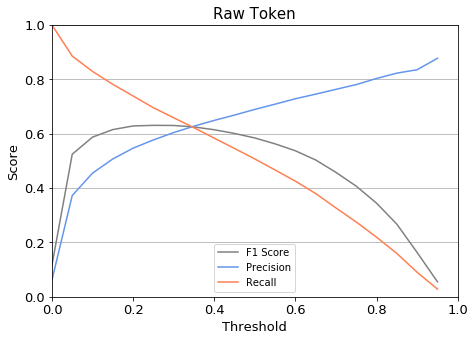

In [50]:
fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(121)
sns.lineplot(x=combined_score.index, y=combined_score['F1 Score'], color='grey')
sns.lineplot(x=combined_score.index, y=combined_score['Precision'], color='cornflowerblue')
sns.lineplot(x=combined_score.index, y=combined_score['Recall'], color='coral')
plt.ylim(0, 1)
plt.xlim(0, 1)
# plt.xticks(rotation=45)
plt.title('Raw Token', fontsize=15)
plt.ylabel('Score', fontsize = 13)
plt.yticks(fontsize=13)
plt.xlabel('Threshold', fontsize = 13)
plt.xticks(fontsize=13)
plt.legend(combined_score.columns, loc='lower center')
plt.grid(axis='y')




In [54]:
model.save('./W2VCBOW.pkl')

In [55]:
keras.models.load_model('./W2VCBOW.pkl')

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### Word2Vec Skip-Gram embedding using training data.

In [72]:
%%time
w2v_SkipGram = Word2Vec(sentences=X_train_t, size=300, window=5, min_count=5, workers=6, sg=1)

INFO - 09:49:12: collecting all words and their counts
INFO - 09:49:12: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:49:12: PROGRESS: at sentence #10000, processed 130140 words, keeping 14738 word types
INFO - 09:49:12: PROGRESS: at sentence #20000, processed 259997 words, keeping 21600 word types
INFO - 09:49:12: PROGRESS: at sentence #30000, processed 389329 words, keeping 26790 word types
INFO - 09:49:12: PROGRESS: at sentence #40000, processed 518014 words, keeping 31120 word types
INFO - 09:49:12: PROGRESS: at sentence #50000, processed 646632 words, keeping 34806 word types
INFO - 09:49:12: PROGRESS: at sentence #60000, processed 775136 words, keeping 38145 word types
INFO - 09:49:12: PROGRESS: at sentence #70000, processed 904057 words, keeping 41267 word types
INFO - 09:49:13: PROGRESS: at sentence #80000, processed 1034004 words, keeping 44155 word types
INFO - 09:49:13: PROGRESS: at sentence #90000, processed 1163059 words, keeping 46939 word ty

INFO - 09:49:16: PROGRESS: at sentence #820000, processed 10583536 words, keeping 143815 word types
INFO - 09:49:16: PROGRESS: at sentence #830000, processed 10711727 words, keeping 144709 word types
INFO - 09:49:16: PROGRESS: at sentence #840000, processed 10841865 words, keeping 145706 word types
INFO - 09:49:16: PROGRESS: at sentence #850000, processed 10972437 words, keeping 146593 word types
INFO - 09:49:16: PROGRESS: at sentence #860000, processed 11102911 words, keeping 147479 word types
INFO - 09:49:16: PROGRESS: at sentence #870000, processed 11232156 words, keeping 148306 word types
INFO - 09:49:16: PROGRESS: at sentence #880000, processed 11361454 words, keeping 149170 word types
INFO - 09:49:16: PROGRESS: at sentence #890000, processed 11491191 words, keeping 150089 word types
INFO - 09:49:16: PROGRESS: at sentence #900000, processed 11619603 words, keeping 150988 word types
INFO - 09:49:16: PROGRESS: at sentence #910000, processed 11748597 words, keeping 151876 word types


INFO - 09:50:05: EPOCH 2 - PROGRESS: at 79.43% examples, 362520 words/s, in_qsize 11, out_qsize 0
INFO - 09:50:06: EPOCH 2 - PROGRESS: at 83.40% examples, 363098 words/s, in_qsize 11, out_qsize 0
INFO - 09:50:07: EPOCH 2 - PROGRESS: at 87.32% examples, 363728 words/s, in_qsize 12, out_qsize 0
INFO - 09:50:08: EPOCH 2 - PROGRESS: at 91.41% examples, 364831 words/s, in_qsize 12, out_qsize 0
INFO - 09:50:09: EPOCH 2 - PROGRESS: at 95.42% examples, 365394 words/s, in_qsize 12, out_qsize 0
INFO - 09:50:10: EPOCH 2 - PROGRESS: at 99.26% examples, 365458 words/s, in_qsize 11, out_qsize 0
INFO - 09:50:10: worker thread finished; awaiting finish of 5 more threads
INFO - 09:50:10: worker thread finished; awaiting finish of 4 more threads
INFO - 09:50:10: worker thread finished; awaiting finish of 3 more threads
INFO - 09:50:10: worker thread finished; awaiting finish of 2 more threads
INFO - 09:50:10: worker thread finished; awaiting finish of 1 more threads
INFO - 09:50:10: worker thread finish

INFO - 09:51:13: EPOCH 5 - PROGRESS: at 39.34% examples, 376689 words/s, in_qsize 11, out_qsize 0
INFO - 09:51:14: EPOCH 5 - PROGRESS: at 43.33% examples, 377059 words/s, in_qsize 11, out_qsize 0
INFO - 09:51:15: EPOCH 5 - PROGRESS: at 47.26% examples, 377002 words/s, in_qsize 11, out_qsize 0
INFO - 09:51:16: EPOCH 5 - PROGRESS: at 51.33% examples, 377948 words/s, in_qsize 12, out_qsize 0
INFO - 09:51:17: EPOCH 5 - PROGRESS: at 55.39% examples, 378965 words/s, in_qsize 12, out_qsize 0
INFO - 09:51:18: EPOCH 5 - PROGRESS: at 59.70% examples, 381439 words/s, in_qsize 11, out_qsize 0
INFO - 09:51:19: EPOCH 5 - PROGRESS: at 63.79% examples, 381896 words/s, in_qsize 12, out_qsize 1
INFO - 09:51:20: EPOCH 5 - PROGRESS: at 68.07% examples, 383575 words/s, in_qsize 11, out_qsize 0
INFO - 09:51:21: EPOCH 5 - PROGRESS: at 72.46% examples, 385459 words/s, in_qsize 11, out_qsize 0
INFO - 09:51:22: EPOCH 5 - PROGRESS: at 76.69% examples, 386327 words/s, in_qsize 12, out_qsize 0
INFO - 09:51:23: EPO

Wall time: 2min 16s


In [73]:
w2v_SkipGram.wv.most_similar('nice')

INFO - 09:51:28: precomputing L2-norms of word weight vectors


[('charming', 0.634465217590332),
 ('sneaky', 0.6027218103408813),
 ('slutty', 0.5959360599517822),
 ('flirtatious', 0.5944178104400635),
 ('manly', 0.5880166292190552),
 ('impolite', 0.587806224822998),
 ('aloof', 0.5874828100204468),
 ('hipster', 0.582385778427124),
 ('nerdy', 0.5819672346115112),
 ('cute', 0.5811487436294556)]


#### LSTM Word2Vec Skip-Gram

In [74]:
# Tunning parameters
MAX_NB_WORDS = 160000
EMBEDDING_DIM = 300
LSTM_UNITS = 100
DROP = 0.2
RE_DROP = 0.2

In [75]:
%%time
embedding_matrix = np.zeros((len(tokenizer.word_index), EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in w2v_SkipGram.wv.vocab:
        embedding_matrix[i] = model_CBOW.wv.get_vector(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 130051
Wall time: 461 ms


In [ ]:
embedding_matrix.shape

(173994, 300)

In [ ]:
%%time
#### LSTM## Network architecture
model = Sequential()

model.add(Embedding(173994, EMBEDDING_DIM, weights = [embedding_matrix], input_length=INPUT_LEN)) 
model.add(LSTM(LSTM_UNITS, dropout=DROP, recurrent_dropout=RE_DROP))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_data, y_train, validation_split=0.4, epochs=3)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 626938 samples, validate on 417959 samples
Epoch 1/3


  6176/626938 [..............................] - ETA: 20:42:23 - loss: 0.7150 - acc: 0.406 - ETA: 11:33:48 - loss: 0.6600 - acc: 0.656 - ETA: 8:30:43 - loss: 0.6143 - acc: 0.750 - ETA: 7:01:03 - loss: 0.5729 - acc: 0.79 - ETA: 6:07:07 - loss: 0.5460 - acc: 0.81 - ETA: 5:32:24 - loss: 0.4947 - acc: 0.84 - ETA: 5:09:34 - loss: 0.4679 - acc: 0.86 - ETA: 4:50:39 - loss: 0.4511 - acc: 0.86 - ETA: 4:35:14 - loss: 0.4380 - acc: 0.87 - ETA: 4:25:04 - loss: 0.4171 - acc: 0.87 - ETA: 4:17:06 - loss: 0.3932 - acc: 0.88 - ETA: 4:09:20 - loss: 0.3807 - acc: 0.89 - ETA: 4:01:17 - loss: 0.3628 - acc: 0.89 - ETA: 3:54:42 - loss: 0.3476 - acc: 0.90 - ETA: 3:49:02 - loss: 0.3481 - acc: 0.90 - ETA: 3:44:22 - loss: 0.3349 - acc: 0.90 - ETA: 3:40:50 - loss: 0.3285 - acc: 0.90 - ETA: 3:36:40 - loss: 0.3290 - acc: 0.90 - ETA: 3:33:44 - loss: 0.3369 - acc: 0.90 - ETA: 3:30:50 - loss: 0.3371 - acc: 0.90 - ETA: 3:27:58 - loss: 0.3269 - acc: 0.90 - ETA: 3:25:02 - loss: 0.3222 - acc: 0.91 - ETA: 3:22:27 - loss: 0

 12384/626938 [..............................] - ETA: 2:40:11 - loss: 0.1864 - acc: 0.93 - ETA: 2:40:08 - loss: 0.1855 - acc: 0.93 - ETA: 2:40:10 - loss: 0.1861 - acc: 0.93 - ETA: 2:40:11 - loss: 0.1863 - acc: 0.93 - ETA: 2:40:07 - loss: 0.1864 - acc: 0.93 - ETA: 2:40:04 - loss: 0.1858 - acc: 0.93 - ETA: 2:40:03 - loss: 0.1854 - acc: 0.93 - ETA: 2:40:03 - loss: 0.1851 - acc: 0.93 - ETA: 2:39:59 - loss: 0.1848 - acc: 0.93 - ETA: 2:39:56 - loss: 0.1848 - acc: 0.93 - ETA: 2:39:53 - loss: 0.1842 - acc: 0.93 - ETA: 2:39:52 - loss: 0.1850 - acc: 0.93 - ETA: 2:39:48 - loss: 0.1843 - acc: 0.93 - ETA: 2:39:47 - loss: 0.1836 - acc: 0.93 - ETA: 2:39:44 - loss: 0.1833 - acc: 0.93 - ETA: 2:39:41 - loss: 0.1838 - acc: 0.93 - ETA: 2:39:39 - loss: 0.1838 - acc: 0.93 - ETA: 2:39:44 - loss: 0.1840 - acc: 0.93 - ETA: 2:39:47 - loss: 0.1841 - acc: 0.93 - ETA: 2:39:45 - loss: 0.1840 - acc: 0.93 - ETA: 2:39:44 - loss: 0.1840 - acc: 0.93 - ETA: 2:39:45 - loss: 0.1842 - acc: 0.93 - ETA: 2:39:47 - loss: 0.1839

 18592/626938 [..............................] - ETA: 2:38:20 - loss: 0.1680 - acc: 0.93 - ETA: 2:38:19 - loss: 0.1677 - acc: 0.94 - ETA: 2:38:18 - loss: 0.1675 - acc: 0.94 - ETA: 2:38:16 - loss: 0.1673 - acc: 0.94 - ETA: 2:38:15 - loss: 0.1673 - acc: 0.94 - ETA: 2:38:15 - loss: 0.1676 - acc: 0.93 - ETA: 2:38:14 - loss: 0.1674 - acc: 0.94 - ETA: 2:38:14 - loss: 0.1671 - acc: 0.94 - ETA: 2:38:15 - loss: 0.1672 - acc: 0.94 - ETA: 2:38:17 - loss: 0.1669 - acc: 0.94 - ETA: 2:38:20 - loss: 0.1667 - acc: 0.94 - ETA: 2:38:20 - loss: 0.1666 - acc: 0.94 - ETA: 2:38:18 - loss: 0.1666 - acc: 0.94 - ETA: 2:38:18 - loss: 0.1664 - acc: 0.94 - ETA: 2:38:17 - loss: 0.1661 - acc: 0.94 - ETA: 2:38:16 - loss: 0.1662 - acc: 0.94 - ETA: 2:38:18 - loss: 0.1659 - acc: 0.94 - ETA: 2:38:19 - loss: 0.1655 - acc: 0.94 - ETA: 2:38:21 - loss: 0.1654 - acc: 0.94 - ETA: 2:38:22 - loss: 0.1655 - acc: 0.94 - ETA: 2:38:21 - loss: 0.1658 - acc: 0.94 - ETA: 2:38:21 - loss: 0.1665 - acc: 0.94 - ETA: 2:38:21 - loss: 0.1662

 24800/626938 [>.............................] - ETA: 2:36:57 - loss: 0.1561 - acc: 0.94 - ETA: 2:36:56 - loss: 0.1559 - acc: 0.94 - ETA: 2:36:54 - loss: 0.1560 - acc: 0.94 - ETA: 2:36:52 - loss: 0.1561 - acc: 0.94 - ETA: 2:36:51 - loss: 0.1559 - acc: 0.94 - ETA: 2:36:50 - loss: 0.1557 - acc: 0.94 - ETA: 2:36:50 - loss: 0.1558 - acc: 0.94 - ETA: 2:36:48 - loss: 0.1556 - acc: 0.94 - ETA: 2:36:47 - loss: 0.1557 - acc: 0.94 - ETA: 2:36:45 - loss: 0.1557 - acc: 0.94 - ETA: 2:36:44 - loss: 0.1557 - acc: 0.94 - ETA: 2:36:42 - loss: 0.1559 - acc: 0.94 - ETA: 2:36:40 - loss: 0.1558 - acc: 0.94 - ETA: 2:36:38 - loss: 0.1557 - acc: 0.94 - ETA: 2:36:37 - loss: 0.1556 - acc: 0.94 - ETA: 2:36:35 - loss: 0.1554 - acc: 0.94 - ETA: 2:36:34 - loss: 0.1554 - acc: 0.94 - ETA: 2:36:36 - loss: 0.1553 - acc: 0.94 - ETA: 2:36:37 - loss: 0.1551 - acc: 0.94 - ETA: 2:36:35 - loss: 0.1550 - acc: 0.94 - ETA: 2:36:34 - loss: 0.1550 - acc: 0.94 - ETA: 2:36:33 - loss: 0.1555 - acc: 0.94 - ETA: 2:36:32 - loss: 0.1556

 31008/626938 [>.............................] - ETA: 2:37:01 - loss: 0.1477 - acc: 0.94 - ETA: 2:37:01 - loss: 0.1477 - acc: 0.94 - ETA: 2:37:02 - loss: 0.1476 - acc: 0.94 - ETA: 2:37:02 - loss: 0.1477 - acc: 0.94 - ETA: 2:37:03 - loss: 0.1476 - acc: 0.94 - ETA: 2:37:04 - loss: 0.1475 - acc: 0.94 - ETA: 2:37:05 - loss: 0.1474 - acc: 0.94 - ETA: 2:37:07 - loss: 0.1475 - acc: 0.94 - ETA: 2:37:09 - loss: 0.1475 - acc: 0.94 - ETA: 2:37:10 - loss: 0.1474 - acc: 0.94 - ETA: 2:37:11 - loss: 0.1474 - acc: 0.94 - ETA: 2:37:11 - loss: 0.1474 - acc: 0.94 - ETA: 2:37:12 - loss: 0.1473 - acc: 0.94 - ETA: 2:37:12 - loss: 0.1473 - acc: 0.94 - ETA: 2:37:12 - loss: 0.1473 - acc: 0.94 - ETA: 2:37:13 - loss: 0.1473 - acc: 0.94 - ETA: 2:37:13 - loss: 0.1473 - acc: 0.94 - ETA: 2:37:13 - loss: 0.1472 - acc: 0.94 - ETA: 2:37:14 - loss: 0.1472 - acc: 0.94 - ETA: 2:37:14 - loss: 0.1471 - acc: 0.94 - ETA: 2:37:14 - loss: 0.1473 - acc: 0.94 - ETA: 2:37:14 - loss: 0.1471 - acc: 0.94 - ETA: 2:37:14 - loss: 0.1471

 37216/626938 [>.............................] - ETA: 2:38:09 - loss: 0.1438 - acc: 0.94 - ETA: 2:38:09 - loss: 0.1437 - acc: 0.94 - ETA: 2:38:09 - loss: 0.1436 - acc: 0.94 - ETA: 2:38:09 - loss: 0.1436 - acc: 0.94 - ETA: 2:38:08 - loss: 0.1435 - acc: 0.94 - ETA: 2:38:07 - loss: 0.1437 - acc: 0.94 - ETA: 2:38:07 - loss: 0.1436 - acc: 0.94 - ETA: 2:38:05 - loss: 0.1435 - acc: 0.94 - ETA: 2:38:04 - loss: 0.1435 - acc: 0.94 - ETA: 2:38:02 - loss: 0.1435 - acc: 0.94 - ETA: 2:38:02 - loss: 0.1436 - acc: 0.94 - ETA: 2:38:02 - loss: 0.1437 - acc: 0.94 - ETA: 2:38:01 - loss: 0.1438 - acc: 0.94 - ETA: 2:38:00 - loss: 0.1438 - acc: 0.94 - ETA: 2:37:58 - loss: 0.1439 - acc: 0.94 - ETA: 2:37:57 - loss: 0.1438 - acc: 0.94 - ETA: 2:37:56 - loss: 0.1438 - acc: 0.94 - ETA: 2:37:56 - loss: 0.1437 - acc: 0.94 - ETA: 2:37:55 - loss: 0.1436 - acc: 0.94 - ETA: 2:37:54 - loss: 0.1436 - acc: 0.94 - ETA: 2:37:54 - loss: 0.1436 - acc: 0.94 - ETA: 2:37:54 - loss: 0.1435 - acc: 0.94 - ETA: 2:37:54 - loss: 0.1435

 43424/626938 [=>............................] - ETA: 2:37:11 - loss: 0.1408 - acc: 0.94 - ETA: 2:37:11 - loss: 0.1408 - acc: 0.94 - ETA: 2:37:10 - loss: 0.1408 - acc: 0.94 - ETA: 2:37:09 - loss: 0.1407 - acc: 0.94 - ETA: 2:37:08 - loss: 0.1407 - acc: 0.94 - ETA: 2:37:08 - loss: 0.1407 - acc: 0.94 - ETA: 2:37:07 - loss: 0.1407 - acc: 0.94 - ETA: 2:37:06 - loss: 0.1407 - acc: 0.94 - ETA: 2:37:06 - loss: 0.1407 - acc: 0.94 - ETA: 2:37:05 - loss: 0.1408 - acc: 0.94 - ETA: 2:37:06 - loss: 0.1408 - acc: 0.94 - ETA: 2:37:05 - loss: 0.1407 - acc: 0.94 - ETA: 2:37:04 - loss: 0.1406 - acc: 0.94 - ETA: 2:37:03 - loss: 0.1408 - acc: 0.94 - ETA: 2:37:02 - loss: 0.1409 - acc: 0.94 - ETA: 2:37:01 - loss: 0.1408 - acc: 0.94 - ETA: 2:37:00 - loss: 0.1408 - acc: 0.94 - ETA: 2:36:59 - loss: 0.1407 - acc: 0.94 - ETA: 2:36:58 - loss: 0.1407 - acc: 0.94 - ETA: 2:36:57 - loss: 0.1407 - acc: 0.94 - ETA: 2:36:56 - loss: 0.1406 - acc: 0.94 - ETA: 2:36:56 - loss: 0.1406 - acc: 0.94 - ETA: 2:36:55 - loss: 0.1405

 49632/626938 [=>............................] - ETA: 2:34:58 - loss: 0.1367 - acc: 0.94 - ETA: 2:34:57 - loss: 0.1366 - acc: 0.94 - ETA: 2:34:57 - loss: 0.1366 - acc: 0.94 - ETA: 2:34:56 - loss: 0.1365 - acc: 0.94 - ETA: 2:34:56 - loss: 0.1365 - acc: 0.94 - ETA: 2:34:55 - loss: 0.1364 - acc: 0.94 - ETA: 2:34:54 - loss: 0.1364 - acc: 0.94 - ETA: 2:34:53 - loss: 0.1363 - acc: 0.94 - ETA: 2:34:54 - loss: 0.1362 - acc: 0.94 - ETA: 2:34:53 - loss: 0.1362 - acc: 0.94 - ETA: 2:34:53 - loss: 0.1361 - acc: 0.94 - ETA: 2:34:53 - loss: 0.1360 - acc: 0.94 - ETA: 2:34:53 - loss: 0.1359 - acc: 0.94 - ETA: 2:34:52 - loss: 0.1360 - acc: 0.94 - ETA: 2:34:51 - loss: 0.1360 - acc: 0.94 - ETA: 2:34:50 - loss: 0.1360 - acc: 0.94 - ETA: 2:34:50 - loss: 0.1361 - acc: 0.94 - ETA: 2:34:49 - loss: 0.1360 - acc: 0.94 - ETA: 2:34:48 - loss: 0.1360 - acc: 0.94 - ETA: 2:34:47 - loss: 0.1360 - acc: 0.94 - ETA: 2:34:46 - loss: 0.1360 - acc: 0.94 - ETA: 2:34:45 - loss: 0.1359 - acc: 0.94 - ETA: 2:34:44 - loss: 0.1360

 55840/626938 [=>............................] - ETA: 2:34:31 - loss: 0.1354 - acc: 0.94 - ETA: 2:34:32 - loss: 0.1353 - acc: 0.94 - ETA: 2:34:32 - loss: 0.1354 - acc: 0.94 - ETA: 2:34:34 - loss: 0.1354 - acc: 0.94 - ETA: 2:34:34 - loss: 0.1354 - acc: 0.94 - ETA: 2:34:34 - loss: 0.1355 - acc: 0.94 - ETA: 2:34:35 - loss: 0.1355 - acc: 0.94 - ETA: 2:34:35 - loss: 0.1354 - acc: 0.94 - ETA: 2:34:36 - loss: 0.1354 - acc: 0.94 - ETA: 2:34:36 - loss: 0.1355 - acc: 0.94 - ETA: 2:34:36 - loss: 0.1355 - acc: 0.94 - ETA: 2:34:36 - loss: 0.1355 - acc: 0.94 - ETA: 2:34:36 - loss: 0.1355 - acc: 0.94 - ETA: 2:34:36 - loss: 0.1354 - acc: 0.94 - ETA: 2:34:36 - loss: 0.1354 - acc: 0.94 - ETA: 2:34:36 - loss: 0.1354 - acc: 0.94 - ETA: 2:34:37 - loss: 0.1356 - acc: 0.94 - ETA: 2:34:37 - loss: 0.1355 - acc: 0.94 - ETA: 2:34:37 - loss: 0.1355 - acc: 0.94 - ETA: 2:34:38 - loss: 0.1356 - acc: 0.94 - ETA: 2:34:38 - loss: 0.1355 - acc: 0.94 - ETA: 2:34:38 - loss: 0.1355 - acc: 0.94 - ETA: 2:34:38 - loss: 0.1355

 57760/626938 [=>............................] - ETA: 2:34:13 - loss: 0.1350 - acc: 0.94 - ETA: 2:34:12 - loss: 0.1350 - acc: 0.94 - ETA: 2:34:11 - loss: 0.1349 - acc: 0.94 - ETA: 2:34:11 - loss: 0.1348 - acc: 0.94 - ETA: 2:34:10 - loss: 0.1350 - acc: 0.94 - ETA: 2:34:09 - loss: 0.1351 - acc: 0.94 - ETA: 2:34:09 - loss: 0.1352 - acc: 0.94 - ETA: 2:34:08 - loss: 0.1352 - acc: 0.94 - ETA: 2:34:08 - loss: 0.1352 - acc: 0.94 - ETA: 2:34:08 - loss: 0.1351 - acc: 0.94 - ETA: 2:34:08 - loss: 0.1351 - acc: 0.94 - ETA: 2:34:08 - loss: 0.1351 - acc: 0.94 - ETA: 2:34:08 - loss: 0.1351 - acc: 0.94 - ETA: 2:34:07 - loss: 0.1350 - acc: 0.94 - ETA: 2:34:07 - loss: 0.1350 - acc: 0.94 - ETA: 2:34:06 - loss: 0.1350 - acc: 0.94 - ETA: 2:34:06 - loss: 0.1351 - acc: 0.94 - ETA: 2:34:06 - loss: 0.1350 - acc: 0.94 - ETA: 2:34:06 - loss: 0.1350 - acc: 0.94 - ETA: 2:34:06 - loss: 0.1350 - acc: 0.94 - ETA: 2:34:06 - loss: 0.1350 - acc: 0.94 - ETA: 2:34:05 - loss: 0.1350 - acc: 0.94 - ETA: 2:34:05 - loss: 0.1350

In [ ]:
%%time
y_pred = model.predict(X_test_data, workers=6)

In [ ]:
y_predRound = [ 1 if y >= 0.3 else 0  for y in y_pred]

In [ ]:
print('accuracy %s' % accuracy_score(y_test, y_predRound))
print(classification_report(y_test, y_predRound))
confusion_matrix(y_test, y_predRound)

In [ ]:
threshold_list = []
recall_list = []
precision_list = []
f1_list = []
for thres in range(0, 100, 5):
    
    y_predRound = [ 1 if y >= thres/100 else 0  for y in y_pred]
    threshold_list.append(thres/100)
    recall_list.append(recall_score(y_test,  y_predRound))
    precision_list.append(precision_score(y_test,  y_predRound))
    f1_list.append(f1_score(y_test,  y_predRound))

In [ ]:
combined_score = pd.DataFrame(index=threshold_list)
combined_score['F1 Score'] = f1_list
combined_score['Precision'] = precision_list
combined_score['Recall'] = recall_list

In [ ]:
combined_score.to_pickle('./W2VSkipGram_combined_score.pkl')

In [ ]:
combined_score = pd.read_pickle('./W2VSkipGram_combined_score.pkl')

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(121)
sns.lineplot(x=combined_score.index, y=combined_score['F1 Score'], color='grey')
sns.lineplot(x=combined_score.index, y=combined_score['Precision'], color='cornflowerblue')
sns.lineplot(x=combined_score.index, y=combined_score['Recall'], color='coral')
plt.ylim(0, 1)
plt.xlim(0, 1)
# plt.xticks(rotation=45)
plt.title('Raw Token', fontsize=15)
plt.ylabel('Score', fontsize = 13)
plt.yticks(fontsize=13)
plt.xlabel('Threshold', fontsize = 13)
plt.xticks(fontsize=13)
plt.legend(combined_score.columns, loc='lower center')
plt.grid(axis='y')




In [ ]:
model.save('./W2VSkipGram')

In [ ]:
keras.models.load_model('./W2VSkipGram')

### FastText CBOW embedding using training data.

In [57]:
%%time
FastText_CBOW = FastText(sentences=X_train_t, size=300, window=5, min_count=5, workers=6, sg=0)

INFO - 09:40:45: collecting all words and their counts
INFO - 09:40:45: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:40:45: PROGRESS: at sentence #10000, processed 130140 words, keeping 14738 word types
INFO - 09:40:45: PROGRESS: at sentence #20000, processed 259997 words, keeping 21600 word types
INFO - 09:40:46: PROGRESS: at sentence #30000, processed 389329 words, keeping 26790 word types
INFO - 09:40:47: PROGRESS: at sentence #40000, processed 518014 words, keeping 31120 word types
INFO - 09:40:47: PROGRESS: at sentence #50000, processed 646632 words, keeping 34806 word types
INFO - 09:40:47: PROGRESS: at sentence #60000, processed 775136 words, keeping 38145 word types
INFO - 09:40:47: PROGRESS: at sentence #70000, processed 904057 words, keeping 41267 word types
INFO - 09:40:47: PROGRESS: at sentence #80000, processed 1034004 words, keeping 44155 word types
INFO - 09:40:47: PROGRESS: at sentence #90000, processed 1163059 words, keeping 46939 word ty

INFO - 09:41:40: EPOCH 2 - PROGRESS: at 93.19% examples, 404545 words/s, in_qsize 11, out_qsize 0
INFO - 09:41:41: EPOCH 2 - PROGRESS: at 97.49% examples, 404874 words/s, in_qsize 12, out_qsize 0
INFO - 09:41:41: worker thread finished; awaiting finish of 5 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 4 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 3 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 2 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 1 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 0 more threads
INFO - 09:41:41: EPOCH - 2 : training on 13489665 raw words (9705214 effective words) took 23.9s, 405775 effective words/s
INFO - 09:41:42: EPOCH 3 - PROGRESS: at 4.06% examples, 394968 words/s, in_qsize 12, out_qsize 0
INFO - 09:41:43: EPOCH 3 - PROGRESS: at 8.36% examples, 403912 words/s, in_qsize 12, out_qsize 0
INFO - 09:41:44: EPOCH 3 - PROGRESS: 

Wall time: 2min 11s


In [58]:
FastText_CBOW.wv.most_similar('nice')

INFO - 09:42:57: precomputing L2-norms of word weight vectors


[('charming', 0.6280179619789124),
 ('sneaky', 0.572664201259613),
 ('cute', 0.5725623369216919),
 ('comforting', 0.570707380771637),
 ('slutty', 0.5703924298286438),
 ('impolite', 0.5681282877922058),
 ('classy', 0.566018283367157),
 ('nerdy', 0.5623044967651367),
 ('flirtatious', 0.5622875690460205),
 ('timid', 0.5592190623283386)]


#### LSTM FastText CBOW

In [59]:
# Tunning parameters
MAX_NB_WORDS = 160000
EMBEDDING_DIM = 300
LSTM_UNITS = 100
DROP = 0.2
RE_DROP = 0.2

In [60]:
%%time
embedding_matrix = np.zeros((len(tokenizer.word_index), EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in FastText_CBOW.wv.vocab:
        embedding_matrix[i] = model_CBOW.wv.get_vector(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 130051
Wall time: 624 ms


In [ ]:
embedding_matrix.shape

(173994, 300)

In [ ]:
%%time
#### LSTM## Network architecture
model = Sequential()

model.add(Embedding(173994, EMBEDDING_DIM, weights = [embedding_matrix], input_length=INPUT_LEN)) 
model.add(LSTM(LSTM_UNITS, dropout=DROP, recurrent_dropout=RE_DROP))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_data, y_train, validation_split=0.4, epochs=3)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 626938 samples, validate on 417959 samples
Epoch 1/3


  6176/626938 [..............................] - ETA: 19:26:18 - loss: 0.6499 - acc: 0.843 - ETA: 10:19:12 - loss: 0.5994 - acc: 0.906 - ETA: 7:17:48 - loss: 0.5432 - acc: 0.937 - ETA: 5:45:53 - loss: 0.4939 - acc: 0.95 - ETA: 4:51:42 - loss: 0.4876 - acc: 0.93 - ETA: 4:15:52 - loss: 0.4544 - acc: 0.93 - ETA: 3:50:26 - loss: 0.4342 - acc: 0.92 - ETA: 3:32:31 - loss: 0.4344 - acc: 0.91 - ETA: 3:17:42 - loss: 0.4106 - acc: 0.92 - ETA: 3:06:03 - loss: 0.3941 - acc: 0.92 - ETA: 2:56:26 - loss: 0.4001 - acc: 0.91 - ETA: 2:49:18 - loss: 0.3771 - acc: 0.92 - ETA: 2:42:04 - loss: 0.3597 - acc: 0.92 - ETA: 2:35:48 - loss: 0.3645 - acc: 0.92 - ETA: 2:29:58 - loss: 0.3564 - acc: 0.92 - ETA: 2:25:50 - loss: 0.3532 - acc: 0.92 - ETA: 2:21:32 - loss: 0.3574 - acc: 0.91 - ETA: 2:18:19 - loss: 0.3509 - acc: 0.92 - ETA: 2:14:51 - loss: 0.3393 - acc: 0.92 - ETA: 2:11:36 - loss: 0.3365 - acc: 0.92 - ETA: 2:08:43 - loss: 0.3272 - acc: 0.92 - ETA: 2:06:55 - loss: 0.3228 - acc: 0.92 - ETA: 2:04:37 - loss: 0

 18592/626938 [..............................] - ETA: 1:18:36 - loss: 0.1667 - acc: 0.93 - ETA: 1:18:36 - loss: 0.1665 - acc: 0.93 - ETA: 1:18:36 - loss: 0.1663 - acc: 0.93 - ETA: 1:18:35 - loss: 0.1661 - acc: 0.93 - ETA: 1:18:36 - loss: 0.1659 - acc: 0.93 - ETA: 1:18:35 - loss: 0.1660 - acc: 0.93 - ETA: 1:18:35 - loss: 0.1665 - acc: 0.93 - ETA: 1:18:34 - loss: 0.1662 - acc: 0.93 - ETA: 1:18:34 - loss: 0.1660 - acc: 0.93 - ETA: 1:18:35 - loss: 0.1660 - acc: 0.93 - ETA: 1:18:37 - loss: 0.1661 - acc: 0.93 - ETA: 1:18:35 - loss: 0.1659 - acc: 0.93 - ETA: 1:18:35 - loss: 0.1658 - acc: 0.93 - ETA: 1:18:33 - loss: 0.1657 - acc: 0.93 - ETA: 1:18:33 - loss: 0.1658 - acc: 0.93 - ETA: 1:18:31 - loss: 0.1659 - acc: 0.93 - ETA: 1:18:29 - loss: 0.1661 - acc: 0.93 - ETA: 1:18:28 - loss: 0.1662 - acc: 0.93 - ETA: 1:18:27 - loss: 0.1663 - acc: 0.93 - ETA: 1:18:28 - loss: 0.1662 - acc: 0.93 - ETA: 1:18:27 - loss: 0.1664 - acc: 0.93 - ETA: 1:18:26 - loss: 0.1664 - acc: 0.93 - ETA: 1:18:25 - loss: 0.1667

 24800/626938 [>.............................] - ETA: 1:16:30 - loss: 0.1610 - acc: 0.94 - ETA: 1:16:29 - loss: 0.1611 - acc: 0.94 - ETA: 1:16:28 - loss: 0.1612 - acc: 0.94 - ETA: 1:16:28 - loss: 0.1612 - acc: 0.94 - ETA: 1:16:29 - loss: 0.1613 - acc: 0.94 - ETA: 1:16:29 - loss: 0.1613 - acc: 0.94 - ETA: 1:16:28 - loss: 0.1614 - acc: 0.94 - ETA: 1:16:29 - loss: 0.1615 - acc: 0.94 - ETA: 1:16:30 - loss: 0.1613 - acc: 0.94 - ETA: 1:16:30 - loss: 0.1613 - acc: 0.94 - ETA: 1:16:30 - loss: 0.1612 - acc: 0.94 - ETA: 1:16:30 - loss: 0.1610 - acc: 0.94 - ETA: 1:16:30 - loss: 0.1609 - acc: 0.94 - ETA: 1:16:29 - loss: 0.1610 - acc: 0.94 - ETA: 1:16:29 - loss: 0.1608 - acc: 0.94 - ETA: 1:16:28 - loss: 0.1608 - acc: 0.94 - ETA: 1:16:28 - loss: 0.1607 - acc: 0.94 - ETA: 1:16:27 - loss: 0.1606 - acc: 0.94 - ETA: 1:16:26 - loss: 0.1605 - acc: 0.94 - ETA: 1:16:25 - loss: 0.1604 - acc: 0.94 - ETA: 1:16:25 - loss: 0.1603 - acc: 0.94 - ETA: 1:16:25 - loss: 0.1602 - acc: 0.94 - ETA: 1:16:24 - loss: 0.1603

 26848/626938 [>.............................] - ETA: 1:15:55 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:54 - loss: 0.1546 - acc: 0.94 - ETA: 1:15:54 - loss: 0.1546 - acc: 0.94 - ETA: 1:15:54 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1548 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1546 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1546 - acc: 0.94 - ETA: 1:15:52 - loss: 0.1545 - acc: 0.94 - ETA: 1:15:52 - loss: 0.1544 - acc: 0.94 - ETA: 1:15:52 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1546 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1548 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1548 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:54 - loss: 0.1546 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1545 - acc: 0.94 - ETA: 1:15:54 - loss: 0.1544 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1543

In [ ]:
%%time
y_pred = model.predict(X_test_data, workers=6)

In [ ]:
y_predRound = [ 1 if y >= 0.3 else 0  for y in y_pred]

In [ ]:
print('accuracy %s' % accuracy_score(y_test, y_predRound))
print(classification_report(y_test, y_predRound))
confusion_matrix(y_test, y_predRound)

In [ ]:
threshold_list = []
recall_list = []
precision_list = []
f1_list = []
for thres in range(0, 100, 5):
    
    y_predRound = [ 1 if y >= thres/100 else 0  for y in y_pred]
    threshold_list.append(thres/100)
    recall_list.append(recall_score(y_test,  y_predRound))
    precision_list.append(precision_score(y_test,  y_predRound))
    f1_list.append(f1_score(y_test,  y_predRound))

In [ ]:
combined_score = pd.DataFrame(index=threshold_list)
combined_score['F1 Score'] = f1_list
combined_score['Precision'] = precision_list
combined_score['Recall'] = recall_list

In [ ]:
combined_score.to_pickle('./FastText_CBOW_combined_score.pkl')

In [ ]:
combined_score = pd.read_pickle('./FastText_CBOW_combined_score.pkl')

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(121)
sns.lineplot(x=combined_score.index, y=combined_score['F1 Score'], color='grey')
sns.lineplot(x=combined_score.index, y=combined_score['Precision'], color='cornflowerblue')
sns.lineplot(x=combined_score.index, y=combined_score['Recall'], color='coral')
plt.ylim(0, 1)
plt.xlim(0, 1)
# plt.xticks(rotation=45)
plt.title('Raw Token', fontsize=15)
plt.ylabel('Score', fontsize = 13)
plt.yticks(fontsize=13)
plt.xlabel('Threshold', fontsize = 13)
plt.xticks(fontsize=13)
plt.legend(combined_score.columns, loc='lower center')
plt.grid(axis='y')




In [ ]:
model.save('./FastText_CBOW')

In [ ]:
keras.models.load_model('./FastText_CBOW')

### FastText Skip-Gram embedding using training data.

In [57]:
%%time
FastText_SkipGram = FastText(sentences=X_train_t, size=300, window=5, min_count=5, workers=6, sg=1)

INFO - 09:40:45: collecting all words and their counts
INFO - 09:40:45: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:40:45: PROGRESS: at sentence #10000, processed 130140 words, keeping 14738 word types
INFO - 09:40:45: PROGRESS: at sentence #20000, processed 259997 words, keeping 21600 word types
INFO - 09:40:46: PROGRESS: at sentence #30000, processed 389329 words, keeping 26790 word types
INFO - 09:40:47: PROGRESS: at sentence #40000, processed 518014 words, keeping 31120 word types
INFO - 09:40:47: PROGRESS: at sentence #50000, processed 646632 words, keeping 34806 word types
INFO - 09:40:47: PROGRESS: at sentence #60000, processed 775136 words, keeping 38145 word types
INFO - 09:40:47: PROGRESS: at sentence #70000, processed 904057 words, keeping 41267 word types
INFO - 09:40:47: PROGRESS: at sentence #80000, processed 1034004 words, keeping 44155 word types
INFO - 09:40:47: PROGRESS: at sentence #90000, processed 1163059 words, keeping 46939 word ty

INFO - 09:41:40: EPOCH 2 - PROGRESS: at 93.19% examples, 404545 words/s, in_qsize 11, out_qsize 0
INFO - 09:41:41: EPOCH 2 - PROGRESS: at 97.49% examples, 404874 words/s, in_qsize 12, out_qsize 0
INFO - 09:41:41: worker thread finished; awaiting finish of 5 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 4 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 3 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 2 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 1 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 0 more threads
INFO - 09:41:41: EPOCH - 2 : training on 13489665 raw words (9705214 effective words) took 23.9s, 405775 effective words/s
INFO - 09:41:42: EPOCH 3 - PROGRESS: at 4.06% examples, 394968 words/s, in_qsize 12, out_qsize 0
INFO - 09:41:43: EPOCH 3 - PROGRESS: at 8.36% examples, 403912 words/s, in_qsize 12, out_qsize 0
INFO - 09:41:44: EPOCH 3 - PROGRESS: 

Wall time: 2min 11s


In [58]:
FastText_SkipGram.wv.most_similar('nice')

INFO - 09:42:57: precomputing L2-norms of word weight vectors


[('charming', 0.6280179619789124),
 ('sneaky', 0.572664201259613),
 ('cute', 0.5725623369216919),
 ('comforting', 0.570707380771637),
 ('slutty', 0.5703924298286438),
 ('impolite', 0.5681282877922058),
 ('classy', 0.566018283367157),
 ('nerdy', 0.5623044967651367),
 ('flirtatious', 0.5622875690460205),
 ('timid', 0.5592190623283386)]


#### LSTM FastText CBOW

In [59]:
# Tunning parameters
MAX_NB_WORDS = 160000
EMBEDDING_DIM = 300
LSTM_UNITS = 100
DROP = 0.2
RE_DROP = 0.2

In [60]:
%%time
embedding_matrix = np.zeros((len(tokenizer.word_index), EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in FastText_SkipGram.wv.vocab:
        embedding_matrix[i] = model_CBOW.wv.get_vector(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 130051
Wall time: 624 ms


In [ ]:
embedding_matrix.shape

(173994, 300)

In [ ]:
%%time
#### LSTM## Network architecture
model = Sequential()

model.add(Embedding(173994, EMBEDDING_DIM, weights = [embedding_matrix], input_length=INPUT_LEN)) 
model.add(LSTM(LSTM_UNITS, dropout=DROP, recurrent_dropout=RE_DROP))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_data, y_train, validation_split=0.4, epochs=3)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 626938 samples, validate on 417959 samples
Epoch 1/3


  6176/626938 [..............................] - ETA: 19:26:18 - loss: 0.6499 - acc: 0.843 - ETA: 10:19:12 - loss: 0.5994 - acc: 0.906 - ETA: 7:17:48 - loss: 0.5432 - acc: 0.937 - ETA: 5:45:53 - loss: 0.4939 - acc: 0.95 - ETA: 4:51:42 - loss: 0.4876 - acc: 0.93 - ETA: 4:15:52 - loss: 0.4544 - acc: 0.93 - ETA: 3:50:26 - loss: 0.4342 - acc: 0.92 - ETA: 3:32:31 - loss: 0.4344 - acc: 0.91 - ETA: 3:17:42 - loss: 0.4106 - acc: 0.92 - ETA: 3:06:03 - loss: 0.3941 - acc: 0.92 - ETA: 2:56:26 - loss: 0.4001 - acc: 0.91 - ETA: 2:49:18 - loss: 0.3771 - acc: 0.92 - ETA: 2:42:04 - loss: 0.3597 - acc: 0.92 - ETA: 2:35:48 - loss: 0.3645 - acc: 0.92 - ETA: 2:29:58 - loss: 0.3564 - acc: 0.92 - ETA: 2:25:50 - loss: 0.3532 - acc: 0.92 - ETA: 2:21:32 - loss: 0.3574 - acc: 0.91 - ETA: 2:18:19 - loss: 0.3509 - acc: 0.92 - ETA: 2:14:51 - loss: 0.3393 - acc: 0.92 - ETA: 2:11:36 - loss: 0.3365 - acc: 0.92 - ETA: 2:08:43 - loss: 0.3272 - acc: 0.92 - ETA: 2:06:55 - loss: 0.3228 - acc: 0.92 - ETA: 2:04:37 - loss: 0

 24800/626938 [>.............................] - ETA: 1:16:30 - loss: 0.1610 - acc: 0.94 - ETA: 1:16:29 - loss: 0.1611 - acc: 0.94 - ETA: 1:16:28 - loss: 0.1612 - acc: 0.94 - ETA: 1:16:28 - loss: 0.1612 - acc: 0.94 - ETA: 1:16:29 - loss: 0.1613 - acc: 0.94 - ETA: 1:16:29 - loss: 0.1613 - acc: 0.94 - ETA: 1:16:28 - loss: 0.1614 - acc: 0.94 - ETA: 1:16:29 - loss: 0.1615 - acc: 0.94 - ETA: 1:16:30 - loss: 0.1613 - acc: 0.94 - ETA: 1:16:30 - loss: 0.1613 - acc: 0.94 - ETA: 1:16:30 - loss: 0.1612 - acc: 0.94 - ETA: 1:16:30 - loss: 0.1610 - acc: 0.94 - ETA: 1:16:30 - loss: 0.1609 - acc: 0.94 - ETA: 1:16:29 - loss: 0.1610 - acc: 0.94 - ETA: 1:16:29 - loss: 0.1608 - acc: 0.94 - ETA: 1:16:28 - loss: 0.1608 - acc: 0.94 - ETA: 1:16:28 - loss: 0.1607 - acc: 0.94 - ETA: 1:16:27 - loss: 0.1606 - acc: 0.94 - ETA: 1:16:26 - loss: 0.1605 - acc: 0.94 - ETA: 1:16:25 - loss: 0.1604 - acc: 0.94 - ETA: 1:16:25 - loss: 0.1603 - acc: 0.94 - ETA: 1:16:25 - loss: 0.1602 - acc: 0.94 - ETA: 1:16:24 - loss: 0.1603

 26848/626938 [>.............................] - ETA: 1:15:55 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:54 - loss: 0.1546 - acc: 0.94 - ETA: 1:15:54 - loss: 0.1546 - acc: 0.94 - ETA: 1:15:54 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1548 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1546 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1546 - acc: 0.94 - ETA: 1:15:52 - loss: 0.1545 - acc: 0.94 - ETA: 1:15:52 - loss: 0.1544 - acc: 0.94 - ETA: 1:15:52 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1546 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1548 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1548 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1547 - acc: 0.94 - ETA: 1:15:54 - loss: 0.1546 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1545 - acc: 0.94 - ETA: 1:15:54 - loss: 0.1544 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1543

In [ ]:
%%time
y_pred = model.predict(X_test_data, workers=6)

In [ ]:
y_predRound = [ 1 if y >= 0.3 else 0  for y in y_pred]

In [ ]:
print('accuracy %s' % accuracy_score(y_test, y_predRound))
print(classification_report(y_test, y_predRound))
confusion_matrix(y_test, y_predRound)

In [ ]:
threshold_list = []
recall_list = []
precision_list = []
f1_list = []
for thres in range(0, 100, 5):
    
    y_predRound = [ 1 if y >= thres/100 else 0  for y in y_pred]
    threshold_list.append(thres/100)
    recall_list.append(recall_score(y_test,  y_predRound))
    precision_list.append(precision_score(y_test,  y_predRound))
    f1_list.append(f1_score(y_test,  y_predRound))

In [ ]:
combined_score = pd.DataFrame(index=threshold_list)
combined_score['F1 Score'] = f1_list
combined_score['Precision'] = precision_list
combined_score['Recall'] = recall_list

In [ ]:
combined_score.to_pickle('./FastText_SkipGram_combined_score.pkl')

In [ ]:
combined_score = pd.read_pickle('./FastText_SkipGram_combined_score.pkl')

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(121)
sns.lineplot(x=combined_score.index, y=combined_score['F1 Score'], color='grey')
sns.lineplot(x=combined_score.index, y=combined_score['Precision'], color='cornflowerblue')
sns.lineplot(x=combined_score.index, y=combined_score['Recall'], color='coral')
plt.ylim(0, 1)
plt.xlim(0, 1)
# plt.xticks(rotation=45)
plt.title('Raw Token', fontsize=15)
plt.ylabel('Score', fontsize = 13)
plt.yticks(fontsize=13)
plt.xlabel('Threshold', fontsize = 13)
plt.xticks(fontsize=13)
plt.legend(combined_score.columns, loc='lower center')
plt.grid(axis='y')




In [ ]:
model.save('./FastText_SkipGram')

In [ ]:
keras.models.load_model('./FastText_SkipGram')